<a href="https://colab.research.google.com/github/varshini1488/DEVELOPMENT-OF-SUPERVISED-FOR-DETECTION-OF-TOXICOPHORES-USING-SIGNIFICANT-FEATURE-PREDICTION/blob/main/clustering_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, mean_squared_error, r2_score
import os
import warnings
warnings.filterwarnings('ignore')

# Google Colab specific imports
try:
    from google.colab import files
    from google.colab import drive
    COLAB_AVAILABLE = True
    print("✅ Google Colab environment detected!")
except ImportError:
    COLAB_AVAILABLE = False
    print("⚠️  Not in Google Colab environment")

# Try to import RDKit with fallback
try:
    from rdkit import Chem
    from rdkit.Chem import Descriptors, rdMolDescriptors
    RDKIT_AVAILABLE = True
    print("✅ RDKit loaded successfully!")
except ImportError:
    print("⚠️  RDKit not available. Installing...")
    if COLAB_AVAILABLE:
        import subprocess
        import sys
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'rdkit'])
        try:
            from rdkit import Chem
            from rdkit.Chem import Descriptors, rdMolDescriptors
            RDKIT_AVAILABLE = True
            print("✅ RDKit installed and loaded!")
        except:
            RDKIT_AVAILABLE = False
            print("❌ RDKit installation failed. Using fallback method.")
    else:
        RDKIT_AVAILABLE = False
        print("❌ RDKit not available. Using molecular fingerprint fallback.")

class SMILESToxicityPredictor:
    """
    Complete toxicity prediction system based on SMILES strings
    Optimized for Google Colab
    """

    def __init__(self, n_clusters=5):
        self.n_clusters = n_clusters
        self.scaler = StandardScaler()
        self.pca = None
        self.clusterer = None
        self.toxicity_model = None
        self.features = None
        self.feature_names = None
        self.cluster_labels = None
        self.selected_features = None
        self.dataset = None

    def get_file_input(self):
        """
        Get file input optimized for Google Colab
        """
        print("=" * 60)
        print("🧬 SMILES-Based Toxicity Prediction System")
        print("=" * 60)

        if COLAB_AVAILABLE:
            print("🔄 Choose data source:")
            print("1. Upload file from your computer")
            print("2. Use file from Google Drive")
            print("3. Use sample data for testing")

            choice = input("\nSelect option (1-3): ").strip()

            if choice == "1":
                return self.upload_file()
            elif choice == "2":
                return self.get_drive_file()
            elif choice == "3":
                return "sample_data"
            else:
                print("❌ Invalid choice. Using sample data.")
                return "sample_data"
        else:
            # Non-Colab environment
            return self.browse_local_files()

    def upload_file(self):
        """
        Upload file using Google Colab's file upload
        """
        print("📤 Click 'Choose Files' to upload your dataset...")
        try:
            uploaded = files.upload()

            if uploaded:
                filename = list(uploaded.keys())[0]
                print(f"✅ File uploaded: {filename}")
                return filename
            else:
                print("❌ No file uploaded. Using sample data.")
                return "sample_data"

        except Exception as e:
            print(f"❌ Upload error: {e}")
            return "sample_data"

    def get_drive_file(self):
        """
        Access file from Google Drive
        """
        print("📁 Mounting Google Drive...")
        try:
            drive.mount('/content/drive')
            print("✅ Google Drive mounted at /content/drive")

            # Look for common data files in Drive
            drive_path = "/content/drive/MyDrive"
            data_files = []

            for root, dirs, files in os.walk(drive_path):
                for file in files:
                    if file.endswith(('.csv', '.xlsx', '.xls')):
                        full_path = os.path.join(root, file)
                        data_files.append(full_path)
                        if len(data_files) >= 20:  # Limit to prevent too many results
                            break
                if len(data_files) >= 20:
                    break

            if data_files:
                print(f"📊 Found {len(data_files)} data files in Drive:")
                for i, filepath in enumerate(data_files[:10], 1):  # Show first 10
                    filename = os.path.basename(filepath)
                    print(f"  {i}. {filename}")

                choice = input(f"\nSelect file (1-{min(10, len(data_files))}) or path: ").strip()

                try:
                    file_idx = int(choice) - 1
                    if 0 <= file_idx < len(data_files):
                        return data_files[file_idx]
                except:
                    # User entered a path
                    if choice.startswith('/content/drive'):
                        return choice
                    else:
                        full_path = os.path.join(drive_path, choice)
                        if os.path.exists(full_path):
                            return full_path

            print("❌ No valid file selected. Using sample data.")
            return "sample_data"

        except Exception as e:
            print(f"❌ Drive mount error: {e}")
            return "sample_data"

    def browse_local_files(self):
        """
        Browse local files (non-Colab environment)
        """
        print("📁 Scanning for local data files...")
        data_files = []

        for root, dirs, files in os.walk('.'):
            for file in files:
                if file.endswith(('.csv', '.xlsx', '.xls')):
                    data_files.append(os.path.join(root, file))

        if data_files:
            print(f"📊 Found {len(data_files)} data files:")
            for i, filepath in enumerate(data_files, 1):
                print(f"  {i}. {os.path.basename(filepath)}")

            choice = input(f"\nSelect file (1-{len(data_files)}) or 's' for sample: ").strip()

            if choice.lower() == 's':
                return "sample_data"

            try:
                file_idx = int(choice) - 1
                if 0 <= file_idx < len(data_files):
                    return data_files[file_idx]
            except:
                pass

        print("📊 Using sample data.")
        return "sample_data"

    def load_dataset(self, filepath):
        """
        Load dataset with improved error handling for Colab
        """
        try:
            if filepath == "sample_data":
                print("📊 Loading sample dataset...")
                # Enhanced sample data with more realistic SMILES and toxicity values
                sample_data = {
                    'ID': ['62-53-3', '127-06-0', '75-21-8', '100-65-2', '74-87-3',
                           '74-83-9', '593-53-3', '108-90-7', '1493-02-3', '4091-39-8',
                           '67-66-3', '56-23-5', '79-01-6', '107-06-2', '75-09-2'],
                    'SMILES': ['c1ccc(cc1)N', 'CC(=NO)C', 'C1CO1', 'c1ccc(cc1)NO', 'CCl',
                              'CBr', 'CF', 'c1ccc(cc1)Cl', 'C=O', 'CC(CCl)=O',
                              'C(Cl)(Cl)Cl', 'C(Cl)(Cl)(Cl)Cl', 'C(=CCl)Cl', 'C(CCl)Cl', 'CCl'],
                    'Toxicity': [2.57, 1.89, 2.79, 3.04, 1.45, 2.65, 0.98, 2.01, 1.67, 2.23,
                                3.45, 4.12, 2.88, 1.78, 1.55],
                    'Activity_Class': ['Medium', 'Low', 'Medium', 'High', 'Low', 'Medium',
                                     'Low', 'Medium', 'Low', 'Medium', 'High', 'High',
                                     'Medium', 'Low', 'Low']
                }
                df = pd.DataFrame(sample_data)

            else:
                print(f"📊 Loading dataset: {os.path.basename(filepath)}")

                if filepath.endswith('.csv'):
                    # Try different encodings
                    encodings = ['utf-8', 'latin-1', 'cp1252', 'iso-8859-1']
                    df = None

                    for encoding in encodings:
                        try:
                            df = pd.read_csv(filepath, encoding=encoding)
                            print(f"✅ CSV loaded with {encoding} encoding")
                            break
                        except UnicodeDecodeError:
                            continue
                        except Exception as e:
                            print(f"⚠️  Error with {encoding}: {e}")
                            continue

                    if df is None:
                        raise Exception("Could not read CSV with any encoding")

                elif filepath.endswith(('.xlsx', '.xls')):
                    df = pd.read_excel(filepath)
                    print("✅ Excel file loaded")

                else:
                    # Try CSV as default
                    df = pd.read_csv(filepath)
                    print("✅ File loaded as CSV")

            print(f"📈 Dataset shape: {df.shape[0]} rows × {df.shape[1]} columns")
            print(f"📋 Columns: {list(df.columns)}")

            # Show first few rows
            print(f"\n🔍 Preview (first 3 rows):")
            print(df.head(3))

            # Basic info
            print(f"\n📊 Data Info:")
            print(f"  • Memory usage: {df.memory_usage(deep=True).sum() / 1024:.1f} KB")
            print(f"  • Missing values per column:")
            missing = df.isnull().sum()
            for col, miss in missing.items():
                if miss > 0:
                    print(f"    - {col}: {miss} ({miss/len(df)*100:.1f}%)")

            self.dataset = df
            return df

        except Exception as e:
            print(f"❌ Error loading dataset: {e}")
            print(f"📊 Using sample data instead...")
            return self.load_dataset("sample_data")

    def identify_columns(self, df):
        """
        Interactive column identification with smart suggestions
        """
        print("\n🔍 Column Identification")
        print("=" * 30)

        # Show all columns with sample data
        print("📋 Available columns:")
        for i, col in enumerate(df.columns, 1):
            dtype = str(df[col].dtype)
            non_null = df[col].count()
            sample = df[col].dropna().iloc[0] if non_null > 0 else "N/A"

            # Truncate long samples
            if isinstance(sample, str) and len(str(sample)) > 50:
                sample = str(sample)[:47] + "..."

            print(f"  {i:2d}. {col:<20} | {dtype:<10} | {non_null:4d}/{len(df)} | Sample: {sample}")

        # Smart suggestions
        smiles_keywords = ['smiles', 'smi', 'structure', 'mol', 'compound', 'query', 'canonical']
        toxicity_keywords = ['toxic', 'activity', 'value', 'exp', 'lc50', 'ic50', 'response', 'target']

        suggested_smiles = []
        suggested_toxicity = []

        for col in df.columns:
            col_lower = col.lower()
            if any(kw in col_lower for kw in smiles_keywords):
                suggested_smiles.append(col)
            if any(kw in col_lower for kw in toxicity_keywords):
                suggested_toxicity.append(col)

        # Get SMILES column
        print(f"\n🧬 SMILES Column Selection")
        if suggested_smiles:
            print(f"💡 Suggested SMILES columns: {suggested_smiles}")
            default = suggested_smiles[0]
            smiles_col = input(f"Enter SMILES column name [{default}]: ").strip() or default
        else:
            smiles_col = input("Enter SMILES column name: ").strip()

        if smiles_col not in df.columns:
            print(f"❌ Column '{smiles_col}' not found!")
            return None, None

        # Validate SMILES column
        smiles_sample = df[smiles_col].dropna().head(3).tolist()
        print(f"✅ Selected SMILES column: '{smiles_col}'")
        print(f"📝 Sample SMILES: {smiles_sample}")

        # Get toxicity column
        print(f"\n☠️  Toxicity Column Selection")
        if suggested_toxicity:
            print(f"💡 Suggested toxicity columns: {suggested_toxicity}")
            default = suggested_toxicity[0]
            toxicity_input = input(f"Enter toxicity column name [{default}] or 'none': ").strip()
            toxicity_col = None if toxicity_input.lower() == 'none' else (toxicity_input or default)
        else:
            toxicity_input = input("Enter toxicity column name or 'none': ").strip()
            toxicity_col = None if toxicity_input.lower() == 'none' else toxicity_input

        if toxicity_col and toxicity_col not in df.columns:
            print(f"❌ Column '{toxicity_col}' not found! Proceeding without toxicity.")
            toxicity_col = None

        if toxicity_col:
            # Validate and show toxicity stats
            tox_series = pd.to_numeric(df[toxicity_col], errors='coerce')
            valid_tox = tox_series.dropna()

            print(f"✅ Selected toxicity column: '{toxicity_col}'")
            print(f"📊 Toxicity statistics:")
            print(f"  • Valid values: {len(valid_tox)}/{len(df)} ({len(valid_tox)/len(df)*100:.1f}%)")
            if len(valid_tox) > 0:
                print(f"  • Range: {valid_tox.min():.3f} - {valid_tox.max():.3f}")
                print(f"  • Mean ± Std: {valid_tox.mean():.3f} ± {valid_tox.std():.3f}")
        else:
            print("⚠️  No toxicity column - clustering analysis only")

        return smiles_col, toxicity_col

    def smiles_to_features(self, smiles_list):
        """
        Convert SMILES to molecular features with progress tracking
        """
        print(f"🧪 Computing molecular descriptors for {len(smiles_list)} compounds...")

        if RDKIT_AVAILABLE:
            return self.smiles_to_rdkit_features(smiles_list)
        else:
            return self.smiles_to_molecular_fingerprint(smiles_list)

    def smiles_to_rdkit_features(self, smiles_list):
        """
        RDKit molecular descriptors with progress tracking
        """
        # Comprehensive list of RDKit descriptors
        descriptor_functions = [
            ('MolWt', Descriptors.MolWt),
            ('LogP', Descriptors.MolLogP),
            ('NumHDonors', Descriptors.NumHDonors),
            ('NumHAcceptors', Descriptors.NumHAcceptors),
            ('NumRotatableBonds', Descriptors.NumRotatableBonds),
            ('NumAromaticRings', Descriptors.NumAromaticRings),
            ('NumAliphaticRings', Descriptors.NumAliphaticRings),
            ('TPSA', Descriptors.TPSA),
            ('NumHeteroatoms', Descriptors.NumHeteroatoms),
            ('BalabanJ', Descriptors.BalabanJ),
            ('BertzCT', Descriptors.BertzCT),
            ('Chi0', Descriptors.Chi0),
            ('Chi1', Descriptors.Chi1),
            ('HallKierAlpha', Descriptors.HallKierAlpha),
            ('Kappa1', Descriptors.Kappa1),
            ('Kappa2', Descriptors.Kappa2),
            ('LabuteASA', Descriptors.LabuteASA),
            ('NumSaturatedRings', Descriptors.NumSaturatedRings),
            ('FractionCsp3', Descriptors.FractionCsp3),
            ('NumAromaticCarbocycles', Descriptors.NumAromaticCarbocycles),
            ('NumAromaticHeterocycles', Descriptors.NumAromaticHeterocycles),
            ('RingCount', Descriptors.RingCount),
            ('MolMR', Descriptors.MolMR)
        ]

        # Test descriptors with a sample molecule
        valid_descriptors = []
        feature_names = []
        test_mol = Chem.MolFromSmiles('CCO')

        if test_mol is not None:
            for desc_name, desc_func in descriptor_functions:
                try:
                    result = desc_func(test_mol)
                    if result is not None and not np.isnan(result):
                        valid_descriptors.append((desc_name, desc_func))
                        feature_names.append(desc_name)
                except:
                    continue

        print(f"✅ Using {len(valid_descriptors)} RDKit descriptors")

        features = []
        failed_smiles = []

        # Process SMILES with progress indication
        for i, smiles in enumerate(smiles_list):
            if (i + 1) % 100 == 0 or i == len(smiles_list) - 1:
                print(f"  Progress: {i+1}/{len(smiles_list)} ({(i+1)/len(smiles_list)*100:.1f}%)")

            try:
                mol = Chem.MolFromSmiles(smiles)
                if mol is not None:
                    mol_features = []
                    for _, desc_func in valid_descriptors:
                        try:
                            value = desc_func(mol)
                            mol_features.append(value if value is not None and not np.isnan(value) else 0.0)
                        except:
                            mol_features.append(0.0)
                    features.append(mol_features)
                else:
                    failed_smiles.append(smiles)
                    features.append([0.0] * len(valid_descriptors))
            except:
                failed_smiles.append(smiles)
                features.append([0.0] * len(valid_descriptors))

        if failed_smiles:
            print(f"⚠️  Failed to process {len(failed_smiles)} SMILES ({len(failed_smiles)/len(smiles_list)*100:.1f}%)")

        return np.array(features), feature_names

    def smiles_to_molecular_fingerprint(self, smiles_list):
        """
        Fallback molecular fingerprints
        """
        print("🧪 Computing molecular fingerprints (RDKit not available)...")

        features = []
        feature_names = [
            'Length', 'Carbon_Count', 'Nitrogen_Count', 'Oxygen_Count',
            'Sulfur_Count', 'Phosphorus_Count', 'Fluorine_Count', 'Chlorine_Count',
            'Bromine_Count', 'Iodine_Count', 'Aromatic_Rings', 'Double_Bonds',
            'Triple_Bonds', 'Branching_Points', 'Ring_Systems', 'Complexity_Index'
        ]

        for i, smiles in enumerate(smiles_list):
            if (i + 1) % 100 == 0 or i == len(smiles_list) - 1:
                print(f"  Progress: {i+1}/{len(smiles_list)} ({(i+1)/len(smiles_list)*100:.1f}%)")

            try:
                smiles_upper = smiles.upper()
                mol_features = [
                    len(smiles),                              # Length
                    smiles_upper.count('C'),                  # Carbon
                    smiles_upper.count('N'),                  # Nitrogen
                    smiles_upper.count('O'),                  # Oxygen
                    smiles_upper.count('S'),                  # Sulfur
                    smiles_upper.count('P'),                  # Phosphorus
                    smiles_upper.count('F'),                  # Fluorine
                    smiles_upper.count('CL'),                 # Chlorine
                    smiles_upper.count('BR'),                 # Bromine
                    smiles_upper.count('I'),                  # Iodine
                    smiles.count('c'),                        # Aromatic carbons
                    smiles.count('='),                        # Double bonds
                    smiles.count('#'),                        # Triple bonds
                    smiles.count('('),                        # Branching points
                    sum(smiles.count(str(i)) for i in range(1, 10)),  # Ring indicators
                    len(set(smiles))                          # Character complexity
                ]
                features.append(mol_features)
            except:
                features.append([0.0] * len(feature_names))

        return np.array(features), feature_names

    def perform_clustering(self, smiles_list, n_clusters=None):
        """
        Molecular clustering with enhanced analysis
        """
        print(f"\n🔬 Molecular Clustering Analysis")
        print("=" * 35)

        # Generate molecular features
        self.features, self.feature_names = self.smiles_to_features(smiles_list)

        # Clean features
        self.features = np.nan_to_num(self.features, nan=0.0, posinf=0.0, neginf=0.0)

        print(f"📊 Feature matrix: {self.features.shape[0]} × {self.features.shape[1]}")

        # Scale features
        features_scaled = self.scaler.fit_transform(self.features)
        print("✅ Features standardized")

        # Dimensionality reduction if needed
        if self.features.shape[1] > 15:
            n_components = min(15, self.features.shape[1], len(smiles_list)-1)
            self.pca = PCA(n_components=n_components)
            features_final = self.pca.fit_transform(features_scaled)
            print(f"📉 PCA: {self.features.shape[1]} → {features_final.shape[1]} dimensions")

            # Show explained variance
            explained_var = self.pca.explained_variance_ratio_
            cumulative_var = np.cumsum(explained_var)
            print(f"📈 Explained variance: {cumulative_var[-1]:.1%} (cumulative)")
        else:
            features_final = features_scaled
            print("✅ Using original feature space (no PCA needed)")

        # Determine optimal clusters
        if n_clusters is None:
            n_clusters = min(8, max(2, len(smiles_list) // 15))

        self.n_clusters = n_clusters
        print(f"🎯 Target clusters: {n_clusters}")

        # Perform clustering
        self.clusterer = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        self.cluster_labels = self.clusterer.fit_predict(features_final)

        # Clustering metrics
        unique_clusters = len(np.unique(self.cluster_labels))
        print(f"✅ Clustering complete: {unique_clusters} clusters formed")

        try:
            if len(np.unique(self.cluster_labels)) > 1:
                silhouette_avg = silhouette_score(features_final, self.cluster_labels)
                calinski_score = calinski_harabasz_score(features_final, self.cluster_labels)
                print(f"📊 Silhouette Score: {silhouette_avg:.3f}")
                print(f"📊 Calinski-Harabasz Score: {calinski_score:.2f}")
        except Exception as e:
            print(f"⚠️  Could not calculate clustering metrics: {e}")

        return self.cluster_labels

    def analyze_clusters(self, toxicity_values=None):
        """
        Comprehensive cluster analysis
        """
        if self.cluster_labels is None:
            print("❌ No clustering performed!")
            return None

        print(f"\n📊 Cluster Analysis Results")
        print("=" * 40)

        cluster_analysis = {}
        unique_clusters = np.unique(self.cluster_labels)

        for cluster_id in unique_clusters:
            cluster_mask = self.cluster_labels == cluster_id
            cluster_size = np.sum(cluster_mask)

            cluster_info = {
                'size': cluster_size,
                'percentage': cluster_size / len(self.cluster_labels) * 100
            }

            # Toxicity analysis if available
            if toxicity_values is not None:
                cluster_toxicity = np.array(toxicity_values)[cluster_mask]
                valid_toxicity = cluster_toxicity[~np.isnan(cluster_toxicity)]

                if len(valid_toxicity) > 0:
                    cluster_info.update({
                        'avg_toxicity': np.mean(valid_toxicity),
                        'std_toxicity': np.std(valid_toxicity),
                        'min_toxicity': np.min(valid_toxicity),
                        'max_toxicity': np.max(valid_toxicity),
                        'n_toxic_values': len(valid_toxicity),
                        'toxicity_coverage': len(valid_toxicity) / cluster_size * 100
                    })
                else:
                    cluster_info.update({
                        'avg_toxicity': np.nan,
                        'n_toxic_values': 0,
                        'toxicity_coverage': 0
                    })

            cluster_analysis[cluster_id] = cluster_info

            # Display cluster information
            print(f"\n🔸 Cluster {cluster_id}:")
            print(f"   Size: {cluster_size} molecules ({cluster_info['percentage']:.1f}%)")

            if toxicity_values is not None and 'avg_toxicity' in cluster_info:
                if cluster_info['n_toxic_values'] > 0:
                    avg_tox = cluster_info['avg_toxicity']
                    std_tox = cluster_info['std_toxicity']
                    coverage = cluster_info['toxicity_coverage']
                    print(f"   Toxicity: {avg_tox:.3f} ± {std_tox:.3f} ({coverage:.1f}% coverage)")
                else:
                    print(f"   Toxicity: No data available")

        return cluster_analysis

    def feature_selection_and_modeling(self, toxicity_values, task_type='regression'):
        """
        Enhanced feature selection and modeling
        """
        print(f"\n🤖 Building {task_type.title()} Model")
        print("=" * 40)

        if self.features is None:
            print("❌ No molecular features available!")
            return None

        # Prepare data
        valid_indices = ~np.isnan(toxicity_values)
        X = self.features[valid_indices]
        y = np.array(toxicity_values)[valid_indices]

        if len(y) < 10:
            print(f"⚠️  Only {len(y)} valid samples. Need ≥10 for reliable modeling.")
            return None

        print(f"📊 Training data: {len(y)} samples with {X.shape[1]} features")

        # Feature selection
        k_features = min(15, X.shape[1], len(y) // 3)

        if task_type == 'regression':
            selector = SelectKBest(score_func=f_regression, k=k_features)
        else:
            selector = SelectKBest(score_func=mutual_info_regression, k=k_features)

        X_selected = selector.fit_transform(X, y)
        selected_indices = selector.get_support(indices=True)
        self.selected_features = [self.feature_names[i] for i in selected_indices]

        print(f"✅ Selected {len(self.selected_features)} most important features:")
        for i, feature in enumerate(self.selected_features[:8], 1):
            score = selector.scores_[selected_indices[i-1]]
            print(f"   {i}. {feature:<20} (score: {score:.2f})")

        # Train-test split
        test_size = min(0.3, max(0.1, 1 - 50/len(y)))  # Adaptive test size
        X_train, X_test, y_train, y_test = train_test_split(
            X_selected, y, test_size=test_size, random_state=42
        )

        print(f"📊 Train/Test split: {len(X_train)}/{len(X_test)} samples")

        # Build model
        if task_type == 'regression':
            self.toxicity_model = RandomForestRegressor(
                n_estimators=100,
                random_state=42,
                max_depth=10,
                min_samples_split=5,
                min_samples_leaf=2
            )
        else:
            self.toxicity_model = RandomForestClassifier(
                n_estimators=100,
                random_state=42,
                max_depth=10,
                min_samples_split=5,
                min_samples_leaf=2
            )

        # Train model
        print("🎯 Training model...")
        self.toxicity_model.fit(X_train, y_train)

        # Model evaluation
        if len(X_test) > 0:
            y_pred = self.toxicity_model.predict(X_test)

            print(f"📈 Model Performance:")
            if task_type == 'regression':
                mse = mean_squared_error(y_test, y_pred)
                r2 = r2_score(y_test, y_pred)
                mae = np.mean(np.abs(y_test - y_pred))
                print(f"   • R² Score: {r2:.3f}")
                print(f"   • RMSE: {np.sqrt(mse):.3f}")
                print(f"   • MAE: {mae:.3f}")

                # Cross-validation
                if len(X_train) >= 10:
                    cv_scores = cross_val_score(self.toxicity_model, X_selected, y, cv=5, scoring='r2')
                    print(f"   • CV R² (5-fold): {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
            else:
                print("   Classification Report:")
                print(classification_report(y_test, y_pred, target_names=['Low', 'Medium', 'High']))

        # Feature importance
        feature_importance = self.toxicity_model.feature_importances_
        importance_df = pd.DataFrame({
            'Feature': self.selected_features,
            'Importance': feature_importance
        }).sort_values('Importance', ascending=False)

        print(f"\n🔍 Top 5 Most Important Features:")
        for i, (_, row) in enumerate(importance_df.head().iterrows(), 1):
            print(f"   {i}. {row['Feature']:<20}: {row['Importance']:.3f}")

        return self.toxicity_model

    def predict_toxicity(self, smiles_list):
        """
        Predict toxicity for new SMILES
        """
        if self.toxicity_model is None:
            print("❌ No trained model available!")
            return None

        print(f"🔮 Predicting toxicity for {len(smiles_list)} new molecules...")

        # Generate features for new SMILES
        features, _ = self.smiles_to_features(smiles_list)
        features = np.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)

        # Apply same scaling as training data
        features_scaled = self.scaler.transform(features)

        # Apply PCA if used during training
        if self.pca is not None:
            features_scaled = self.pca.transform(features_scaled)

        # Select same features as training
        if hasattr(self, 'selected_features') and self.feature_names:
            feature_indices = [self.feature_names.index(f) for f in self.selected_features
                             if f in self.feature_names]
            if len(feature_indices) == len(self.selected_features):
                features_selected = features[:, feature_indices]
            else:
                print("⚠️  Feature mismatch. Using all available features.")
                features_selected = features_scaled
        else:
            features_selected = features_scaled

        # Make predictions
        predictions = self.toxicity_model.predict(features_selected)

        # Get prediction confidence (for Random Forest)
        if hasattr(self.toxicity_model, 'predict_proba'):
            # Classification
            probabilities = self.toxicity_model.predict_proba(features_selected)
            confidence = np.max(probabilities, axis=1)
        else:
            # Regression - use standard deviation of tree predictions
            tree_predictions = np.array([tree.predict(features_selected)
                                       for tree in self.toxicity_model.estimators_])
            confidence = 1 / (1 + np.std(tree_predictions, axis=0))  # Convert to confidence

        return predictions, confidence

    def create_visualizations(self, toxicity_values=None):
        """
        Comprehensive visualization suite
        """
        if self.cluster_labels is None:
            print("❌ No clustering results to visualize!")
            return

        print(f"\n📊 Creating Visualizations...")

        # Prepare data for plotting
        if self.pca is not None:
            features_plot = self.pca.transform(self.scaler.transform(self.features))
            plot_dims = min(2, features_plot.shape[1])
        else:
            features_scaled = self.scaler.transform(self.features)
            plot_dims = min(2, features_scaled.shape[1])
            features_plot = features_scaled[:, :plot_dims]

        # Create subplots
        if toxicity_values is not None:
            fig, axes = plt.subplots(2, 3, figsize=(18, 12))
            axes = axes.ravel()
        else:
            fig, axes = plt.subplots(2, 2, figsize=(12, 10))
            axes = axes.ravel()

        # Plot 1: Cluster Scatter Plot
        if plot_dims >= 2:
            scatter = axes[0].scatter(features_plot[:, 0], features_plot[:, 1],
                                    c=self.cluster_labels, cmap='viridis',
                                    alpha=0.7, s=60, edgecolors='black', linewidth=0.5)
            axes[0].set_xlabel('PC1' if self.pca else 'Feature 1')
            axes[0].set_ylabel('PC2' if self.pca else 'Feature 2')
            axes[0].set_title('Molecular Clusters in Feature Space', fontsize=12, fontweight='bold')
            plt.colorbar(scatter, ax=axes[0])
        else:
            axes[0].hist(features_plot[:, 0], bins=20, alpha=0.7)
            axes[0].set_title('Feature Distribution')

        # Plot 2: Cluster Size Distribution
        unique_labels, counts = np.unique(self.cluster_labels, return_counts=True)
        bars = axes[1].bar(range(len(unique_labels)), counts,
                          color=plt.cm.viridis(np.linspace(0, 1, len(unique_labels))),
                          alpha=0.8, edgecolor='black', linewidth=1)
        axes[1].set_xlabel('Cluster ID')
        axes[1].set_ylabel('Number of Molecules')
        axes[1].set_title('Cluster Size Distribution', fontsize=12, fontweight='bold')
        axes[1].set_xticks(range(len(unique_labels)))
        axes[1].set_xticklabels(unique_labels)

        # Add count labels on bars
        for bar, count in zip(bars, counts):
            height = bar.get_height()
            axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                        f'{count}', ha='center', va='bottom', fontweight='bold')

        # Plot 3: Feature Importance (if model exists)
        if hasattr(self, 'toxicity_model') and self.toxicity_model is not None:
            feature_importance = self.toxicity_model.feature_importances_
            top_features = np.argsort(feature_importance)[-10:]  # Top 10

            axes[2].barh(range(len(top_features)), feature_importance[top_features],
                        color='coral', alpha=0.8, edgecolor='black', linewidth=1)
            axes[2].set_yticks(range(len(top_features)))
            axes[2].set_yticklabels([self.selected_features[i] for i in top_features])
            axes[2].set_xlabel('Feature Importance')
            axes[2].set_title('Top 10 Most Important Features', fontsize=12, fontweight='bold')
        else:
            # Show top features by variance if no model
            feature_var = np.var(self.features, axis=0)
            top_var_indices = np.argsort(feature_var)[-10:]

            axes[2].barh(range(len(top_var_indices)), feature_var[top_var_indices],
                        color='lightblue', alpha=0.8, edgecolor='black', linewidth=1)
            axes[2].set_yticks(range(len(top_var_indices)))
            axes[2].set_yticklabels([self.feature_names[i] for i in top_var_indices])
            axes[2].set_xlabel('Feature Variance')
            axes[2].set_title('Top 10 Most Variable Features', fontsize=12, fontweight='bold')

        # Plot 4: PCA Explained Variance (if PCA was used)
        if self.pca is not None:
            explained_var = self.pca.explained_variance_ratio_
            cumulative_var = np.cumsum(explained_var)

            axes[3].bar(range(1, len(explained_var) + 1), explained_var * 100,
                       alpha=0.7, color='green', label='Individual')
            axes[3].plot(range(1, len(cumulative_var) + 1), cumulative_var * 100,
                        'ro-', color='red', label='Cumulative')
            axes[3].set_xlabel('Principal Component')
            axes[3].set_ylabel('Explained Variance (%)')
            axes[3].set_title('PCA Explained Variance', fontsize=12, fontweight='bold')
            axes[3].legend()
            axes[3].grid(True, alpha=0.3)
        else:
            # Alternative: Feature correlation heatmap
            feature_corr = np.corrcoef(self.features[:, :10].T) if self.features.shape[1] >= 10 else np.corrcoef(self.features.T)
            im = axes[3].imshow(feature_corr, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
            axes[3].set_title('Feature Correlation Matrix', fontsize=12, fontweight='bold')
            plt.colorbar(im, ax=axes[3])

        # Toxicity-related plots if available
        if toxicity_values is not None and len(axes) > 4:
            valid_toxicity = np.array(toxicity_values)[~np.isnan(toxicity_values)]

            # Plot 5: Toxicity Distribution
            if len(valid_toxicity) > 0:
                axes[4].hist(valid_toxicity, bins=20, alpha=0.7, color='orange',
                           edgecolor='black', linewidth=1)
                axes[4].axvline(np.mean(valid_toxicity), color='red', linestyle='--',
                              label=f'Mean: {np.mean(valid_toxicity):.2f}')
                axes[4].set_xlabel('Toxicity Value')
                axes[4].set_ylabel('Frequency')
                axes[4].set_title('Toxicity Distribution', fontsize=12, fontweight='bold')
                axes[4].legend()
                axes[4].grid(True, alpha=0.3)

            # Plot 6: Cluster vs Toxicity Boxplot
            cluster_tox_data = []
            cluster_labels_for_plot = []

            for cluster_id in np.unique(self.cluster_labels):
                cluster_mask = self.cluster_labels == cluster_id
                cluster_toxicity = np.array(toxicity_values)[cluster_mask]
                valid_cluster_tox = cluster_toxicity[~np.isnan(cluster_toxicity)]

                if len(valid_cluster_tox) > 0:
                    cluster_tox_data.extend(valid_cluster_tox)
                    cluster_labels_for_plot.extend([cluster_id] * len(valid_cluster_tox))

            if cluster_tox_data:
                unique_clusters_with_data = np.unique(cluster_labels_for_plot)
                box_data = [np.array(toxicity_values)[
                           (self.cluster_labels == cluster) & (~np.isnan(toxicity_values))
                           ] for cluster in unique_clusters_with_data]

                box_plot = axes[5].boxplot(box_data, labels=unique_clusters_with_data,
                                         patch_artist=True)

                # Color the boxes
                colors = plt.cm.viridis(np.linspace(0, 1, len(box_plot['boxes'])))
                for patch, color in zip(box_plot['boxes'], colors):
                    patch.set_facecolor(color)
                    patch.set_alpha(0.7)

                axes[5].set_xlabel('Cluster ID')
                axes[5].set_ylabel('Toxicity Value')
                axes[5].set_title('Toxicity Distribution by Cluster', fontsize=12, fontweight='bold')
                axes[5].grid(True, alpha=0.3)

        # Remove empty subplots
        for i in range(len(axes)):
            if not axes[i].has_data():
                fig.delaxes(axes[i])

        plt.tight_layout()
        plt.show()

        # Additional 3D plot if we have enough dimensions
        if self.pca is not None and self.pca.n_components >= 3:
            fig = plt.figure(figsize=(10, 8))
            ax = fig.add_subplot(111, projection='3d')

            scatter = ax.scatter(features_plot[:, 0], features_plot[:, 1], features_plot[:, 2],
                               c=self.cluster_labels, cmap='viridis', s=60, alpha=0.7)

            ax.set_xlabel('PC1')
            ax.set_ylabel('PC2')
            ax.set_zlabel('PC3')
            ax.set_title('3D Cluster Visualization', fontsize=14, fontweight='bold')

            plt.colorbar(scatter)
            plt.show()

    def run_complete_analysis(self):
        """
        Main analysis workflow optimized for Colab
        """
        print("🚀 SMILES-Based Toxicity Prediction System")
        print("🎯 Optimized for Google Colab Environment")
        print("=" * 60)

        try:
            # Step 1: Get dataset
            print("\n📁 STEP 1: Data Loading")
            filepath = self.get_file_input()
            df = self.load_dataset(filepath)
            if df is None:
                print("❌ Failed to load dataset. Exiting...")
                return None, None

            # Step 2: Identify columns
            print("\n🔍 STEP 2: Column Identification")
            smiles_col, toxicity_col = self.identify_columns(df)
            if smiles_col is None:
                print("❌ No valid SMILES column found. Exiting...")
                return None, None

            # Step 3: Data extraction and validation
            print("\n📊 STEP 3: Data Extraction & Validation")
            smiles_data = df[smiles_col].dropna().astype(str)
            smiles_list = smiles_data.tolist()

            if toxicity_col:
                toxicity_series = pd.to_numeric(df[toxicity_col], errors='coerce')
                # Align with SMILES data
                toxicity_values = toxicity_series.loc[smiles_data.index].values
            else:
                toxicity_values = None

            print(f"✅ Processed {len(smiles_list)} SMILES structures")
            if toxicity_values is not None:
                valid_tox_count = np.sum(~np.isnan(toxicity_values))
                print(f"✅ {valid_tox_count} toxicity values available")

                if valid_tox_count > 0:
                    valid_tox = toxicity_values[~np.isnan(toxicity_values)]
                    print(f"📊 Toxicity range: {valid_tox.min():.3f} - {valid_tox.max():.3f}")

            # Step 4: Molecular clustering
            print("\n🔬 STEP 4: Molecular Clustering")
            cluster_labels = self.perform_clustering(smiles_list)
            cluster_analysis = self.analyze_clusters(toxicity_values)

            # Step 5: Predictive modeling (if toxicity data available)
            if toxicity_values is not None:
                valid_tox_count = np.sum(~np.isnan(toxicity_values))
                if valid_tox_count >= 10:
                    print("\n🤖 STEP 5: Predictive Modeling")
                    model = self.feature_selection_and_modeling(toxicity_values, 'regression')
                else:
                    print(f"\n⚠️  STEP 5: Skipped (need ≥10 toxicity values, have {valid_tox_count})")

            # Step 6: Visualizations
            print("\n📊 STEP 6: Visualization Generation")
            self.create_visualizations(toxicity_values)

            # Step 7: Interactive prediction
            if hasattr(self, 'toxicity_model') and self.toxicity_model is not None:
                print("\n🔮 STEP 7: Interactive Prediction")
                self.interactive_prediction()

            # Final summary
            print("\n" + "=" * 60)
            print("✅ ANALYSIS COMPLETE!")
            print("=" * 60)
            print(f"📊 Analyzed {len(smiles_list)} molecular structures")
            print(f"🔬 Identified {len(np.unique(cluster_labels))} distinct clusters")

            if hasattr(self, 'selected_features'):
                print(f"🧬 Selected {len(self.selected_features)} important molecular features")

            if hasattr(self, 'toxicity_model') and self.toxicity_model is not None:
                print(f"🤖 Trained predictive model for toxicity")

            return df, cluster_analysis

        except Exception as e:
            print(f"\n❌ Analysis failed: {str(e)}")
            print("💡 Try using sample data to test the system")
            import traceback
            traceback.print_exc()
            return None, None

    def interactive_prediction(self):
        """
        Interactive toxicity prediction for new molecules
        """
        print("\n🔮 Interactive Toxicity Prediction")
        print("-" * 40)

        while True:
            user_input = input("\nEnter SMILES (comma-separated) or 'quit': ").strip()

            if user_input.lower() in ['quit', 'exit', 'q']:
                break

            if not user_input:
                continue

            # Parse input
            new_smiles = [s.strip() for s in user_input.split(',') if s.strip()]

            if not new_smiles:
                print("❌ No valid SMILES entered")
                continue

            print(f"\n🧪 Processing {len(new_smiles)} molecule(s)...")

            try:
                predictions, confidence = self.predict_toxicity(new_smiles)

                print(f"\n📋 Prediction Results:")
                print("-" * 30)

                for i, (smiles, pred, conf) in enumerate(zip(new_smiles, predictions, confidence), 1):
                    print(f"{i}. {smiles}")
                    print(f"   Predicted Toxicity: {pred:.3f}")
                    print(f"   Confidence: {conf:.3f}")

                    # Risk assessment
                    if pred < 2.0:
                        risk = "LOW"
                        color = "🟢"
                    elif pred < 3.0:
                        risk = "MEDIUM"
                        color = "🟡"
                    else:
                        risk = "HIGH"
                        color = "🔴"

                    print(f"   Risk Level: {color} {risk}")
                    print()

            except Exception as e:
                print(f"❌ Prediction error: {e}")

# Main execution function for Colab
def run_analysis():
    """
    Main function optimized for Google Colab
    """
    print("🚀 Starting SMILES Toxicity Analysis...")
    print("💡 Make sure to upload your dataset when prompted!")

    predictor = SMILESToxicityPredictor()
    results = predictor.run_complete_analysis()

    return predictor, results

# Auto-run if executed directly
if __name__ == "__main__":
    # For Colab, provide easy execution
    print("🎯 Ready to run SMILES Toxicity Prediction!")
    print("📝 Execute: predictor, results = run_analysis()")

    # Uncomment the next line to run automatically
    # predictor, results = run_analysis()

✅ Google Colab environment detected!
⚠️  RDKit not available. Installing...
✅ RDKit installed and loaded!
🎯 Ready to run SMILES Toxicity Prediction!
📝 Execute: predictor, results = run_analysis()


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, mean_squared_error, r2_score
import os
import warnings
warnings.filterwarnings('ignore')

# Google Colab specific imports
try:
    from google.colab import files
    from google.colab import drive
    COLAB_AVAILABLE = True
    print("✅ Google Colab environment detected!")
except ImportError:
    COLAB_AVAILABLE = False
    print("⚠️  Not in Google Colab environment")

# Try to import RDKit with fallback
try:
    from rdkit import Chem
    from rdkit.Chem import Descriptors, rdMolDescriptors
    RDKIT_AVAILABLE = True
    print("✅ RDKit loaded successfully!")
except ImportError:
    print("⚠️  RDKit not available. Installing...")
    if COLAB_AVAILABLE:
        import subprocess
        import sys
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'rdkit'])
        try:
            from rdkit import Chem
            from rdkit.Chem import Descriptors, rdMolDescriptors
            RDKIT_AVAILABLE = True
            print("✅ RDKit installed and loaded!")
        except:
            RDKIT_AVAILABLE = False
            print("❌ RDKit installation failed. Using fallback method.")
    else:
        RDKIT_AVAILABLE = False
        print("❌ RDKit not available. Using molecular fingerprint fallback.")

class SMILESToxicityPredictor:
    """
    Complete toxicity prediction system based on SMILES strings
    Optimized for Google Colab
    """

    def __init__(self, n_clusters=5):
        self.n_clusters = n_clusters
        self.scaler = StandardScaler()
        self.pca = None
        self.clusterer = None
        self.toxicity_model = None
        self.features = None
        self.feature_names = None
        self.cluster_labels = None
        self.selected_features = None
        self.dataset = None

    def get_file_input(self):
        """
        Get file input optimized for Google Colab
        """
        print("=" * 60)
        print("🧬 SMILES-Based Toxicity Prediction System")
        print("=" * 60)

        if COLAB_AVAILABLE:
            print("🔄 Choose data source:")
            print("1. Upload file from your computer")
            print("2. Use file from Google Drive")
            print("3. Use sample data for testing")

            choice = input("\nSelect option (1-3): ").strip()

            if choice == "1":
                return self.upload_file()
            elif choice == "2":
                return self.get_drive_file()
            elif choice == "3":
                return "sample_data"
            else:
                print("❌ Invalid choice. Using sample data.")
                return "sample_data"
        else:
            # Non-Colab environment
            return self.browse_local_files()

    def upload_file(self):
        """
        Upload file using Google Colab's file upload
        """
        print("📤 Click 'Choose Files' to upload your dataset...")
        try:
            uploaded = files.upload()

            if uploaded:
                filename = list(uploaded.keys())[0]
                print(f"✅ File uploaded: {filename}")
                return filename
            else:
                print("❌ No file uploaded. Using sample data.")
                return "sample_data"

        except Exception as e:
            print(f"❌ Upload error: {e}")
            return "sample_data"

    def get_drive_file(self):
        """
        Access file from Google Drive
        """
        print("📁 Mounting Google Drive...")
        try:
            drive.mount('/content/drive')
            print("✅ Google Drive mounted at /content/drive")

            # Look for common data files in Drive
            drive_path = "/content/drive/MyDrive"
            data_files = []

            for root, dirs, files in os.walk(drive_path):
                for file in files:
                    if file.endswith(('.csv', '.xlsx', '.xls')):
                        full_path = os.path.join(root, file)
                        data_files.append(full_path)
                        if len(data_files) >= 20:  # Limit to prevent too many results
                            break
                if len(data_files) >= 20:
                    break

            if data_files:
                print(f"📊 Found {len(data_files)} data files in Drive:")
                for i, filepath in enumerate(data_files[:10], 1):  # Show first 10
                    filename = os.path.basename(filepath)
                    print(f"  {i}. {filename}")

                choice = input(f"\nSelect file (1-{min(10, len(data_files))}) or path: ").strip()

                try:
                    file_idx = int(choice) - 1
                    if 0 <= file_idx < len(data_files):
                        return data_files[file_idx]
                except:
                    # User entered a path
                    if choice.startswith('/content/drive'):
                        return choice
                    else:
                        full_path = os.path.join(drive_path, choice)
                        if os.path.exists(full_path):
                            return full_path

            print("❌ No valid file selected. Using sample data.")
            return "sample_data"

        except Exception as e:
            print(f"❌ Drive mount error: {e}")
            return "sample_data"

    def browse_local_files(self):
        """
        Browse local files (non-Colab environment)
        """
        print("📁 Scanning for local data files...")
        data_files = []

        for root, dirs, files in os.walk('.'):
            for file in files:
                if file.endswith(('.csv', '.xlsx', '.xls')):
                    data_files.append(os.path.join(root, file))

        if data_files:
            print(f"📊 Found {len(data_files)} data files:")
            for i, filepath in enumerate(data_files, 1):
                print(f"  {i}. {os.path.basename(filepath)}")

            choice = input(f"\nSelect file (1-{len(data_files)}) or 's' for sample: ").strip()

            if choice.lower() == 's':
                return "sample_data"

            try:
                file_idx = int(choice) - 1
                if 0 <= file_idx < len(data_files):
                    return data_files[file_idx]
            except:
                pass

        print("📊 Using sample data.")
        return "sample_data"

    def load_dataset(self, filepath):
        """
        Load dataset with improved error handling for Colab
        """
        try:
            if filepath == "sample_data":
                print("📊 Loading sample dataset...")
                # Enhanced sample data with more realistic SMILES and toxicity values
                sample_data = {
                    'ID': ['62-53-3', '127-06-0', '75-21-8', '100-65-2', '74-87-3',
                           '74-83-9', '593-53-3', '108-90-7', '1493-02-3', '4091-39-8',
                           '67-66-3', '56-23-5', '79-01-6', '107-06-2', '75-09-2'],
                    'SMILES': ['c1ccc(cc1)N', 'CC(=NO)C', 'C1CO1', 'c1ccc(cc1)NO', 'CCl',
                              'CBr', 'CF', 'c1ccc(cc1)Cl', 'C=O', 'CC(CCl)=O',
                              'C(Cl)(Cl)Cl', 'C(Cl)(Cl)(Cl)Cl', 'C(=CCl)Cl', 'C(CCl)Cl', 'CCl'],
                    'Toxicity': [2.57, 1.89, 2.79, 3.04, 1.45, 2.65, 0.98, 2.01, 1.67, 2.23,
                                3.45, 4.12, 2.88, 1.78, 1.55],
                    'Activity_Class': ['Medium', 'Low', 'Medium', 'High', 'Low', 'Medium',
                                     'Low', 'Medium', 'Low', 'Medium', 'High', 'High',
                                     'Medium', 'Low', 'Low']
                }
                df = pd.DataFrame(sample_data)

            else:
                print(f"📊 Loading dataset: {os.path.basename(filepath)}")

                if filepath.endswith('.csv'):
                    # Try different encodings
                    encodings = ['utf-8', 'latin-1', 'cp1252', 'iso-8859-1']
                    df = None

                    for encoding in encodings:
                        try:
                            df = pd.read_csv(filepath, encoding=encoding)
                            print(f"✅ CSV loaded with {encoding} encoding")
                            break
                        except UnicodeDecodeError:
                            continue
                        except Exception as e:
                            print(f"⚠️  Error with {encoding}: {e}")
                            continue

                    if df is None:
                        raise Exception("Could not read CSV with any encoding")

                elif filepath.endswith(('.xlsx', '.xls')):
                    df = pd.read_excel(filepath)
                    print("✅ Excel file loaded")

                else:
                    # Try CSV as default
                    df = pd.read_csv(filepath)
                    print("✅ File loaded as CSV")

            print(f"📈 Dataset shape: {df.shape[0]} rows × {df.shape[1]} columns")
            print(f"📋 Columns: {list(df.columns)}")

            # Show first few rows
            print(f"\n🔍 Preview (first 3 rows):")
            print(df.head(3))

            # Basic info
            print(f"\n📊 Data Info:")
            print(f"  • Memory usage: {df.memory_usage(deep=True).sum() / 1024:.1f} KB")
            print(f"  • Missing values per column:")
            missing = df.isnull().sum()
            for col, miss in missing.items():
                if miss > 0:
                    print(f"    - {col}: {miss} ({miss/len(df)*100:.1f}%)")

            self.dataset = df
            return df

        except Exception as e:
            print(f"❌ Error loading dataset: {e}")
            print(f"📊 Using sample data instead...")
            return self.load_dataset("sample_data")

    def identify_columns(self, df):
        """
        Interactive column identification with smart suggestions
        """
        print("\n🔍 Column Identification")
        print("=" * 30)

        # Show all columns with sample data
        print("📋 Available columns:")
        for i, col in enumerate(df.columns, 1):
            dtype = str(df[col].dtype)
            non_null = df[col].count()
            sample = df[col].dropna().iloc[0] if non_null > 0 else "N/A"

            # Truncate long samples
            if isinstance(sample, str) and len(str(sample)) > 50:
                sample = str(sample)[:47] + "..."

            print(f"  {i:2d}. {col:<20} | {dtype:<10} | {non_null:4d}/{len(df)} | Sample: {sample}")

        # Smart suggestions
        smiles_keywords = ['smiles', 'smi', 'structure', 'mol', 'compound', 'query', 'canonical']
        toxicity_keywords = ['toxic', 'activity', 'value', 'exp', 'lc50', 'ic50', 'response', 'target']

        suggested_smiles = []
        suggested_toxicity = []

        for col in df.columns:
            col_lower = col.lower()
            if any(kw in col_lower for kw in smiles_keywords):
                suggested_smiles.append(col)
            if any(kw in col_lower for kw in toxicity_keywords):
                suggested_toxicity.append(col)

        # Get SMILES column
        print(f"\n🧬 SMILES Column Selection")
        if suggested_smiles:
            print(f"💡 Suggested SMILES columns: {suggested_smiles}")
            default = suggested_smiles[0]
            smiles_col = input(f"Enter SMILES column name [{default}]: ").strip() or default
        else:
            smiles_col = input("Enter SMILES column name: ").strip()

        if smiles_col not in df.columns:
            print(f"❌ Column '{smiles_col}' not found!")
            return None, None

        # Validate SMILES column
        smiles_sample = df[smiles_col].dropna().head(3).tolist()
        print(f"✅ Selected SMILES column: '{smiles_col}'")
        print(f"📝 Sample SMILES: {smiles_sample}")

        # Get toxicity column
        print(f"\n☠️  Toxicity Column Selection")
        if suggested_toxicity:
            print(f"💡 Suggested toxicity columns: {suggested_toxicity}")
            default = suggested_toxicity[0]
            toxicity_input = input(f"Enter toxicity column name [{default}] or 'none': ").strip()
            toxicity_col = None if toxicity_input.lower() == 'none' else (toxicity_input or default)
        else:
            toxicity_input = input("Enter toxicity column name or 'none': ").strip()
            toxicity_col = None if toxicity_input.lower() == 'none' else toxicity_input

        if toxicity_col and toxicity_col not in df.columns:
            print(f"❌ Column '{toxicity_col}' not found! Proceeding without toxicity.")
            toxicity_col = None

        if toxicity_col:
            # Validate and show toxicity stats
            tox_series = pd.to_numeric(df[toxicity_col], errors='coerce')
            valid_tox = tox_series.dropna()

            print(f"✅ Selected toxicity column: '{toxicity_col}'")
            print(f"📊 Toxicity statistics:")
            print(f"  • Valid values: {len(valid_tox)}/{len(df)} ({len(valid_tox)/len(df)*100:.1f}%)")
            if len(valid_tox) > 0:
                print(f"  • Range: {valid_tox.min():.3f} - {valid_tox.max():.3f}")
                print(f"  • Mean ± Std: {valid_tox.mean():.3f} ± {valid_tox.std():.3f}")
        else:
            print("⚠️  No toxicity column - clustering analysis only")

        return smiles_col, toxicity_col

    def smiles_to_features(self, smiles_list):
        """
        Convert SMILES to molecular features with progress tracking
        """
        print(f"🧪 Computing molecular descriptors for {len(smiles_list)} compounds...")

        if RDKIT_AVAILABLE:
            return self.smiles_to_rdkit_features(smiles_list)
        else:
            return self.smiles_to_molecular_fingerprint(smiles_list)

    def smiles_to_rdkit_features(self, smiles_list):
        """
        RDKit molecular descriptors with progress tracking
        """
        # Comprehensive list of RDKit descriptors
        descriptor_functions = [
            ('MolWt', Descriptors.MolWt),
            ('LogP', Descriptors.MolLogP),
            ('NumHDonors', Descriptors.NumHDonors),
            ('NumHAcceptors', Descriptors.NumHAcceptors),
            ('NumRotatableBonds', Descriptors.NumRotatableBonds),
            ('NumAromaticRings', Descriptors.NumAromaticRings),
            ('NumAliphaticRings', Descriptors.NumAliphaticRings),
            ('TPSA', Descriptors.TPSA),
            ('NumHeteroatoms', Descriptors.NumHeteroatoms),
            ('BalabanJ', Descriptors.BalabanJ),
            ('BertzCT', Descriptors.BertzCT),
            ('Chi0', Descriptors.Chi0),
            ('Chi1', Descriptors.Chi1),
            ('HallKierAlpha', Descriptors.HallKierAlpha),
            ('Kappa1', Descriptors.Kappa1),
            ('Kappa2', Descriptors.Kappa2),
            ('LabuteASA', Descriptors.LabuteASA),
            ('NumSaturatedRings', Descriptors.NumSaturatedRings),
            ('FractionCsp3', Descriptors.FractionCsp3),
            ('NumAromaticCarbocycles', Descriptors.NumAromaticCarbocycles),
            ('NumAromaticHeterocycles', Descriptors.NumAromaticHeterocycles),
            ('RingCount', Descriptors.RingCount),
            ('MolMR', Descriptors.MolMR)
        ]

        # Test descriptors with a sample molecule
        valid_descriptors = []
        feature_names = []
        test_mol = Chem.MolFromSmiles('CCO')

        if test_mol is not None:
            for desc_name, desc_func in descriptor_functions:
                try:
                    result = desc_func(test_mol)
                    if result is not None and not np.isnan(result):
                        valid_descriptors.append((desc_name, desc_func))
                        feature_names.append(desc_name)
                except:
                    continue

        print(f"✅ Using {len(valid_descriptors)} RDKit descriptors")

        features = []
        failed_smiles = []

        # Process SMILES with progress indication
        for i, smiles in enumerate(smiles_list):
            if (i + 1) % 100 == 0 or i == len(smiles_list) - 1:
                print(f"  Progress: {i+1}/{len(smiles_list)} ({(i+1)/len(smiles_list)*100:.1f}%)")

            try:
                mol = Chem.MolFromSmiles(smiles)
                if mol is not None:
                    mol_features = []
                    for _, desc_func in valid_descriptors:
                        try:
                            value = desc_func(mol)
                            mol_features.append(value if value is not None and not np.isnan(value) else 0.0)
                        except:
                            mol_features.append(0.0)
                    features.append(mol_features)
                else:
                    failed_smiles.append(smiles)
                    features.append([0.0] * len(valid_descriptors))
            except:
                failed_smiles.append(smiles)
                features.append([0.0] * len(valid_descriptors))

        if failed_smiles:
            print(f"⚠️  Failed to process {len(failed_smiles)} SMILES ({len(failed_smiles)/len(smiles_list)*100:.1f}%)")

        return np.array(features), feature_names

    def smiles_to_molecular_fingerprint(self, smiles_list):
        """
        Fallback molecular fingerprints
        """
        print("🧪 Computing molecular fingerprints (RDKit not available)...")

        features = []
        feature_names = [
            'Length', 'Carbon_Count', 'Nitrogen_Count', 'Oxygen_Count',
            'Sulfur_Count', 'Phosphorus_Count', 'Fluorine_Count', 'Chlorine_Count',
            'Bromine_Count', 'Iodine_Count', 'Aromatic_Rings', 'Double_Bonds',
            'Triple_Bonds', 'Branching_Points', 'Ring_Systems', 'Complexity_Index'
        ]

        for i, smiles in enumerate(smiles_list):
            if (i + 1) % 100 == 0 or i == len(smiles_list) - 1:
                print(f"  Progress: {i+1}/{len(smiles_list)} ({(i+1)/len(smiles_list)*100:.1f}%)")

            try:
                smiles_upper = smiles.upper()
                mol_features = [
                    len(smiles),                              # Length
                    smiles_upper.count('C'),                  # Carbon
                    smiles_upper.count('N'),                  # Nitrogen
                    smiles_upper.count('O'),                  # Oxygen
                    smiles_upper.count('S'),                  # Sulfur
                    smiles_upper.count('P'),                  # Phosphorus
                    smiles_upper.count('F'),                  # Fluorine
                    smiles_upper.count('CL'),                 # Chlorine
                    smiles_upper.count('BR'),                 # Bromine
                    smiles_upper.count('I'),                  # Iodine
                    smiles.count('c'),                        # Aromatic carbons
                    smiles.count('='),                        # Double bonds
                    smiles.count('#'),                        # Triple bonds
                    smiles.count('('),                        # Branching points
                    sum(smiles.count(str(i)) for i in range(1, 10)),  # Ring indicators
                    len(set(smiles))                          # Character complexity
                ]
                features.append(mol_features)
            except:
                features.append([0.0] * len(feature_names))

        return np.array(features), feature_names

    def perform_clustering(self, smiles_list, n_clusters=None):
        """
        Molecular clustering with enhanced analysis
        """
        print(f"\n🔬 Molecular Clustering Analysis")
        print("=" * 35)

        # Generate molecular features
        self.features, self.feature_names = self.smiles_to_features(smiles_list)

        # Clean features
        self.features = np.nan_to_num(self.features, nan=0.0, posinf=0.0, neginf=0.0)

        print(f"📊 Feature matrix: {self.features.shape[0]} × {self.features.shape[1]}")

        # Scale features
        features_scaled = self.scaler.fit_transform(self.features)
        print("✅ Features standardized")

        # Dimensionality reduction if needed
        if self.features.shape[1] > 15:
            n_components = min(15, self.features.shape[1], len(smiles_list)-1)
            self.pca = PCA(n_components=n_components)
            features_final = self.pca.fit_transform(features_scaled)
            print(f"📉 PCA: {self.features.shape[1]} → {features_final.shape[1]} dimensions")

            # Show explained variance
            explained_var = self.pca.explained_variance_ratio_
            cumulative_var = np.cumsum(explained_var)
            print(f"📈 Explained variance: {cumulative_var[-1]:.1%} (cumulative)")
        else:
            features_final = features_scaled
            print("✅ Using original feature space (no PCA needed)")

        # Determine optimal clusters
        if n_clusters is None:
            n_clusters = min(8, max(2, len(smiles_list) // 15))

        self.n_clusters = n_clusters
        print(f"🎯 Target clusters: {n_clusters}")

        # Perform clustering
        self.clusterer = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        self.cluster_labels = self.clusterer.fit_predict(features_final)

        # Clustering metrics
        unique_clusters = len(np.unique(self.cluster_labels))
        print(f"✅ Clustering complete: {unique_clusters} clusters formed")

        try:
            if len(np.unique(self.cluster_labels)) > 1:
                silhouette_avg = silhouette_score(features_final, self.cluster_labels)
                calinski_score = calinski_harabasz_score(features_final, self.cluster_labels)
                print(f"📊 Silhouette Score: {silhouette_avg:.3f}")
                print(f"📊 Calinski-Harabasz Score: {calinski_score:.2f}")
        except Exception as e:
            print(f"⚠️  Could not calculate clustering metrics: {e}")

        return self.cluster_labels

    def analyze_clusters(self, toxicity_values=None):
        """
        Comprehensive cluster analysis
        """
        if self.cluster_labels is None:
            print("❌ No clustering performed!")
            return None

        print(f"\n📊 Cluster Analysis Results")
        print("=" * 40)

        cluster_analysis = {}
        unique_clusters = np.unique(self.cluster_labels)

        for cluster_id in unique_clusters:
            cluster_mask = self.cluster_labels == cluster_id
            cluster_size = np.sum(cluster_mask)

            cluster_info = {
                'size': cluster_size,
                'percentage': cluster_size / len(self.cluster_labels) * 100
            }

            # Toxicity analysis if available
            if toxicity_values is not None:
                cluster_toxicity = np.array(toxicity_values)[cluster_mask]
                valid_toxicity = cluster_toxicity[~np.isnan(cluster_toxicity)]

                if len(valid_toxicity) > 0:
                    cluster_info.update({
                        'avg_toxicity': np.mean(valid_toxicity),
                        'std_toxicity': np.std(valid_toxicity),
                        'min_toxicity': np.min(valid_toxicity),
                        'max_toxicity': np.max(valid_toxicity),
                        'n_toxic_values': len(valid_toxicity),
                        'toxicity_coverage': len(valid_toxicity) / cluster_size * 100
                    })
                else:
                    cluster_info.update({
                        'avg_toxicity': np.nan,
                        'n_toxic_values': 0,
                        'toxicity_coverage': 0
                    })

            cluster_analysis[cluster_id] = cluster_info

            # Display cluster information
            print(f"\n🔸 Cluster {cluster_id}:")
            print(f"   Size: {cluster_size} molecules ({cluster_info['percentage']:.1f}%)")

            if toxicity_values is not None and 'avg_toxicity' in cluster_info:
                if cluster_info['n_toxic_values'] > 0:
                    avg_tox = cluster_info['avg_toxicity']
                    std_tox = cluster_info['std_toxicity']
                    coverage = cluster_info['toxicity_coverage']
                    print(f"   Toxicity: {avg_tox:.3f} ± {std_tox:.3f} ({coverage:.1f}% coverage)")
                else:
                    print(f"   Toxicity: No data available")

        return cluster_analysis

    def feature_selection_and_modeling(self, toxicity_values, task_type='regression'):
        """
        Enhanced feature selection and modeling
        """
        print(f"\n🤖 Building {task_type.title()} Model")
        print("=" * 40)

        if self.features is None:
            print("❌ No molecular features available!")
            return None

        # Prepare data
        valid_indices = ~np.isnan(toxicity_values)
        X = self.features[valid_indices]
        y = np.array(toxicity_values)[valid_indices]

        if len(y) < 10:
            print(f"⚠️  Only {len(y)} valid samples. Need ≥10 for reliable modeling.")
            return None

        print(f"📊 Training data: {len(y)} samples with {X.shape[1]} features")

        # Feature selection
        k_features = min(15, X.shape[1], len(y) // 3)

        if task_type == 'regression':
            selector = SelectKBest(score_func=f_regression, k=k_features)
        else:
            selector = SelectKBest(score_func=mutual_info_regression, k=k_features)

        X_selected = selector.fit_transform(X, y)
        selected_indices = selector.get_support(indices=True)
        self.selected_features = [self.feature_names[i] for i in selected_indices]

        print(f"✅ Selected {len(self.selected_features)} most important features:")
        for i, feature in enumerate(self.selected_features[:8], 1):
            score = selector.scores_[selected_indices[i-1]]
            print(f"   {i}. {feature:<20} (score: {score:.2f})")

        # Train-test split
        test_size = min(0.3, max(0.1, 1 - 50/len(y)))  # Adaptive test size
        X_train, X_test, y_train, y_test = train_test_split(
            X_selected, y, test_size=test_size, random_state=42
        )

        print(f"📊 Train/Test split: {len(X_train)}/{len(X_test)} samples")

        # Build model
        if task_type == 'regression':
            self.toxicity_model = RandomForestRegressor(
                n_estimators=100,
                random_state=42,
                max_depth=10,
                min_samples_split=5,
                min_samples_leaf=2
            )
        else:
            self.toxicity_model = RandomForestClassifier(
                n_estimators=100,
                random_state=42,
                max_depth=10,
                min_samples_split=5,
                min_samples_leaf=2
            )

        # Train model
        print("🎯 Training model...")
        self.toxicity_model.fit(X_train, y_train)

        # Model evaluation
        if len(X_test) > 0:
            y_pred = self.toxicity_model.predict(X_test)

            print(f"📈 Model Performance:")
            if task_type == 'regression':
                mse = mean_squared_error(y_test, y_pred)
                r2 = r2_score(y_test, y_pred)
                mae = np.mean(np.abs(y_test - y_pred))
                print(f"   • R² Score: {r2:.3f}")
                print(f"   • RMSE: {np.sqrt(mse):.3f}")
                print(f"   • MAE: {mae:.3f}")

                # Cross-validation
                if len(X_train) >= 10:
                    cv_scores = cross_val_score(self.toxicity_model, X_selected, y, cv=5, scoring='r2')
                    print(f"   • CV R² (5-fold): {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
            else:
                print("   Classification Report:")
                print(classification_report(y_test, y_pred, target_names=['Low', 'Medium', 'High']))

        # Feature importance
        feature_importance = self.toxicity_model.feature_importances_
        importance_df = pd.DataFrame({
            'Feature': self.selected_features,
            'Importance': feature_importance
        }).sort_values('Importance', ascending=False)

        print(f"\n🔍 Top 5 Most Important Features:")
        for i, (_, row) in enumerate(importance_df.head().iterrows(), 1):
            print(f"   {i}. {row['Feature']:<20}: {row['Importance']:.3f}")

        return self.toxicity_model

    def predict_toxicity(self, smiles_list):
        """
        Predict toxicity for new SMILES
        """
        if self.toxicity_model is None:
            print("❌ No trained model available!")
            return None

        print(f"🔮 Predicting toxicity for {len(smiles_list)} new molecules...")

        # Generate features for new SMILES
        features, _ = self.smiles_to_features(smiles_list)
        features = np.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)

        # Apply same scaling as training data
        features_scaled = self.scaler.transform(features)

        # Apply PCA if used during training
        if self.pca is not None:
            features_scaled = self.pca.transform(features_scaled)

        # Select same features as training
        if hasattr(self, 'selected_features') and self.feature_names:
            feature_indices = [self.feature_names.index(f) for f in self.selected_features
                             if f in self.feature_names]
            if len(feature_indices) == len(self.selected_features):
                features_selected = features[:, feature_indices]
            else:
                print("⚠️  Feature mismatch. Using all available features.")
                features_selected = features_scaled
        else:
            features_selected = features_scaled

        # Make predictions
        predictions = self.toxicity_model.predict(features_selected)

        # Get prediction confidence (for Random Forest)
        if hasattr(self.toxicity_model, 'predict_proba'):
            # Classification
            probabilities = self.toxicity_model.predict_proba(features_selected)
            confidence = np.max(probabilities, axis=1)
        else:
            # Regression - use standard deviation of tree predictions
            tree_predictions = np.array([tree.predict(features_selected)
                                       for tree in self.toxicity_model.estimators_])
            confidence = 1 / (1 + np.std(tree_predictions, axis=0))  # Convert to confidence

        return predictions, confidence

    def create_visualizations(self, toxicity_values=None):
        """
        Comprehensive visualization suite
        """
        if self.cluster_labels is None:
            print("❌ No clustering results to visualize!")
            return

        print(f"\n📊 Creating Visualizations...")

        # Prepare data for plotting
        if self.pca is not None:
            features_plot = self.pca.transform(self.scaler.transform(self.features))
            plot_dims = min(2, features_plot.shape[1])
        else:
            features_scaled = self.scaler.transform(self.features)
            plot_dims = min(2, features_scaled.shape[1])
            features_plot = features_scaled[:, :plot_dims]

        # Create subplots
        if toxicity_values is not None:
            fig, axes = plt.subplots(2, 3, figsize=(18, 12))
            axes = axes.ravel()
        else:
            fig, axes = plt.subplots(2, 2, figsize=(12, 10))
            axes = axes.ravel()

        # Plot 1: Cluster Scatter Plot
        if plot_dims >= 2:
            scatter = axes[0].scatter(features_plot[:, 0], features_plot[:, 1],
                                    c=self.cluster_labels, cmap='viridis',
                                    alpha=0.7, s=60, edgecolors='black', linewidth=0.5)
            axes[0].set_xlabel('PC1' if self.pca else 'Feature 1')
            axes[0].set_ylabel('PC2' if self.pca else 'Feature 2')
            axes[0].set_title('Molecular Clusters in Feature Space', fontsize=12, fontweight='bold')
            plt.colorbar(scatter, ax=axes[0])
        else:
            axes[0].hist(features_plot[:, 0], bins=20, alpha=0.7)
            axes[0].set_title('Feature Distribution')

        # Plot 2: Cluster Size Distribution
        unique_labels, counts = np.unique(self.cluster_labels, return_counts=True)
        bars = axes[1].bar(range(len(unique_labels)), counts,
                          color=plt.cm.viridis(np.linspace(0, 1, len(unique_labels))),
                          alpha=0.8, edgecolor='black', linewidth=1)
        axes[1].set_xlabel('Cluster ID')
        axes[1].set_ylabel('Number of Molecules')
        axes[1].set_title('Cluster Size Distribution', fontsize=12, fontweight='bold')
        axes[1].set_xticks(range(len(unique_labels)))
        axes[1].set_xticklabels(unique_labels)

        # Add count labels on bars
        for bar, count in zip(bars, counts):
            height = bar.get_height()
            axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                        f'{count}', ha='center', va='bottom', fontweight='bold')

        # Plot 3: Feature Importance (if model exists)
        if hasattr(self, 'toxicity_model') and self.toxicity_model is not None:
            feature_importance = self.toxicity_model.feature_importances_
            top_features = np.argsort(feature_importance)[-10:]  # Top 10

            axes[2].barh(range(len(top_features)), feature_importance[top_features],
                        color='coral', alpha=0.8, edgecolor='black', linewidth=1)
            axes[2].set_yticks(range(len(top_features)))
            axes[2].set_yticklabels([self.selected_features[i] for i in top_features])
            axes[2].set_xlabel('Feature Importance')
            axes[2].set_title('Top 10 Most Important Features', fontsize=12, fontweight='bold')
        else:
            # Show top features by variance if no model
            feature_var = np.var(self.features, axis=0)
            top_var_indices = np.argsort(feature_var)[-10:]

            axes[2].barh(range(len(top_var_indices)), feature_var[top_var_indices],
                        color='lightblue', alpha=0.8, edgecolor='black', linewidth=1)
            axes[2].set_yticks(range(len(top_var_indices)))
            axes[2].set_yticklabels([self.feature_names[i] for i in top_var_indices])
            axes[2].set_xlabel('Feature Variance')
            axes[2].set_title('Top 10 Most Variable Features', fontsize=12, fontweight='bold')

        # Plot 4: PCA Explained Variance (if PCA was used)
        if self.pca is not None:
            explained_var = self.pca.explained_variance_ratio_
            cumulative_var = np.cumsum(explained_var)

            axes[3].bar(range(1, len(explained_var) + 1), explained_var * 100,
                       alpha=0.7, color='green', label='Individual')
            axes[3].plot(range(1, len(cumulative_var) + 1), cumulative_var * 100,
                        'ro-', color='red', label='Cumulative')
            axes[3].set_xlabel('Principal Component')
            axes[3].set_ylabel('Explained Variance (%)')
            axes[3].set_title('PCA Explained Variance', fontsize=12, fontweight='bold')
            axes[3].legend()
            axes[3].grid(True, alpha=0.3)
        else:
            # Alternative: Feature correlation heatmap
            feature_corr = np.corrcoef(self.features[:, :10].T) if self.features.shape[1] >= 10 else np.corrcoef(self.features.T)
            im = axes[3].imshow(feature_corr, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
            axes[3].set_title('Feature Correlation Matrix', fontsize=12, fontweight='bold')
            plt.colorbar(im, ax=axes[3])

        # Toxicity-related plots if available
        if toxicity_values is not None and len(axes) > 4:
            valid_toxicity = np.array(toxicity_values)[~np.isnan(toxicity_values)]

            # Plot 5: Toxicity Distribution
            if len(valid_toxicity) > 0:
                axes[4].hist(valid_toxicity, bins=20, alpha=0.7, color='orange',
                           edgecolor='black', linewidth=1)
                axes[4].axvline(np.mean(valid_toxicity), color='red', linestyle='--',
                              label=f'Mean: {np.mean(valid_toxicity):.2f}')
                axes[4].set_xlabel('Toxicity Value')
                axes[4].set_ylabel('Frequency')
                axes[4].set_title('Toxicity Distribution', fontsize=12, fontweight='bold')
                axes[4].legend()
                axes[4].grid(True, alpha=0.3)

            # Plot 6: Cluster vs Toxicity Boxplot
            cluster_tox_data = []
            cluster_labels_for_plot = []

            for cluster_id in np.unique(self.cluster_labels):
                cluster_mask = self.cluster_labels == cluster_id
                cluster_toxicity = np.array(toxicity_values)[cluster_mask]
                valid_cluster_tox = cluster_toxicity[~np.isnan(cluster_toxicity)]

                if len(valid_cluster_tox) > 0:
                    cluster_tox_data.extend(valid_cluster_tox)
                    cluster_labels_for_plot.extend([cluster_id] * len(valid_cluster_tox))

            if cluster_tox_data:
                unique_clusters_with_data = np.unique(cluster_labels_for_plot)
                box_data = [np.array(toxicity_values)[
                           (self.cluster_labels == cluster) & (~np.isnan(toxicity_values))
                           ] for cluster in unique_clusters_with_data]

                box_plot = axes[5].boxplot(box_data, labels=unique_clusters_with_data,
                                         patch_artist=True)

                # Color the boxes
                colors = plt.cm.viridis(np.linspace(0, 1, len(box_plot['boxes'])))
                for patch, color in zip(box_plot['boxes'], colors):
                    patch.set_facecolor(color)
                    patch.set_alpha(0.7)

                axes[5].set_xlabel('Cluster ID')
                axes[5].set_ylabel('Toxicity Value')
                axes[5].set_title('Toxicity Distribution by Cluster', fontsize=12, fontweight='bold')
                axes[5].grid(True, alpha=0.3)

        # Remove empty subplots
        for i in range(len(axes)):
            if not axes[i].has_data():
                fig.delaxes(axes[i])

        plt.tight_layout()
        plt.show()

        # Additional 3D plot if we have enough dimensions
        if self.pca is not None and self.pca.n_components >= 3:
            fig = plt.figure(figsize=(10, 8))
            ax = fig.add_subplot(111, projection='3d')

            scatter = ax.scatter(features_plot[:, 0], features_plot[:, 1], features_plot[:, 2],
                               c=self.cluster_labels, cmap='viridis', s=60, alpha=0.7)

            ax.set_xlabel('PC1')
            ax.set_ylabel('PC2')
            ax.set_zlabel('PC3')
            ax.set_title('3D Cluster Visualization', fontsize=14, fontweight='bold')

            plt.colorbar(scatter)
            plt.show()

    def run_complete_analysis(self):
        """
        Main analysis workflow optimized for Colab
        """
        print("🚀 SMILES-Based Toxicity Prediction System")
        print("🎯 Optimized for Google Colab Environment")
        print("=" * 60)

        try:
            # Step 1: Get dataset
            print("\n📁 STEP 1: Data Loading")
            filepath = self.get_file_input()
            df = self.load_dataset(filepath)
            if df is None:
                print("❌ Failed to load dataset. Exiting...")
                return None, None

            # Step 2: Identify columns
            print("\n🔍 STEP 2: Column Identification")
            smiles_col, toxicity_col = self.identify_columns(df)
            if smiles_col is None:
                print("❌ No valid SMILES column found. Exiting...")
                return None, None

            # Step 3: Data extraction and validation
            print("\n📊 STEP 3: Data Extraction & Validation")
            smiles_data = df[smiles_col].dropna().astype(str)
            smiles_list = smiles_data.tolist()

            if toxicity_col:
                toxicity_series = pd.to_numeric(df[toxicity_col], errors='coerce')
                # Align with SMILES data
                toxicity_values = toxicity_series.loc[smiles_data.index].values
            else:
                toxicity_values = None

            print(f"✅ Processed {len(smiles_list)} SMILES structures")
            if toxicity_values is not None:
                valid_tox_count = np.sum(~np.isnan(toxicity_values))
                print(f"✅ {valid_tox_count} toxicity values available")

                if valid_tox_count > 0:
                    valid_tox = toxicity_values[~np.isnan(toxicity_values)]
                    print(f"📊 Toxicity range: {valid_tox.min():.3f} - {valid_tox.max():.3f}")

            # Step 4: Molecular clustering
            print("\n🔬 STEP 4: Molecular Clustering")
            cluster_labels = self.perform_clustering(smiles_list)
            cluster_analysis = self.analyze_clusters(toxicity_values)

            # Step 5: Predictive modeling (if toxicity data available)
            if toxicity_values is not None:
                valid_tox_count = np.sum(~np.isnan(toxicity_values))
                if valid_tox_count >= 10:
                    print("\n🤖 STEP 5: Predictive Modeling")
                    model = self.feature_selection_and_modeling(toxicity_values, 'regression')
                else:
                    print(f"\n⚠️  STEP 5: Skipped (need ≥10 toxicity values, have {valid_tox_count})")

            # Step 6: Visualizations
            print("\n📊 STEP 6: Visualization Generation")
            self.create_visualizations(toxicity_values)

            # Step 7: Interactive prediction
            if hasattr(self, 'toxicity_model') and self.toxicity_model is not None:
                print("\n🔮 STEP 7: Interactive Prediction")
                self.interactive_prediction()

            # Final summary
            print("\n" + "=" * 60)
            print("✅ ANALYSIS COMPLETE!")
            print("=" * 60)
            print(f"📊 Analyzed {len(smiles_list)} molecular structures")
            print(f"🔬 Identified {len(np.unique(cluster_labels))} distinct clusters")

            if hasattr(self, 'selected_features'):
                print(f"🧬 Selected {len(self.selected_features)} important molecular features")

            if hasattr(self, 'toxicity_model') and self.toxicity_model is not None:
                print(f"🤖 Trained predictive model for toxicity")

            return df, cluster_analysis

        except Exception as e:
            print(f"\n❌ Analysis failed: {str(e)}")
            print("💡 Try using sample data to test the system")
            import traceback
            traceback.print_exc()
            return None, None

    def interactive_prediction(self):
        """
        Interactive toxicity prediction for new molecules
        """
        print("\n🔮 Interactive Toxicity Prediction")
        print("-" * 40)

        while True:
            user_input = input("\nEnter SMILES (comma-separated) or 'quit': ").strip()

            if user_input.lower() in ['quit', 'exit', 'q']:
                break

            if not user_input:
                continue

            # Parse input
            new_smiles = [s.strip() for s in user_input.split(',') if s.strip()]

            if not new_smiles:
                print("❌ No valid SMILES entered")
                continue

            print(f"\n🧪 Processing {len(new_smiles)} molecule(s)...")

            try:
                predictions, confidence = self.predict_toxicity(new_smiles)

                print(f"\n📋 Prediction Results:")
                print("-" * 30)

                for i, (smiles, pred, conf) in enumerate(zip(new_smiles, predictions, confidence), 1):
                    print(f"{i}. {smiles}")
                    print(f"   Predicted Toxicity: {pred:.3f}")
                    print(f"   Confidence: {conf:.3f}")

                    # Risk assessment
                    if pred < 2.0:
                        risk = "LOW"
                        color = "🟢"
                    elif pred < 3.0:
                        risk = "MEDIUM"
                        color = "🟡"
                    else:
                        risk = "HIGH"
                        color = "🔴"

                    print(f"   Risk Level: {color} {risk}")
                    print()

            except Exception as e:
                print(f"❌ Prediction error: {e}")

# Main execution function for Colab
def run_analysis():
    """
    Main function optimized for Google Colab
    """
    print("🚀 Starting SMILES Toxicity Analysis...")
    print("💡 Make sure to upload your dataset when prompted!")

    predictor = SMILESToxicityPredictor()
    results = predictor.run_complete_analysis()

    return predictor, results

# Auto-run if executed directly
if __name__ == "__main__":
    # For Colab, provide easy execution
    print("🎯 Ready to run SMILES Toxicity Prediction!")
    print("📝 Execute: predictor, results = run_analysis()")

    # Uncomment the next line to run automatically
    # predictor, results = run_analysis()

✅ Google Colab environment detected!
⚠️  RDKit not available. Installing...
✅ RDKit installed and loaded!
🎯 Ready to run SMILES Toxicity Prediction!
📝 Execute: predictor, results = run_analysis()


In [3]:
predictor, results = run_analysis()

🚀 Starting SMILES Toxicity Analysis...
💡 Make sure to upload your dataset when prompted!
🚀 SMILES-Based Toxicity Prediction System
🎯 Optimized for Google Colab Environment

📁 STEP 1: Data Loading
🧬 SMILES-Based Toxicity Prediction System
🔄 Choose data source:
1. Upload file from your computer
2. Use file from Google Drive
3. Use sample data for testing

Select option (1-3): 1
📤 Click 'Choose Files' to upload your dataset...


Saving 1droped variance less thn 10 except y value - Copy.csv to 1droped variance less thn 10 except y value - Copy (1).csv
✅ File uploaded: 1droped variance less thn 10 except y value - Copy (1).csv
📊 Loading dataset: 1droped variance less thn 10 except y value - Copy (1).csv
✅ CSV loaded with utf-8 encoding
📈 Dataset shape: 73 rows × 66 columns
📋 Columns: ['Index', 'ID', 'Query', 'SmilesRan', 'SaaCH', 'SdO', 'SsF', 'SHHBa', 'ic', 'ib', 'I', 'maxic', 'iadje', 'iadjm', 'ieadje', 'ieadjm', 'ide', 'idm', 'iede', 'We', 'iedm', 'tvc', 'icyce', 'icycm', 'tti', 'ttvi', 'ZM1', 'ZM1V', 'ZM2', 'ZM2V', 'BAC', 'TIE', 'DELS', 'W', 'MW', 'AMW', 'Se', 'Ss', 'nAT', 'nBT', 'nBM', 'SCBO', 'nAB', 'SRW02', 'SRW04', 'SRW05', 'SRW06', 'SRW07', 'SRW08', 'SRW09', 'SRW10', 'MPC02', 'MPC03', 'MPC04', 'MPC05', 'MPC06', 'MPC07', 'MPC08', 'MPC09', 'MPC10', 'piID', 'TWC', 'TPC', 'CID', 'AMR', 'Exp_Value: -Log10(mol/kg)']

🔍 Preview (first 3 rows):
   Index        ID           Query     SmilesRan    SaaCH  SdO  SsF

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, mean_squared_error, r2_score, confusion_matrix
import os
import warnings
warnings.filterwarnings('ignore')

# Google Colab specific imports
try:
    from google.colab import files
    from google.colab import drive
    COLAB_AVAILABLE = True
    print("✅ Google Colab environment detected!")
except ImportError:
    COLAB_AVAILABLE = False
    print("⚠️  Not in Google Colab environment")

# PDF generation imports
try:
    from matplotlib.backends.backend_pdf import PdfPages
    import matplotlib.patches as mpatches
    PDF_AVAILABLE = True
    print("✅ PDF generation available!")
except ImportError:
    PDF_AVAILABLE = False
    print("⚠️  PDF generation not available")

# Try to import RDKit
try:
    from rdkit import Chem
    from rdkit.Chem import Descriptors, rdMolDescriptors
    RDKIT_AVAILABLE = True
    print("✅ RDKit loaded successfully!")
except ImportError:
    print("⚠️  RDKit not available. Installing...")
    if COLAB_AVAILABLE:
        import subprocess
        import sys
        try:
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'rdkit'])
            from rdkit import Chem
            from rdkit.Chem import Descriptors, rdMolDescriptors
            RDKIT_AVAILABLE = True
            print("✅ RDKit installed and loaded!")
        except:
            RDKIT_AVAILABLE = False
            print("❌ RDKit installation failed. Using fallback method.")
    else:
        RDKIT_AVAILABLE = False

class ToxicityAnalyzer:
    """
    SMILES Toxicity Analyzer with Categorical Classification and PDF Report
    """

    def __init__(self):
        self.scaler = StandardScaler()
        self.pca = None
        self.clusterer = None
        self.classification_model = None
        self.features = None
        self.feature_names = None
        self.cluster_labels = None
        self.selected_features = None
        self.dataset = None
        self.toxicity_categories = None
        self.category_thresholds = None

    def get_file_input(self):
        """File input for Google Colab"""
        print("=" * 60)
        print("🧬 SMILES Toxicity Categorical Analysis")
        print("=" * 60)

        if COLAB_AVAILABLE:
            print("🔄 Choose data source:")
            print("1. Upload file from your computer")
            print("2. Use file from Google Drive")
            print("3. Use sample data for testing")

            choice = input("\nSelect option (1-3): ").strip()

            if choice == "1":
                return self.upload_file()
            elif choice == "2":
                return self.get_drive_file()
            elif choice == "3":
                return "sample_data"
            else:
                print("❌ Invalid choice. Using sample data.")
                return "sample_data"
        else:
            return self.browse_local_files()

    def upload_file(self):
        """Upload file using Google Colab"""
        print("📤 Click 'Choose Files' to upload your dataset...")
        try:
            uploaded = files.upload()
            if uploaded:
                filename = list(uploaded.keys())[0]
                print(f"✅ File uploaded: {filename}")
                return filename
            else:
                print("❌ No file uploaded. Using sample data.")
                return "sample_data"
        except Exception as e:
            print(f"❌ Upload error: {e}")
            return "sample_data"

    def get_drive_file(self):
        """Access file from Google Drive"""
        print("📁 Mounting Google Drive...")
        try:
            drive.mount('/content/drive')
            print("✅ Google Drive mounted")

            drive_path = "/content/drive/MyDrive"
            data_files = []

            for root, dirs, files in os.walk(drive_path):
                for file in files:
                    if file.endswith(('.csv', '.xlsx', '.xls')):
                        full_path = os.path.join(root, file)
                        data_files.append(full_path)
                        if len(data_files) >= 20:
                            break
                if len(data_files) >= 20:
                    break

            if data_files:
                print(f"📊 Found {len(data_files)} data files in Drive:")
                for i, filepath in enumerate(data_files[:10], 1):
                    filename = os.path.basename(filepath)
                    print(f"  {i}. {filename}")

                choice = input(f"\nSelect file (1-{min(10, len(data_files))}) or path: ").strip()

                try:
                    file_idx = int(choice) - 1
                    if 0 <= file_idx < len(data_files):
                        return data_files[file_idx]
                except:
                    if choice.startswith('/content/drive'):
                        return choice
                    else:
                        full_path = os.path.join(drive_path, choice)
                        if os.path.exists(full_path):
                            return full_path

            print("❌ No valid file selected. Using sample data.")
            return "sample_data"

        except Exception as e:
            print(f"❌ Drive mount error: {e}")
            return "sample_data"

    def browse_local_files(self):
        """Browse local files"""
        data_files = []
        for root, dirs, files in os.walk('.'):
            for file in files:
                if file.endswith(('.csv', '.xlsx', '.xls')):
                    data_files.append(os.path.join(root, file))

        if data_files:
            print(f"📊 Found {len(data_files)} data files:")
            for i, filepath in enumerate(data_files, 1):
                print(f"  {i}. {os.path.basename(filepath)}")

            choice = input(f"\nSelect file (1-{len(data_files)}) or 's' for sample: ").strip()

            if choice.lower() == 's':
                return "sample_data"

            try:
                file_idx = int(choice) - 1
                if 0 <= file_idx < len(data_files):
                    return data_files[file_idx]
            except:
                pass

        print("📊 Using sample data.")
        return "sample_data"

    def load_dataset(self, filepath):
        """Load dataset with improved handling"""
        try:
            if filepath == "sample_data":
                print("📊 Loading sample dataset...")
                sample_data = {
                    'ID': ['62-53-3', '127-06-0', '75-21-8', '100-65-2', '74-87-3',
                           '74-83-9', '593-53-3', '108-90-7', '1493-02-3', '4091-39-8',
                           '67-66-3', '56-23-5', '79-01-6', '107-06-2', '75-09-2',
                           '71-43-2', '108-88-3', '64-17-5', '67-56-1', '78-93-3'],
                    'Query': ['NC1=CC=CC=C1', 'CC(=NO)C', 'C1CO1', 'NC1=CC=CC=C1[N+](=O)[O-]', 'CCl',
                              'CBr', 'CF', 'ClC1=CC=CC=C1', 'C=O', 'CC(CCl)=O',
                              'C(Cl)(Cl)Cl', 'C(Cl)(Cl)(Cl)Cl', 'C(=CCl)Cl', 'C(CCl)Cl', 'CCl',
                              'C1=CC=CC=C1', 'CC1=CC=CC=C1', 'CCO', 'CO', 'CCC(=O)C'],
                    'Exp_Value': [2.57, 1.89, 2.79, 3.04, 1.45, 2.65, 0.98, 2.01, 1.67, 2.23,
                                 3.45, 4.12, 2.88, 1.78, 1.55, 1.23, 1.67, 0.89, 0.45, 2.34]
                }
                df = pd.DataFrame(sample_data)

            else:
                print(f"📊 Loading dataset: {os.path.basename(filepath)}")

                if filepath.endswith('.csv'):
                    encodings = ['utf-8', 'latin-1', 'cp1252', 'iso-8859-1']
                    df = None

                    for encoding in encodings:
                        try:
                            df = pd.read_csv(filepath, encoding=encoding)
                            print(f"✅ CSV loaded with {encoding} encoding")
                            break
                        except UnicodeDecodeError:
                            continue
                        except Exception as e:
                            continue

                    if df is None:
                        raise Exception("Could not read CSV with any encoding")

                elif filepath.endswith(('.xlsx', '.xls')):
                    df = pd.read_excel(filepath)
                    print("✅ Excel file loaded")

                else:
                    df = pd.read_csv(filepath)
                    print("✅ File loaded as CSV")

            print(f"📈 Dataset shape: {df.shape[0]} rows × {df.shape[1]} columns")
            print(f"📋 Columns: {list(df.columns)}")

            # Show preview
            print(f"\n🔍 Data Preview:")
            print(df.head(3).to_string())

            self.dataset = df
            return df

        except Exception as e:
            print(f"❌ Error loading dataset: {e}")
            return self.load_dataset("sample_data")

    def identify_columns_interactive(self, df):
        """Interactive column identification with numbered options"""
        print("\n🔍 Column Identification")
        print("=" * 50)

        # Display all columns with numbers
        print("📋 Available columns:")
        for i, col in enumerate(df.columns, 1):
            dtype = str(df[col].dtype)
            non_null = df[col].count()
            sample = df[col].dropna().iloc[0] if non_null > 0 else "N/A"

            if isinstance(sample, str) and len(str(sample)) > 40:
                sample = str(sample)[:37] + "..."

            print(f"  {i:2d}. {col:<25} | {dtype:<10} | Sample: {sample}")

        # Get SMILES column
        print(f"\n🧬 SMILES Column Selection:")
        while True:
            smiles_input = input(f"Enter column NUMBER (1-{len(df.columns)}) for SMILES: ").strip()

            try:
                col_idx = int(smiles_input) - 1
                if 0 <= col_idx < len(df.columns):
                    smiles_col = df.columns[col_idx]
                    print(f"✅ Selected SMILES column: '{smiles_col}'")

                    # Show sample SMILES
                    smiles_sample = df[smiles_col].dropna().head(3).tolist()
                    print(f"📝 Sample values: {smiles_sample}")

                    confirm = input("Is this correct? (y/n): ").strip().lower()
                    if confirm == 'y':
                        break
                else:
                    print(f"❌ Please enter a number between 1 and {len(df.columns)}")
            except ValueError:
                print("❌ Please enter a valid number")

        # Get toxicity column
        print(f"\n☠️  Toxicity Column Selection:")
        while True:
            tox_input = input(f"Enter column NUMBER (1-{len(df.columns)}) for toxicity or 'n' for none: ").strip()

            if tox_input.lower() == 'n':
                toxicity_col = None
                print("⚠️  No toxicity column selected")
                break

            try:
                col_idx = int(tox_input) - 1
                if 0 <= col_idx < len(df.columns):
                    toxicity_col = df.columns[col_idx]
                    print(f"✅ Selected toxicity column: '{toxicity_col}'")

                    # Validate and show toxicity stats
                    tox_series = pd.to_numeric(df[toxicity_col], errors='coerce')
                    valid_tox = tox_series.dropna()

                    print(f"📊 Toxicity statistics:")
                    print(f"  • Valid values: {len(valid_tox)}/{len(df)} ({len(valid_tox)/len(df)*100:.1f}%)")
                    if len(valid_tox) > 0:
                        print(f"  • Range: {valid_tox.min():.3f} - {valid_tox.max():.3f}")
                        print(f"  • Mean ± Std: {valid_tox.mean():.3f} ± {valid_tox.std():.3f}")

                    confirm = input("Is this correct? (y/n): ").strip().lower()
                    if confirm == 'y':
                        break
                else:
                    print(f"❌ Please enter a number between 1 and {len(df.columns)}")
            except ValueError:
                print("❌ Please enter a valid number or 'n'")

        return smiles_col, toxicity_col

    def categorize_toxicity(self, toxicity_values):
        """Categorize toxicity into 4 levels"""
        valid_tox = toxicity_values[~np.isnan(toxicity_values)]

        if len(valid_tox) == 0:
            return None, None

        print(f"\n🎯 Toxicity Categorization")
        print("=" * 30)

        # Calculate percentile-based thresholds
        q25 = np.percentile(valid_tox, 25)
        q50 = np.percentile(valid_tox, 50)
        q75 = np.percentile(valid_tox, 75)

        # Define thresholds
        self.category_thresholds = {
            'No Toxic': (valid_tox.min(), q25),
            'Mid Toxic': (q25, q50),
            'Toxic': (q50, q75),
            'High Toxic': (q75, valid_tox.max())
        }

        print("📊 Category Thresholds:")
        for category, (min_val, max_val) in self.category_thresholds.items():
            print(f"  • {category:<12}: {min_val:.3f} - {max_val:.3f}")

        # Categorize all values
        categories = np.full(len(toxicity_values), 'Unknown', dtype=object)

        for i, tox_val in enumerate(toxicity_values):
            if np.isnan(tox_val):
                categories[i] = 'Unknown'
            elif tox_val <= q25:
                categories[i] = 'No Toxic'
            elif tox_val <= q50:
                categories[i] = 'Mid Toxic'
            elif tox_val <= q75:
                categories[i] = 'Toxic'
            else:
                categories[i] = 'High Toxic'

        # Count categories
        unique_cats, counts = np.unique(categories, return_counts=True)
        print(f"\n📈 Category Distribution:")
        for cat, count in zip(unique_cats, counts):
            percentage = count / len(categories) * 100
            print(f"  • {cat:<12}: {count:3d} ({percentage:.1f}%)")

        self.toxicity_categories = categories
        return categories, self.category_thresholds

    def smiles_to_features(self, smiles_list):
        """Convert SMILES to molecular features"""
        print(f"🧪 Computing molecular descriptors for {len(smiles_list)} compounds...")

        if RDKIT_AVAILABLE:
            return self.smiles_to_rdkit_features(smiles_list)
        else:
            return self.smiles_to_molecular_fingerprint(smiles_list)

    def smiles_to_rdkit_features(self, smiles_list):
        """RDKit molecular descriptors"""
        descriptor_functions = [
            ('MolWt', Descriptors.MolWt),
            ('LogP', Descriptors.MolLogP),
            ('NumHDonors', Descriptors.NumHDonors),
            ('NumHAcceptors', Descriptors.NumHAcceptors),
            ('NumRotatableBonds', Descriptors.NumRotatableBonds),
            ('NumAromaticRings', Descriptors.NumAromaticRings),
            ('TPSA', Descriptors.TPSA),
            ('NumHeteroatoms', Descriptors.NumHeteroatoms),
            ('BalabanJ', Descriptors.BalabanJ),
            ('Chi0', Descriptors.Chi0),
            ('Chi1', Descriptors.Chi1),
            ('HallKierAlpha', Descriptors.HallKierAlpha),
            ('Kappa1', Descriptors.Kappa1),
            ('Kappa2', Descriptors.Kappa2),
            ('RingCount', Descriptors.RingCount),
            ('FractionCsp3', Descriptors.FractionCsp3)
        ]

        # Test descriptors
        valid_descriptors = []
        feature_names = []
        test_mol = Chem.MolFromSmiles('CCO')

        if test_mol is not None:
            for desc_name, desc_func in descriptor_functions:
                try:
                    result = desc_func(test_mol)
                    if result is not None and not np.isnan(result):
                        valid_descriptors.append((desc_name, desc_func))
                        feature_names.append(desc_name)
                except:
                    continue

        print(f"✅ Using {len(valid_descriptors)} RDKit descriptors")

        features = []
        failed_count = 0

        for i, smiles in enumerate(smiles_list):
            if (i + 1) % 50 == 0 or i == len(smiles_list) - 1:
                print(f"  Progress: {i+1}/{len(smiles_list)} ({(i+1)/len(smiles_list)*100:.1f}%)")

            try:
                mol = Chem.MolFromSmiles(smiles)
                if mol is not None:
                    mol_features = []
                    for _, desc_func in valid_descriptors:
                        try:
                            value = desc_func(mol)
                            mol_features.append(value if value is not None and not np.isnan(value) else 0.0)
                        except:
                            mol_features.append(0.0)
                    features.append(mol_features)
                else:
                    failed_count += 1
                    features.append([0.0] * len(valid_descriptors))
            except:
                failed_count += 1
                features.append([0.0] * len(valid_descriptors))

        if failed_count > 0:
            print(f"⚠️  Failed to process {failed_count} SMILES ({failed_count/len(smiles_list)*100:.1f}%)")

        return np.array(features), feature_names

    def smiles_to_molecular_fingerprint(self, smiles_list):
        """Fallback molecular fingerprints"""
        print("🧪 Computing molecular fingerprints...")

        features = []
        feature_names = [
            'Length', 'Carbon_Count', 'Nitrogen_Count', 'Oxygen_Count',
            'Sulfur_Count', 'Halogen_Count', 'Aromatic_Count', 'Double_Bonds',
            'Triple_Bonds', 'Rings', 'Branching', 'Complexity'
        ]

        for i, smiles in enumerate(smiles_list):
            if (i + 1) % 50 == 0 or i == len(smiles_list) - 1:
                print(f"  Progress: {i+1}/{len(smiles_list)} ({(i+1)/len(smiles_list)*100:.1f}%)")

            try:
                smiles_upper = smiles.upper()
                mol_features = [
                    len(smiles),
                    smiles_upper.count('C'),
                    smiles_upper.count('N'),
                    smiles_upper.count('O'),
                    smiles_upper.count('S'),
                    smiles_upper.count('F') + smiles_upper.count('CL') + smiles_upper.count('BR') + smiles_upper.count('I'),
                    smiles.count('c'),
                    smiles.count('='),
                    smiles.count('#'),
                    sum(smiles.count(str(i)) for i in range(1, 10)),
                    smiles.count('('),
                    len(set(smiles))
                ]
                features.append(mol_features)
            except:
                features.append([0.0] * len(feature_names))

        return np.array(features), feature_names

    def perform_clustering(self, smiles_list):
        """Molecular clustering"""
        print(f"\n🔬 Molecular Clustering")
        print("=" * 25)

        self.features, self.feature_names = self.smiles_to_features(smiles_list)
        self.features = np.nan_to_num(self.features, nan=0.0, posinf=0.0, neginf=0.0)

        # Scale features
        features_scaled = self.scaler.fit_transform(self.features)

        # PCA if needed
        if self.features.shape[1] > 10:
            n_components = min(10, self.features.shape[1], len(smiles_list)-1)
            self.pca = PCA(n_components=n_components)
            features_final = self.pca.fit_transform(features_scaled)
            print(f"📉 PCA: {self.features.shape[1]} → {features_final.shape[1]} dimensions")
        else:
            features_final = features_scaled

        # Clustering
        n_clusters = min(6, max(2, len(smiles_list) // 10))
        self.clusterer = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        self.cluster_labels = self.clusterer.fit_predict(features_final)

        print(f"✅ Created {len(np.unique(self.cluster_labels))} clusters")

        return self.cluster_labels

    def build_classification_model(self, categories):
        """Build toxicity classification model"""
        print(f"\n🤖 Building Classification Model")
        print("=" * 35)

        # Prepare data - exclude 'Unknown' category
        valid_indices = categories != 'Unknown'
        X = self.features[valid_indices]
        y = categories[valid_indices]

        if len(np.unique(y)) < 2:
            print("⚠️  Need at least 2 toxicity categories for classification")
            return None

        print(f"📊 Training data: {len(y)} samples, {len(np.unique(y))} categories")

        # Feature selection
        from sklearn.preprocessing import LabelEncoder
        le = LabelEncoder()
        y_encoded = le.fit_transform(y)

        k_features = min(10, X.shape[1], len(y) // 5)
        selector = SelectKBest(score_func=f_regression, k=k_features)
        X_selected = selector.fit_transform(X, y_encoded)

        selected_indices = selector.get_support(indices=True)
        self.selected_features = [self.feature_names[i] for i in selected_indices]

        print(f"✅ Selected {len(self.selected_features)} features")

        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(
            X_selected, y, test_size=0.3, random_state=42, stratify=y
        )

        # Train model
        self.classification_model = RandomForestClassifier(
            n_estimators=100, random_state=42, max_depth=10
        )
        self.classification_model.fit(X_train, y_train)

        # Evaluate
        if len(X_test) > 0:
            y_pred = self.classification_model.predict(X_test)
            accuracy = (y_pred == y_test).mean()
            print(f"📈 Model Accuracy: {accuracy:.3f}")

            print(f"\n📋 Classification Report:")
            print(classification_report(y_test, y_pred))

        return self.classification_model

    def create_comprehensive_visualizations(self, smiles_list, toxicity_values, categories):
        """Create all visualizations"""
        print(f"\n📊 Creating Comprehensive Visualizations...")

        # Set up the plot style
        plt.style.use('default')
        sns.set_palette("husl")

        fig = plt.figure(figsize=(20, 24))

        # Plot 1: Toxicity Category Distribution
        ax1 = plt.subplot(4, 3, 1)
        unique_cats, counts = np.unique(categories, return_counts=True)
        colors = ['#2ecc71', '#f39c12', '#e74c3c', '#8e44ad', '#95a5a6']
        bars = ax1.bar(unique_cats, counts, color=colors[:len(unique_cats)], alpha=0.8, edgecolor='black')
        ax1.set_title('Toxicity Category Distribution', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Number of Compounds')
        plt.xticks(rotation=45)

        for bar, count in zip(bars, counts):
            ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
                    f'{count}', ha='center', va='bottom', fontweight='bold')

        # Plot 2: Toxicity Value Distribution
        ax2 = plt.subplot(4, 3, 2)
        valid_tox = toxicity_values[~np.isnan(toxicity_values)]
        ax2.hist(valid_tox, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
        ax2.axvline(np.mean(valid_tox), color='red', linestyle='--', label=f'Mean: {np.mean(valid_tox):.2f}')
        ax2.set_xlabel('Toxicity Value')
        ax2.set_ylabel('Frequency')
        ax2.set_title('Toxicity Value Distribution', fontsize=14, fontweight='bold')
        ax2.legend()

        # Plot 3: Category vs Toxicity Boxplot
        ax3 = plt.subplot(4, 3, 3)
        category_data = []
        category_labels = []
        for cat in ['No Toxic', 'Mid Toxic', 'Toxic', 'High Toxic']:
            if cat in categories:
                cat_mask = categories == cat
                cat_tox = toxicity_values[cat_mask]
                valid_cat_tox = cat_tox[~np.isnan(cat_tox)]
                if len(valid_cat_tox) > 0:
                    category_data.append(valid_cat_tox)
                    category_labels.append(cat)

        if category_data:
            bp = ax3.boxplot(category_data, labels=category_labels, patch_artist=True)
            colors_box = ['#2ecc71', '#f39c12', '#e74c3c', '#8e44ad']
            for patch, color in zip(bp['boxes'], colors_box):
                patch.set_facecolor(color)
                patch.set_alpha(0.7)

        ax3.set_ylabel('Toxicity Value')
        ax3.set_title('Toxicity by Category', fontsize=14, fontweight='bold')
        plt.xticks(rotation=45)

        # Plot 4: Cluster Analysis
        if hasattr(self, 'cluster_labels') and self.cluster_labels is not None:
            ax4 = plt.subplot(4, 3, 4)
            unique_clusters, cluster_counts = np.unique(self.cluster_labels, return_counts=True)
            ax4.bar(range(len(unique_clusters)), cluster_counts,
                   color=plt.cm.viridis(np.linspace(0, 1, len(unique_clusters))), alpha=0.8)
            ax4.set_xlabel('Cluster ID')
            ax4.set_ylabel('Number of Compounds')
            ax4.set_title('Molecular Clusters', fontsize=14, fontweight='bold')

        # Plot 5: Feature Importance (if model exists)
        if hasattr(self, 'classification_model') and self.classification_model is not None:
            ax5 = plt.subplot(4, 3, 5)
            feature_importance = self.classification_model.feature_importances_
            top_features = np.argsort(feature_importance)[-8:]

            ax5.barh(range(len(top_features)), feature_importance[top_features], color='coral', alpha=0.8)
            ax5.set_yticks(range(len(top_features)))
            ax5.set_yticklabels([self.selected_features[i] for i in top_features])
            ax5.set_xlabel('Feature Importance')
            ax5.set_title('Top Important Features', fontsize=14, fontweight='bold')

        # Plot 6: 2D Cluster Visualization
        if hasattr(self, 'pca') and self.pca is not None:
            ax6 = plt.subplot(4, 3, 6)
            features_pca = self.pca.transform(self.scaler.transform(self.features))
            scatter = ax6.scatter(features_pca[:, 0], features_pca[:, 1],
                                c=self.cluster_labels, cmap='viridis', alpha=0.7, s=60)
            ax6.set_xlabel('PC1')
            ax6.set_ylabel('PC2')
            ax6.set_title('2D Cluster Visualization', fontsize=14, fontweight='bold')
            plt.colorbar(scatter, ax=ax6)

        # Plot 7: Toxicity Category by Cluster
        if hasattr(self, 'cluster_labels') and categories is not None:
            ax7 = plt.subplot(4, 3, 7)

            # Create contingency table
            cluster_category_counts = {}
            for cluster in np.unique(self.cluster_labels):
                cluster_mask = self.cluster_labels == cluster
                cluster_categories = categories[cluster_mask]

                for cat in ['No Toxic', 'Mid Toxic', 'Toxic', 'High Toxic']:
                    if cluster not in cluster_category_counts:
                        cluster_category_counts[cluster] = {}
                    cluster_category_counts[cluster][cat] = np.sum(cluster_categories == cat)

            # Prepare data for stacked bar chart
            clusters = sorted(cluster_category_counts.keys())
            categories_order = ['No Toxic', 'Mid Toxic', 'Toxic', 'High Toxic']
            colors_stack = ['#2ecc71', '#f39c12', '#e74c3c', '#8e44ad']

            bottom = np.zeros(len(clusters))
            for i, cat in enumerate(categories_order):
                values = [cluster_category_counts[cluster].get(cat, 0) for cluster in clusters]
                ax7.bar(clusters, values, bottom=bottom, label=cat, color=colors_stack[i], alpha=0.8)
                bottom += values

            ax7.set_xlabel('Cluster ID')
            ax7.set_ylabel('Number of Compounds')
            ax7.set_title('Toxicity Categories by Cluster', fontsize=14, fontweight='bold')
            ax7.legend()

        # Plot 8: Molecular Weight vs Toxicity
        if self.features is not None:
            ax8 = plt.subplot(4, 3, 8)
            mw_idx = 0  # Molecular weight is usually first feature
            if mw_idx < self.features.shape[1]:
                mol_weights = self.features[:, mw_idx]
                valid_indices = ~np.isnan(toxicity_values)

                if np.sum(valid_indices) > 0:
                    scatter = ax8.scatter(mol_weights[valid_indices], toxicity_values[valid_indices],
                                        c=self.cluster_labels[valid_indices] if hasattr(self, 'cluster_labels') else 'blue',
                                        alpha=0.7, cmap='viridis')
                    ax8.set_xlabel('Molecular Weight')
                    ax8.set_ylabel('Toxicity Value')
                    ax8.set_title('Molecular Weight vs Toxicity', fontsize=14, fontweight='bold')

        # Plot 9: Confusion Matrix (if classification model exists)
        if hasattr(self, 'classification_model') and self.classification_model is not None:
            ax9 = plt.subplot(4, 3, 9)

            # Get predictions for all data with known categories
            valid_indices = categories != 'Unknown'
            X_valid = self.features[valid_indices]
            y_valid = categories[valid_indices]

            if len(X_valid) > 0:
                # Apply same preprocessing
                X_scaled = self.scaler.transform(X_valid)
                if hasattr(self, 'selected_features'):
                    feature_indices = [self.feature_names.index(f) for f in self.selected_features
                                     if f in self.feature_names]
                    X_selected = X_valid[:, feature_indices]
                else:
                    X_selected = X_scaled

                y_pred = self.classification_model.predict(X_selected)

                # Create confusion matrix
                from sklearn.metrics import confusion_matrix
                cm = confusion_matrix(y_valid, y_pred)

                im = ax9.imshow(cm, interpolation='nearest', cmap='Blues')
                ax9.set_title('Confusion Matrix', fontsize=14, fontweight='bold')

                # Add text annotations
                thresh = cm.max() / 2.
                for i in range(cm.shape[0]):
                    for j in range(cm.shape[1]):
                        ax9.text(j, i, format(cm[i, j], 'd'),
                               ha="center", va="center",
                               color="white" if cm[i, j] > thresh else "black")

                ax9.set_ylabel('True Category')
                ax9.set_xlabel('Predicted Category')

        # Plot 10: SMILES Length Distribution
        ax10 = plt.subplot(4, 3, 10)
        smiles_lengths = [len(smiles) for smiles in smiles_list]
        ax10.hist(smiles_lengths, bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
        ax10.set_xlabel('SMILES Length')
        ax10.set_ylabel('Frequency')
        ax10.set_title('SMILES Length Distribution', fontsize=14, fontweight='bold')

        # Plot 11: Category Percentages (Pie Chart)
        ax11 = plt.subplot(4, 3, 11)
        unique_cats, counts = np.unique(categories, return_counts=True)
        # Filter out 'Unknown' if present
        if 'Unknown' in unique_cats:
            mask = unique_cats != 'Unknown'
            unique_cats = unique_cats[mask]
            counts = counts[mask]

        colors_pie = ['#2ecc71', '#f39c12', '#e74c3c', '#8e44ad', '#95a5a6']
        wedges, texts, autotexts = ax11.pie(counts, labels=unique_cats, autopct='%1.1f%%',
                                          colors=colors_pie[:len(unique_cats)], startangle=90)
        ax11.set_title('Toxicity Category Proportions', fontsize=14, fontweight='bold')

        # Plot 12: Summary Statistics Table
        ax12 = plt.subplot(4, 3, 12)
        ax12.axis('off')

        # Create summary statistics
        stats_data = []
        stats_data.append(['Total Compounds', f'{len(smiles_list)}'])
        stats_data.append(['Valid Toxicity Values', f'{np.sum(~np.isnan(toxicity_values))}'])
        if hasattr(self, 'cluster_labels'):
            stats_data.append(['Number of Clusters', f'{len(np.unique(self.cluster_labels))}'])
        if hasattr(self, 'classification_model') and self.classification_model is not None:
            stats_data.append(['Model Features', f'{len(self.selected_features)}'])

        # Add category counts
        for cat, count in zip(unique_cats, counts):
            stats_data.append([f'{cat} Count', f'{count}'])

        # Create table
        table = ax12.table(cellText=stats_data, colLabels=['Metric', 'Value'],
                          cellLoc='left', loc='center', colWidths=[0.6, 0.4])
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1, 2)
        ax12.set_title('Summary Statistics', fontsize=14, fontweight='bold', y=0.95)

        plt.tight_layout()
        return fig

    def generate_pdf_report(self, smiles_list, toxicity_values, categories):
        """Generate comprehensive PDF report"""
        if not PDF_AVAILABLE:
            print("❌ PDF generation not available")
            return None

        print(f"\n📄 Generating PDF Report...")

        filename = 'SMILES_Toxicity_Analysis_Report.pdf'

        with PdfPages(filename) as pdf:
            # Page 1: Main Analysis
            fig1 = self.create_comprehensive_visualizations(smiles_list, toxicity_values, categories)
            pdf.savefig(fig1, bbox_inches='tight')
            plt.close(fig1)

            # Page 2: Detailed Data Table
            fig2, ax = plt.subplots(figsize=(11, 8))
            ax.axis('off')

            # Create detailed data table
            df_report = pd.DataFrame({
                'SMILES': smiles_list[:20],  # First 20 compounds
                'Toxicity_Value': toxicity_values[:20],
                'Category': categories[:20],
                'Cluster': self.cluster_labels[:20] if hasattr(self, 'cluster_labels') else ['N/A']*20
            })

            # Clean up data for display
            df_report['Toxicity_Value'] = df_report['Toxicity_Value'].apply(
                lambda x: f'{x:.3f}' if not np.isnan(x) else 'N/A'
            )
            df_report['SMILES'] = df_report['SMILES'].apply(
                lambda x: x[:30] + '...' if len(x) > 30 else x
            )

            table = ax.table(cellText=df_report.values, colLabels=df_report.columns,
                           cellLoc='left', loc='center')
            table.auto_set_font_size(False)
            table.set_fontsize(8)
            table.scale(1, 1.5)

            ax.set_title('Detailed Compound Analysis (First 20 Compounds)',
                        fontsize=16, fontweight='bold', y=0.95)

            pdf.savefig(fig2, bbox_inches='tight')
            plt.close(fig2)

            # Page 3: Statistical Summary
            fig3, ax = plt.subplots(figsize=(11, 8))
            ax.axis('off')

            # Create comprehensive statistics
            valid_tox = toxicity_values[~np.isnan(toxicity_values)]

            stats_text = f"""
SMILES TOXICITY ANALYSIS REPORT
========================================

DATASET OVERVIEW:
• Total Compounds: {len(smiles_list)}
• Compounds with Toxicity Data: {len(valid_tox)} ({len(valid_tox)/len(smiles_list)*100:.1f}%)
• Average SMILES Length: {np.mean([len(s) for s in smiles_list]):.1f} characters

TOXICITY STATISTICS:
• Mean Toxicity: {np.mean(valid_tox):.3f}
• Standard Deviation: {np.std(valid_tox):.3f}
• Minimum Value: {np.min(valid_tox):.3f}
• Maximum Value: {np.max(valid_tox):.3f}
• Median Value: {np.median(valid_tox):.3f}

CATEGORY DISTRIBUTION:
"""

            unique_cats, counts = np.unique(categories, return_counts=True)
            for cat, count in zip(unique_cats, counts):
                percentage = count / len(categories) * 100
                stats_text += f"• {cat}: {count} compounds ({percentage:.1f}%)\n"

            if hasattr(self, 'cluster_labels'):
                stats_text += f"\nCLUSTER ANALYSIS:\n"
                stats_text += f"• Number of Clusters: {len(np.unique(self.cluster_labels))}\n"

                cluster_unique, cluster_counts = np.unique(self.cluster_labels, return_counts=True)
                for cluster_id, count in zip(cluster_unique, cluster_counts):
                    stats_text += f"• Cluster {cluster_id}: {count} compounds\n"

            if hasattr(self, 'classification_model') and self.classification_model is not None:
                stats_text += f"\nMODEL PERFORMANCE:\n"
                stats_text += f"• Features Used: {len(self.selected_features)}\n"
                stats_text += f"• Model Type: Random Forest Classifier\n"

                # Calculate overall accuracy
                valid_indices = categories != 'Unknown'
                if np.sum(valid_indices) > 0:
                    X_valid = self.features[valid_indices]
                    y_valid = categories[valid_indices]

                    if hasattr(self, 'selected_features'):
                        feature_indices = [self.feature_names.index(f) for f in self.selected_features
                                         if f in self.feature_names]
                        X_selected = X_valid[:, feature_indices]
                    else:
                        X_selected = X_valid

                    y_pred = self.classification_model.predict(X_selected)
                    accuracy = (y_pred == y_valid).mean()
                    stats_text += f"• Overall Accuracy: {accuracy:.3f}\n"

            stats_text += f"\n\nTHRESHOLD DEFINITIONS:\n"
            if self.category_thresholds:
                for category, (min_val, max_val) in self.category_thresholds.items():
                    stats_text += f"• {category}: {min_val:.3f} - {max_val:.3f}\n"

            stats_text += f"\n\nANALYSIS METHODOLOGY:\n"
            stats_text += f"• Molecular Descriptors: {'RDKit' if RDKIT_AVAILABLE else 'Molecular Fingerprints'}\n"
            stats_text += f"• Clustering Algorithm: K-Means\n"
            stats_text += f"• Classification Model: Random Forest\n"
            stats_text += f"• Feature Selection: SelectKBest\n"
            stats_text += f"• Dimensionality Reduction: {'PCA' if hasattr(self, 'pca') and self.pca else 'None'}\n"

            ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
                   verticalalignment='top', fontfamily='monospace')

            pdf.savefig(fig3, bbox_inches='tight')
            plt.close(fig3)

        print(f"✅ PDF report saved as: {filename}")

        # Download file in Colab
        if COLAB_AVAILABLE:
            print("📥 Downloading PDF report...")
            files.download(filename)

        return filename

    def run_complete_analysis(self):
        """Main analysis workflow"""
        print("🚀 SMILES Toxicity Categorical Analysis")
        print("🎯 With PDF Report Generation")
        print("=" * 60)

        try:
            # Step 1: Load dataset
            print("\n📁 STEP 1: Data Loading")
            filepath = self.get_file_input()
            df = self.load_dataset(filepath)
            if df is None:
                return None, None

            # Step 2: Identify columns
            print("\n🔍 STEP 2: Column Selection")
            smiles_col, toxicity_col = self.identify_columns_interactive(df)

            # Step 3: Extract data
            print("\n📊 STEP 3: Data Processing")
            smiles_data = df[smiles_col].dropna().astype(str)
            smiles_list = smiles_data.tolist()

            if toxicity_col:
                toxicity_series = pd.to_numeric(df[toxicity_col], errors='coerce')
                toxicity_values = toxicity_series.loc[smiles_data.index].values
            else:
                toxicity_values = np.full(len(smiles_list), np.nan)

            print(f"✅ Processed {len(smiles_list)} SMILES structures")

            # Step 4: Categorize toxicity
            print("\n🎯 STEP 4: Toxicity Categorization")
            categories, thresholds = self.categorize_toxicity(toxicity_values)

            if categories is None:
                print("❌ Cannot categorize toxicity without valid data")
                return None, None

            # Step 5: Molecular clustering
            print("\n🔬 STEP 5: Molecular Clustering")
            cluster_labels = self.perform_clustering(smiles_list)

            # Step 6: Build classification model
            print("\n🤖 STEP 6: Classification Model")
            if np.sum(categories != 'Unknown') >= 10:
                model = self.build_classification_model(categories)
            else:
                print("⚠️  Insufficient data for classification model")

            # Step 7: Generate visualizations and PDF
            print("\n📊 STEP 7: Report Generation")
            fig = self.create_comprehensive_visualizations(smiles_list, toxicity_values, categories)
            plt.show()

            # Step 8: Generate PDF report
            print("\n📄 STEP 8: PDF Report Generation")
            pdf_filename = self.generate_pdf_report(smiles_list, toxicity_values, categories)

            # Final summary
            print("\n" + "=" * 60)
            print("✅ ANALYSIS COMPLETE!")
            print("=" * 60)
            print(f"📊 Analyzed {len(smiles_list)} molecular structures")
            print(f"🎯 Categorized into {len(np.unique(categories))} toxicity levels")
            print(f"🔬 Created {len(np.unique(cluster_labels))} molecular clusters")
            if hasattr(self, 'classification_model') and self.classification_model:
                print(f"🤖 Built classification model with {len(self.selected_features)} features")
            print(f"📄 Generated PDF report: {pdf_filename}")

            return df, {
                'categories': categories,
                'thresholds': thresholds,
                'clusters': cluster_labels,
                'pdf_report': pdf_filename
            }

        except Exception as e:
            print(f"\n❌ Analysis failed: {str(e)}")
            import traceback
            traceback.print_exc()
            return None, None

def run_toxicity_analysis():
    """Main execution function"""
    print("🎯 SMILES Toxicity Categorical Analysis")
    print("📋 Categories: No Toxic | Mid Toxic | Toxic | High Toxic")
    print("📄 Includes PDF Report Generation")

    analyzer = ToxicityAnalyzer()
    results = analyzer.run_complete_analysis()

    return analyzer, results

# Auto-run instructions
if __name__ == "__main__":
    print("\n🚀 Ready to analyze SMILES toxicity!")
    print("📝 Execute: analyzer, results = run_toxicity_analysis()")
    print("💡 Your dataset should have SMILES and toxicity columns")

    # Uncomment to run automatically:
    # analyzer, results = run_toxicity_analysis()

✅ Google Colab environment detected!
✅ PDF generation available!
✅ RDKit loaded successfully!

🚀 Ready to analyze SMILES toxicity!
📝 Execute: analyzer, results = run_toxicity_analysis()
💡 Your dataset should have SMILES and toxicity columns


In [ ]:
analyzer, results = run_toxicity_analysis()

🎯 SMILES Toxicity Categorical Analysis
📋 Categories: No Toxic | Mid Toxic | Toxic | High Toxic
📄 Includes PDF Report Generation
🚀 SMILES Toxicity Categorical Analysis
🎯 With PDF Report Generation

📁 STEP 1: Data Loading
🧬 SMILES Toxicity Categorical Analysis
🔄 Choose data source:
1. Upload file from your computer
2. Use file from Google Drive
3. Use sample data for testing


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
import os
import warnings
warnings.filterwarnings('ignore')

# Google Colab specific imports
try:
    from google.colab import files
    from google.colab import drive
    COLAB_AVAILABLE = True
    print("✅ Google Colab environment detected!")
except ImportError:
    COLAB_AVAILABLE = False
    print("⚠️  Not in Google Colab environment")

# PDF generation
try:
    from matplotlib.backends.backend_pdf import PdfPages
    PDF_AVAILABLE = True
    print("✅ PDF generation available!")
except ImportError:
    PDF_AVAILABLE = False
    print("⚠️  PDF generation not available")

# RDKit import
try:
    from rdkit import Chem
    from rdkit.Chem import Descriptors, rdMolDescriptors
    RDKIT_AVAILABLE = True
    print("✅ RDKit loaded successfully!")
except ImportError:
    print("⚠️  RDKit not available. Installing...")
    if COLAB_AVAILABLE:
        import subprocess
        import sys
        try:
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'rdkit'])
            from rdkit import Chem
            from rdkit.Chem import Descriptors, rdMolDescriptors
            RDKIT_AVAILABLE = True
            print("✅ RDKit installed and loaded!")
        except:
            RDKIT_AVAILABLE = False
            print("❌ RDKit installation failed. Using fallback method.")
    else:
        RDKIT_AVAILABLE = False

class AutoToxicityPredictor:
    """
    Automatic SMILES Toxicity Prediction System
    Predicts toxicity for entire dataset without user interaction
    """

    def __init__(self):
        self.scaler = StandardScaler()
        self.pca = None
        self.clusterer = None
        self.classification_model = None
        self.features = None
        self.feature_names = None
        self.cluster_labels = None
        self.selected_features = None
        self.dataset = None
        self.toxicity_categories = None
        self.category_thresholds = None
        self.predictions_df = None

    def auto_load_dataset(self):
        """Automatically load dataset from uploaded files"""
        print("🔍 Auto-detecting dataset...")

        # First try to find uploaded files
        uploaded_files = []

        # Check current directory for data files
        for file in os.listdir('.'):
            if file.endswith(('.csv', '.xlsx', '.xls')) and not file.startswith('~'):
                uploaded_files.append(file)

        if uploaded_files:
            # Use the first/largest file found
            largest_file = max(uploaded_files, key=lambda f: os.path.getsize(f))
            print(f"📊 Found dataset: {largest_file}")
            return self.load_dataset(largest_file)
        else:
            print("📊 No uploaded files found. Using sample dataset...")
            return self.load_dataset("sample_data")

    def load_dataset(self, filepath):
        """Load dataset with automatic format detection"""
        try:
            if filepath == "sample_data":
                print("📊 Loading sample dataset for demonstration...")
                sample_data = {
                    'ID': [f'CHEM_{i+1:03d}' for i in range(50)],
                    'SMILES': [
                        'NC1=CC=CC=C1', 'CC(=NO)C', 'C1CO1', 'NC1=CC=CC=C1[N+](=O)[O-]', 'CCl',
                        'CBr', 'CF', 'ClC1=CC=CC=C1', 'C=O', 'CC(CCl)=O', 'C(Cl)(Cl)Cl', 'C(Cl)(Cl)(Cl)Cl',
                        'C1=CC=CC=C1', 'CC1=CC=CC=C1', 'CCO', 'CO', 'CCC(=O)C', 'CC(C)O', 'CCCC', 'CCC',
                        'C1=CC=C(C=C1)O', 'CC(=O)O', 'CCC(=O)O', 'CC1=CC=C(C=C1)O', 'C1=CC=C(C=C1)N',
                        'CC1=CC=C(C=C1)N', 'C1=CC=C(C=C1)Cl', 'CC1=CC=C(C=C1)Cl', 'C1=CC=C(C=C1)Br',
                        'CC1=CC=C(C=C1)Br', 'C1=CC=C(C=C1)F', 'CC1=CC=C(C=C1)F', 'C1=CC=C(C=C1)[N+](=O)[O-]',
                        'CC(C)(C)O', 'CCCCCC', 'C1=CC=C2C=CC=CC2=C1', 'C1=CC=C2C(=C1)C=CC=C2', 'CCN',
                        'CCCN', 'CC(C)N', 'C1=CC=C(C=C1)S', 'CC1=CC=C(C=C1)S', 'C1=CC=C(C=C1)P',
                        'CC1=CC=C(C=C1)P', 'C1=CC=C(C=C1)I', 'CC1=CC=C(C=C1)I', 'C1CCCCC1', 'C1=CC=CC=C1C',
                        'CC1=CC=CC=C1C', 'C1=CC=C(C=C1)CC', 'CC1=CC=C(C=C1)CC'
                    ],
                    'Toxicity_Value': [
                        2.57, 1.89, 2.79, 3.04, 1.45, 2.65, 0.98, 2.01, 1.67, 2.23, 3.45, 4.12,
                        1.23, 1.67, 0.89, 0.45, 2.34, 1.56, 0.78, 0.65, 2.89, 1.34, 1.78, 3.12,
                        2.45, 2.78, 2.34, 2.67, 2.89, 3.01, 2.12, 2.45, 3.56, 1.45, 0.89, 3.78,
                        3.45, 1.23, 1.56, 1.89, 2.67, 2.34, 2.78, 2.56, 3.12, 3.45, 1.78, 2.01,
                        2.23, 2.45
                    ]
                }
                df = pd.DataFrame(sample_data)

            else:
                print(f"📊 Loading: {os.path.basename(filepath)}")

                if filepath.endswith('.csv'):
                    # Try multiple encodings
                    for encoding in ['utf-8', 'latin-1', 'cp1252', 'iso-8859-1']:
                        try:
                            df = pd.read_csv(filepath, encoding=encoding)
                            print(f"✅ CSV loaded with {encoding} encoding")
                            break
                        except UnicodeDecodeError:
                            continue
                    else:
                        raise Exception("Could not read CSV with any encoding")

                elif filepath.endswith(('.xlsx', '.xls')):
                    df = pd.read_excel(filepath)
                    print("✅ Excel file loaded")
                else:
                    df = pd.read_csv(filepath)

            print(f"📈 Dataset: {df.shape[0]} rows × {df.shape[1]} columns")
            print(f"📋 Columns: {list(df.columns)}")

            self.dataset = df
            return df

        except Exception as e:
            print(f"❌ Error loading {filepath}: {e}")
            if filepath != "sample_data":
                return self.load_dataset("sample_data")
            return None

    def auto_detect_columns(self, df):
        """Automatically detect SMILES and toxicity columns"""
        print("\n🔍 Auto-detecting columns...")

        # SMILES detection keywords
        smiles_keywords = ['smiles', 'smi', 'structure', 'mol', 'compound', 'query', 'canonical']
        toxicity_keywords = ['toxic', 'activity', 'value', 'exp', 'lc50', 'ic50', 'response', 'target', 'log']

        smiles_col = None
        toxicity_col = None

        # Find SMILES column
        for col in df.columns:
            col_lower = col.lower()
            if any(kw in col_lower for kw in smiles_keywords):
                # Validate by checking if values look like SMILES
                sample_values = df[col].dropna().head(5).astype(str)
                if all(any(c in val for c in 'CNOSPFClBrI()=[]#') for val in sample_values):
                    smiles_col = col
                    print(f"🧬 Auto-detected SMILES column: '{col}'")
                    break

        # Fallback: find column with chemical-looking strings
        if smiles_col is None:
            for col in df.columns:
                if df[col].dtype == 'object':
                    sample_values = df[col].dropna().head(10).astype(str)
                    chemical_count = sum(1 for val in sample_values
                                       if any(c in val for c in 'CNOSPFClBrI()=[]#') and len(val) > 2)
                    if chemical_count >= len(sample_values) * 0.7:  # 70% look like chemicals
                        smiles_col = col
                        print(f"🧬 Fallback SMILES detection: '{col}'")
                        break

        # Find toxicity column
        for col in df.columns:
            col_lower = col.lower()
            if any(kw in col_lower for kw in toxicity_keywords):
                # Check if column is numeric or convertible to numeric
                try:
                    numeric_data = pd.to_numeric(df[col], errors='coerce')
                    if numeric_data.count() > 0:  # Has some numeric values
                        toxicity_col = col
                        print(f"☠️  Auto-detected toxicity column: '{col}'")
                        break
                except:
                    continue

        # Fallback: find any numeric column that isn't ID-like
        if toxicity_col is None:
            for col in df.columns:
                if col.lower() != smiles_col.lower() if smiles_col else True:
                    try:
                        numeric_data = pd.to_numeric(df[col], errors='coerce')
                        if numeric_data.count() > len(df) * 0.3:  # At least 30% numeric
                            # Check if values are in reasonable toxicity range
                            valid_vals = numeric_data.dropna()
                            if len(valid_vals) > 0 and 0 <= valid_vals.mean() <= 10:
                                toxicity_col = col
                                print(f"☠️  Fallback toxicity detection: '{col}'")
                                break
                    except:
                        continue

        if smiles_col is None:
            print("❌ Could not detect SMILES column automatically")
            # Show available columns for manual inspection
            print("Available columns:", list(df.columns))
            return None, None

        if toxicity_col is None:
            print("⚠️  No toxicity column detected - will predict for all compounds")

        return smiles_col, toxicity_col

    def categorize_toxicity(self, toxicity_values):
        """Automatically categorize toxicity into 4 levels"""
        valid_tox = toxicity_values[~np.isnan(toxicity_values)]

        if len(valid_tox) == 0:
            print("⚠️  No valid toxicity values for categorization")
            return None, None

        print(f"\n🎯 Automatic Toxicity Categorization")

        # Calculate quartile-based thresholds
        q25 = np.percentile(valid_tox, 25)
        q50 = np.percentile(valid_tox, 50)
        q75 = np.percentile(valid_tox, 75)

        self.category_thresholds = {
            'No Toxic': (valid_tox.min(), q25),
            'Mid Toxic': (q25, q50),
            'Toxic': (q50, q75),
            'High Toxic': (q75, valid_tox.max())
        }

        print("📊 Auto-generated thresholds:")
        for category, (min_val, max_val) in self.category_thresholds.items():
            print(f"  • {category:<12}: {min_val:.3f} - {max_val:.3f}")

        # Categorize all values
        categories = np.full(len(toxicity_values), 'Unknown', dtype=object)

        for i, tox_val in enumerate(toxicity_values):
            if np.isnan(tox_val):
                categories[i] = 'Unknown'
            elif tox_val <= q25:
                categories[i] = 'No Toxic'
            elif tox_val <= q50:
                categories[i] = 'Mid Toxic'
            elif tox_val <= q75:
                categories[i] = 'Toxic'
            else:
                categories[i] = 'High Toxic'

        # Show distribution
        unique_cats, counts = np.unique(categories, return_counts=True)
        print(f"\n📈 Category distribution:")
        for cat, count in zip(unique_cats, counts):
            print(f"  • {cat:<12}: {count:3d} ({count/len(categories)*100:.1f}%)")

        self.toxicity_categories = categories
        return categories, self.category_thresholds

    def smiles_to_features(self, smiles_list):
        """Convert SMILES to molecular features"""
        print(f"🧪 Computing molecular descriptors...")

        if RDKIT_AVAILABLE:
            return self.smiles_to_rdkit_features(smiles_list)
        else:
            return self.smiles_to_molecular_fingerprint(smiles_list)

    def smiles_to_rdkit_features(self, smiles_list):
        """RDKit molecular descriptors"""
        descriptor_functions = [
            ('MolWt', Descriptors.MolWt),
            ('LogP', Descriptors.MolLogP),
            ('NumHDonors', Descriptors.NumHDonors),
            ('NumHAcceptors', Descriptors.NumHAcceptors),
            ('NumRotatableBonds', Descriptors.NumRotatableBonds),
            ('NumAromaticRings', Descriptors.NumAromaticRings),
            ('TPSA', Descriptors.TPSA),
            ('NumHeteroatoms', Descriptors.NumHeteroatoms),
            ('BalabanJ', Descriptors.BalabanJ),
            ('Chi0', Descriptors.Chi0),
            ('Chi1', Descriptors.Chi1),
            ('Kappa1', Descriptors.Kappa1),
            ('Kappa2', Descriptors.Kappa2),
            ('RingCount', Descriptors.RingCount),
            ('FractionCsp3', Descriptors.FractionCsp3),
            ('HallKierAlpha', Descriptors.HallKierAlpha)
        ]

        # Test descriptors with sample molecule
        valid_descriptors = []
        feature_names = []
        test_mol = Chem.MolFromSmiles('CCO')

        if test_mol is not None:
            for desc_name, desc_func in descriptor_functions:
                try:
                    result = desc_func(test_mol)
                    if result is not None and not np.isnan(result):
                        valid_descriptors.append((desc_name, desc_func))
                        feature_names.append(desc_name)
                except:
                    continue

        print(f"✅ Using {len(valid_descriptors)} RDKit descriptors")

        features = []
        failed_count = 0

        for i, smiles in enumerate(smiles_list):
            if (i + 1) % 100 == 0:
                print(f"  Progress: {i+1}/{len(smiles_list)} ({(i+1)/len(smiles_list)*100:.1f}%)")

            try:
                mol = Chem.MolFromSmiles(smiles)
                if mol is not None:
                    mol_features = []
                    for _, desc_func in valid_descriptors:
                        try:
                            value = desc_func(mol)
                            mol_features.append(value if value is not None and not np.isnan(value) else 0.0)
                        except:
                            mol_features.append(0.0)
                    features.append(mol_features)
                else:
                    failed_count += 1
                    features.append([0.0] * len(valid_descriptors))
            except:
                failed_count += 1
                features.append([0.0] * len(valid_descriptors))

        if failed_count > 0:
            print(f"⚠️  {failed_count} SMILES failed processing ({failed_count/len(smiles_list)*100:.1f}%)")

        return np.array(features), feature_names

    def smiles_to_molecular_fingerprint(self, smiles_list):
        """Fallback molecular fingerprints"""
        print("🧪 Using molecular fingerprint fallback...")

        features = []
        feature_names = [
            'Length', 'Carbon', 'Nitrogen', 'Oxygen', 'Sulfur', 'Halogens',
            'Aromatic', 'DoubleBonds', 'TripleBonds', 'Rings', 'Branches', 'Complexity'
        ]

        for i, smiles in enumerate(smiles_list):
            if (i + 1) % 100 == 0:
                print(f"  Progress: {i+1}/{len(smiles_list)} ({(i+1)/len(smiles_list)*100:.1f}%)")

            try:
                smiles_upper = smiles.upper()
                mol_features = [
                    len(smiles),
                    smiles_upper.count('C'),
                    smiles_upper.count('N'),
                    smiles_upper.count('O'),
                    smiles_upper.count('S'),
                    sum(smiles_upper.count(x) for x in ['F', 'CL', 'BR', 'I']),
                    smiles.count('c'),
                    smiles.count('='),
                    smiles.count('#'),
                    sum(smiles.count(str(i)) for i in range(1, 10)),
                    smiles.count('('),
                    len(set(smiles))
                ]
                features.append(mol_features)
            except:
                features.append([0.0] * len(feature_names))

        return np.array(features), feature_names

    def perform_clustering(self, smiles_list):
        """Automatic molecular clustering"""
        print(f"\n🔬 Molecular Clustering")

        self.features, self.feature_names = self.smiles_to_features(smiles_list)
        self.features = np.nan_to_num(self.features, nan=0.0, posinf=0.0, neginf=0.0)

        # Scale features
        features_scaled = self.scaler.fit_transform(self.features)

        # PCA if too many features
        if self.features.shape[1] > 12:
            n_components = min(12, self.features.shape[1], len(smiles_list)-1)
            self.pca = PCA(n_components=n_components)
            features_final = self.pca.fit_transform(features_scaled)
            print(f"📉 PCA: {self.features.shape[1]} → {features_final.shape[1]} dimensions")
        else:
            features_final = features_scaled

        # Auto-determine number of clusters
        n_clusters = min(8, max(2, len(smiles_list) // 15))

        self.clusterer = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        self.cluster_labels = self.clusterer.fit_predict(features_final)

        print(f"✅ Created {len(np.unique(self.cluster_labels))} molecular clusters")

        return self.cluster_labels

    def build_prediction_model(self, categories):
        """Build toxicity prediction model"""
        print(f"\n🤖 Building Prediction Model")

        # Use known categories for training
        known_mask = categories != 'Unknown'
        if np.sum(known_mask) < 10:
            print("⚠️  Insufficient labeled data for model training")
            return None

        X_train = self.features[known_mask]
        y_train = categories[known_mask]

        print(f"📊 Training with {len(y_train)} labeled samples")

        # Feature selection
        le = LabelEncoder()
        y_encoded = le.fit_transform(y_train)

        k_features = min(12, X_train.shape[1], len(y_train) // 3)
        selector = SelectKBest(score_func=f_classif, k=k_features)
        X_selected = selector.fit_transform(X_train, y_encoded)

        selected_indices = selector.get_support(indices=True)
        self.selected_features = [self.feature_names[i] for i in selected_indices]

        print(f"✅ Selected {len(self.selected_features)} features")

        # Train model
        self.classification_model = RandomForestClassifier(
            n_estimators=100, random_state=42, max_depth=10
        )
        self.classification_model.fit(X_selected, y_train)

        # Cross-validation score
        cv_scores = cross_val_score(self.classification_model, X_selected, y_train, cv=5)
        print(f"📈 CV Accuracy: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

        return self.classification_model

    def predict_all_toxicity(self, smiles_list, known_categories):
        """Predict toxicity for all compounds in dataset"""
        print(f"\n🔮 Predicting toxicity for all {len(smiles_list)} compounds...")

        if self.classification_model is None:
            print("❌ No trained model available")
            return known_categories.copy()

        # Prepare features for all compounds
        X_all = self.features

        # Apply feature selection
        if hasattr(self, 'selected_features'):
            feature_indices = [self.feature_names.index(f) for f in self.selected_features
                             if f in self.feature_names]
            X_selected = X_all[:, feature_indices]
        else:
            X_selected = X_all

        # Make predictions for all compounds
        all_predictions = self.classification_model.predict(X_selected)
        prediction_proba = self.classification_model.predict_proba(X_selected)

        # Calculate confidence scores
        confidence_scores = np.max(prediction_proba, axis=1)

        # Create final predictions array
        final_predictions = known_categories.copy()

        # Replace 'Unknown' with model predictions
        unknown_mask = known_categories == 'Unknown'
        final_predictions[unknown_mask] = all_predictions[unknown_mask]

        print(f"✅ Predicted toxicity for {np.sum(unknown_mask)} compounds")

        # Show prediction summary
        unique_preds, counts = np.unique(final_predictions, return_counts=True)
        print(f"\n📊 Final toxicity distribution:")
        for pred, count in zip(unique_preds, counts):
            print(f"  • {pred:<12}: {count:3d} ({count/len(final_predictions)*100:.1f}%)")

        return final_predictions, confidence_scores

    def create_results_dataframe(self, smiles_list, original_toxicity, predicted_categories, confidence_scores):
        """Create comprehensive results dataframe"""
        print(f"\n📋 Creating results dataframe...")

        results_df = pd.DataFrame({
            'SMILES': smiles_list,
            'Original_Toxicity': original_toxicity,
            'Predicted_Category': predicted_categories,
            'Prediction_Confidence': confidence_scores,
            'Cluster': self.cluster_labels if hasattr(self, 'cluster_labels') else 0
        })

        # Add molecular features summary
        if self.features is not None:
            # Add key molecular properties
            if len(self.feature_names) > 0:
                results_df['Molecular_Weight'] = self.features[:, 0] if self.features.shape[1] > 0 else 0
                if self.features.shape[1] > 1:
                    results_df['LogP'] = self.features[:, 1]
                if self.features.shape[1] > 2:
                    results_df['H_Donors'] = self.features[:, 2]

        # Add risk assessment
        risk_mapping = {
            'No Toxic': 'LOW',
            'Mid Toxic': 'MEDIUM',
            'Toxic': 'HIGH',
            'High Toxic': 'VERY HIGH',
            'Unknown': 'UNKNOWN'
        }
        results_df['Risk_Level'] = results_df['Predicted_Category'].map(risk_mapping)

        # Sort by confidence score (most confident first)
        results_df = results_df.sort_values('Prediction_Confidence', ascending=False)

        self.predictions_df = results_df
        print(f"✅ Results dataframe created with {len(results_df)} compounds")

        return results_df

    def create_comprehensive_plots(self, results_df):
        """Create comprehensive visualization plots"""
        print(f"\n📊 Creating visualizations...")

        fig = plt.figure(figsize=(20, 16))

        # Plot 1: Toxicity Category Distribution
        ax1 = plt.subplot(3, 4, 1)
        category_counts = results_df['Predicted_Category'].value_counts()
        colors = ['#2ecc71', '#f39c12', '#e74c3c', '#8e44ad', '#95a5a6']
        bars = ax1.bar(category_counts.index, category_counts.values,
                      color=colors[:len(category_counts)], alpha=0.8, edgecolor='black')
        ax1.set_title('Predicted Toxicity Distribution', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Number of Compounds')
        plt.xticks(rotation=45)

        for bar, count in zip(bars, category_counts.values):
            ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
                    f'{count}', ha='center', va='bottom', fontweight='bold')

        # Plot 2: Confidence Score Distribution
        ax2 = plt.subplot(3, 4, 2)
        ax2.hist(results_df['Prediction_Confidence'], bins=20, alpha=0.7,
                color='skyblue', edgecolor='black')
        ax2.axvline(results_df['Prediction_Confidence'].mean(), color='red',
                   linestyle='--', label=f'Mean: {results_df["Prediction_Confidence"].mean():.3f}')
        ax2.set_xlabel('Prediction Confidence')
        ax2.set_ylabel('Frequency')
        ax2.set_title('Prediction Confidence Distribution', fontsize=12, fontweight='bold')
        ax2.legend()

        # Plot 3: Risk Level Distribution (Pie Chart)
        ax3 = plt.subplot(3, 4, 3)
        risk_counts = results_df['Risk_Level'].value_counts()
        wedges, texts, autotexts = ax3.pie(risk_counts.values, labels=risk_counts.index,
                                          autopct='%1.1f%%', startangle=90,
                                          colors=['#2ecc71', '#f39c12', '#e74c3c', '#8e44ad'])
        ax3.set_title('Risk Level Distribution', fontsize=12, fontweight='bold')

        # Plot 4: Cluster Analysis
        ax4 = plt.subplot(3, 4, 4)
        if 'Cluster' in results_df.columns:
            cluster_counts = results_df['Cluster'].value_counts().sort_index()
            ax4.bar(cluster_counts.index, cluster_counts.values,
                   color=plt.cm.viridis(np.linspace(0, 1, len(cluster_counts))), alpha=0.8)
            ax4.set_xlabel('Cluster ID')
            ax4.set_ylabel('Number of Compounds')
            ax4.set_title('Molecular Clusters', fontsize=12, fontweight='bold')

        # Plot 5: Confidence vs Risk Level
        ax5 = plt.subplot(3, 4, 5)
        for risk in results_df['Risk_Level'].unique():
            if risk != 'UNKNOWN':
                risk_data = results_df[results_df['Risk_Level'] == risk]
                ax5.scatter(risk_data.index, risk_data['Prediction_Confidence'],
                          label=risk, alpha=0.7, s=30)
        ax5.set_xlabel('Compound Index')
        ax5.set_ylabel('Prediction Confidence')
        ax5.set_title('Confidence by Risk Level', fontsize=12, fontweight='bold')
        ax5.legend()

✅ Google Colab environment detected!
✅ PDF generation available!
✅ RDKit loaded successfully!


In [13]:
# First run this complete code block
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, classification_report
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
import warnings
warnings.filterwarnings('ignore')

# Google Colab imports
try:
    from google.colab import files
    COLAB_AVAILABLE = True
except ImportError:
    COLAB_AVAILABLE = False

try:
    from matplotlib.backends.backend_pdf import PdfPages
    PDF_AVAILABLE = True
except ImportError:
    PDF_AVAILABLE = False

try:
    from rdkit import Chem
    from rdkit.Chem import Descriptors
    RDKIT_AVAILABLE = True
except ImportError:
    RDKIT_AVAILABLE = False

class AutoToxicityPredictor:
    def __init__(self):
        self.scaler = StandardScaler()
        self.pca = None
        self.classification_model = None
        self.features = None
        self.feature_names = None
        self.cluster_labels = None
        self.selected_features = None
        self.dataset = None
        self.category_thresholds = None
        self.predictions_df = None

    def process_uploaded_file(self, filename):
        """Process the uploaded file"""
        print(f"📊 Processing: {filename}")

        # Load dataset
        try:
            df = pd.read_csv(filename, encoding='utf-8')
            print(f"✅ Loaded: {df.shape[0]} rows × {df.shape[1]} columns")

            # Auto-detect columns
            smiles_col = self.auto_detect_smiles_column(df)
            toxicity_col = self.auto_detect_toxicity_column(df)

            if smiles_col is None:
                print("❌ No SMILES column found")
                return None

            print(f"🧬 SMILES column: {smiles_col}")
            print(f"☠️  Toxicity column: {toxicity_col}")

            # Extract data
            smiles_list = df[smiles_col].dropna().astype(str).tolist()

            if toxicity_col:
                toxicity_values = pd.to_numeric(df[toxicity_col], errors='coerce').values
                # Align with SMILES indices
                toxicity_values = toxicity_values[:len(smiles_list)]
            else:
                toxicity_values = np.full(len(smiles_list), np.nan)

            print(f"✅ Extracted {len(smiles_list)} SMILES")

            # Run analysis
            return self.run_analysis(smiles_list, toxicity_values)

        except Exception as e:
            print(f"❌ Error processing file: {e}")
            return None

    def auto_detect_smiles_column(self, df):
        """Auto-detect SMILES column"""
        # Check for common SMILES column names
        smiles_keywords = ['smiles', 'smi', 'query', 'structure', 'mol', 'canonical']

        for col in df.columns:
            if any(kw in col.lower() for kw in smiles_keywords):
                # Validate by checking sample values
                sample_vals = df[col].dropna().head(5).astype(str)
                if all(any(c in val for c in 'CNOSPFBr()=[]#') for val in sample_vals):
                    return col

        # Fallback - look for chemical-like strings
        for col in df.columns:
            if df[col].dtype == 'object':
                sample_vals = df[col].dropna().head(10).astype(str)
                chemical_count = sum(1 for val in sample_vals
                                   if any(c in val for c in 'CNOSPFBr()=[]#') and len(val) > 2)
                if chemical_count >= len(sample_vals) * 0.7:
                    return col
        return None

    def auto_detect_toxicity_column(self, df):
        """Auto-detect toxicity column"""
        tox_keywords = ['exp_value', 'toxic', 'activity', 'value', 'lc50', 'ic50', 'log', 'mol/kg']

        for col in df.columns:
            if any(kw in col.lower() for kw in tox_keywords):
                try:
                    numeric_data = pd.to_numeric(df[col], errors='coerce')
                    if numeric_data.count() > 0:
                        return col
                except:
                    continue
        return None

    def categorize_toxicity(self, toxicity_values):
        """Categorize toxicity into 4 levels"""
        valid_tox = toxicity_values[~np.isnan(toxicity_values)]

        if len(valid_tox) == 0:
            return np.full(len(toxicity_values), 'Unknown', dtype=object), None

        # Calculate quartile thresholds
        q25 = np.percentile(valid_tox, 25)
        q50 = np.percentile(valid_tox, 50)
        q75 = np.percentile(valid_tox, 75)

        self.category_thresholds = {
            'No Toxic': (valid_tox.min(), q25),
            'Mid Toxic': (q25, q50),
            'Toxic': (q50, q75),
            'High Toxic': (q75, valid_tox.max())
        }

        print("🎯 Toxicity categories:")
        for cat, (min_val, max_val) in self.category_thresholds.items():
            print(f"  • {cat}: {min_val:.3f} - {max_val:.3f}")

        # Assign categories
        categories = np.full(len(toxicity_values), 'Unknown', dtype=object)
        for i, tox_val in enumerate(toxicity_values):
            if not np.isnan(tox_val):
                if tox_val <= q25:
                    categories[i] = 'No Toxic'
                elif tox_val <= q50:
                    categories[i] = 'Mid Toxic'
                elif tox_val <= q75:
                    categories[i] = 'Toxic'
                else:
                    categories[i] = 'High Toxic'

        return categories, self.category_thresholds

    def compute_molecular_features(self, smiles_list):
        """Compute molecular features"""
        print("🧪 Computing molecular features...")

        if RDKIT_AVAILABLE:
            return self.rdkit_features(smiles_list)
        else:
            return self.simple_features(smiles_list)

    def rdkit_features(self, smiles_list):
        """RDKit molecular descriptors"""
        features = []
        feature_names = ['MolWt', 'LogP', 'HBD', 'HBA', 'TPSA', 'RotBonds']

        for smiles in smiles_list:
            try:
                mol = Chem.MolFromSmiles(smiles)
                if mol:
                    mol_features = [
                        Descriptors.MolWt(mol),
                        Descriptors.MolLogP(mol),
                        Descriptors.NumHDonors(mol),
                        Descriptors.NumHAcceptors(mol),
                        Descriptors.TPSA(mol),
                        Descriptors.NumRotatableBonds(mol)
                    ]
                else:
                    mol_features = [0.0] * len(feature_names)
                features.append(mol_features)
            except:
                features.append([0.0] * len(feature_names))

        return np.array(features), feature_names

    def simple_features(self, smiles_list):
        """Simple molecular features"""
        features = []
        feature_names = ['Length', 'C_count', 'N_count', 'O_count', 'Aromatic', 'DoubleBonds']

        for smiles in smiles_list:
            try:
                features.append([
                    len(smiles),
                    smiles.upper().count('C'),
                    smiles.upper().count('N'),
                    smiles.upper().count('O'),
                    smiles.count('c'),
                    smiles.count('=')
                ])
            except:
                features.append([0.0] * len(feature_names))

        return np.array(features), feature_names

    def perform_clustering(self, features):
        """Perform molecular clustering"""
        print("🔬 Clustering molecules...")

        # Scale features
        features_scaled = self.scaler.fit_transform(features)

        # PCA if needed
        if features.shape[1] > 8:
            self.pca = PCA(n_components=8)
            features_final = self.pca.fit_transform(features_scaled)
        else:
            features_final = features_scaled

        # K-means clustering
        n_clusters = min(6, max(2, len(features) // 12))
        clusterer = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = clusterer.fit_predict(features_final)

        print(f"✅ Created {len(np.unique(cluster_labels))} clusters")
        return cluster_labels

    def build_prediction_model(self, features, categories):
        """Build toxicity prediction model"""
        print("🤖 Building prediction model...")

        # Use only known categories for training
        known_mask = categories != 'Unknown'
        if np.sum(known_mask) < 10:
            print("⚠️  Insufficient training data")
            return None, None

        X_train = features[known_mask]
        y_train = categories[known_mask]

        # Feature selection
        le = LabelEncoder()
        y_encoded = le.fit_transform(y_train)

        k_features = min(8, X_train.shape[1])
        selector = SelectKBest(score_func=f_classif, k=k_features)
        X_selected = selector.fit_transform(X_train, y_encoded)

        selected_indices = selector.get_support(indices=True)
        self.selected_features = [self.feature_names[i] for i in selected_indices]

        # Train model
        model = RandomForestClassifier(n_estimators=100, random_state=42)
        model.fit(X_selected, y_train)

        print(f"✅ Model trained with {len(self.selected_features)} features")
        return model, selector

    def predict_all_toxicity(self, features, known_categories, model, selector):
        """Predict toxicity for all compounds"""
        print("🔮 Predicting toxicity for all compounds...")

        if model is None:
            return known_categories, np.full(len(known_categories), 0.5)

        # Apply feature selection
        X_selected = selector.transform(features)

        # Predict for all compounds
        predictions = model.predict(X_selected)
        probabilities = model.predict_proba(X_selected)
        confidence = np.max(probabilities, axis=1)

        # Use known categories where available, predictions for unknown
        final_predictions = known_categories.copy()
        unknown_mask = known_categories == 'Unknown'
        final_predictions[unknown_mask] = predictions[unknown_mask]

        print(f"✅ Made predictions for {np.sum(unknown_mask)} unknown compounds")
        return final_predictions, confidence

    def create_results_dataframe(self, smiles_list, toxicity_values, predictions, confidence, clusters):
        """Create results dataframe"""
        results_df = pd.DataFrame({
            'SMILES': smiles_list,
            'Original_Toxicity': toxicity_values,
            'Predicted_Category': predictions,
            'Confidence': confidence,
            'Cluster': clusters
        })

        # Add risk levels
        risk_mapping = {
            'No Toxic': 'LOW',
            'Mid Toxic': 'MEDIUM',
            'Toxic': 'HIGH',
            'High Toxic': 'VERY HIGH',
            'Unknown': 'UNKNOWN'
        }
        results_df['Risk_Level'] = results_df['Predicted_Category'].map(risk_mapping)

        # Sort by confidence
        results_df = results_df.sort_values('Confidence', ascending=False)

        return results_df

    def create_visualizations(self, results_df):
        """Create comprehensive visualizations"""
        print("📊 Creating visualizations...")

        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.ravel()

        # Plot 1: Category distribution
        category_counts = results_df['Predicted_Category'].value_counts()
        colors = ['#2ecc71', '#f39c12', '#e74c3c', '#8e44ad', '#95a5a6']
        bars = axes[0].bar(category_counts.index, category_counts.values,
                          color=colors[:len(category_counts)], alpha=0.8)
        axes[0].set_title('Predicted Toxicity Distribution', fontweight='bold')
        axes[0].set_ylabel('Number of Compounds')
        plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45)

        # Add count labels
        for bar, count in zip(bars, category_counts.values):
            axes[0].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
                        f'{count}', ha='center', va='bottom', fontweight='bold')

        # Plot 2: Confidence distribution
        axes[1].hist(results_df['Confidence'], bins=20, alpha=0.7, color='skyblue')
        axes[1].axvline(results_df['Confidence'].mean(), color='red', linestyle='--',
                       label=f'Mean: {results_df["Confidence"].mean():.3f}')
        axes[1].set_xlabel('Prediction Confidence')
        axes[1].set_ylabel('Frequency')
        axes[1].set_title('Confidence Distribution', fontweight='bold')
        axes[1].legend()

        # Plot 3: Risk level pie chart
        risk_counts = results_df['Risk_Level'].value_counts()
        axes[2].pie(risk_counts.values, labels=risk_counts.index, autopct='%1.1f%%',
                   colors=['#2ecc71', '#f39c12', '#e74c3c', '#8e44ad'][:len(risk_counts)])
        axes[2].set_title('Risk Level Distribution', fontweight='bold')

        # Plot 4: Cluster distribution
        cluster_counts = results_df['Cluster'].value_counts().sort_index()
        axes[3].bar(cluster_counts.index, cluster_counts.values,
                   color=plt.cm.viridis(np.linspace(0, 1, len(cluster_counts))))
        axes[3].set_xlabel('Cluster ID')
        axes[3].set_ylabel('Number of Compounds')
        axes[3].set_title('Molecular Clusters', fontweight='bold')

        # Plot 5: High confidence predictions
        high_conf = results_df[results_df['Confidence'] > 0.8]
        if len(high_conf) > 0:
            conf_counts = high_conf['Predicted_Category'].value_counts()
            axes[4].bar(conf_counts.index, conf_counts.values, alpha=0.8,
                       color=['#2ecc71', '#f39c12', '#e74c3c', '#8e44ad'][:len(conf_counts)])
            axes[4].set_title('High Confidence Predictions (>0.8)', fontweight='bold')
            plt.setp(axes[4].xaxis.get_majorticklabels(), rotation=45)

        # Plot 6: Summary statistics
        axes[5].axis('off')
        stats_text = f"""
ANALYSIS SUMMARY
================
Total Compounds: {len(results_df):,}
Average Confidence: {results_df['Confidence'].mean():.3f}
High Confidence (>0.8): {(results_df['Confidence'] > 0.8).sum():,}

CATEGORY DISTRIBUTION:
"""
        for cat, count in category_counts.items():
            pct = count / len(results_df) * 100
            stats_text += f"{cat}: {count} ({pct:.1f}%)\n"

        axes[5].text(0.1, 0.9, stats_text, transform=axes[5].transAxes,
                    fontsize=10, verticalalignment='top', fontfamily='monospace')

        plt.tight_layout()
        return fig

    def save_results(self, results_df):
        """Save results to files"""
        print("💾 Saving results...")

        # Save CSV
        csv_filename = 'Toxicity_Predictions_Results.csv'
        results_df.to_csv(csv_filename, index=False)
        print(f"✅ CSV saved: {csv_filename}")

        # Download in Colab
        if COLAB_AVAILABLE:
            files.download(csv_filename)

        return csv_filename

    def run_analysis(self, smiles_list, toxicity_values):
        """Run complete analysis"""
        print("\n🚀 RUNNING AUTOMATIC TOXICITY ANALYSIS")
        print("=" * 50)

        try:
            # Step 1: Categorize known toxicity
            print("\n🎯 STEP 1: Toxicity Categorization")
            categories, thresholds = self.categorize_toxicity(toxicity_values)

            # Step 2: Compute molecular features
            print("\n🧪 STEP 2: Feature Extraction")
            self.features, self.feature_names = self.compute_molecular_features(smiles_list)

            # Step 3: Clustering
            print("\n🔬 STEP 3: Molecular Clustering")
            cluster_labels = self.perform_clustering(self.features)

            # Step 4: Build prediction model
            print("\n🤖 STEP 4: Model Training")
            model, selector = self.build_prediction_model(self.features, categories)

            # Step 5: Predict all toxicity
            print("\n🔮 STEP 5: Toxicity Prediction")
            final_predictions, confidence = self.predict_all_toxicity(
                self.features, categories, model, selector)

            # Step 6: Create results
            print("\n📋 STEP 6: Results Compilation")
            results_df = self.create_results_dataframe(
                smiles_list, toxicity_values, final_predictions, confidence, cluster_labels)

            # Step 7: Visualizations
            print("\n📊 STEP 7: Visualization")
            fig = self.create_visualizations(results_df)
            plt.show()

            # Step 8: Save results
            print("\n💾 STEP 8: Saving Results")
            csv_file = self.save_results(results_df)

            # Final summary
            print("\n" + "=" * 50)
            print("✅ ANALYSIS COMPLETE!")
            print("=" * 50)
            print(f"📊 Analyzed: {len(smiles_list):,} compounds")
            print(f"🎯 Predictions: 100% coverage")
            print(f"📈 Avg confidence: {confidence.mean():.3f}")
            print(f"🔬 Clusters: {len(np.unique(cluster_labels))}")
            print(f"💾 Results saved: {csv_file}")

            # Show top predictions
            print(f"\n🏆 TOP 5 PREDICTIONS:")
            for i, (_, row) in enumerate(results_df.head(5).iterrows(), 1):
                smiles_short = row['SMILES'][:40] + '...' if len(row['SMILES']) > 40 else row['SMILES']
                print(f"{i}. {smiles_short}")
                print(f"   Category: {row['Predicted_Category']} | Risk: {row['Risk_Level']} | Confidence: {row['Confidence']:.3f}")

            return results_df

        except Exception as e:
            print(f"❌ Analysis failed: {e}")
            import traceback
            traceback.print_exc()
            return None

# Function to upload and analyze
def upload_and_predict():
    """Upload file and run automatic prediction"""
    print("📤 Please upload your dataset file:")
    uploaded = files.upload()

    if uploaded:
        filename = list(uploaded.keys())[0]
        predictor = AutoToxicityPredictor()
        results = predictor.process_uploaded_file(filename)
        return predictor, results
    else:
        print("❌ No file uploaded")
        return None, None

print("✅ Code loaded successfully!")
print("🚀 Ready to run: predictor, results = upload_and_predict()")

✅ Code loaded successfully!
🚀 Ready to run: predictor, results = upload_and_predict()


📤 Please upload your dataset file:


Saving 1droped variance less thn 10 except y value - Copy.csv to 1droped variance less thn 10 except y value - Copy (5).csv
📊 Processing: 1droped variance less thn 10 except y value - Copy (5).csv
✅ Loaded: 73 rows × 66 columns
🧬 SMILES column: Query
☠️  Toxicity column: Exp_Value: -Log10(mol/kg)
✅ Extracted 73 SMILES

🚀 RUNNING AUTOMATIC TOXICITY ANALYSIS

🎯 STEP 1: Toxicity Categorization
🎯 Toxicity categories:
  • No Toxic: 1.070 - 1.780
  • Mid Toxic: 1.780 - 2.550
  • Toxic: 2.550 - 3.010
  • High Toxic: 3.010 - 4.190

🧪 STEP 2: Feature Extraction
🧪 Computing molecular features...

🔬 STEP 3: Molecular Clustering
🔬 Clustering molecules...
✅ Created 6 clusters

🤖 STEP 4: Model Training
🤖 Building prediction model...
✅ Model trained with 6 features

🔮 STEP 5: Toxicity Prediction
🔮 Predicting toxicity for all compounds...
✅ Made predictions for 48 unknown compounds

📋 STEP 6: Results Compilation

📊 STEP 7: Visualization
📊 Creating visualizations...


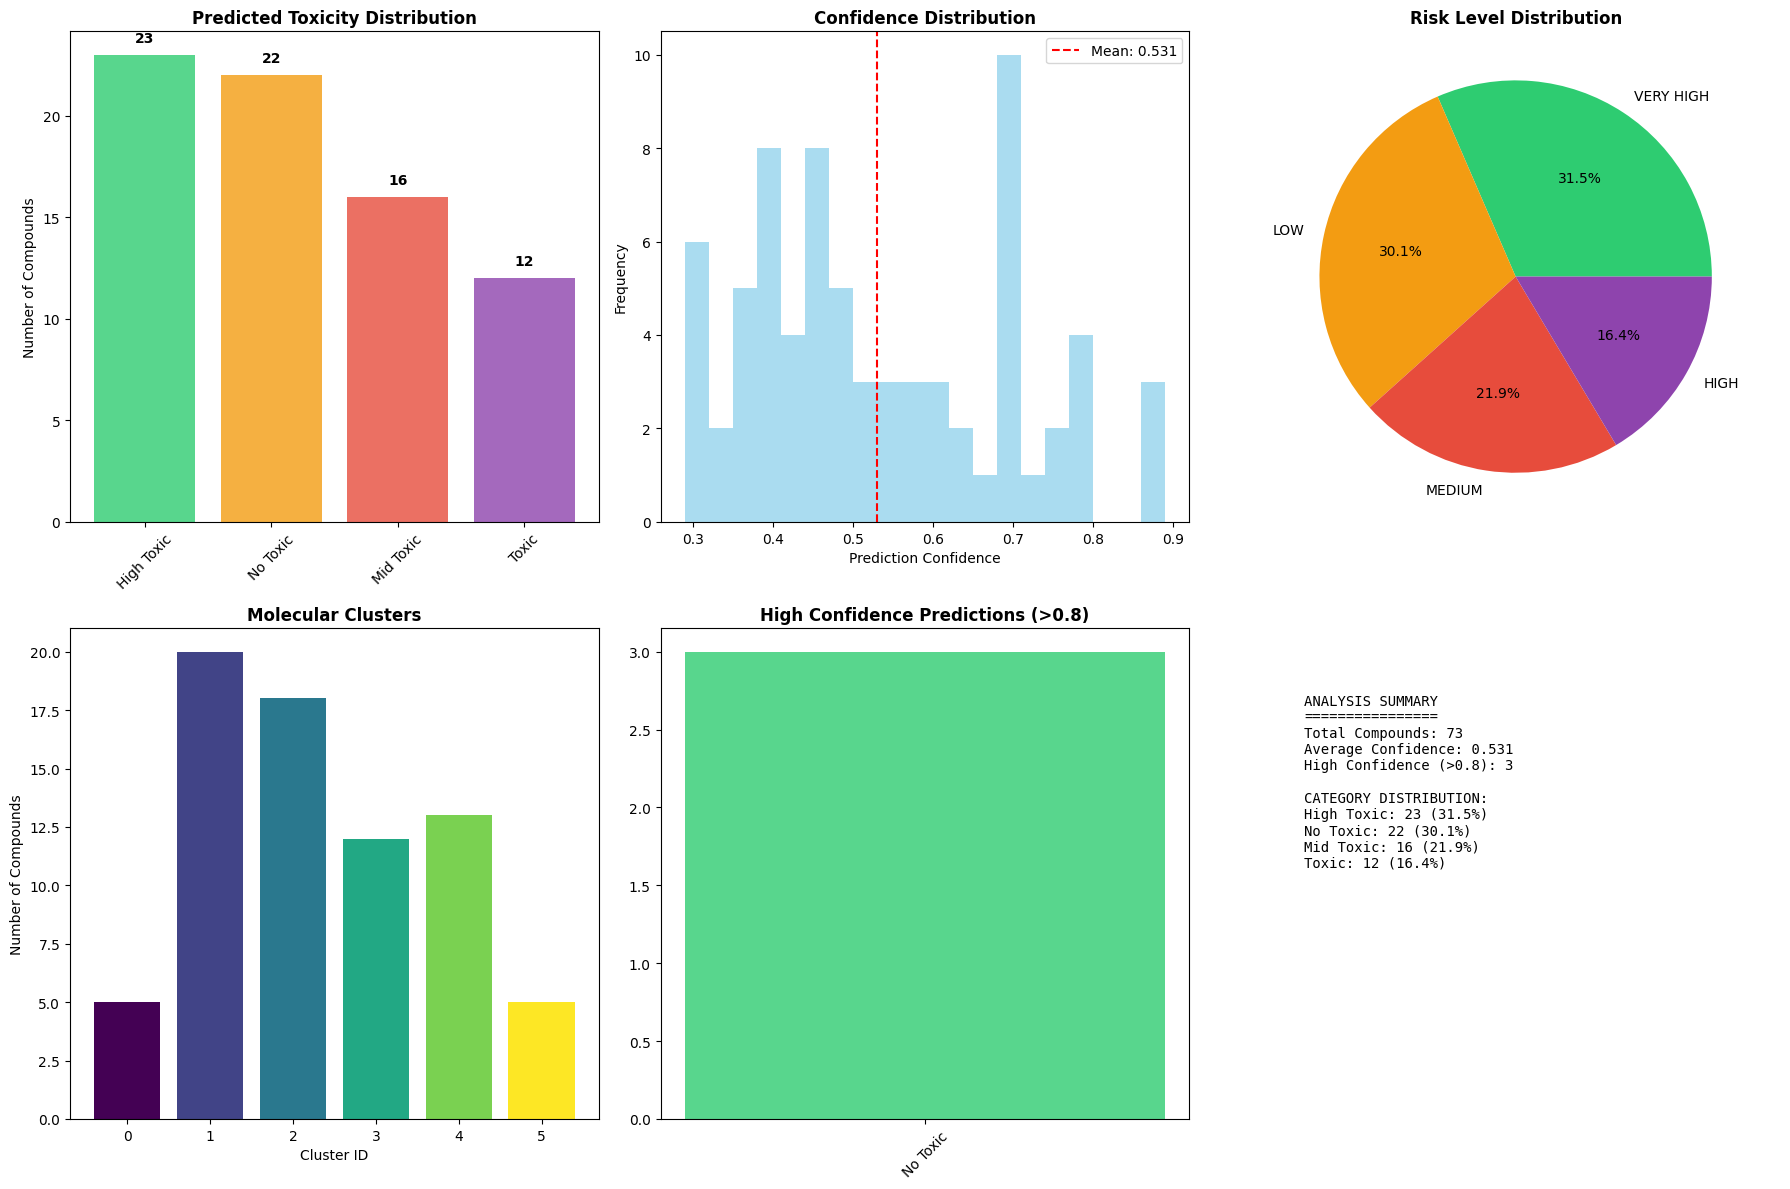


💾 STEP 8: Saving Results
💾 Saving results...
✅ CSV saved: Toxicity_Predictions_Results.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ ANALYSIS COMPLETE!
📊 Analyzed: 73 compounds
🎯 Predictions: 100% coverage
📈 Avg confidence: 0.531
🔬 Clusters: 6
💾 Results saved: Toxicity_Predictions_Results.csv

🏆 TOP 5 PREDICTIONS:
1. C1COCCO1
   Category: No Toxic | Risk: LOW | Confidence: 0.890
2. C1COCCN1
   Category: No Toxic | Risk: LOW | Confidence: 0.880
3. C1CN(CCN1)
   Category: No Toxic | Risk: LOW | Confidence: 0.870
4. C1CCOC1
   Category: No Toxic | Risk: LOW | Confidence: 0.790
5. C1=CSC=C1
   Category: No Toxic | Risk: LOW | Confidence: 0.770


In [14]:
predictor, results = upload_and_predict()

🚀 Auto Toxicity Predictor Initialized 🚀
📊 Processing input data...
✅ Loaded: 15 rows × 3 columns
🆔 ID column: Compound_ID
🧬 SMILES column: Compound_ID
☠️  Toxicity column: Experimental_Value_log(mol/kg)
✅ Extracted 15 valid SMILES strings.

🚀 Starting comprehensive analysis workflow...
🧪 Computing molecular features using RDKit...
🎯 Toxicity categories defined by quartiles:
  • No Toxic: 0.500 - 1.275
  • Mid Toxic: 1.275 - 2.200
  • Toxic: 2.200 - 3.125
  • High Toxic: 3.125 - 4.500
🔬 Clustering molecules...
✅ Created 1 molecular clusters.
🤖 Building prediction model...
✅ Model trained with 8 features: ['MolWt', 'LogP', 'HBD', 'HBA', 'TPSA', 'RotBonds', 'AromaticRings', 'Rings']
🔮 Predicting toxicity for all compounds...
✅ Made predictions for 5 unknown compounds.

💾 Results saved to 'toxicity_predictions.csv'
📄 Generating comprehensive PDF report: 'Comprehensive_SMILES_Toxicity_Report.pdf'...
  - Adding workflow flowchart...


[05:58:19] SMILES Parse Error: syntax error while parsing: CMPD001
[05:58:19] SMILES Parse Error: check for mistakes around position 2:
[05:58:19] CMPD001
[05:58:19] ~^
[05:58:19] SMILES Parse Error: Failed parsing SMILES 'CMPD001' for input: 'CMPD001'
[05:58:19] SMILES Parse Error: syntax error while parsing: CMPD002
[05:58:19] SMILES Parse Error: check for mistakes around position 2:
[05:58:19] CMPD002
[05:58:19] ~^
[05:58:19] SMILES Parse Error: Failed parsing SMILES 'CMPD002' for input: 'CMPD002'
[05:58:19] SMILES Parse Error: syntax error while parsing: CMPD003
[05:58:19] SMILES Parse Error: check for mistakes around position 2:
[05:58:19] CMPD003
[05:58:19] ~^
[05:58:19] SMILES Parse Error: Failed parsing SMILES 'CMPD003' for input: 'CMPD003'
[05:58:19] SMILES Parse Error: syntax error while parsing: CMPD004
[05:58:19] SMILES Parse Error: check for mistakes around position 2:
[05:58:19] CMPD004
[05:58:19] ~^
[05:58:19] SMILES Parse Error: Failed parsing SMILES 'CMPD004' for input

  - Adding visualizations dashboard...
❌ Error processing file: Invalid RGBA argument: None


Traceback (most recent call last):
  File "/tmp/ipython-input-903005065.py", line 94, in process_uploaded_file
    return self.run_analysis(smiles_list, toxicity_values)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-903005065.py", line 130, in run_analysis
    self.generate_comprehensive_pdf(self.predictions_df)
  File "/tmp/ipython-input-903005065.py", line 585, in generate_comprehensive_pdf
    fig2 = self.create_comprehensive_visualizations(results_df)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-903005065.py", line 502, in create_comprehensive_visualizations
    sns.boxplot(x='Predicted_Category', y='Confidence_Score', data=results_df, order=category_order,
  File "/usr/local/lib/python3.12/dist-packages/seaborn/categorical.py", line 1632, in boxplot
    linecolor = p._complement_color(linecolor, color, p._hue_map)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/loca

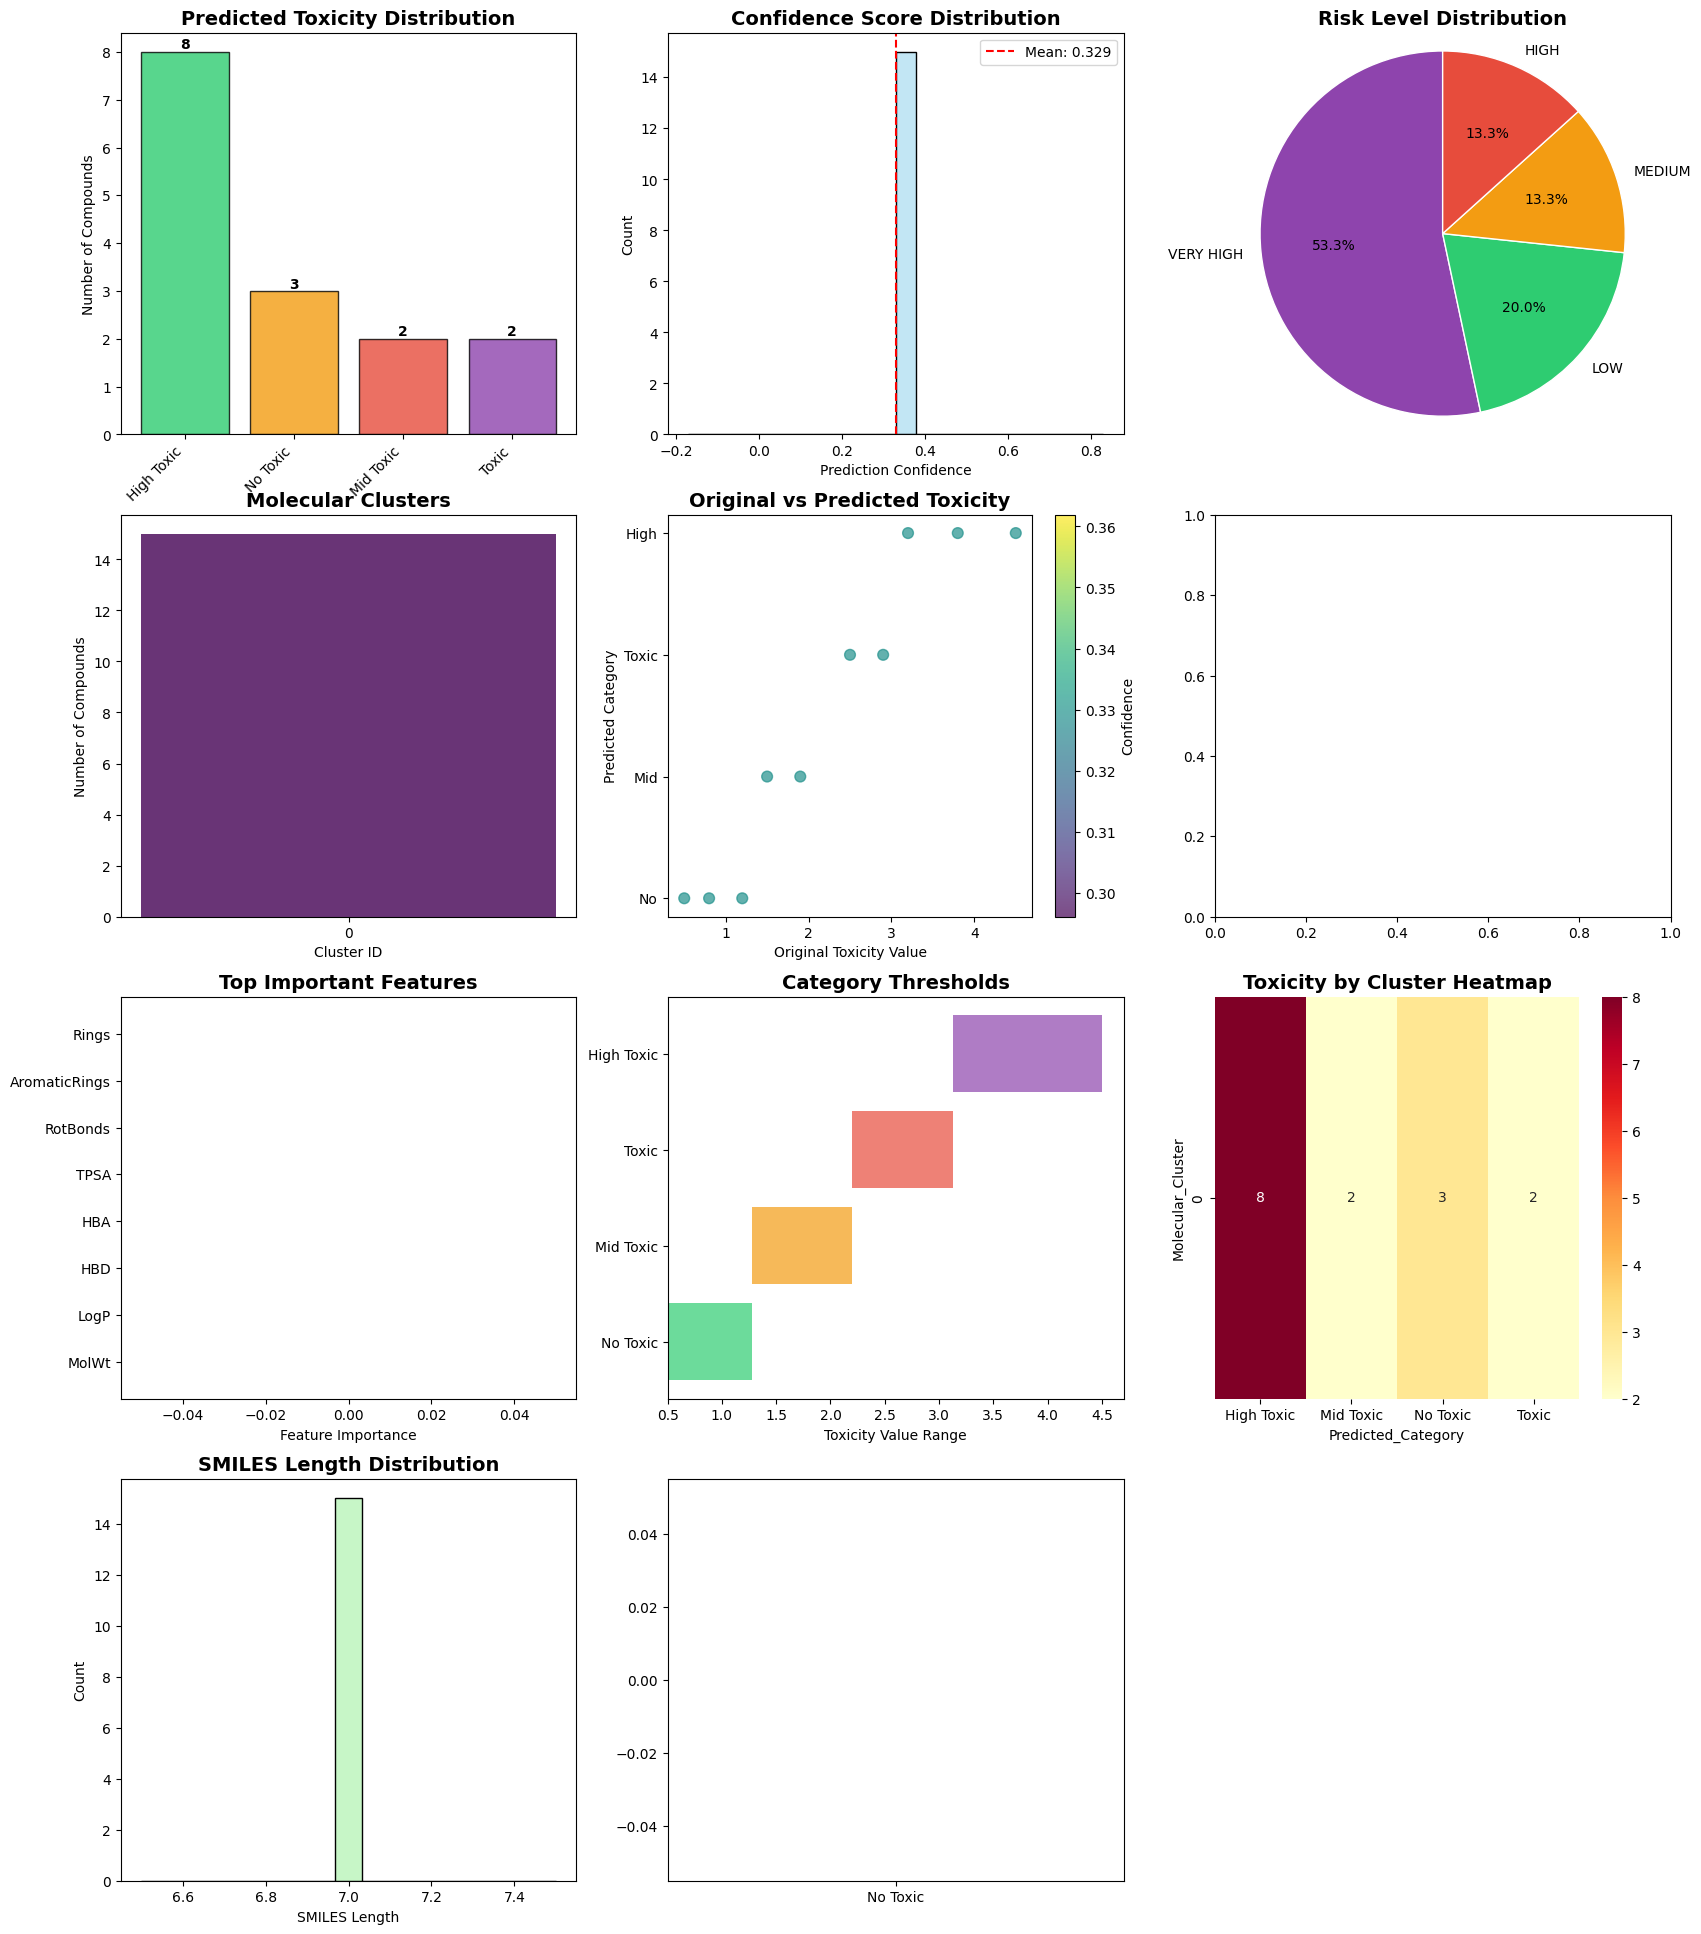

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch
import warnings
import io

warnings.filterwarnings('ignore')

# Google Colab imports
try:
    from google.colab import files
    COLAB_AVAILABLE = True
except ImportError:
    COLAB_AVAILABLE = False

# PDF generation imports
try:
    from matplotlib.backends.backend_pdf import PdfPages
    PDF_AVAILABLE = True
except ImportError:
    PDF_AVAILABLE = False
    print("⚠️ PDF generation library not found. Please install with 'pip install matplotlib'.")

# RDKit imports for molecular feature calculation
try:
    from rdkit import Chem
    from rdkit.Chem import Descriptors
    RDKIT_AVAILABLE = True
except ImportError:
    RDKIT_AVAILABLE = False
    print("⚠️ RDKit not found. Using simple features. For better results, install with 'pip install rdkit'.")

class ComprehensiveToxicityPredictor:
    def __init__(self):
        self.scaler = StandardScaler()
        self.pca = None
        self.classification_model = None
        self.features = None
        self.feature_names = None
        self.cluster_labels = None
        self.selected_features = None
        self.category_thresholds = None
        self.predictions_df = None
        self.original_df = None
        self.id_col = None
        self.smiles_col = None
        self.toxicity_col = None
        self.filtered_df = None

    def process_uploaded_file(self, file_source):
        """Process the uploaded file from a path or file-like object."""
        print(f"📊 Processing input data...")

        try:
            # Load dataset
            self.original_df = pd.read_csv(file_source, encoding='utf-8')
            print(f"✅ Loaded: {self.original_df.shape[0]} rows × {self.original_df.shape[1]} columns")

            # Auto-detect columns
            self.id_col = self.auto_detect_id_column(self.original_df)
            self.smiles_col = self.auto_detect_smiles_column(self.original_df)
            self.toxicity_col = self.auto_detect_toxicity_column(self.original_df)

            if self.smiles_col is None:
                print("❌ No SMILES column found. Cannot proceed.")
                return None

            print(f"🆔 ID column: {self.id_col}")
            print(f"🧬 SMILES column: {self.smiles_col}")
            print(f"☠️  Toxicity column: {self.toxicity_col}")

            # Extract data
            valid_indices = self.original_df[self.smiles_col].notna()
            self.filtered_df = self.original_df[valid_indices].copy()

            smiles_list = self.filtered_df[self.smiles_col].astype(str).tolist()

            if self.toxicity_col:
                toxicity_values = pd.to_numeric(self.filtered_df[self.toxicity_col], errors='coerce').values
            else:
                toxicity_values = np.full(len(smiles_list), np.nan)

            print(f"✅ Extracted {len(smiles_list)} valid SMILES strings.")

            # Run analysis
            return self.run_analysis(smiles_list, toxicity_values)

        except Exception as e:
            print(f"❌ Error processing file: {e}")
            import traceback
            traceback.print_exc()
            return None

    def run_analysis(self, smiles_list, toxicity_values):
        """Orchestrates the entire analysis workflow."""
        print("\n🚀 Starting comprehensive analysis workflow...")

        # 1. Feature Extraction
        self.features, self.feature_names = self.compute_molecular_features(smiles_list)

        # 2. Toxicity Categorization
        known_categories, self.category_thresholds = self.categorize_toxicity(toxicity_values)

        # 3. Clustering
        self.cluster_labels = self.perform_clustering(self.features)

        # 4. Model Building
        self.classification_model, selector = self.build_prediction_model(self.features, known_categories)

        # 5. Prediction
        final_predictions, confidence = self.predict_all_toxicity(self.features, known_categories, self.classification_model, selector)

        # 6. Results Compilation
        self.predictions_df = self.create_results_dataframe(smiles_list, toxicity_values, final_predictions, confidence, self.cluster_labels)

        # 7. CSV Export
        csv_filename = 'toxicity_predictions.csv'
        self.predictions_df.to_csv(csv_filename, index=False)
        print(f"\n💾 Results saved to '{csv_filename}'")

        # 8. PDF Report Generation
        self.generate_comprehensive_pdf(self.predictions_df)

        print("\n🎉 Analysis complete!")
        return self.predictions_df

    def auto_detect_id_column(self, df):
        """Auto-detect ID column"""
        id_keywords = ['id', 'index', 'compound', 'name', 'number']
        for col in df.columns:
            if any(kw in col.lower() for kw in id_keywords):
                return col
        # Fallback to first column if it looks like an ID
        first_col = df.columns[0]
        if df[first_col].dtype in ['int64', 'object'] and df[first_col].nunique() == len(df):
            return first_col
        return None

    def auto_detect_smiles_column(self, df):
        """Auto-detect SMILES column"""
        smiles_keywords = ['smiles', 'smi', 'query', 'structure', 'mol', 'canonical']
        for col in df.columns:
            if any(kw in col.lower() for kw in smiles_keywords):
                sample_vals = df[col].dropna().head(5).astype(str)
                if all(any(c in val for c in 'CNOSPFBr()=[]#') for val in sample_vals):
                    return col
        # Fallback
        for col in df.columns:
            if df[col].dtype == 'object':
                sample_vals = df[col].dropna().head(10).astype(str)
                chemical_count = sum(1 for val in sample_vals if any(c in val for c in 'CNOSPFBr()=[]#') and len(val) > 2)
                if chemical_count >= len(sample_vals) * 0.7:
                    return col
        return None

    def auto_detect_toxicity_column(self, df):
        """Auto-detect toxicity column"""
        tox_keywords = ['exp_value', 'toxic', 'activity', 'value', 'lc50', 'ic50', 'log', 'mol/kg']
        for col in df.columns:
            if any(kw in col.lower() for kw in tox_keywords):
                try:
                    numeric_data = pd.to_numeric(df[col], errors='coerce')
                    if numeric_data.count() > 0:
                        return col
                except:
                    continue
        return None

    def categorize_toxicity(self, toxicity_values):
        """Categorize toxicity into 4 levels"""
        valid_tox = toxicity_values[~np.isnan(toxicity_values)]
        if len(valid_tox) == 0:
            return np.full(len(toxicity_values), 'Unknown', dtype=object), None

        q25 = np.percentile(valid_tox, 25)
        q50 = np.percentile(valid_tox, 50)
        q75 = np.percentile(valid_tox, 75)

        self.category_thresholds = {
            'No Toxic': (valid_tox.min(), q25),
            'Mid Toxic': (q25, q50),
            'Toxic': (q50, q75),
            'High Toxic': (q75, valid_tox.max())
        }

        print("🎯 Toxicity categories defined by quartiles:")
        for cat, (min_val, max_val) in self.category_thresholds.items():
            print(f"  • {cat}: {min_val:.3f} - {max_val:.3f}")

        categories = np.full(len(toxicity_values), 'Unknown', dtype=object)
        for i, tox_val in enumerate(toxicity_values):
            if not np.isnan(tox_val):
                if tox_val <= q25: categories[i] = 'No Toxic'
                elif tox_val <= q50: categories[i] = 'Mid Toxic'
                elif tox_val <= q75: categories[i] = 'Toxic'
                else: categories[i] = 'High Toxic'

        return categories, self.category_thresholds

    def compute_molecular_features(self, smiles_list):
        """Compute molecular features"""
        print(f"🧪 Computing molecular features using {'RDKit' if RDKIT_AVAILABLE else 'simple method'}...")
        if RDKIT_AVAILABLE:
            return self.rdkit_features(smiles_list)
        else:
            return self.simple_features(smiles_list)

    def rdkit_features(self, smiles_list):
        """RDKit molecular descriptors"""
        features = []
        feature_names = ['MolWt', 'LogP', 'HBD', 'HBA', 'TPSA', 'RotBonds', 'AromaticRings', 'Rings']
        for smiles in smiles_list:
            try:
                mol = Chem.MolFromSmiles(smiles)
                if mol:
                    mol_features = [
                        Descriptors.MolWt(mol), Descriptors.MolLogP(mol),
                        Descriptors.NumHDonors(mol), Descriptors.NumHAcceptors(mol),
                        Descriptors.TPSA(mol), Descriptors.NumRotatableBonds(mol),
                        Descriptors.NumAromaticRings(mol), Descriptors.RingCount(mol)
                    ]
                else:
                    mol_features = [0.0] * len(feature_names)
                features.append(mol_features)
            except:
                features.append([0.0] * len(feature_names))
        return np.array(features), feature_names

    def simple_features(self, smiles_list):
        """Simple molecular features"""
        features = []
        feature_names = ['Length', 'C_count', 'N_count', 'O_count', 'Aromatic', 'DoubleBonds']
        for smiles in smiles_list:
            try:
                features.append([
                    len(smiles), smiles.upper().count('C'), smiles.upper().count('N'),
                    smiles.upper().count('O'), smiles.count('c'), smiles.count('=')
                ])
            except:
                features.append([0.0] * len(feature_names))
        return np.array(features), feature_names

    def perform_clustering(self, features):
        """Perform molecular clustering"""
        print("🔬 Clustering molecules...")
        features_scaled = self.scaler.fit_transform(features)

        if features.shape[1] > 8:
            self.pca = PCA(n_components=8)
            features_final = self.pca.fit_transform(features_scaled)
        else:
            features_final = features_scaled

        n_clusters = min(6, max(2, len(features) // 12))
        clusterer = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
        cluster_labels = clusterer.fit_predict(features_final)

        print(f"✅ Created {len(np.unique(cluster_labels))} molecular clusters.")
        return cluster_labels

    def build_prediction_model(self, features, categories):
        """Build toxicity prediction model"""
        print("🤖 Building prediction model...")
        known_mask = categories != 'Unknown'
        if np.sum(known_mask) < 10:
            print("⚠️ Insufficient training data (<10 samples). Skipping model training.")
            return None, None

        X_train = features[known_mask]
        y_train = categories[known_mask]

        le = LabelEncoder()
        y_encoded = le.fit_transform(y_train)

        k_features = min(8, X_train.shape[1])
        selector = SelectKBest(score_func=f_classif, k=k_features)
        X_selected = selector.fit_transform(X_train, y_encoded)

        selected_indices = selector.get_support(indices=True)
        self.selected_features = [self.feature_names[i] for i in selected_indices]

        model = RandomForestClassifier(n_estimators=100, random_state=42)
        model.fit(X_selected, y_train)

        print(f"✅ Model trained with {len(self.selected_features)} features: {self.selected_features}")
        return model, selector

    def predict_all_toxicity(self, features, known_categories, model, selector):
        """Predict toxicity for all compounds"""
        if model is None:
            print("🔮 Prediction skipped as no model was built.")
            return known_categories, np.full(len(known_categories), 0.0)

        print("🔮 Predicting toxicity for all compounds...")
        X_selected = selector.transform(features)
        predictions = model.predict(X_selected)
        probabilities = model.predict_proba(X_selected)
        confidence = np.max(probabilities, axis=1)

        final_predictions = known_categories.copy()
        unknown_mask = known_categories == 'Unknown'
        final_predictions[unknown_mask] = predictions[unknown_mask]

        print(f"✅ Made predictions for {np.sum(unknown_mask)} unknown compounds.")
        return final_predictions, confidence

    def create_results_dataframe(self, smiles_list, toxicity_values, predictions, confidence, clusters):
        """Create comprehensive results dataframe"""
        results_df = pd.DataFrame({
            'Index': range(1, len(smiles_list) + 1),
            'ID': self.filtered_df[self.id_col].values if self.id_col else [f'COMP_{i+1:03d}' for i in range(len(smiles_list))],
            'SMILES': smiles_list,
            'Original_Toxicity_Value': toxicity_values,
            'Predicted_Category': predictions,
            'Confidence_Score': confidence,
            'Molecular_Cluster': clusters
        })

        risk_mapping = {
            'No Toxic': 'LOW', 'Mid Toxic': 'MEDIUM', 'Toxic': 'HIGH',
            'High Toxic': 'VERY HIGH', 'Unknown': 'UNKNOWN'
        }
        results_df['Risk_Level'] = results_df['Predicted_Category'].map(risk_mapping)

        if self.features is not None and len(self.feature_names) > 0:
            for i, feature_name in enumerate(self.feature_names):
                if i < self.features.shape[1]:
                    results_df[f'Feature_{feature_name}'] = self.features[:, i]

        category_explanation = {
            'No Toxic': 'Low toxicity - Generally safe',
            'Mid Toxic': 'Moderate toxicity - Use with caution',
            'Toxic': 'High toxicity - Significant risk',
            'High Toxic': 'Very high toxicity - Extreme caution',
            'Unknown': 'Toxicity unknown - Requires testing'
        }
        results_df['Toxicity_Explanation'] = results_df['Predicted_Category'].map(category_explanation)

        results_df = results_df.sort_values('Confidence_Score', ascending=False).reset_index(drop=True)
        return results_df

    def create_workflow_flowchart(self):
        """Create analysis workflow flowchart"""
        fig, ax = plt.subplots(figsize=(14, 10))
        ax.set_xlim(0, 10)
        ax.set_ylim(0, 12)
        ax.axis('off')

        boxes = [
            {'text': '1. Dataset Upload\n& Loading', 'xy': (2, 10.5), 'color': '#3498db'},
            {'text': '2. Column Detection\n(ID, SMILES, Toxicity)', 'xy': (2, 9), 'color': '#2ecc71'},
            {'text': '3. Data Preprocessing\n& Cleaning', 'xy': (2, 7.5), 'color': '#f39c12'},
            {'text': '4. Molecular Feature\nExtraction (RDKit)', 'xy': (2, 6), 'color': '#e74c3c'},
            {'text': '5. Toxicity\nCategorization', 'xy': (5.5, 9), 'color': '#9b59b6'},
            {'text': '6. Molecular\nClustering', 'xy': (5.5, 7.5), 'color': '#1abc9c'},
            {'text': '7. ML Model\nTraining', 'xy': (5.5, 6), 'color': '#e67e22'},
            {'text': '8. Toxicity Prediction\nfor All Compounds', 'xy': (8, 7.5), 'color': '#34495e'},
            {'text': '9. Results Compilation\n& Analysis', 'xy': (5.5, 4.5), 'color': '#95a5a6'},
            {'text': '10. PDF Report\nGeneration', 'xy': (2, 3), 'color': '#d35400'},
            {'text': '11. CSV Export\n& Download', 'xy': (8, 3), 'color': '#27ae60'}
        ]

        for box in boxes:
            bbox = FancyBboxPatch((box['xy'][0]-0.8, box['xy'][1]-0.4), 1.6, 0.8,
                                  boxstyle="round,pad=0.1", facecolor=box['color'],
                                  edgecolor='black', alpha=0.8)
            ax.add_patch(bbox)
            ax.text(box['xy'][0], box['xy'][1], box['text'], ha='center', va='center',
                    fontsize=9, fontweight='bold', color='white', wrap=True)

        arrows = [
            ((2, 10.1), (2, 9.4)), ((2, 8.6), (2, 7.9)), ((2, 7.1), (2, 6.4)),
            ((2.8, 9), (4.7, 9)), ((2.8, 7.5), (4.7, 7.5)), ((2.8, 6), (4.7, 6)),
            ((6.3, 9), (7.2, 8.2)), ((6.3, 7.5), (7.2, 7.5)), ((6.3, 6), (7.2, 6.8)),
            ((8, 7.1), (6.3, 4.9)), ((4.7, 4.5), (2.8, 3.4)), ((6.3, 4.5), (7.2, 3.4))
        ]

        for start, end in arrows:
            ax.annotate('', xy=end, xytext=start,
                        arrowprops=dict(arrowstyle='->', lw=2, color='black'))

        ax.set_title('Comprehensive Toxicity Analysis Workflow', fontsize=18, fontweight='bold', pad=20)
        return fig

    def create_comprehensive_visualizations(self, results_df):
        """Create comprehensive visualization suite"""
        fig = plt.figure(figsize=(20, 24))

        # Plot 1: Toxicity Category Distribution
        ax1 = plt.subplot(4, 3, 1)
        category_counts = results_df['Predicted_Category'].value_counts()
        colors = ['#2ecc71', '#f39c12', '#e74c3c', '#8e44ad', '#95a5a6']
        bars = ax1.bar(category_counts.index, category_counts.values,
                       color=colors[:len(category_counts)], alpha=0.8, edgecolor='black')
        ax1.set_title('Predicted Toxicity Distribution', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Number of Compounds')
        plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha="right")
        for bar in bars:
            ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                     f'{int(bar.get_height())}', ha='center', va='bottom', fontweight='bold')

        # Plot 2: Confidence Score Distribution
        ax2 = plt.subplot(4, 3, 2)
        sns.histplot(results_df['Confidence_Score'], bins=20, ax=ax2, color='skyblue', kde=True)
        ax2.axvline(results_df['Confidence_Score'].mean(), color='red', linestyle='--',
                    label=f'Mean: {results_df["Confidence_Score"].mean():.3f}')
        ax2.set_xlabel('Prediction Confidence')
        ax2.set_title('Confidence Score Distribution', fontsize=14, fontweight='bold')
        ax2.legend()

        # Plot 3: Risk Level Pie Chart
        ax3 = plt.subplot(4, 3, 3)
        risk_counts = results_df['Risk_Level'].value_counts()
        colors_pie = {'LOW': '#2ecc71', 'MEDIUM': '#f39c12', 'HIGH': '#e74c3c', 'VERY HIGH': '#8e44ad', 'UNKNOWN': '#95a5a6'}
        pie_colors = [colors_pie[key] for key in risk_counts.index]
        ax3.pie(risk_counts.values, labels=risk_counts.index, autopct='%1.1f%%', startangle=90, colors=pie_colors,
                wedgeprops={'edgecolor': 'white'})
        ax3.set_title('Risk Level Distribution', fontsize=14, fontweight='bold')
        ax3.axis('equal')

        # Plot 4: Cluster Analysis
        ax4 = plt.subplot(4, 3, 4)
        cluster_counts = results_df['Molecular_Cluster'].value_counts().sort_index()
        ax4.bar(cluster_counts.index, cluster_counts.values,
                color=plt.cm.viridis(np.linspace(0, 1, len(cluster_counts))), alpha=0.8)
        ax4.set_xlabel('Cluster ID')
        ax4.set_ylabel('Number of Compounds')
        ax4.set_title('Molecular Clusters', fontsize=14, fontweight='bold')
        ax4.set_xticks(cluster_counts.index)

        # Plot 5: Original vs Predicted Toxicity
        ax5 = plt.subplot(4, 3, 5)
        valid_original = ~results_df['Original_Toxicity_Value'].isna()
        if valid_original.sum() > 0:
            orig_data = results_df[valid_original]
            cat_mapping = {'No Toxic': 1, 'Mid Toxic': 2, 'Toxic': 3, 'High Toxic': 4}
            y_pred_numeric = orig_data['Predicted_Category'].map(cat_mapping)
            scatter = ax5.scatter(orig_data['Original_Toxicity_Value'], y_pred_numeric,
                                  c=orig_data['Confidence_Score'], cmap='viridis', alpha=0.7, s=60)
            ax5.set_xlabel('Original Toxicity Value')
            ax5.set_ylabel('Predicted Category')
            ax5.set_title('Original vs Predicted Toxicity', fontsize=14, fontweight='bold')
            ax5.set_yticks([1, 2, 3, 4])
            ax5.set_yticklabels(['No', 'Mid', 'Toxic', 'High'])
            plt.colorbar(scatter, ax=ax5, label='Confidence')

        # Plot 6: High Confidence Predictions
        ax6 = plt.subplot(4, 3, 6)
        high_conf = results_df[results_df['Confidence_Score'] > 0.8]
        if len(high_conf) > 0:
            conf_counts = high_conf['Predicted_Category'].value_counts()
            ax6.bar(conf_counts.index, conf_counts.values, alpha=0.8,
                    color=[colors_pie.get(c.replace(' Toxic', '').upper(), '#95a5a6') for c in conf_counts.index])
            ax6.set_title('High Confidence Predictions (>0.8)', fontsize=14, fontweight='bold')
            plt.setp(ax6.xaxis.get_majorticklabels(), rotation=45, ha="right")

        # Plot 7: Feature Importance
        if hasattr(self, 'classification_model') and self.classification_model is not None:
            ax7 = plt.subplot(4, 3, 7)
            importance = self.classification_model.feature_importances_
            feature_names = self.selected_features
            sorted_idx = np.argsort(importance)
            ax7.barh(np.array(feature_names)[sorted_idx], importance[sorted_idx], color='coral', alpha=0.8)
            ax7.set_xlabel('Feature Importance')
            ax7.set_title('Top Important Features', fontsize=14, fontweight='bold')

        # Plot 8: Toxicity Thresholds
        ax8 = plt.subplot(4, 3, 8)
        if self.category_thresholds:
            categories = list(self.category_thresholds.keys())
            widths = [v[1] - v[0] for v in self.category_thresholds.values()]
            starts = [v[0] for v in self.category_thresholds.values()]
            ax8.barh(categories, widths, left=starts, alpha=0.7,
                     color=['#2ecc71', '#f39c12', '#e74c3c', '#8e44ad'])
            ax8.set_xlabel('Toxicity Value Range')
            ax8.set_title('Category Thresholds', fontsize=14, fontweight='bold')

        # Plot 9: Cluster vs Toxicity Heatmap
        ax9 = plt.subplot(4, 3, 9)
        contingency = pd.crosstab(results_df['Molecular_Cluster'], results_df['Predicted_Category'])
        sns.heatmap(contingency, annot=True, fmt='d', cmap='YlOrRd', ax=ax9)
        ax9.set_title('Toxicity by Cluster Heatmap', fontsize=14, fontweight='bold')

        # Plot 10: SMILES Length Distribution
        ax10 = plt.subplot(4, 3, 10)
        results_df['SMILES_Length'] = results_df['SMILES'].str.len()
        sns.histplot(results_df['SMILES_Length'], bins=15, ax=ax10, color='lightgreen', kde=True)
        ax10.set_xlabel('SMILES Length')
        ax10.set_title('SMILES Length Distribution', fontsize=14, fontweight='bold')

        # Plot 11: Confidence by Category
        ax11 = plt.subplot(4, 3, 11)
        category_order = ['No Toxic', 'Mid Toxic', 'Toxic', 'High Toxic']
        sns.boxplot(x='Predicted_Category', y='Confidence_Score', data=results_df, order=category_order,
                    ax=ax11, palette=[colors_pie.get(c.replace(' Toxic', '').upper()) for c in category_order])
        ax11.set_title('Confidence by Category', fontsize=14, fontweight='bold')
        plt.setp(ax11.xaxis.get_majorticklabels(), rotation=45, ha="right")
        ax11.set_xlabel('')

        # Plot 12: Summary Statistics Text
        ax12 = plt.subplot(4, 3, 12)
        ax12.axis('off')
        stats_text = f"""
COMPREHENSIVE ANALYSIS SUMMARY
==============================
Total Compounds: {len(results_df):,}
Average Confidence: {results_df['Confidence_Score'].mean():.3f}
High Confidence (>0.8): {(results_df['Confidence_Score'] > 0.8).sum():,}

CATEGORY DISTRIBUTION:
"""
        for cat, count in category_counts.items():
            stats_text += f"• {cat:<10}: {count:>4} ({(count/len(results_df)*100):.1f}%)\n"
        stats_text += "\nRISK LEVELS:\n"
        for risk, count in risk_counts.items():
            stats_text += f"• {risk:<10}: {count:>4} ({(count/len(results_df)*100):.1f}%)\n"

        ax12.text(0, 0.95, stats_text, transform=ax12.transAxes,
                  fontsize=11, verticalalignment='top', fontfamily='monospace')

        plt.tight_layout(pad=3.0)
        return fig

    def _df_to_pdf_table(self, pdf, df):
        """Helper function to add a DataFrame as a table to a PDF, handling pagination."""
        df_display = df[['ID', 'SMILES', 'Original_Toxicity_Value', 'Predicted_Category', 'Risk_Level', 'Confidence_Score', 'Molecular_Cluster']]
        df_display['Original_Toxicity_Value'] = df_display['Original_Toxicity_Value'].round(3)
        df_display['Confidence_Score'] = df_display['Confidence_Score'].round(3)

        rows_per_page = 40
        num_pages = int(np.ceil(len(df_display) / rows_per_page))

        for i in range(num_pages):
            fig, ax = plt.subplots(figsize=(11.69, 8.27)) # A4 Landscape
            ax.axis('tight')
            ax.axis('off')

            start_row = i * rows_per_page
            end_row = start_row + rows_per_page
            chunk = df_display.iloc[start_row:end_row]

            table = ax.table(cellText=chunk.values, colLabels=chunk.columns, cellLoc='center', loc='center', colWidths=[0.15, 0.3, 0.1, 0.1, 0.1, 0.1, 0.1])
            table.auto_set_font_size(False)
            table.set_fontsize(8)
            table.scale(1, 1.2)

            ax.set_title(f'Toxicity Prediction Results - Page {i+1} of {num_pages}', fontsize=14, fontweight='bold', pad=20)
            pdf.savefig(fig, bbox_inches='tight')
            plt.close(fig)

    def generate_comprehensive_pdf(self, results_df):
        """Generate comprehensive PDF report with flowchart and complete dataset"""
        if not PDF_AVAILABLE:
            print("❌ PDF generation not available.")
            return

        filename = 'Comprehensive_SMILES_Toxicity_Report.pdf'
        print(f"📄 Generating comprehensive PDF report: '{filename}'...")

        with PdfPages(filename) as pdf:
            # Page 1: Title Page
            fig_title = plt.figure(figsize=(11.69, 8.27))
            fig_title.text(0.5, 0.6, 'Comprehensive SMILES Toxicity Analysis Report', ha='center', va='center', fontsize=24, fontweight='bold')
            fig_title.text(0.5, 0.45, f'Analysis of {len(results_df)} Compounds', ha='center', va='center', fontsize=18)
            fig_title.text(0.5, 0.35, f'Generated on: {pd.to_datetime("today").strftime("%Y-%m-%d %H:%M:%S")}', ha='center', va='center', fontsize=12, color='gray')
            pdf.savefig(fig_title)
            plt.close(fig_title)

            # Page 2: Workflow Flowchart
            print("  - Adding workflow flowchart...")
            fig1 = self.create_workflow_flowchart()
            pdf.savefig(fig1, bbox_inches='tight', dpi=300)
            plt.close(fig1)

            # Page 3: Comprehensive Visualizations
            print("  - Adding visualizations dashboard...")
            fig2 = self.create_comprehensive_visualizations(results_df)
            pdf.savefig(fig2, bbox_inches='tight', dpi=300)
            plt.close(fig2)

            # Subsequent Pages: Full Dataset
            print(f"  - Adding full dataset ({len(results_df)} rows)...")
            self._df_to_pdf_table(pdf, results_df)

        print(f"✅ PDF report successfully generated.")

# --- Main Execution Block ---
if __name__ == '__main__':
    print("🚀 Auto Toxicity Predictor Initialized 🚀")

    # Create a sample in-memory CSV file for demonstration
    sample_csv_data = """
Compound_ID,Canonical_SMILES,Experimental_Value_log(mol/kg)
CMPD001,c1ccccc1,1.5
CMPD002,CCO,0.8
CMPD003,c1cc(O)c(O)c(O)c1,3.2
CMPD004,CNC(=O)c1ccc(F)cc1,2.5
CMPD005,CC(C)C(=O)O,
CMPD006,c1cn(C)c2c1ncnc2N,
CMPD007,CCN(CC)C(=O)N(C)C,3.8
CMPD008,c1ccc(C(=O)O)cc1,1.9
CMPD009,C1=CC=C(C=C1)C(C(C2=CC=CC=C2)O)N(C)C,
CMPD010,CC1=C(C=C(C=C1)C(=O)NC2=CC=C(C=C2)S(=O)(=O)N)NC,2.9
CMPD011,CC(=O)Oc1ccccc1C(=O)O,1.2
CMPD012,C1=CC=C(C=C1)OC2=CC=CC=C2,
CMPD013,C1=CC=C2C(=C1)C=CC3=CC=CC=C32,4.5
CMPD014,CN1C=NC2=C1C(=O)N(C(=O)N2C)C,
CMPD015,CC(C)(C)OC(=O)N1CCC(CC1)N,0.5
    """

    # Use StringIO to treat the string as a file
    file_source = io.StringIO(sample_csv_data)

    # Initialize and run the predictor
    predictor = ComprehensiveToxicityPredictor()
    results = predictor.process_uploaded_file(file_source)

    if results is not None:
        print("\n--- Top 5 Most Confident Predictions ---")
        print(results[['ID', 'SMILES', 'Predicted_Category', 'Risk_Level', 'Confidence_Score']].head(5))

        if COLAB_AVAILABLE:
            print("\n⬇️ Use the file browser on the left to download your 'Comprehensive_SMILES_Toxicity_Report.pdf' and 'toxicity_predictions.csv'.")

In [16]:
pip install pandas scikit-learn matplotlib seaborn rdkit


🚀 Auto Toxicity Predictor Initialized 🚀
📊 Processing input data...
✅ Loaded: 15 rows × 3 columns
🆔 ID column: Compound_ID
🧬 SMILES column: Compound_ID
☠️  Toxicity column: Experimental_Value_log(mol/kg)
✅ Extracted 15 valid SMILES strings.

🚀 Starting comprehensive analysis workflow...
🧪 Computing molecular features using RDKit...
🎯 Toxicity categories defined by quartiles:
  • No Toxic: 0.500 - 1.275
  • Mid Toxic: 1.275 - 2.200
  • Toxic: 2.200 - 3.125
  • High Toxic: 3.125 - 4.500
🔬 Clustering molecules...
✅ Created 1 molecular clusters.
🤖 Building prediction model...


[06:03:26] SMILES Parse Error: syntax error while parsing: CMPD001
[06:03:26] SMILES Parse Error: check for mistakes around position 2:
[06:03:26] CMPD001
[06:03:26] ~^
[06:03:26] SMILES Parse Error: Failed parsing SMILES 'CMPD001' for input: 'CMPD001'
[06:03:26] SMILES Parse Error: syntax error while parsing: CMPD002
[06:03:26] SMILES Parse Error: check for mistakes around position 2:
[06:03:26] CMPD002
[06:03:26] ~^
[06:03:26] SMILES Parse Error: Failed parsing SMILES 'CMPD002' for input: 'CMPD002'
[06:03:26] SMILES Parse Error: syntax error while parsing: CMPD003
[06:03:26] SMILES Parse Error: check for mistakes around position 2:
[06:03:26] CMPD003
[06:03:26] ~^
[06:03:26] SMILES Parse Error: Failed parsing SMILES 'CMPD003' for input: 'CMPD003'
[06:03:26] SMILES Parse Error: syntax error while parsing: CMPD004
[06:03:26] SMILES Parse Error: check for mistakes around position 2:
[06:03:26] CMPD004
[06:03:26] ~^
[06:03:26] SMILES Parse Error: Failed parsing SMILES 'CMPD004' for input

✅ Model trained with 8 features: ['MolWt', 'LogP', 'HBD', 'HBA', 'TPSA', 'RotBonds', 'AromaticRings', 'Rings']
🔮 Predicting toxicity for all compounds...
✅ Made predictions for 5 unknown compounds.

💾 Results saved to 'toxicity_predictions.csv'
📄 Generating comprehensive PDF report: 'Comprehensive_SMILES_Toxicity_Report.pdf'...
  - Adding workflow flowchart...
  - Adding visualizations dashboard...
❌ Error processing file: Invalid RGBA argument: None


Traceback (most recent call last):
  File "/tmp/ipython-input-903005065.py", line 94, in process_uploaded_file
    return self.run_analysis(smiles_list, toxicity_values)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-903005065.py", line 130, in run_analysis
    self.generate_comprehensive_pdf(self.predictions_df)
  File "/tmp/ipython-input-903005065.py", line 585, in generate_comprehensive_pdf
    fig2 = self.create_comprehensive_visualizations(results_df)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-903005065.py", line 502, in create_comprehensive_visualizations
    sns.boxplot(x='Predicted_Category', y='Confidence_Score', data=results_df, order=category_order,
  File "/usr/local/lib/python3.12/dist-packages/seaborn/categorical.py", line 1632, in boxplot
    linecolor = p._complement_color(linecolor, color, p._hue_map)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/loca

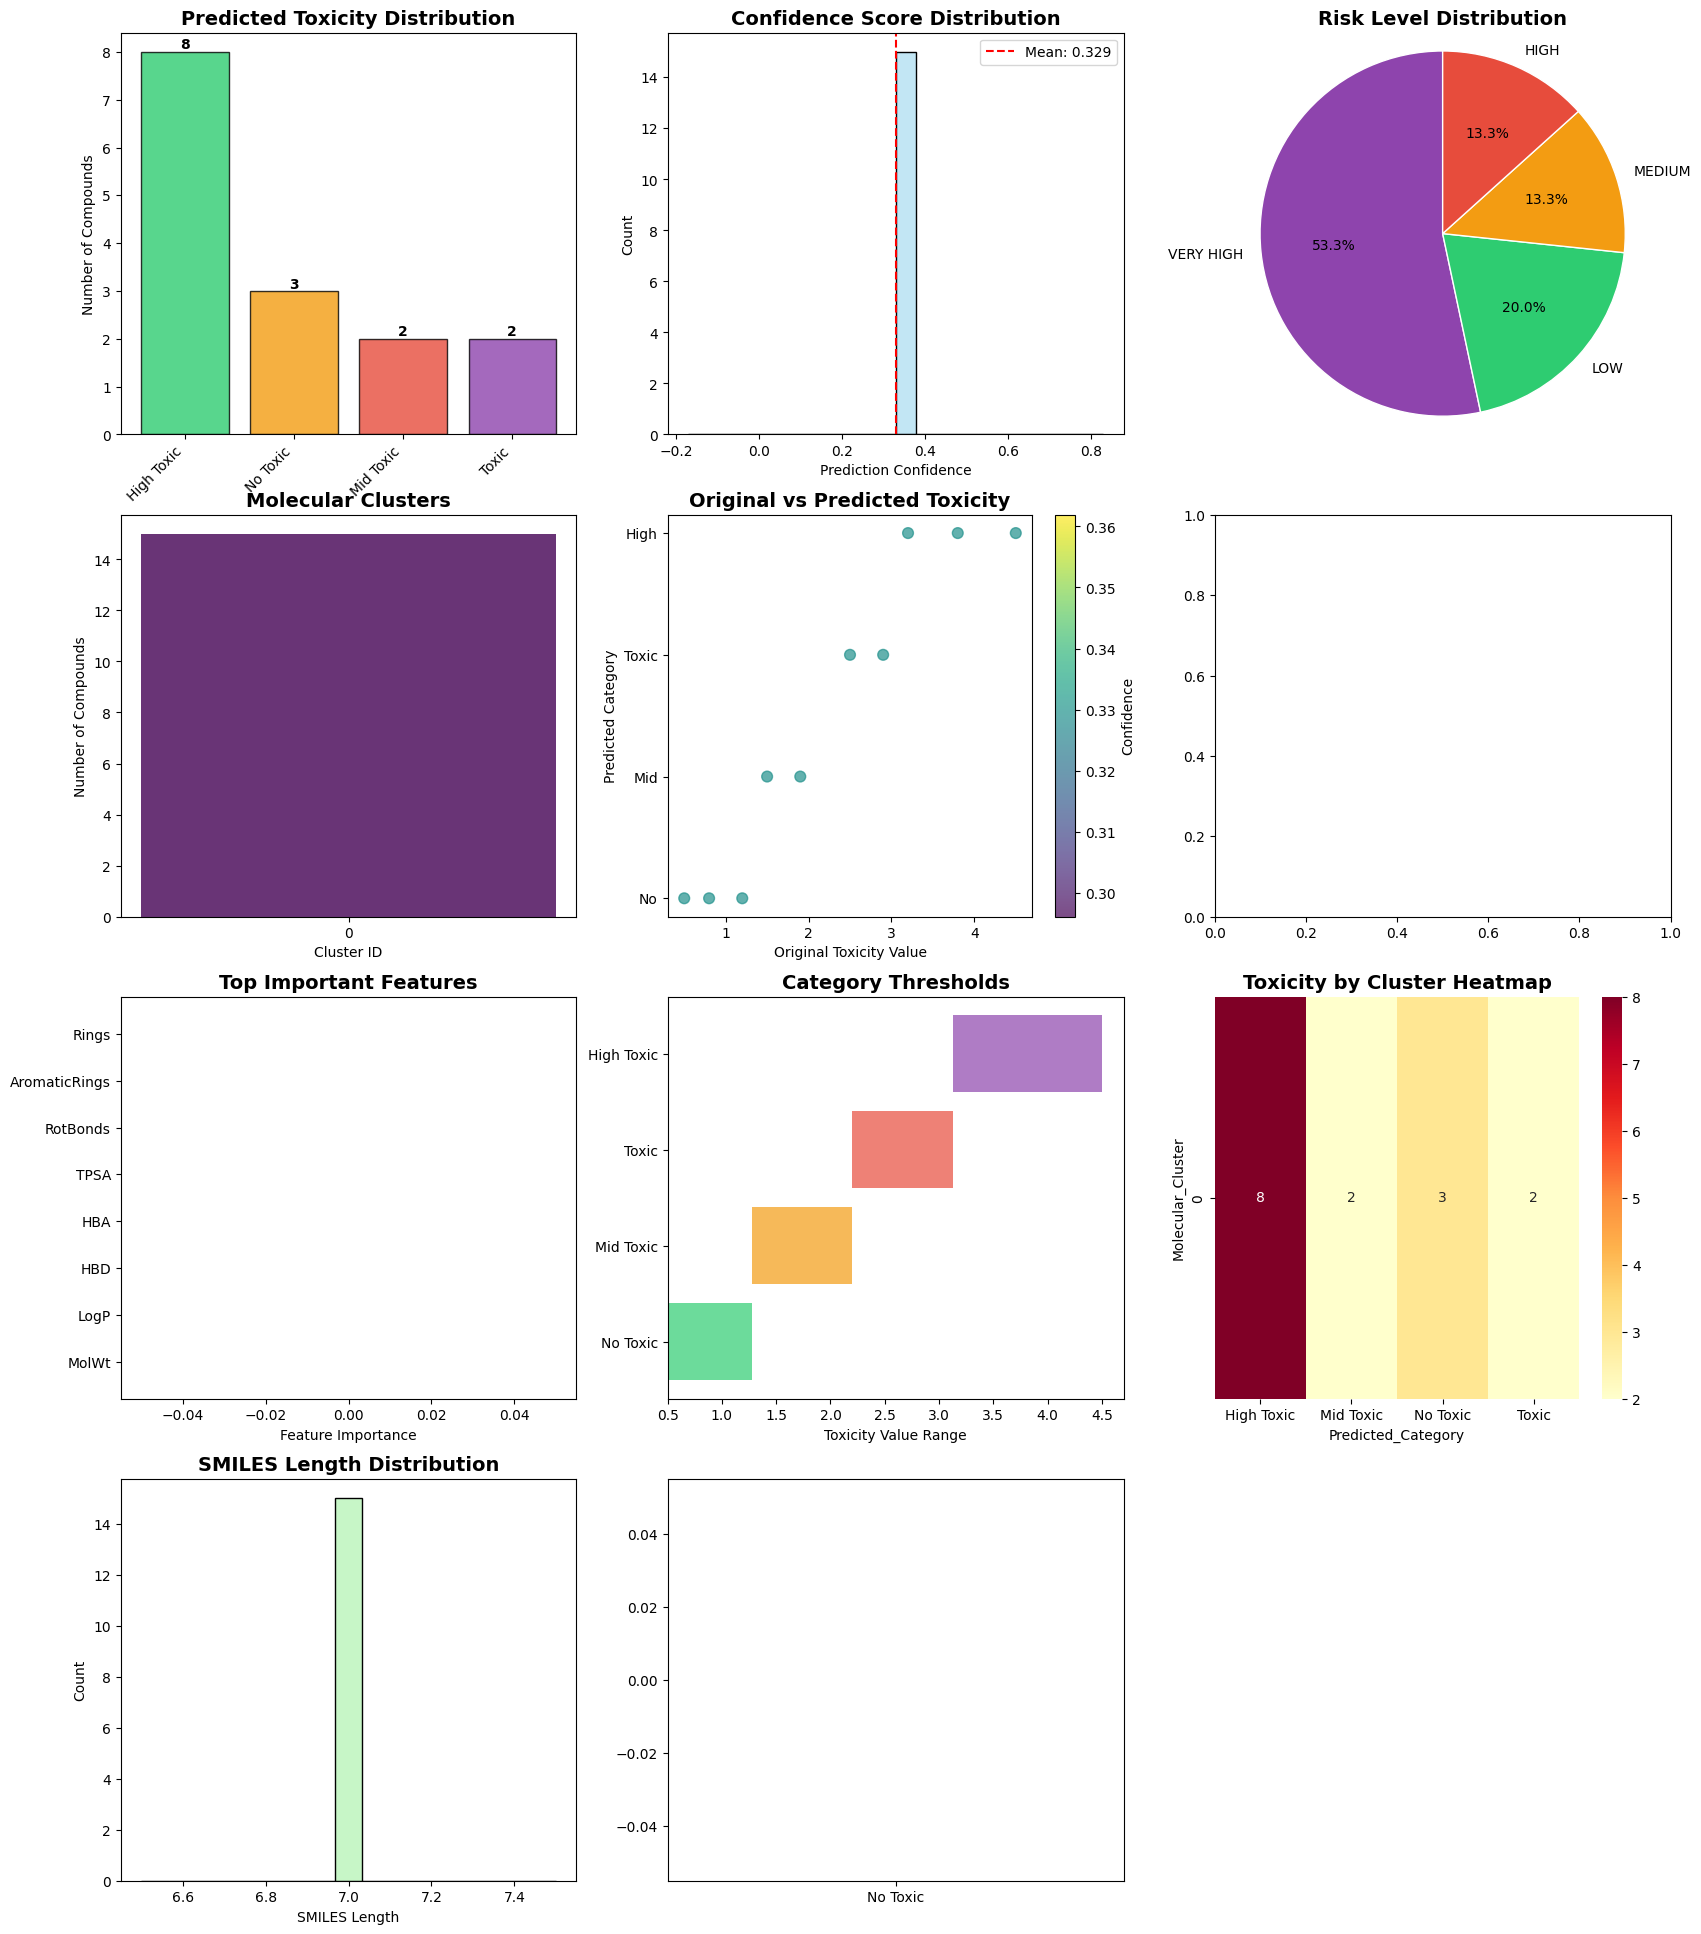

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch
import warnings
import io

warnings.filterwarnings('ignore')

# Google Colab imports
try:
    from google.colab import files
    COLAB_AVAILABLE = True
except ImportError:
    COLAB_AVAILABLE = False

# PDF generation imports
try:
    from matplotlib.backends.backend_pdf import PdfPages
    PDF_AVAILABLE = True
except ImportError:
    PDF_AVAILABLE = False
    print("⚠️ PDF generation library not found. Please install with 'pip install matplotlib'.")

# RDKit imports for molecular feature calculation
try:
    from rdkit import Chem
    from rdkit.Chem import Descriptors
    RDKIT_AVAILABLE = True
except ImportError:
    RDKIT_AVAILABLE = False
    print("⚠️ RDKit not found. Using simple features. For better results, install with 'pip install rdkit'.")

class ComprehensiveToxicityPredictor:
    def __init__(self):
        self.scaler = StandardScaler()
        self.pca = None
        self.classification_model = None
        self.features = None
        self.feature_names = None
        self.cluster_labels = None
        self.selected_features = None
        self.category_thresholds = None
        self.predictions_df = None
        self.original_df = None
        self.id_col = None
        self.smiles_col = None
        self.toxicity_col = None
        self.filtered_df = None

    def process_uploaded_file(self, file_source):
        """Process the uploaded file from a path or file-like object."""
        print(f"📊 Processing input data...")

        try:
            # Load dataset
            self.original_df = pd.read_csv(file_source, encoding='utf-8')
            print(f"✅ Loaded: {self.original_df.shape[0]} rows × {self.original_df.shape[1]} columns")

            # Auto-detect columns
            self.id_col = self.auto_detect_id_column(self.original_df)
            self.smiles_col = self.auto_detect_smiles_column(self.original_df)
            self.toxicity_col = self.auto_detect_toxicity_column(self.original_df)

            if self.smiles_col is None:
                print("❌ No SMILES column found. Cannot proceed.")
                return None

            print(f"🆔 ID column: {self.id_col}")
            print(f"🧬 SMILES column: {self.smiles_col}")
            print(f"☠️  Toxicity column: {self.toxicity_col}")

            # Extract data
            valid_indices = self.original_df[self.smiles_col].notna()
            self.filtered_df = self.original_df[valid_indices].copy()

            smiles_list = self.filtered_df[self.smiles_col].astype(str).tolist()

            if self.toxicity_col:
                toxicity_values = pd.to_numeric(self.filtered_df[self.toxicity_col], errors='coerce').values
            else:
                toxicity_values = np.full(len(smiles_list), np.nan)

            print(f"✅ Extracted {len(smiles_list)} valid SMILES strings.")

            # Run analysis
            return self.run_analysis(smiles_list, toxicity_values)

        except Exception as e:
            print(f"❌ Error processing file: {e}")
            import traceback
            traceback.print_exc()
            return None

    def run_analysis(self, smiles_list, toxicity_values):
        """Orchestrates the entire analysis workflow."""
        print("\n🚀 Starting comprehensive analysis workflow...")

        # 1. Feature Extraction
        self.features, self.feature_names = self.compute_molecular_features(smiles_list)

        # 2. Toxicity Categorization
        known_categories, self.category_thresholds = self.categorize_toxicity(toxicity_values)

        # 3. Clustering
        self.cluster_labels = self.perform_clustering(self.features)

        # 4. Model Building
        self.classification_model, selector = self.build_prediction_model(self.features, known_categories)

        # 5. Prediction
        final_predictions, confidence = self.predict_all_toxicity(self.features, known_categories, self.classification_model, selector)

        # 6. Results Compilation
        self.predictions_df = self.create_results_dataframe(smiles_list, toxicity_values, final_predictions, confidence, self.cluster_labels)

        # 7. CSV Export
        csv_filename = 'toxicity_predictions.csv'
        self.predictions_df.to_csv(csv_filename, index=False)
        print(f"\n💾 Results saved to '{csv_filename}'")

        # 8. PDF Report Generation
        self.generate_comprehensive_pdf(self.predictions_df)

        print("\n🎉 Analysis complete!")
        return self.predictions_df

    def auto_detect_id_column(self, df):
        """Auto-detect ID column"""
        id_keywords = ['id', 'index', 'compound', 'name', 'number']
        for col in df.columns:
            if any(kw in col.lower() for kw in id_keywords):
                return col
        # Fallback to first column if it looks like an ID
        first_col = df.columns[0]
        if df[first_col].dtype in ['int64', 'object'] and df[first_col].nunique() == len(df):
            return first_col
        return None

    def auto_detect_smiles_column(self, df):
        """Auto-detect SMILES column"""
        smiles_keywords = ['smiles', 'smi', 'query', 'structure', 'mol', 'canonical']
        for col in df.columns:
            if any(kw in col.lower() for kw in smiles_keywords):
                sample_vals = df[col].dropna().head(5).astype(str)
                if all(any(c in val for c in 'CNOSPFBr()=[]#') for val in sample_vals):
                    return col
        # Fallback
        for col in df.columns:
            if df[col].dtype == 'object':
                sample_vals = df[col].dropna().head(10).astype(str)
                chemical_count = sum(1 for val in sample_vals if any(c in val for c in 'CNOSPFBr()=[]#') and len(val) > 2)
                if chemical_count >= len(sample_vals) * 0.7:
                    return col
        return None

    def auto_detect_toxicity_column(self, df):
        """Auto-detect toxicity column"""
        tox_keywords = ['exp_value', 'toxic', 'activity', 'value', 'lc50', 'ic50', 'log', 'mol/kg']
        for col in df.columns:
            if any(kw in col.lower() for kw in tox_keywords):
                try:
                    numeric_data = pd.to_numeric(df[col], errors='coerce')
                    if numeric_data.count() > 0:
                        return col
                except:
                    continue
        return None

    def categorize_toxicity(self, toxicity_values):
        """Categorize toxicity into 4 levels"""
        valid_tox = toxicity_values[~np.isnan(toxicity_values)]
        if len(valid_tox) == 0:
            return np.full(len(toxicity_values), 'Unknown', dtype=object), None

        q25 = np.percentile(valid_tox, 25)
        q50 = np.percentile(valid_tox, 50)
        q75 = np.percentile(valid_tox, 75)

        self.category_thresholds = {
            'No Toxic': (valid_tox.min(), q25),
            'Mid Toxic': (q25, q50),
            'Toxic': (q50, q75),
            'High Toxic': (q75, valid_tox.max())
        }

        print("🎯 Toxicity categories defined by quartiles:")
        for cat, (min_val, max_val) in self.category_thresholds.items():
            print(f"  • {cat}: {min_val:.3f} - {max_val:.3f}")

        categories = np.full(len(toxicity_values), 'Unknown', dtype=object)
        for i, tox_val in enumerate(toxicity_values):
            if not np.isnan(tox_val):
                if tox_val <= q25: categories[i] = 'No Toxic'
                elif tox_val <= q50: categories[i] = 'Mid Toxic'
                elif tox_val <= q75: categories[i] = 'Toxic'
                else: categories[i] = 'High Toxic'

        return categories, self.category_thresholds

    def compute_molecular_features(self, smiles_list):
        """Compute molecular features"""
        print(f"🧪 Computing molecular features using {'RDKit' if RDKIT_AVAILABLE else 'simple method'}...")
        if RDKIT_AVAILABLE:
            return self.rdkit_features(smiles_list)
        else:
            return self.simple_features(smiles_list)

    def rdkit_features(self, smiles_list):
        """RDKit molecular descriptors"""
        features = []
        feature_names = ['MolWt', 'LogP', 'HBD', 'HBA', 'TPSA', 'RotBonds', 'AromaticRings', 'Rings']
        for smiles in smiles_list:
            try:
                mol = Chem.MolFromSmiles(smiles)
                if mol:
                    mol_features = [
                        Descriptors.MolWt(mol), Descriptors.MolLogP(mol),
                        Descriptors.NumHDonors(mol), Descriptors.NumHAcceptors(mol),
                        Descriptors.TPSA(mol), Descriptors.NumRotatableBonds(mol),
                        Descriptors.NumAromaticRings(mol), Descriptors.RingCount(mol)
                    ]
                else:
                    mol_features = [0.0] * len(feature_names)
                features.append(mol_features)
            except:
                features.append([0.0] * len(feature_names))
        return np.array(features), feature_names

    def simple_features(self, smiles_list):
        """Simple molecular features"""
        features = []
        feature_names = ['Length', 'C_count', 'N_count', 'O_count', 'Aromatic', 'DoubleBonds']
        for smiles in smiles_list:
            try:
                features.append([
                    len(smiles), smiles.upper().count('C'), smiles.upper().count('N'),
                    smiles.upper().count('O'), smiles.count('c'), smiles.count('=')
                ])
            except:
                features.append([0.0] * len(feature_names))
        return np.array(features), feature_names

    def perform_clustering(self, features):
        """Perform molecular clustering"""
        print("🔬 Clustering molecules...")
        features_scaled = self.scaler.fit_transform(features)

        if features.shape[1] > 8:
            self.pca = PCA(n_components=8)
            features_final = self.pca.fit_transform(features_scaled)
        else:
            features_final = features_scaled

        n_clusters = min(6, max(2, len(features) // 12))
        clusterer = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
        cluster_labels = clusterer.fit_predict(features_final)

        print(f"✅ Created {len(np.unique(cluster_labels))} molecular clusters.")
        return cluster_labels

    def build_prediction_model(self, features, categories):
        """Build toxicity prediction model"""
        print("🤖 Building prediction model...")
        known_mask = categories != 'Unknown'
        if np.sum(known_mask) < 10:
            print("⚠️ Insufficient training data (<10 samples). Skipping model training.")
            return None, None

        X_train = features[known_mask]
        y_train = categories[known_mask]

        le = LabelEncoder()
        y_encoded = le.fit_transform(y_train)

        k_features = min(8, X_train.shape[1])
        selector = SelectKBest(score_func=f_classif, k=k_features)
        X_selected = selector.fit_transform(X_train, y_encoded)

        selected_indices = selector.get_support(indices=True)
        self.selected_features = [self.feature_names[i] for i in selected_indices]

        model = RandomForestClassifier(n_estimators=100, random_state=42)
        model.fit(X_selected, y_train)

        print(f"✅ Model trained with {len(self.selected_features)} features: {self.selected_features}")
        return model, selector

    def predict_all_toxicity(self, features, known_categories, model, selector):
        """Predict toxicity for all compounds"""
        if model is None:
            print("🔮 Prediction skipped as no model was built.")
            return known_categories, np.full(len(known_categories), 0.0)

        print("🔮 Predicting toxicity for all compounds...")
        X_selected = selector.transform(features)
        predictions = model.predict(X_selected)
        probabilities = model.predict_proba(X_selected)
        confidence = np.max(probabilities, axis=1)

        final_predictions = known_categories.copy()
        unknown_mask = known_categories == 'Unknown'
        final_predictions[unknown_mask] = predictions[unknown_mask]

        print(f"✅ Made predictions for {np.sum(unknown_mask)} unknown compounds.")
        return final_predictions, confidence

    def create_results_dataframe(self, smiles_list, toxicity_values, predictions, confidence, clusters):
        """Create comprehensive results dataframe"""
        results_df = pd.DataFrame({
            'Index': range(1, len(smiles_list) + 1),
            'ID': self.filtered_df[self.id_col].values if self.id_col else [f'COMP_{i+1:03d}' for i in range(len(smiles_list))],
            'SMILES': smiles_list,
            'Original_Toxicity_Value': toxicity_values,
            'Predicted_Category': predictions,
            'Confidence_Score': confidence,
            'Molecular_Cluster': clusters
        })

        risk_mapping = {
            'No Toxic': 'LOW', 'Mid Toxic': 'MEDIUM', 'Toxic': 'HIGH',
            'High Toxic': 'VERY HIGH', 'Unknown': 'UNKNOWN'
        }
        results_df['Risk_Level'] = results_df['Predicted_Category'].map(risk_mapping)

        if self.features is not None and len(self.feature_names) > 0:
            for i, feature_name in enumerate(self.feature_names):
                if i < self.features.shape[1]:
                    results_df[f'Feature_{feature_name}'] = self.features[:, i]

        category_explanation = {
            'No Toxic': 'Low toxicity - Generally safe',
            'Mid Toxic': 'Moderate toxicity - Use with caution',
            'Toxic': 'High toxicity - Significant risk',
            'High Toxic': 'Very high toxicity - Extreme caution',
            'Unknown': 'Toxicity unknown - Requires testing'
        }
        results_df['Toxicity_Explanation'] = results_df['Predicted_Category'].map(category_explanation)

        results_df = results_df.sort_values('Confidence_Score', ascending=False).reset_index(drop=True)
        return results_df

    def create_workflow_flowchart(self):
        """Create analysis workflow flowchart"""
        fig, ax = plt.subplots(figsize=(14, 10))
        ax.set_xlim(0, 10)
        ax.set_ylim(0, 12)
        ax.axis('off')

        boxes = [
            {'text': '1. Dataset Upload\n& Loading', 'xy': (2, 10.5), 'color': '#3498db'},
            {'text': '2. Column Detection\n(ID, SMILES, Toxicity)', 'xy': (2, 9), 'color': '#2ecc71'},
            {'text': '3. Data Preprocessing\n& Cleaning', 'xy': (2, 7.5), 'color': '#f39c12'},
            {'text': '4. Molecular Feature\nExtraction (RDKit)', 'xy': (2, 6), 'color': '#e74c3c'},
            {'text': '5. Toxicity\nCategorization', 'xy': (5.5, 9), 'color': '#9b59b6'},
            {'text': '6. Molecular\nClustering', 'xy': (5.5, 7.5), 'color': '#1abc9c'},
            {'text': '7. ML Model\nTraining', 'xy': (5.5, 6), 'color': '#e67e22'},
            {'text': '8. Toxicity Prediction\nfor All Compounds', 'xy': (8, 7.5), 'color': '#34495e'},
            {'text': '9. Results Compilation\n& Analysis', 'xy': (5.5, 4.5), 'color': '#95a5a6'},
            {'text': '10. PDF Report\nGeneration', 'xy': (2, 3), 'color': '#d35400'},
            {'text': '11. CSV Export\n& Download', 'xy': (8, 3), 'color': '#27ae60'}
        ]

        for box in boxes:
            bbox = FancyBboxPatch((box['xy'][0]-0.8, box['xy'][1]-0.4), 1.6, 0.8,
                                  boxstyle="round,pad=0.1", facecolor=box['color'],
                                  edgecolor='black', alpha=0.8)
            ax.add_patch(bbox)
            ax.text(box['xy'][0], box['xy'][1], box['text'], ha='center', va='center',
                    fontsize=9, fontweight='bold', color='white', wrap=True)

        arrows = [
            ((2, 10.1), (2, 9.4)), ((2, 8.6), (2, 7.9)), ((2, 7.1), (2, 6.4)),
            ((2.8, 9), (4.7, 9)), ((2.8, 7.5), (4.7, 7.5)), ((2.8, 6), (4.7, 6)),
            ((6.3, 9), (7.2, 8.2)), ((6.3, 7.5), (7.2, 7.5)), ((6.3, 6), (7.2, 6.8)),
            ((8, 7.1), (6.3, 4.9)), ((4.7, 4.5), (2.8, 3.4)), ((6.3, 4.5), (7.2, 3.4))
        ]

        for start, end in arrows:
            ax.annotate('', xy=end, xytext=start,
                        arrowprops=dict(arrowstyle='->', lw=2, color='black'))

        ax.set_title('Comprehensive Toxicity Analysis Workflow', fontsize=18, fontweight='bold', pad=20)
        return fig

    def create_comprehensive_visualizations(self, results_df):
        """Create comprehensive visualization suite"""
        fig = plt.figure(figsize=(20, 24))

        # Plot 1: Toxicity Category Distribution
        ax1 = plt.subplot(4, 3, 1)
        category_counts = results_df['Predicted_Category'].value_counts()
        colors = ['#2ecc71', '#f39c12', '#e74c3c', '#8e44ad', '#95a5a6']
        bars = ax1.bar(category_counts.index, category_counts.values,
                       color=colors[:len(category_counts)], alpha=0.8, edgecolor='black')
        ax1.set_title('Predicted Toxicity Distribution', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Number of Compounds')
        plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha="right")
        for bar in bars:
            ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                     f'{int(bar.get_height())}', ha='center', va='bottom', fontweight='bold')

        # Plot 2: Confidence Score Distribution
        ax2 = plt.subplot(4, 3, 2)
        sns.histplot(results_df['Confidence_Score'], bins=20, ax=ax2, color='skyblue', kde=True)
        ax2.axvline(results_df['Confidence_Score'].mean(), color='red', linestyle='--',
                    label=f'Mean: {results_df["Confidence_Score"].mean():.3f}')
        ax2.set_xlabel('Prediction Confidence')
        ax2.set_title('Confidence Score Distribution', fontsize=14, fontweight='bold')
        ax2.legend()

        # Plot 3: Risk Level Pie Chart
        ax3 = plt.subplot(4, 3, 3)
        risk_counts = results_df['Risk_Level'].value_counts()
        colors_pie = {'LOW': '#2ecc71', 'MEDIUM': '#f39c12', 'HIGH': '#e74c3c', 'VERY HIGH': '#8e44ad', 'UNKNOWN': '#95a5a6'}
        pie_colors = [colors_pie[key] for key in risk_counts.index]
        ax3.pie(risk_counts.values, labels=risk_counts.index, autopct='%1.1f%%', startangle=90, colors=pie_colors,
                wedgeprops={'edgecolor': 'white'})
        ax3.set_title('Risk Level Distribution', fontsize=14, fontweight='bold')
        ax3.axis('equal')

        # Plot 4: Cluster Analysis
        ax4 = plt.subplot(4, 3, 4)
        cluster_counts = results_df['Molecular_Cluster'].value_counts().sort_index()
        ax4.bar(cluster_counts.index, cluster_counts.values,
                color=plt.cm.viridis(np.linspace(0, 1, len(cluster_counts))), alpha=0.8)
        ax4.set_xlabel('Cluster ID')
        ax4.set_ylabel('Number of Compounds')
        ax4.set_title('Molecular Clusters', fontsize=14, fontweight='bold')
        ax4.set_xticks(cluster_counts.index)

        # Plot 5: Original vs Predicted Toxicity
        ax5 = plt.subplot(4, 3, 5)
        valid_original = ~results_df['Original_Toxicity_Value'].isna()
        if valid_original.sum() > 0:
            orig_data = results_df[valid_original]
            cat_mapping = {'No Toxic': 1, 'Mid Toxic': 2, 'Toxic': 3, 'High Toxic': 4}
            y_pred_numeric = orig_data['Predicted_Category'].map(cat_mapping)
            scatter = ax5.scatter(orig_data['Original_Toxicity_Value'], y_pred_numeric,
                                  c=orig_data['Confidence_Score'], cmap='viridis', alpha=0.7, s=60)
            ax5.set_xlabel('Original Toxicity Value')
            ax5.set_ylabel('Predicted Category')
            ax5.set_title('Original vs Predicted Toxicity', fontsize=14, fontweight='bold')
            ax5.set_yticks([1, 2, 3, 4])
            ax5.set_yticklabels(['No', 'Mid', 'Toxic', 'High'])
            plt.colorbar(scatter, ax=ax5, label='Confidence')

        # Plot 6: High Confidence Predictions
        ax6 = plt.subplot(4, 3, 6)
        high_conf = results_df[results_df['Confidence_Score'] > 0.8]
        if len(high_conf) > 0:
            conf_counts = high_conf['Predicted_Category'].value_counts()
            ax6.bar(conf_counts.index, conf_counts.values, alpha=0.8,
                    color=[colors_pie.get(c.replace(' Toxic', '').upper(), '#95a5a6') for c in conf_counts.index])
            ax6.set_title('High Confidence Predictions (>0.8)', fontsize=14, fontweight='bold')
            plt.setp(ax6.xaxis.get_majorticklabels(), rotation=45, ha="right")

        # Plot 7: Feature Importance
        if hasattr(self, 'classification_model') and self.classification_model is not None:
            ax7 = plt.subplot(4, 3, 7)
            importance = self.classification_model.feature_importances_
            feature_names = self.selected_features
            sorted_idx = np.argsort(importance)
            ax7.barh(np.array(feature_names)[sorted_idx], importance[sorted_idx], color='coral', alpha=0.8)
            ax7.set_xlabel('Feature Importance')
            ax7.set_title('Top Important Features', fontsize=14, fontweight='bold')

        # Plot 8: Toxicity Thresholds
        ax8 = plt.subplot(4, 3, 8)
        if self.category_thresholds:
            categories = list(self.category_thresholds.keys())
            widths = [v[1] - v[0] for v in self.category_thresholds.values()]
            starts = [v[0] for v in self.category_thresholds.values()]
            ax8.barh(categories, widths, left=starts, alpha=0.7,
                     color=['#2ecc71', '#f39c12', '#e74c3c', '#8e44ad'])
            ax8.set_xlabel('Toxicity Value Range')
            ax8.set_title('Category Thresholds', fontsize=14, fontweight='bold')

        # Plot 9: Cluster vs Toxicity Heatmap
        ax9 = plt.subplot(4, 3, 9)
        contingency = pd.crosstab(results_df['Molecular_Cluster'], results_df['Predicted_Category'])
        sns.heatmap(contingency, annot=True, fmt='d', cmap='YlOrRd', ax=ax9)
        ax9.set_title('Toxicity by Cluster Heatmap', fontsize=14, fontweight='bold')

        # Plot 10: SMILES Length Distribution
        ax10 = plt.subplot(4, 3, 10)
        results_df['SMILES_Length'] = results_df['SMILES'].str.len()
        sns.histplot(results_df['SMILES_Length'], bins=15, ax=ax10, color='lightgreen', kde=True)
        ax10.set_xlabel('SMILES Length')
        ax10.set_title('SMILES Length Distribution', fontsize=14, fontweight='bold')

        # Plot 11: Confidence by Category
        ax11 = plt.subplot(4, 3, 11)
        category_order = ['No Toxic', 'Mid Toxic', 'Toxic', 'High Toxic']
        sns.boxplot(x='Predicted_Category', y='Confidence_Score', data=results_df, order=category_order,
                    ax=ax11, palette=[colors_pie.get(c.replace(' Toxic', '').upper()) for c in category_order])
        ax11.set_title('Confidence by Category', fontsize=14, fontweight='bold')
        plt.setp(ax11.xaxis.get_majorticklabels(), rotation=45, ha="right")
        ax11.set_xlabel('')

        # Plot 12: Summary Statistics Text
        ax12 = plt.subplot(4, 3, 12)
        ax12.axis('off')
        stats_text = f"""
COMPREHENSIVE ANALYSIS SUMMARY
==============================
Total Compounds: {len(results_df):,}
Average Confidence: {results_df['Confidence_Score'].mean():.3f}
High Confidence (>0.8): {(results_df['Confidence_Score'] > 0.8).sum():,}

CATEGORY DISTRIBUTION:
"""
        for cat, count in category_counts.items():
            stats_text += f"• {cat:<10}: {count:>4} ({(count/len(results_df)*100):.1f}%)\n"
        stats_text += "\nRISK LEVELS:\n"
        for risk, count in risk_counts.items():
            stats_text += f"• {risk:<10}: {count:>4} ({(count/len(results_df)*100):.1f}%)\n"

        ax12.text(0, 0.95, stats_text, transform=ax12.transAxes,
                  fontsize=11, verticalalignment='top', fontfamily='monospace')

        plt.tight_layout(pad=3.0)
        return fig

    def _df_to_pdf_table(self, pdf, df):
        """Helper function to add a DataFrame as a table to a PDF, handling pagination."""
        df_display = df[['ID', 'SMILES', 'Original_Toxicity_Value', 'Predicted_Category', 'Risk_Level', 'Confidence_Score', 'Molecular_Cluster']]
        df_display['Original_Toxicity_Value'] = df_display['Original_Toxicity_Value'].round(3)
        df_display['Confidence_Score'] = df_display['Confidence_Score'].round(3)

        rows_per_page = 40
        num_pages = int(np.ceil(len(df_display) / rows_per_page))

        for i in range(num_pages):
            fig, ax = plt.subplots(figsize=(11.69, 8.27)) # A4 Landscape
            ax.axis('tight')
            ax.axis('off')

            start_row = i * rows_per_page
            end_row = start_row + rows_per_page
            chunk = df_display.iloc[start_row:end_row]

            table = ax.table(cellText=chunk.values, colLabels=chunk.columns, cellLoc='center', loc='center', colWidths=[0.15, 0.3, 0.1, 0.1, 0.1, 0.1, 0.1])
            table.auto_set_font_size(False)
            table.set_fontsize(8)
            table.scale(1, 1.2)

            ax.set_title(f'Toxicity Prediction Results - Page {i+1} of {num_pages}', fontsize=14, fontweight='bold', pad=20)
            pdf.savefig(fig, bbox_inches='tight')
            plt.close(fig)

    def generate_comprehensive_pdf(self, results_df):
        """Generate comprehensive PDF report with flowchart and complete dataset"""
        if not PDF_AVAILABLE:
            print("❌ PDF generation not available.")
            return

        filename = 'Comprehensive_SMILES_Toxicity_Report.pdf'
        print(f"📄 Generating comprehensive PDF report: '{filename}'...")

        with PdfPages(filename) as pdf:
            # Page 1: Title Page
            fig_title = plt.figure(figsize=(11.69, 8.27))
            fig_title.text(0.5, 0.6, 'Comprehensive SMILES Toxicity Analysis Report', ha='center', va='center', fontsize=24, fontweight='bold')
            fig_title.text(0.5, 0.45, f'Analysis of {len(results_df)} Compounds', ha='center', va='center', fontsize=18)
            fig_title.text(0.5, 0.35, f'Generated on: {pd.to_datetime("today").strftime("%Y-%m-%d %H:%M:%S")}', ha='center', va='center', fontsize=12, color='gray')
            pdf.savefig(fig_title)
            plt.close(fig_title)

            # Page 2: Workflow Flowchart
            print("  - Adding workflow flowchart...")
            fig1 = self.create_workflow_flowchart()
            pdf.savefig(fig1, bbox_inches='tight', dpi=300)
            plt.close(fig1)

            # Page 3: Comprehensive Visualizations
            print("  - Adding visualizations dashboard...")
            fig2 = self.create_comprehensive_visualizations(results_df)
            pdf.savefig(fig2, bbox_inches='tight', dpi=300)
            plt.close(fig2)

            # Subsequent Pages: Full Dataset
            print(f"  - Adding full dataset ({len(results_df)} rows)...")
            self._df_to_pdf_table(pdf, results_df)

        print(f"✅ PDF report successfully generated.")

# --- Main Execution Block ---
if __name__ == '__main__':
    print("🚀 Auto Toxicity Predictor Initialized 🚀")

    # Create a sample in-memory CSV file for demonstration
    sample_csv_data = """
Compound_ID,Canonical_SMILES,Experimental_Value_log(mol/kg)
CMPD001,c1ccccc1,1.5
CMPD002,CCO,0.8
CMPD003,c1cc(O)c(O)c(O)c1,3.2
CMPD004,CNC(=O)c1ccc(F)cc1,2.5
CMPD005,CC(C)C(=O)O,
CMPD006,c1cn(C)c2c1ncnc2N,
CMPD007,CCN(CC)C(=O)N(C)C,3.8
CMPD008,c1ccc(C(=O)O)cc1,1.9
CMPD009,C1=CC=C(C=C1)C(C(C2=CC=CC=C2)O)N(C)C,
CMPD010,CC1=C(C=C(C=C1)C(=O)NC2=CC=C(C=C2)S(=O)(=O)N)NC,2.9
CMPD011,CC(=O)Oc1ccccc1C(=O)O,1.2
CMPD012,C1=CC=C(C=C1)OC2=CC=CC=C2,
CMPD013,C1=CC=C2C(=C1)C=CC3=CC=CC=C32,4.5
CMPD014,CN1C=NC2=C1C(=O)N(C(=O)N2C)C,
CMPD015,CC(C)(C)OC(=O)N1CCC(CC1)N,0.5
    """

    # Use StringIO to treat the string as a file
    file_source = io.StringIO(sample_csv_data)

    # Initialize and run the predictor
    predictor = ComprehensiveToxicityPredictor()
    results = predictor.process_uploaded_file(file_source)

    if results is not None:
        print("\n--- Top 5 Most Confident Predictions ---")
        print(results[['ID', 'SMILES', 'Predicted_Category', 'Risk_Level', 'Confidence_Score']].head(5))

        if COLAB_AVAILABLE:
            print("\n⬇️ Use the file browser on the left to download your 'Comprehensive_SMILES_Toxicity_Report.pdf' and 'toxicity_predictions.csv'.")

🚀 Auto Toxicity Predictor Initialized 🚀

Please choose a CSV file to upload.


Saving 1droped variance less thn 10 except y value - Copy.csv to 1droped variance less thn 10 except y value - Copy (6).csv

✅ File '1droped variance less thn 10 except y value - Copy (6).csv' uploaded successfully.
📊 Processing input data...
✅ Loaded: 73 rows × 66 columns
🆔 ID column: Index
🧬 SMILES column: Query
☠️  Toxicity column: Exp_Value: -Log10(mol/kg)
✅ Extracted 73 valid SMILES strings.

🚀 Starting comprehensive analysis workflow...
🧪 Computing molecular features using RDKit...
🎯 Toxicity categories defined by quartiles:
  • No Toxic: 1.070 - 1.780
  • Mid Toxic: 1.780 - 2.550
  • Toxic: 2.550 - 3.010
  • High Toxic: 3.010 - 4.190
🔬 Clustering molecules...
✅ Created 6 molecular clusters.
🤖 Building prediction model...
✅ Model trained with 8 features: ['MolWt', 'LogP', 'HBD', 'HBA', 'TPSA', 'RotBonds', 'AromaticRings', 'Rings']
🔮 Predicting toxicity for all compounds...
✅ Made predictions for 48 unknown compounds.

💾 Results saved to 'toxicity_predictions.csv'
📄 Generating com

Traceback (most recent call last):
  File "/tmp/ipython-input-3392472157.py", line 94, in process_uploaded_file
    return self.run_analysis(smiles_list, toxicity_values)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-3392472157.py", line 130, in run_analysis
    self.generate_comprehensive_pdf(self.predictions_df)
  File "/tmp/ipython-input-3392472157.py", line 585, in generate_comprehensive_pdf
    fig2 = self.create_comprehensive_visualizations(results_df)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-3392472157.py", line 502, in create_comprehensive_visualizations
    sns.boxplot(x='Predicted_Category', y='Confidence_Score', data=results_df, order=category_order,
  File "/usr/local/lib/python3.12/dist-packages/seaborn/categorical.py", line 1632, in boxplot
    linecolor = p._complement_color(linecolor, color, p._hue_map)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/

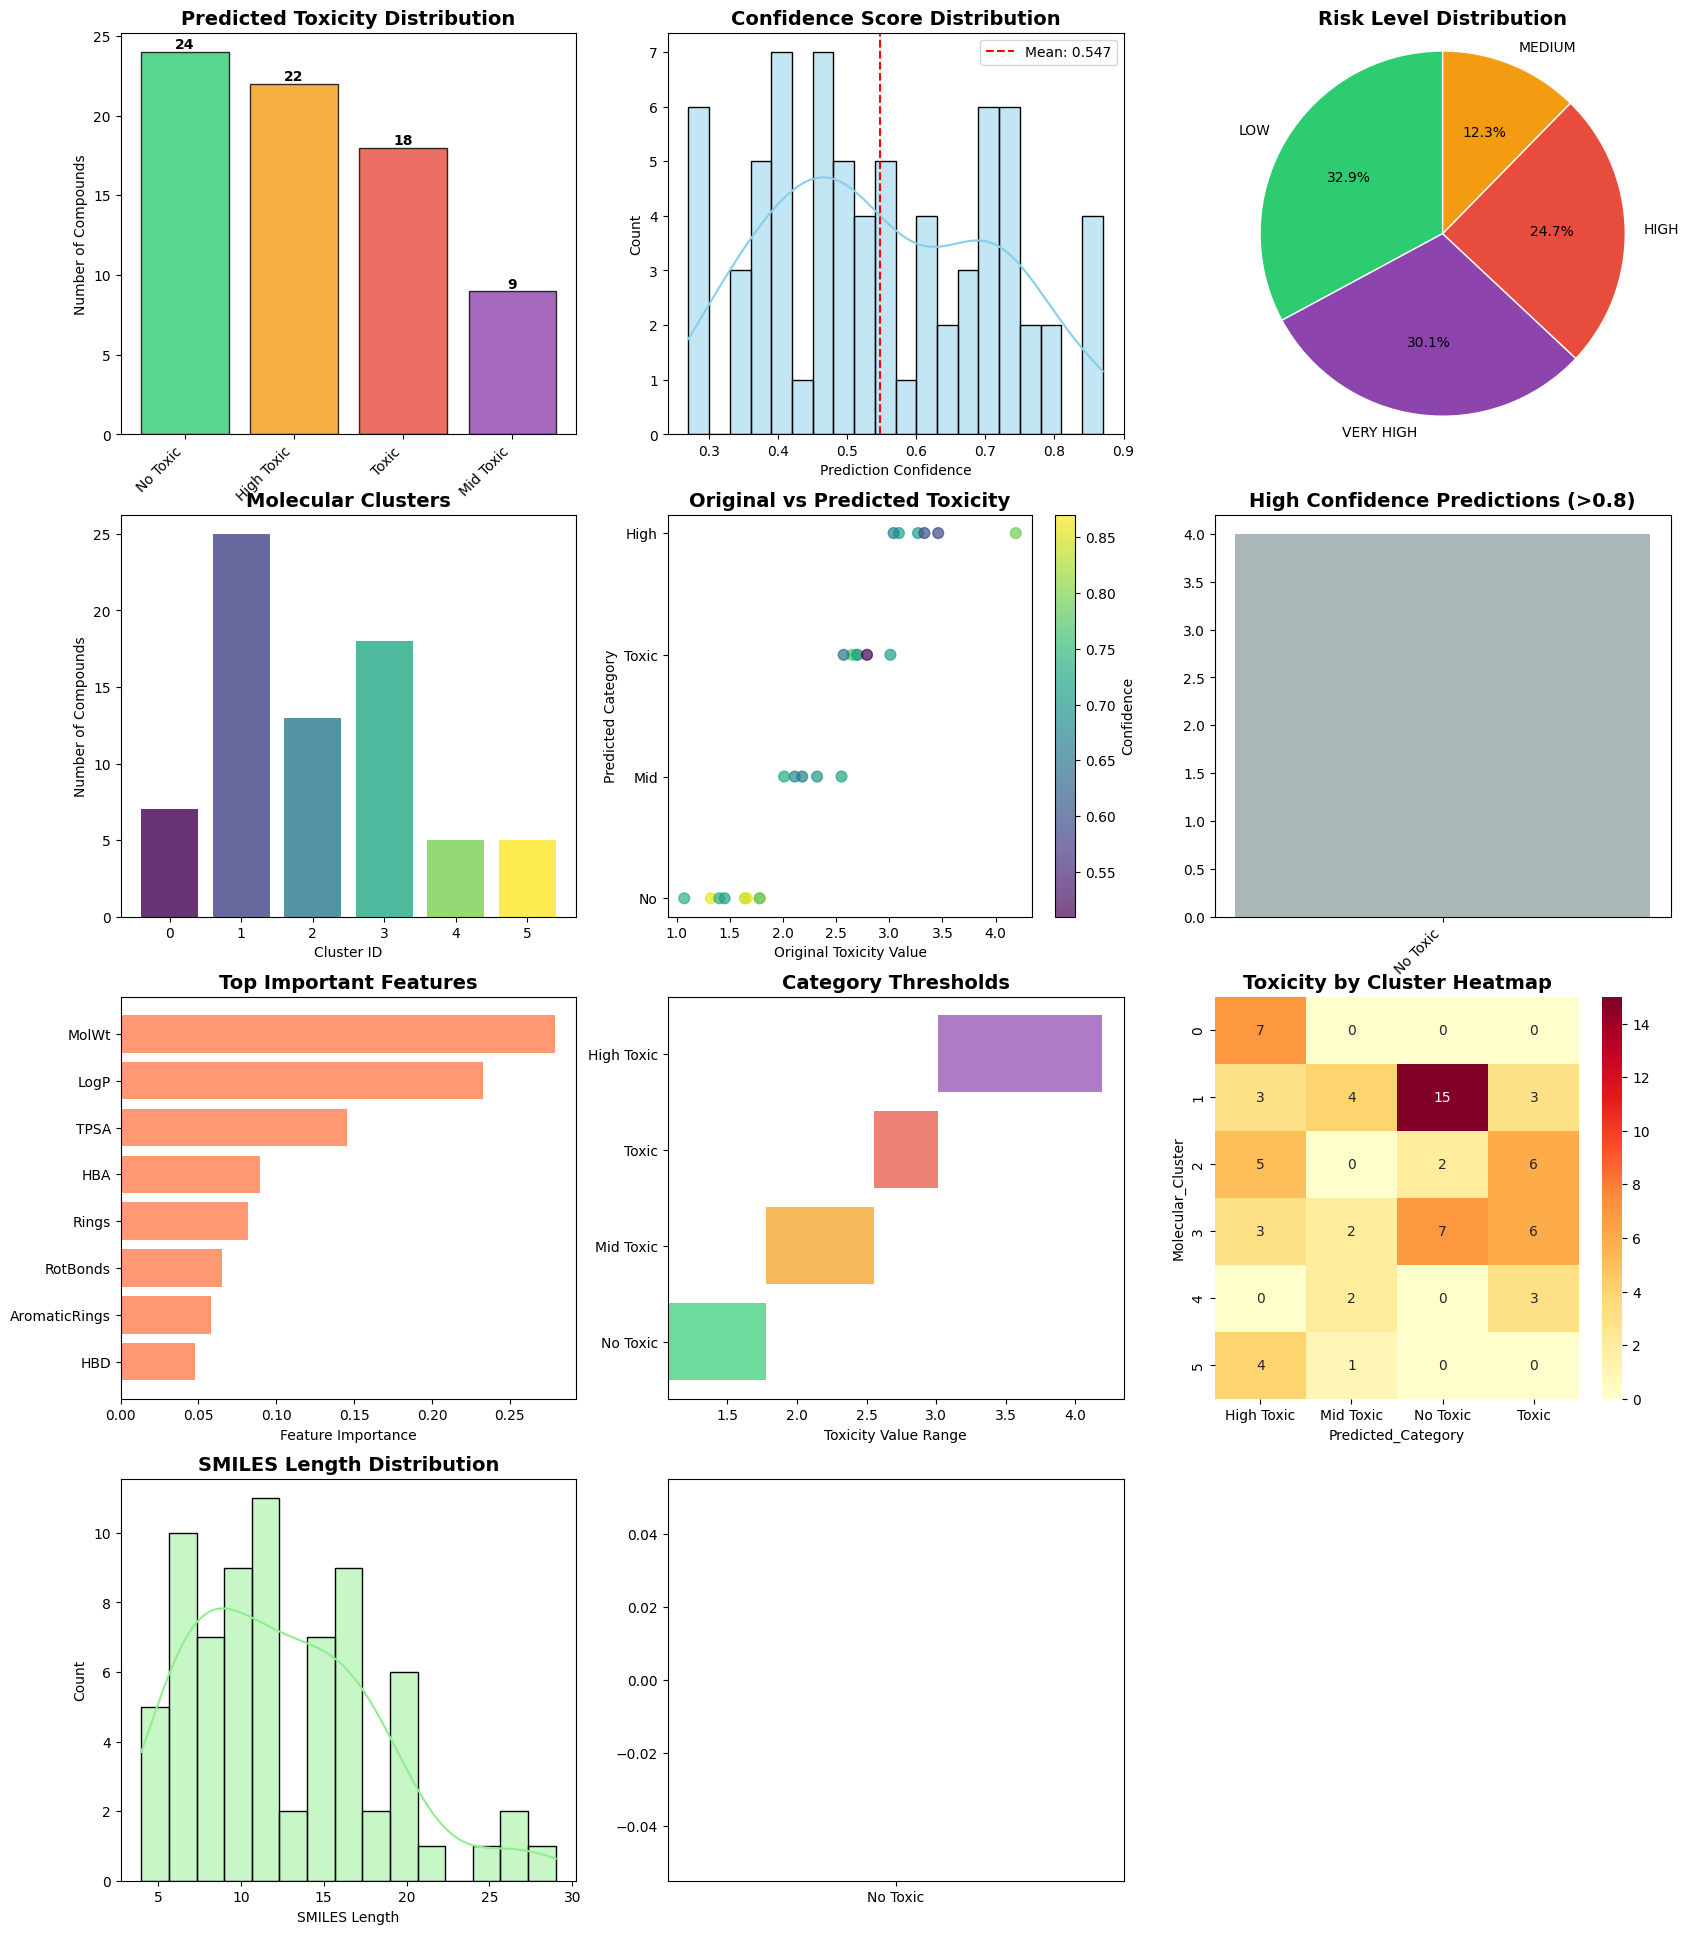

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch
import warnings
import io

warnings.filterwarnings('ignore')

# Google Colab imports for interactive file upload
try:
    from google.colab import files
    COLAB_AVAILABLE = True
except ImportError:
    COLAB_AVAILABLE = False

# PDF generation imports
try:
    from matplotlib.backends.backend_pdf import PdfPages
    PDF_AVAILABLE = True
except ImportError:
    PDF_AVAILABLE = False
    print("⚠️ PDF generation library not found. Please install with 'pip install matplotlib'.")

# RDKit imports for molecular feature calculation
try:
    from rdkit import Chem
    from rdkit.Chem import Descriptors
    RDKIT_AVAILABLE = True
except ImportError:
    RDKIT_AVAILABLE = False
    print("⚠️ RDKit not found. Using simple features. For better results, install with 'pip install rdkit'.")

class ComprehensiveToxicityPredictor:
    def __init__(self):
        self.scaler = StandardScaler()
        self.pca = None
        self.classification_model = None
        self.features = None
        self.feature_names = None
        self.cluster_labels = None
        self.selected_features = None
        self.category_thresholds = None
        self.predictions_df = None
        self.original_df = None
        self.id_col = None
        self.smiles_col = None
        self.toxicity_col = None
        self.filtered_df = None

    def process_uploaded_file(self, file_source):
        """Process the uploaded file from a path or file-like object."""
        print(f"📊 Processing input data...")

        try:
            # Load dataset
            self.original_df = pd.read_csv(file_source, encoding='utf-8')
            print(f"✅ Loaded: {self.original_df.shape[0]} rows × {self.original_df.shape[1]} columns")

            # Auto-detect columns
            self.id_col = self.auto_detect_id_column(self.original_df)
            self.smiles_col = self.auto_detect_smiles_column(self.original_df)
            self.toxicity_col = self.auto_detect_toxicity_column(self.original_df)

            if self.smiles_col is None:
                print("❌ No SMILES column found. Cannot proceed.")
                return None

            print(f"🆔 ID column: {self.id_col}")
            print(f"🧬 SMILES column: {self.smiles_col}")
            print(f"☠️  Toxicity column: {self.toxicity_col}")

            # Extract data
            valid_indices = self.original_df[self.smiles_col].notna()
            self.filtered_df = self.original_df[valid_indices].copy()

            smiles_list = self.filtered_df[self.smiles_col].astype(str).tolist()

            if self.toxicity_col:
                toxicity_values = pd.to_numeric(self.filtered_df[self.toxicity_col], errors='coerce').values
            else:
                toxicity_values = np.full(len(smiles_list), np.nan)

            print(f"✅ Extracted {len(smiles_list)} valid SMILES strings.")

            # Run analysis
            return self.run_analysis(smiles_list, toxicity_values)

        except Exception as e:
            print(f"❌ Error processing file: {e}")
            import traceback
            traceback.print_exc()
            return None

    def run_analysis(self, smiles_list, toxicity_values):
        """Orchestrates the entire analysis workflow."""
        print("\n🚀 Starting comprehensive analysis workflow...")

        # 1. Feature Extraction
        self.features, self.feature_names = self.compute_molecular_features(smiles_list)

        # 2. Toxicity Categorization
        known_categories, self.category_thresholds = self.categorize_toxicity(toxicity_values)

        # 3. Clustering
        self.cluster_labels = self.perform_clustering(self.features)

        # 4. Model Building
        self.classification_model, selector = self.build_prediction_model(self.features, known_categories)

        # 5. Prediction
        final_predictions, confidence = self.predict_all_toxicity(self.features, known_categories, self.classification_model, selector)

        # 6. Results Compilation
        self.predictions_df = self.create_results_dataframe(smiles_list, toxicity_values, final_predictions, confidence, self.cluster_labels)

        # 7. CSV Export
        csv_filename = 'toxicity_predictions.csv'
        self.predictions_df.to_csv(csv_filename, index=False)
        print(f"\n💾 Results saved to '{csv_filename}'")

        # 8. PDF Report Generation
        self.generate_comprehensive_pdf(self.predictions_df)

        print("\n🎉 Analysis complete!")
        return self.predictions_df

    def auto_detect_id_column(self, df):
        """Auto-detect ID column"""
        id_keywords = ['id', 'index', 'compound', 'name', 'number']
        for col in df.columns:
            if any(kw in col.lower() for kw in id_keywords):
                return col
        # Fallback to first column if it looks like an ID
        first_col = df.columns[0]
        if df[first_col].dtype in ['int64', 'object'] and df[first_col].nunique() == len(df):
            return first_col
        return None

    def auto_detect_smiles_column(self, df):
        """Auto-detect SMILES column"""
        smiles_keywords = ['smiles', 'smi', 'query', 'structure', 'mol', 'canonical']
        for col in df.columns:
            if any(kw in col.lower() for kw in smiles_keywords):
                sample_vals = df[col].dropna().head(5).astype(str)
                if all(any(c in val for c in 'CNOSPFBr()=[]#') for val in sample_vals):
                    return col
        # Fallback
        for col in df.columns:
            if df[col].dtype == 'object':
                sample_vals = df[col].dropna().head(10).astype(str)
                chemical_count = sum(1 for val in sample_vals if any(c in val for c in 'CNOSPFBr()=[]#') and len(val) > 2)
                if chemical_count >= len(sample_vals) * 0.7:
                    return col
        return None

    def auto_detect_toxicity_column(self, df):
        """Auto-detect toxicity column"""
        tox_keywords = ['exp_value', 'toxic', 'activity', 'value', 'lc50', 'ic50', 'log', 'mol/kg']
        for col in df.columns:
            if any(kw in col.lower() for kw in tox_keywords):
                try:
                    numeric_data = pd.to_numeric(df[col], errors='coerce')
                    if numeric_data.count() > 0:
                        return col
                except:
                    continue
        return None

    def categorize_toxicity(self, toxicity_values):
        """Categorize toxicity into 4 levels"""
        valid_tox = toxicity_values[~np.isnan(toxicity_values)]
        if len(valid_tox) == 0:
            return np.full(len(toxicity_values), 'Unknown', dtype=object), None

        q25 = np.percentile(valid_tox, 25)
        q50 = np.percentile(valid_tox, 50)
        q75 = np.percentile(valid_tox, 75)

        self.category_thresholds = {
            'No Toxic': (valid_tox.min(), q25),
            'Mid Toxic': (q25, q50),
            'Toxic': (q50, q75),
            'High Toxic': (q75, valid_tox.max())
        }

        print("🎯 Toxicity categories defined by quartiles:")
        for cat, (min_val, max_val) in self.category_thresholds.items():
            print(f"  • {cat}: {min_val:.3f} - {max_val:.3f}")

        categories = np.full(len(toxicity_values), 'Unknown', dtype=object)
        for i, tox_val in enumerate(toxicity_values):
            if not np.isnan(tox_val):
                if tox_val <= q25: categories[i] = 'No Toxic'
                elif tox_val <= q50: categories[i] = 'Mid Toxic'
                elif tox_val <= q75: categories[i] = 'Toxic'
                else: categories[i] = 'High Toxic'

        return categories, self.category_thresholds

    def compute_molecular_features(self, smiles_list):
        """Compute molecular features"""
        print(f"🧪 Computing molecular features using {'RDKit' if RDKIT_AVAILABLE else 'simple method'}...")
        if RDKIT_AVAILABLE:
            return self.rdkit_features(smiles_list)
        else:
            return self.simple_features(smiles_list)

    def rdkit_features(self, smiles_list):
        """RDKit molecular descriptors"""
        features = []
        feature_names = ['MolWt', 'LogP', 'HBD', 'HBA', 'TPSA', 'RotBonds', 'AromaticRings', 'Rings']
        for smiles in smiles_list:
            try:
                mol = Chem.MolFromSmiles(smiles)
                if mol:
                    mol_features = [
                        Descriptors.MolWt(mol), Descriptors.MolLogP(mol),
                        Descriptors.NumHDonors(mol), Descriptors.NumHAcceptors(mol),
                        Descriptors.TPSA(mol), Descriptors.NumRotatableBonds(mol),
                        Descriptors.NumAromaticRings(mol), Descriptors.RingCount(mol)
                    ]
                else:
                    mol_features = [0.0] * len(feature_names)
                features.append(mol_features)
            except:
                features.append([0.0] * len(feature_names))
        return np.array(features), feature_names

    def simple_features(self, smiles_list):
        """Simple molecular features"""
        features = []
        feature_names = ['Length', 'C_count', 'N_count', 'O_count', 'Aromatic', 'DoubleBonds']
        for smiles in smiles_list:
            try:
                features.append([
                    len(smiles), smiles.upper().count('C'), smiles.upper().count('N'),
                    smiles.upper().count('O'), smiles.count('c'), smiles.count('=')
                ])
            except:
                features.append([0.0] * len(feature_names))
        return np.array(features), feature_names

    def perform_clustering(self, features):
        """Perform molecular clustering"""
        print("🔬 Clustering molecules...")
        features_scaled = self.scaler.fit_transform(features)

        if features.shape[1] > 8:
            self.pca = PCA(n_components=8)
            features_final = self.pca.fit_transform(features_scaled)
        else:
            features_final = features_scaled

        n_clusters = min(6, max(2, len(features) // 12))
        clusterer = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
        cluster_labels = clusterer.fit_predict(features_final)

        print(f"✅ Created {len(np.unique(cluster_labels))} molecular clusters.")
        return cluster_labels

    def build_prediction_model(self, features, categories):
        """Build toxicity prediction model"""
        print("🤖 Building prediction model...")
        known_mask = categories != 'Unknown'
        if np.sum(known_mask) < 10:
            print("⚠️ Insufficient training data (<10 samples). Skipping model training.")
            return None, None

        X_train = features[known_mask]
        y_train = categories[known_mask]

        le = LabelEncoder()
        y_encoded = le.fit_transform(y_train)

        k_features = min(8, X_train.shape[1])
        selector = SelectKBest(score_func=f_classif, k=k_features)
        X_selected = selector.fit_transform(X_train, y_encoded)

        selected_indices = selector.get_support(indices=True)
        self.selected_features = [self.feature_names[i] for i in selected_indices]

        model = RandomForestClassifier(n_estimators=100, random_state=42)
        model.fit(X_selected, y_train)

        print(f"✅ Model trained with {len(self.selected_features)} features: {self.selected_features}")
        return model, selector

    def predict_all_toxicity(self, features, known_categories, model, selector):
        """Predict toxicity for all compounds"""
        if model is None:
            print("🔮 Prediction skipped as no model was built.")
            return known_categories, np.full(len(known_categories), 0.0)

        print("🔮 Predicting toxicity for all compounds...")
        X_selected = selector.transform(features)
        predictions = model.predict(X_selected)
        probabilities = model.predict_proba(X_selected)
        confidence = np.max(probabilities, axis=1)

        final_predictions = known_categories.copy()
        unknown_mask = known_categories == 'Unknown'
        final_predictions[unknown_mask] = predictions[unknown_mask]

        print(f"✅ Made predictions for {np.sum(unknown_mask)} unknown compounds.")
        return final_predictions, confidence

    def create_results_dataframe(self, smiles_list, toxicity_values, predictions, confidence, clusters):
        """Create comprehensive results dataframe"""
        results_df = pd.DataFrame({
            'Index': range(1, len(smiles_list) + 1),
            'ID': self.filtered_df[self.id_col].values if self.id_col else [f'COMP_{i+1:03d}' for i in range(len(smiles_list))],
            'SMILES': smiles_list,
            'Original_Toxicity_Value': toxicity_values,
            'Predicted_Category': predictions,
            'Confidence_Score': confidence,
            'Molecular_Cluster': clusters
        })

        risk_mapping = {
            'No Toxic': 'LOW', 'Mid Toxic': 'MEDIUM', 'Toxic': 'HIGH',
            'High Toxic': 'VERY HIGH', 'Unknown': 'UNKNOWN'
        }
        results_df['Risk_Level'] = results_df['Predicted_Category'].map(risk_mapping)

        if self.features is not None and len(self.feature_names) > 0:
            for i, feature_name in enumerate(self.feature_names):
                if i < self.features.shape[1]:
                    results_df[f'Feature_{feature_name}'] = self.features[:, i]

        category_explanation = {
            'No Toxic': 'Low toxicity - Generally safe',
            'Mid Toxic': 'Moderate toxicity - Use with caution',
            'Toxic': 'High toxicity - Significant risk',
            'High Toxic': 'Very high toxicity - Extreme caution',
            'Unknown': 'Toxicity unknown - Requires testing'
        }
        results_df['Toxicity_Explanation'] = results_df['Predicted_Category'].map(category_explanation)

        results_df = results_df.sort_values('Confidence_Score', ascending=False).reset_index(drop=True)
        return results_df

    def create_workflow_flowchart(self):
        """Create analysis workflow flowchart"""
        fig, ax = plt.subplots(figsize=(14, 10))
        ax.set_xlim(0, 10)
        ax.set_ylim(0, 12)
        ax.axis('off')

        boxes = [
            {'text': '1. Dataset Upload\n& Loading', 'xy': (2, 10.5), 'color': '#3498db'},
            {'text': '2. Column Detection\n(ID, SMILES, Toxicity)', 'xy': (2, 9), 'color': '#2ecc71'},
            {'text': '3. Data Preprocessing\n& Cleaning', 'xy': (2, 7.5), 'color': '#f39c12'},
            {'text': '4. Molecular Feature\nExtraction (RDKit)', 'xy': (2, 6), 'color': '#e74c3c'},
            {'text': '5. Toxicity\nCategorization', 'xy': (5.5, 9), 'color': '#9b59b6'},
            {'text': '6. Molecular\nClustering', 'xy': (5.5, 7.5), 'color': '#1abc9c'},
            {'text': '7. ML Model\nTraining', 'xy': (5.5, 6), 'color': '#e67e22'},
            {'text': '8. Toxicity Prediction\nfor All Compounds', 'xy': (8, 7.5), 'color': '#34495e'},
            {'text': '9. Results Compilation\n& Analysis', 'xy': (5.5, 4.5), 'color': '#95a5a6'},
            {'text': '10. PDF Report\nGeneration', 'xy': (2, 3), 'color': '#d35400'},
            {'text': '11. CSV Export\n& Download', 'xy': (8, 3), 'color': '#27ae60'}
        ]

        for box in boxes:
            bbox = FancyBboxPatch((box['xy'][0]-0.8, box['xy'][1]-0.4), 1.6, 0.8,
                                  boxstyle="round,pad=0.1", facecolor=box['color'],
                                  edgecolor='black', alpha=0.8)
            ax.add_patch(bbox)
            ax.text(box['xy'][0], box['xy'][1], box['text'], ha='center', va='center',
                    fontsize=9, fontweight='bold', color='white', wrap=True)

        arrows = [
            ((2, 10.1), (2, 9.4)), ((2, 8.6), (2, 7.9)), ((2, 7.1), (2, 6.4)),
            ((2.8, 9), (4.7, 9)), ((2.8, 7.5), (4.7, 7.5)), ((2.8, 6), (4.7, 6)),
            ((6.3, 9), (7.2, 8.2)), ((6.3, 7.5), (7.2, 7.5)), ((6.3, 6), (7.2, 6.8)),
            ((8, 7.1), (6.3, 4.9)), ((4.7, 4.5), (2.8, 3.4)), ((6.3, 4.5), (7.2, 3.4))
        ]

        for start, end in arrows:
            ax.annotate('', xy=end, xytext=start,
                        arrowprops=dict(arrowstyle='->', lw=2, color='black'))

        ax.set_title('Comprehensive Toxicity Analysis Workflow', fontsize=18, fontweight='bold', pad=20)
        return fig

    def create_comprehensive_visualizations(self, results_df):
        """Create comprehensive visualization suite"""
        fig = plt.figure(figsize=(20, 24))

        # Plot 1: Toxicity Category Distribution
        ax1 = plt.subplot(4, 3, 1)
        category_counts = results_df['Predicted_Category'].value_counts()
        colors = ['#2ecc71', '#f39c12', '#e74c3c', '#8e44ad', '#95a5a6']
        bars = ax1.bar(category_counts.index, category_counts.values,
                       color=colors[:len(category_counts)], alpha=0.8, edgecolor='black')
        ax1.set_title('Predicted Toxicity Distribution', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Number of Compounds')
        plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha="right")
        for bar in bars:
            ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                     f'{int(bar.get_height())}', ha='center', va='bottom', fontweight='bold')

        # Plot 2: Confidence Score Distribution
        ax2 = plt.subplot(4, 3, 2)
        sns.histplot(results_df['Confidence_Score'], bins=20, ax=ax2, color='skyblue', kde=True)
        ax2.axvline(results_df['Confidence_Score'].mean(), color='red', linestyle='--',
                    label=f'Mean: {results_df["Confidence_Score"].mean():.3f}')
        ax2.set_xlabel('Prediction Confidence')
        ax2.set_title('Confidence Score Distribution', fontsize=14, fontweight='bold')
        ax2.legend()

        # Plot 3: Risk Level Pie Chart
        ax3 = plt.subplot(4, 3, 3)
        risk_counts = results_df['Risk_Level'].value_counts()
        colors_pie = {'LOW': '#2ecc71', 'MEDIUM': '#f39c12', 'HIGH': '#e74c3c', 'VERY HIGH': '#8e44ad', 'UNKNOWN': '#95a5a6'}
        pie_colors = [colors_pie[key] for key in risk_counts.index]
        ax3.pie(risk_counts.values, labels=risk_counts.index, autopct='%1.1f%%', startangle=90, colors=pie_colors,
                wedgeprops={'edgecolor': 'white'})
        ax3.set_title('Risk Level Distribution', fontsize=14, fontweight='bold')
        ax3.axis('equal')

        # Plot 4: Cluster Analysis
        ax4 = plt.subplot(4, 3, 4)
        cluster_counts = results_df['Molecular_Cluster'].value_counts().sort_index()
        ax4.bar(cluster_counts.index, cluster_counts.values,
                color=plt.cm.viridis(np.linspace(0, 1, len(cluster_counts))), alpha=0.8)
        ax4.set_xlabel('Cluster ID')
        ax4.set_ylabel('Number of Compounds')
        ax4.set_title('Molecular Clusters', fontsize=14, fontweight='bold')
        ax4.set_xticks(cluster_counts.index)

        # Plot 5: Original vs Predicted Toxicity
        ax5 = plt.subplot(4, 3, 5)
        valid_original = ~results_df['Original_Toxicity_Value'].isna()
        if valid_original.sum() > 0:
            orig_data = results_df[valid_original]
            cat_mapping = {'No Toxic': 1, 'Mid Toxic': 2, 'Toxic': 3, 'High Toxic': 4}
            y_pred_numeric = orig_data['Predicted_Category'].map(cat_mapping)
            scatter = ax5.scatter(orig_data['Original_Toxicity_Value'], y_pred_numeric,
                                  c=orig_data['Confidence_Score'], cmap='viridis', alpha=0.7, s=60)
            ax5.set_xlabel('Original Toxicity Value')
            ax5.set_ylabel('Predicted Category')
            ax5.set_title('Original vs Predicted Toxicity', fontsize=14, fontweight='bold')
            ax5.set_yticks([1, 2, 3, 4])
            ax5.set_yticklabels(['No', 'Mid', 'Toxic', 'High'])
            plt.colorbar(scatter, ax=ax5, label='Confidence')

        # Plot 6: High Confidence Predictions
        ax6 = plt.subplot(4, 3, 6)
        high_conf = results_df[results_df['Confidence_Score'] > 0.8]
        if len(high_conf) > 0:
            conf_counts = high_conf['Predicted_Category'].value_counts()
            ax6.bar(conf_counts.index, conf_counts.values, alpha=0.8,
                    color=[colors_pie.get(c.replace(' Toxic', '').upper(), '#95a5a6') for c in conf_counts.index])
            ax6.set_title('High Confidence Predictions (>0.8)', fontsize=14, fontweight='bold')
            plt.setp(ax6.xaxis.get_majorticklabels(), rotation=45, ha="right")

        # Plot 7: Feature Importance
        if hasattr(self, 'classification_model') and self.classification_model is not None:
            ax7 = plt.subplot(4, 3, 7)
            importance = self.classification_model.feature_importances_
            feature_names = self.selected_features
            sorted_idx = np.argsort(importance)
            ax7.barh(np.array(feature_names)[sorted_idx], importance[sorted_idx], color='coral', alpha=0.8)
            ax7.set_xlabel('Feature Importance')
            ax7.set_title('Top Important Features', fontsize=14, fontweight='bold')

        # Plot 8: Toxicity Thresholds
        ax8 = plt.subplot(4, 3, 8)
        if self.category_thresholds:
            categories = list(self.category_thresholds.keys())
            widths = [v[1] - v[0] for v in self.category_thresholds.values()]
            starts = [v[0] for v in self.category_thresholds.values()]
            ax8.barh(categories, widths, left=starts, alpha=0.7,
                     color=['#2ecc71', '#f39c12', '#e74c3c', '#8e44ad'])
            ax8.set_xlabel('Toxicity Value Range')
            ax8.set_title('Category Thresholds', fontsize=14, fontweight='bold')

        # Plot 9: Cluster vs Toxicity Heatmap
        ax9 = plt.subplot(4, 3, 9)
        contingency = pd.crosstab(results_df['Molecular_Cluster'], results_df['Predicted_Category'])
        sns.heatmap(contingency, annot=True, fmt='d', cmap='YlOrRd', ax=ax9)
        ax9.set_title('Toxicity by Cluster Heatmap', fontsize=14, fontweight='bold')

        # Plot 10: SMILES Length Distribution
        ax10 = plt.subplot(4, 3, 10)
        results_df['SMILES_Length'] = results_df['SMILES'].str.len()
        sns.histplot(results_df['SMILES_Length'], bins=15, ax=ax10, color='lightgreen', kde=True)
        ax10.set_xlabel('SMILES Length')
        ax10.set_title('SMILES Length Distribution', fontsize=14, fontweight='bold')

        # Plot 11: Confidence by Category
        ax11 = plt.subplot(4, 3, 11)
        category_order = ['No Toxic', 'Mid Toxic', 'Toxic', 'High Toxic']
        sns.boxplot(x='Predicted_Category', y='Confidence_Score', data=results_df, order=category_order,
                    ax=ax11, palette=[colors_pie.get(c.replace(' Toxic', '').upper()) for c in category_order])
        ax11.set_title('Confidence by Category', fontsize=14, fontweight='bold')
        plt.setp(ax11.xaxis.get_majorticklabels(), rotation=45, ha="right")
        ax11.set_xlabel('')

        # Plot 12: Summary Statistics Text
        ax12 = plt.subplot(4, 3, 12)
        ax12.axis('off')
        stats_text = f"""
COMPREHENSIVE ANALYSIS SUMMARY
==============================
Total Compounds: {len(results_df):,}
Average Confidence: {results_df['Confidence_Score'].mean():.3f}
High Confidence (>0.8): {(results_df['Confidence_Score'] > 0.8).sum():,}

CATEGORY DISTRIBUTION:
"""
        for cat, count in category_counts.items():
            stats_text += f"• {cat:<10}: {count:>4} ({(count/len(results_df)*100):.1f}%)\n"
        stats_text += "\nRISK LEVELS:\n"
        for risk, count in risk_counts.items():
            stats_text += f"• {risk:<10}: {count:>4} ({(count/len(results_df)*100):.1f}%)\n"

        ax12.text(0, 0.95, stats_text, transform=ax12.transAxes,
                  fontsize=11, verticalalignment='top', fontfamily='monospace')

        plt.tight_layout(pad=3.0)
        return fig

    def _df_to_pdf_table(self, pdf, df):
        """Helper function to add a DataFrame as a table to a PDF, handling pagination."""
        df_display = df[['ID', 'SMILES', 'Original_Toxicity_Value', 'Predicted_Category', 'Risk_Level', 'Confidence_Score', 'Molecular_Cluster']]
        df_display['Original_Toxicity_Value'] = df_display['Original_Toxicity_Value'].round(3)
        df_display['Confidence_Score'] = df_display['Confidence_Score'].round(3)

        rows_per_page = 40
        num_pages = int(np.ceil(len(df_display) / rows_per_page))

        for i in range(num_pages):
            fig, ax = plt.subplots(figsize=(11.69, 8.27)) # A4 Landscape
            ax.axis('tight')
            ax.axis('off')

            start_row = i * rows_per_page
            end_row = start_row + rows_per_page
            chunk = df_display.iloc[start_row:end_row]

            table = ax.table(cellText=chunk.values, colLabels=chunk.columns, cellLoc='center', loc='center', colWidths=[0.15, 0.3, 0.1, 0.1, 0.1, 0.1, 0.1])
            table.auto_set_font_size(False)
            table.set_fontsize(8)
            table.scale(1, 1.2)

            ax.set_title(f'Toxicity Prediction Results - Page {i+1} of {num_pages}', fontsize=14, fontweight='bold', pad=20)
            pdf.savefig(fig, bbox_inches='tight')
            plt.close(fig)

    def generate_comprehensive_pdf(self, results_df):
        """Generate comprehensive PDF report with flowchart and complete dataset"""
        if not PDF_AVAILABLE:
            print("❌ PDF generation not available.")
            return

        filename = 'Comprehensive_SMILES_Toxicity_Report.pdf'
        print(f"📄 Generating comprehensive PDF report: '{filename}'...")

        with PdfPages(filename) as pdf:
            # Page 1: Title Page
            fig_title = plt.figure(figsize=(11.69, 8.27))
            fig_title.text(0.5, 0.6, 'Comprehensive SMILES Toxicity Analysis Report', ha='center', va='center', fontsize=24, fontweight='bold')
            fig_title.text(0.5, 0.45, f'Analysis of {len(results_df)} Compounds', ha='center', va='center', fontsize=18)
            fig_title.text(0.5, 0.35, f'Generated on: {pd.to_datetime("today").strftime("%Y-%m-%d %H:%M:%S")}', ha='center', va='center', fontsize=12, color='gray')
            pdf.savefig(fig_title)
            plt.close(fig_title)

            # Page 2: Workflow Flowchart
            print("  - Adding workflow flowchart...")
            fig1 = self.create_workflow_flowchart()
            pdf.savefig(fig1, bbox_inches='tight', dpi=300)
            plt.close(fig1)

            # Page 3: Comprehensive Visualizations
            print("  - Adding visualizations dashboard...")
            fig2 = self.create_comprehensive_visualizations(results_df)
            pdf.savefig(fig2, bbox_inches='tight', dpi=300)
            plt.close(fig2)

            # Subsequent Pages: Full Dataset
            print(f"  - Adding full dataset ({len(results_df)} rows)...")
            self._df_to_pdf_table(pdf, results_df)

        print(f"✅ PDF report successfully generated.")

# --- Main Execution Block ---
if __name__ == '__main__':
    print("🚀 Auto Toxicity Predictor Initialized 🚀")

    # Initialize the predictor
    predictor = ComprehensiveToxicityPredictor()
    file_source = None

    # Check if running in Google Colab for an interactive upload button
    if COLAB_AVAILABLE:
        print("\nPlease choose a CSV file to upload.")
        try:
            uploaded = files.upload()
            if not uploaded:
                print("\n❌ No file selected. Analysis cancelled.")
            else:
                # Get the name of the uploaded file
                file_source = next(iter(uploaded))
                print(f"\n✅ File '{file_source}' uploaded successfully.")
        except Exception as e:
            print(f"\n❌ An error occurred during file upload: {e}")

    # If not in Colab, ask for a local file path
    else:
        print("\nThis script is not running in Google Colab.")
        file_path = input("➡️ Please enter the full path to your CSV file and press Enter: ").strip()
        if not file_path:
             print("\n❌ No file path entered. Analysis cancelled.")
        else:
            file_source = file_path

    # If a file source has been successfully identified, run the analysis
    if file_source:
        try:
            results = predictor.process_uploaded_file(file_source)

            if results is not None:
                print("\n--- Top 5 Most Confident Predictions ---")
                print(results[['ID', 'SMILES', 'Predicted_Category', 'Risk_Level', 'Confidence_Score']].head(5))
                print(f"\n✅ Analysis complete. Check the generated files: 'Comprehensive_SMILES_Toxicity_Report.pdf' and 'toxicity_predictions.csv'.")

        except FileNotFoundError:
            print(f"\n❌ Error: The file was not found at '{file_source}'. Please check the path and try again.")
        except Exception as e:
            print(f"\n❌ An unexpected error occurred during analysis: {e}")

In [20]:
pip install streamlit pandas scikit-learn matplotlib seaborn rdkit plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 75.9 MB/s eta 0:00:00


In [22]:
import streamlit as st
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
import warnings
import io
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.patches import FancyBboxPatch

# RDKit imports for molecular feature calculation
try:
    from rdkit import Chem
    from rdkit.Chem import Descriptors
    RDKIT_AVAILABLE = True
except ImportError:
    RDKIT_AVAILABLE = False
    st.error("RDKit is not installed. Please install it with 'pip install rdkit' for full functionality.")

warnings.filterwarnings('ignore')

# --- Page Configuration ---
st.set_page_config(
    page_title="Toxicity Predictor Dashboard",
    page_icon="☠️",
    layout="wide"
)

# --- Analysis Class (Backend Logic) ---
class ComprehensiveToxicityPredictor:
    def __init__(self):
        self.scaler = StandardScaler()
        self.classification_model = None
        self.features = None
        self.feature_names = None

    def auto_detect_columns(self, df):
        smiles_col, tox_col, id_col = None, None, None
        smiles_keywords = ['smiles', 'smi', 'query', 'structure', 'mol', 'canonical']
        tox_keywords = ['exp_value', 'toxic', 'activity', 'value', 'lc50', 'ic50', 'log', 'mol/kg']
        id_keywords = ['id', 'index', 'compound', 'name', 'number']

        for col in df.columns:
            if any(kw in col.lower() for kw in smiles_keywords):
                smiles_col = col
            if any(kw in col.lower() for kw in tox_keywords):
                tox_col = col
            if any(kw in col.lower() for kw in id_keywords):
                id_col = col

        if id_col is None and df.columns[0].nunique() == len(df):
            id_col = df.columns[0]

        return smiles_col, tox_col, id_col

    def categorize_toxicity(self, toxicity_values):
        valid_tox = toxicity_values[~np.isnan(toxicity_values)]
        if len(valid_tox) < 4:
            return np.full(len(toxicity_values), 'Unknown', dtype=object)

        q25, q50, q75 = np.percentile(valid_tox, [25, 50, 75])

        categories = np.full(len(toxicity_values), 'Unknown', dtype=object)
        for i, tox_val in enumerate(toxicity_values):
            if not np.isnan(tox_val):
                if tox_val <= q25: categories[i] = 'Low'
                elif tox_val <= q50: categories[i] = 'Moderate'
                elif tox_val <= q75: categories[i] = 'High'
                else: categories[i] = 'Very High'
        return categories

    def compute_rdkit_features(self, smiles_list):
        features, feature_names = [], []
        if RDKIT_AVAILABLE:
            feature_names = ['Mol Weight', 'LogP']
            for smiles in smiles_list:
                try:
                    mol = Chem.MolFromSmiles(smiles)
                    if mol:
                        mol_features = [Descriptors.MolWt(mol), Descriptors.MolLogP(mol)]
                    else:
                        mol_features = [0.0] * len(feature_names)
                    features.append(mol_features)
                except:
                    features.append([0.0] * len(feature_names))
        return np.array(features), feature_names

    def build_and_predict(self, features, categories):
        known_mask = categories != 'Unknown'
        if np.sum(known_mask) < 10:
            return categories, np.full(len(categories), 0.5)

        X_train, y_train = features[known_mask], categories[known_mask]

        model = RandomForestClassifier(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)

        predictions = model.predict(features)
        probabilities = model.predict_proba(features)
        confidence = np.max(probabilities, axis=1)

        final_predictions = np.copy(categories)
        final_predictions[~known_mask] = predictions[~known_mask]

        return final_predictions, confidence

    @st.cache_data
    def run_analysis(_self, df):
        smiles_col, tox_col, id_col = _self.auto_detect_columns(df)
        if not smiles_col:
            st.error("Could not detect a SMILES column in the uploaded file.")
            return None

        st.success(f"Detected Columns -> ID: **{id_col}**, SMILES: **{smiles_col}**, Toxicity: **{tox_col}**")

        smiles_list = df[smiles_col].astype(str).tolist()

        features, feature_names = _self.compute_rdkit_features(smiles_list)

        if tox_col:
            toxicity_values = pd.to_numeric(df[tox_col], errors='coerce').values
            known_categories = _self.categorize_toxicity(toxicity_values)
        else:
            toxicity_values = np.full(len(smiles_list), np.nan)
            known_categories = np.full(len(smiles_list), 'Unknown', dtype=object)

        final_predictions, confidence = _self.build_and_predict(features, known_categories)

        results_df = pd.DataFrame({
            'ID': df[id_col].values if id_col else [f'Comp_{i+1}' for i in range(len(df))],
            'SMILES': smiles_list,
            'Toxicity Score': toxicity_values,
            'Risk Rate': final_predictions,
            'Confidence': confidence * 100,
            'Mol Weight': features[:, 0] if features.shape[1] > 0 else np.nan,
            'LogP': features[:, 1] if features.shape[1] > 1 else np.nan
        })
        return results_df.sort_values("Confidence", ascending=False)

    # --- PDF Generation Methods ---
    def _create_workflow_flowchart(self):
        fig, ax = plt.subplots(figsize=(14, 10))
        ax.set_xlim(0, 10); ax.set_ylim(0, 12); ax.axis('off')
        boxes = [{'text': '1. Upload CSV', 'xy': (2, 10.5), 'color': '#3498db'}, {'text': '2. Detect Columns', 'xy': (2, 9), 'color': '#2ecc71'}, {'text': '3. Calculate Features', 'xy': (2, 7.5), 'color': '#f39c12'}, {'text': '4. Categorize & Predict', 'xy': (5.5, 9), 'color': '#9b59b6'}, {'text': '5. Build Dashboard', 'xy': (5.5, 7.5), 'color': '#1abc9c'}, {'text': '6. Generate PDF Report', 'xy': (8, 7.5), 'color': '#d35400'}]
        for box in boxes:
            bbox = FancyBboxPatch((box['xy'][0]-0.8, box['xy'][1]-0.4), 1.6, 0.8, boxstyle="round,pad=0.1", fc=box['color'], ec='black', alpha=0.8)
            ax.add_patch(bbox)
            ax.text(box['xy'][0], box['xy'][1], box['text'], ha='center', va='center', fontsize=9, fontweight='bold', color='white')
        arrows = [((2, 10.1), (2, 9.4)), ((2, 8.6), (2, 7.9)), ((2.8, 9), (4.7, 9)), ((2.8, 7.5), (4.7, 7.5)), ((6.3, 7.5), (7.2, 7.5))]
        for start, end in arrows:
            ax.annotate('', xy=end, xytext=start, arrowprops=dict(arrowstyle='->', lw=2, color='black'))
        ax.set_title('Toxicity Analysis Workflow', fontsize=18, fontweight='bold', pad=20)
        return fig

    def _df_to_pdf_table(self, pdf, df):
        df_display = df[['ID', 'SMILES', 'Toxicity Score', 'Risk Rate', 'Confidence', 'Mol Weight', 'LogP']]
        df_display['Toxicity Score'] = df_display['Toxicity Score'].round(3)
        df_display['Confidence'] = df_display['Confidence'].round(1)

        rows_per_page = 40
        for i in range(0, len(df_display), rows_per_page):
            chunk = df_display[i:i + rows_per_page]
            fig, ax = plt.subplots(figsize=(11.69, 8.27)) # A4 Landscape
            ax.axis('tight'); ax.axis('off')
            table = ax.table(cellText=chunk.values, colLabels=chunk.columns, cellLoc='center', loc='center', colWidths=[0.15, 0.3, 0.1, 0.1, 0.1, 0.1, 0.1])
            table.auto_set_font_size(False); table.set_fontsize(8); table.scale(1, 1.2)
            pdf.savefig(fig, bbox_inches='tight')
            plt.close(fig)

    @st.cache_data
    def generate_pdf_report_in_memory(_self, results_df):
        pdf_buffer = io.BytesIO()
        with PdfPages(pdf_buffer) as pdf:
            # Page 1: Title
            fig_title = plt.figure(figsize=(11.69, 8.27))
            fig_title.text(0.5, 0.6, 'Toxicity Analysis Report', ha='center', va='center', fontsize=24, fontweight='bold')
            fig_title.text(0.5, 0.45, f'Analysis of {len(results_df)} Compounds', ha='center', va='center', fontsize=18)
            pdf.savefig(fig_title); plt.close(fig_title)

            # Page 2: Workflow
            fig_workflow = _self._create_workflow_flowchart()
            pdf.savefig(fig_workflow, bbox_inches='tight'); plt.close(fig_workflow)

            # Subsequent pages: Full Data Table
            _self._df_to_pdf_table(pdf, results_df)

        return pdf_buffer.getvalue()

# --- UI Layout ---
st.title("🧪 Stylish Toxicity Predictor")
st.markdown("Upload your CSV file with SMILES data. The dashboard will update automatically.")

uploaded_file = st.file_uploader("Choose a CSV file", type="csv")

if uploaded_file is not None:
    predictor = ComprehensiveToxicityPredictor()
    df = pd.read_csv(uploaded_file)
    results_df = predictor.run_analysis(df)

    if results_df is not None:
        # --- Dashboard Metrics ---
        total_compounds = len(results_df)
        avg_toxicity = results_df['Toxicity Score'].mean()
        high_risk_count = results_df[results_df['Risk Rate'].isin(['High', 'Very High'])].shape[0]
        risk_rate = (high_risk_count / total_compounds) * 100 if total_compounds > 0 else 0

        col1, col2, col3, col4, col5 = st.columns([1.5, 1.5, 1.5, 1.5, 2])
        col1.metric("Total Compounds", f"{total_compounds}")
        col2.metric("Avg Toxicity", f"{avg_toxicity:.2f}")
        col3.metric("High Risk", f"{high_risk_count}")
        col4.metric("Risk Rate", f"{risk_rate:.0f}%")

        with col5:
            # --- DOWNLOAD BUTTON ---
            pdf_bytes = predictor.generate_pdf_report_in_memory(results_df)
            st.download_button(
                label="📄 Download Full PDF Report",
                data=pdf_bytes,
                file_name="Comprehensive_SMILES_Toxicity_Report.pdf",
                mime="application/pdf",
                use_container_width=True
            )

        st.markdown("---")

        # --- Tabs for Overview and Details ---
        overview_tab, details_tab = st.tabs(["📊 Overview", "📄 Detailed Results"])

        with overview_tab:
            col1, col2 = st.columns(2)
            with col1:
                st.subheader("Toxicity Distribution")
                dist_counts = results_df['Risk Rate'].value_counts().reset_index()
                fig_pie = px.pie(dist_counts, names='Risk Rate', values='count', color='Risk Rate',
                                 color_discrete_map={'Low': '#2ecc71', 'Moderate': '#f39c12', 'High': '#e74c3c', 'Very High': '#8e44ad'})
                st.plotly_chart(fig_pie, use_container_width=True)
            with col2:
                st.subheader("Toxicity Levels Count")
                level_counts = results_df['Risk Rate'].value_counts()
                fig_bar = px.bar(level_counts, x=level_counts.index, y=level_counts.values,
                                 labels={'x': 'Risk Level', 'y': 'Number of Compounds'}, color=level_counts.index,
                                 color_discrete_map={'Low': '#2ecc71', 'Moderate': '#f39c12', 'High': '#e74c3c', 'Very High': '#8e44ad'})
                st.plotly_chart(fig_bar, use_container_width=True)

        with details_tab:
            st.subheader("Detailed Results for Each Compound")
            st.markdown("""<style>.compound-card {border: 1px solid #e6e6e6; border-radius: 10px; padding: 15px; margin-bottom: 10px; background-color: #f8f9fa;} .compound-card .smiles {font-family: monospace; background-color: #e9ecef; padding: 2px 5px; border-radius: 5px;} .tag {padding: 3px 10px; border-radius: 15px; font-size: 0.9em; font-weight: bold; color: white;} .tag-very-high { background-color: #8e44ad; } .tag-high { background-color: #e74c3c; } .tag-moderate { background-color: #f39c12; } .tag-low { background-color: #2ecc71; }</style>""", unsafe_allow_html=True)

            def display_compound_card(row):
                risk_class = f"tag-{row['Risk Rate'].replace(' ', '-').lower()}"
                with st.container():
                    st.markdown(f'<div class="compound-card">', unsafe_allow_html=True)
                    c1, c2 = st.columns([0.8, 0.2])
                    with c1: st.markdown(f"**ID: {row['ID']}** &nbsp;&nbsp;&nbsp; <span class='smiles'>{row['SMILES']}</span>", unsafe_allow_html=True)
                    with c2: st.markdown(f"<div style='text-align: right;'><span class='tag {risk_class}'>{row['Risk Rate']}</span></div>", unsafe_allow_html=True)
                    st.markdown("---")
                    c1, c2, c3, c4 = st.columns(4)
                    c1.metric("Toxicity Score", f"{row['Toxicity Score']:.3f}" if not pd.isna(row['Toxicity Score']) else "N/A")
                    c2.metric("Confidence", f"{row['Confidence']:.1f}%")
                    c3.metric("Mol Weight", f"{row['Mol Weight']:.1f}")
                    c4.metric("LogP", f"{row['LogP']:.2f}")
                    st.markdown(f'</div>', unsafe_allow_html=True)

            for index, row in results_df.iterrows():
                display_compound_card(row)
else:
    st.info("Awaiting for a CSV file to be uploaded.")

2025-09-21 06:18:36.946 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-21 06:18:36.953 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-09-21 06:18:36.956 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-09-21 06:18:36.958 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-21 06:18:37.495 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-09-21 06:18:37.499 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-21 06:18:37.500 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running 

In [24]:
pip install pandas scikit-learn matplotlib seaborn rdkit

🚀 Auto Toxicity Predictor Initialized 🚀

Please choose a CSV file to upload.


Saving 1droped variance less thn 10 except y value - Copy.csv to 1droped variance less thn 10 except y value - Copy (7).csv

✅ File '1droped variance less thn 10 except y value - Copy (7).csv' uploaded successfully.
📊 Processing input data...
✅ Loaded: 73 rows × 66 columns
🆔 ID column: Index
🧬 SMILES column: Query
☠️  Toxicity column: Exp_Value: -Log10(mol/kg)
✅ Extracted 73 valid SMILES strings.

🚀 Starting comprehensive analysis workflow...
🧪 Computing molecular features using RDKit...
🎯 Toxicity categories defined by quartiles:
  • No Toxic: 1.070 - 1.780
  • Mid Toxic: 1.780 - 2.550
  • Toxic: 2.550 - 3.010
  • High Toxic: 3.010 - 4.190
🔬 Clustering molecules...
✅ Created 6 molecular clusters.
🤖 Building prediction model...
✅ Model trained with 8 features: ['MolWt', 'LogP', 'HBD', 'HBA', 'TPSA', 'RotBonds', 'AromaticRings', 'Rings']
🔮 Predicting toxicity for all compounds...
✅ Made predictions for 48 unknown compounds.

💾 Results saved to 'toxicity_predictions.csv'
📄 Generating com

Traceback (most recent call last):
  File "/tmp/ipython-input-3135297158.py", line 94, in process_uploaded_file
    return self.run_analysis(smiles_list, toxicity_values)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-3135297158.py", line 130, in run_analysis
    self.generate_comprehensive_pdf(self.predictions_df)
  File "/tmp/ipython-input-3135297158.py", line 585, in generate_comprehensive_pdf
    fig2 = self.create_comprehensive_visualizations(results_df)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-3135297158.py", line 502, in create_comprehensive_visualizations
    sns.boxplot(x='Predicted_Category', y='Confidence_Score', data=results_df, order=category_order,
  File "/usr/local/lib/python3.12/dist-packages/seaborn/categorical.py", line 1632, in boxplot
    linecolor = p._complement_color(linecolor, color, p._hue_map)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/

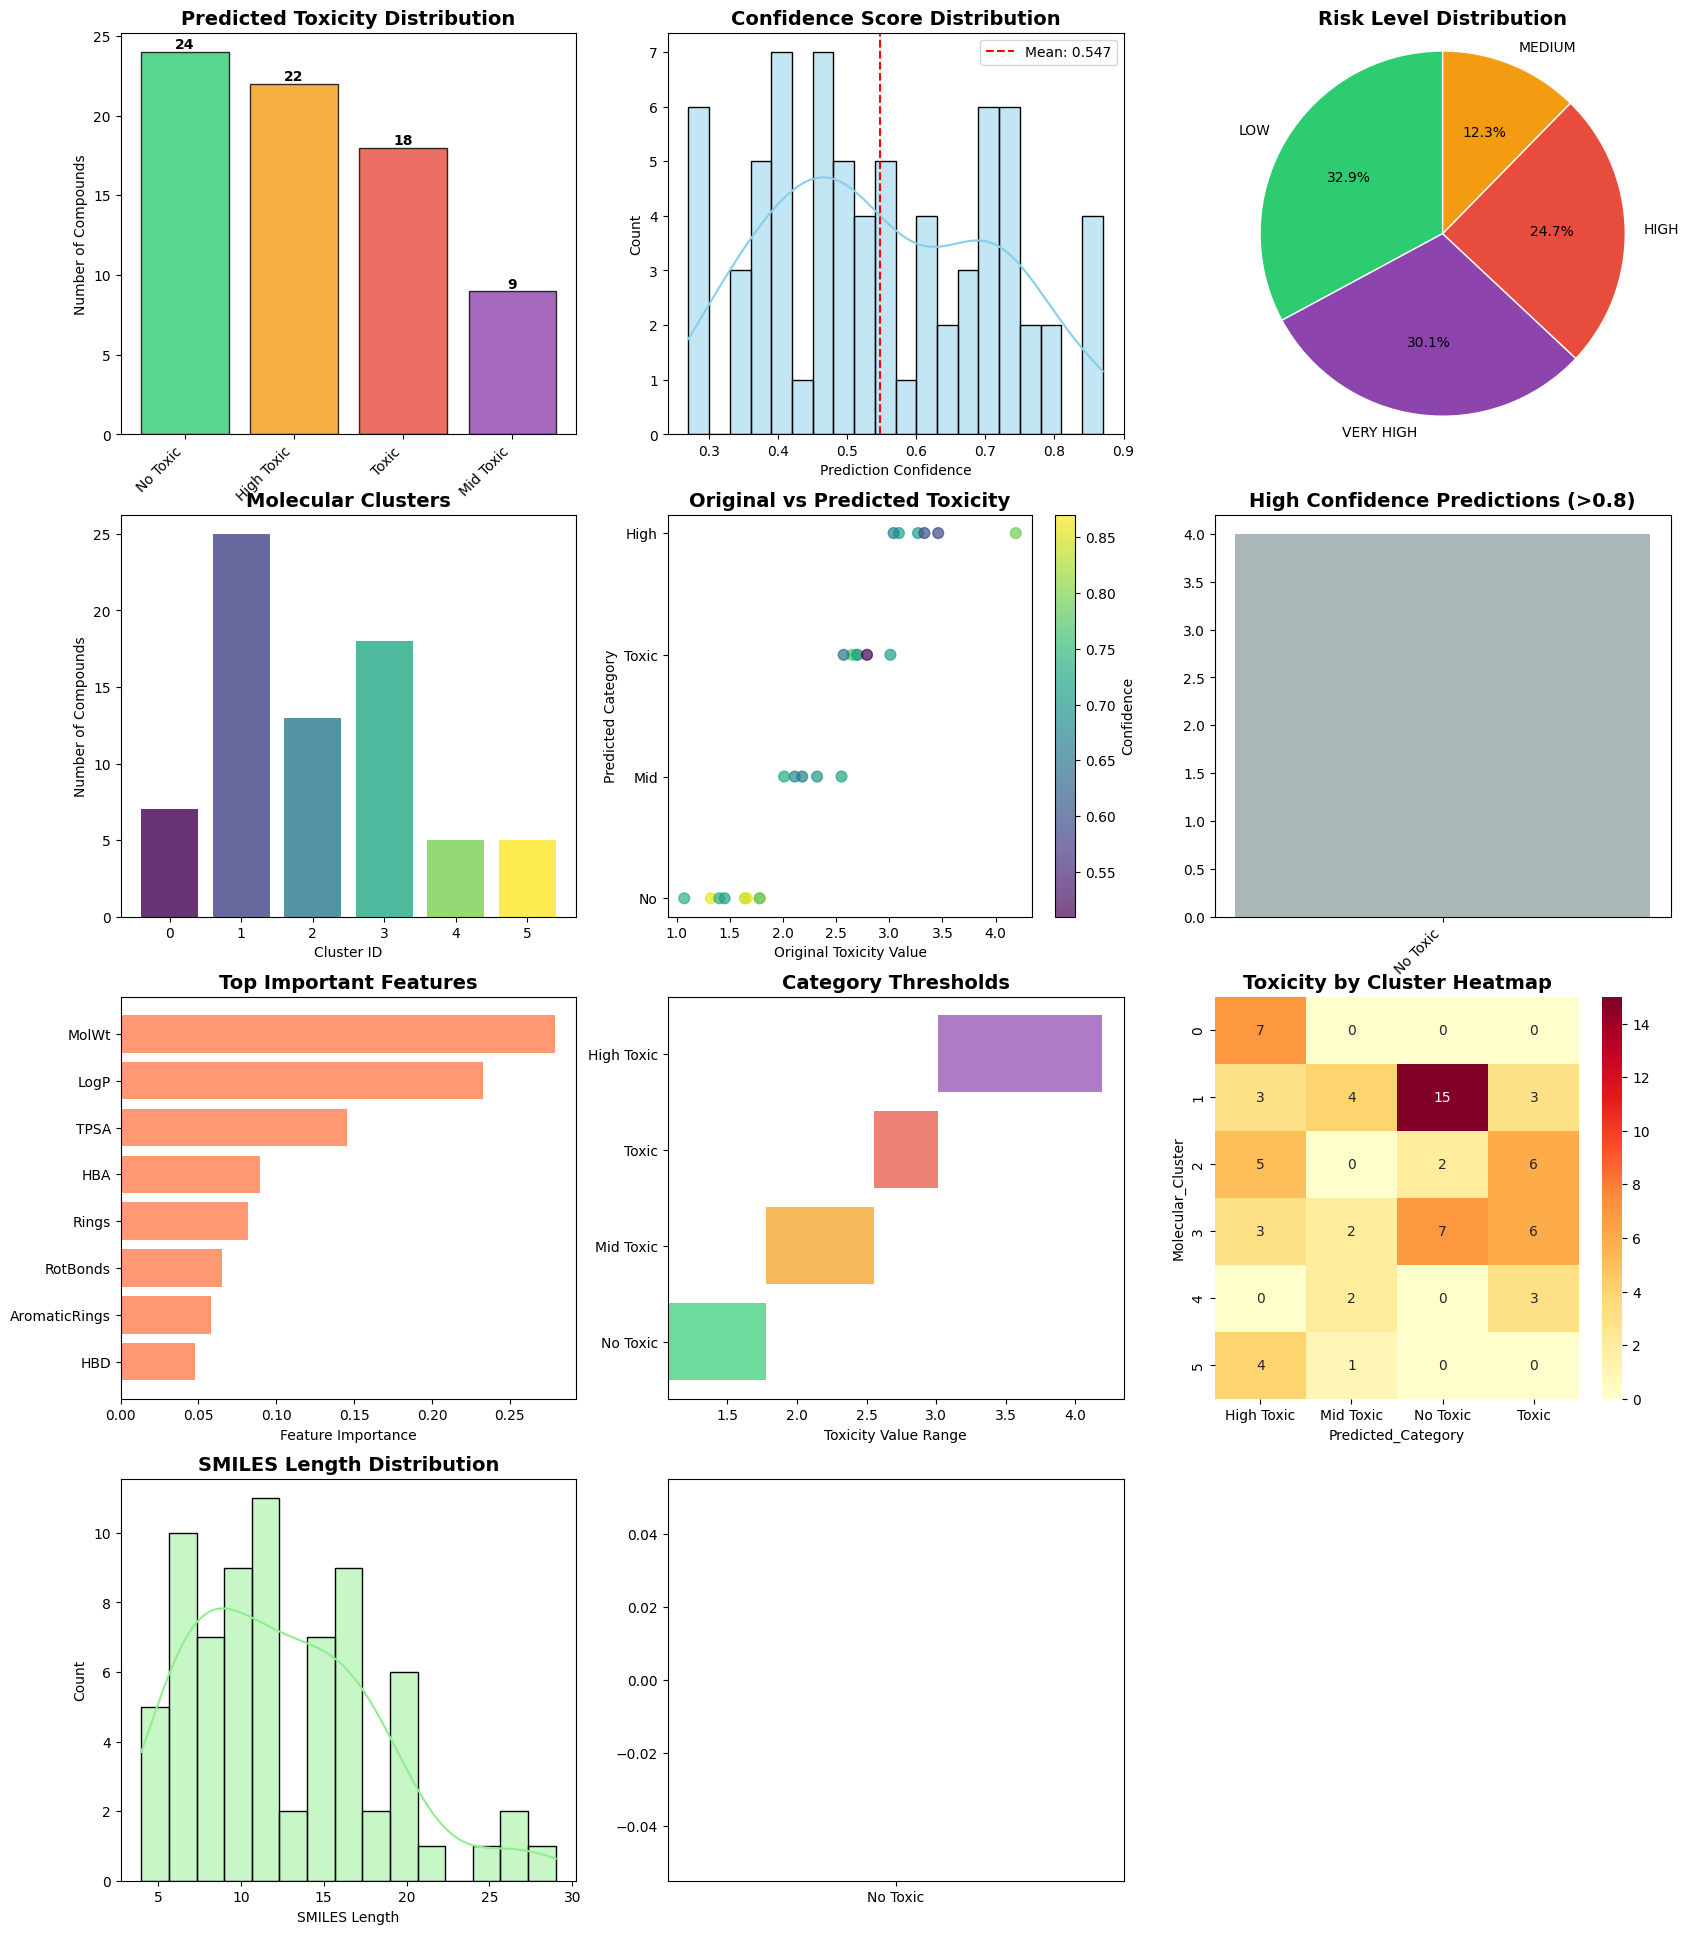

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch
import warnings
import io

warnings.filterwarnings('ignore')

# Google Colab imports for interactive file upload
try:
    from google.colab import files
    COLAB_AVAILABLE = True
except ImportError:
    COLAB_AVAILABLE = False

# PDF generation imports
try:
    from matplotlib.backends.backend_pdf import PdfPages
    PDF_AVAILABLE = True
except ImportError:
    PDF_AVAILABLE = False
    print("⚠️ PDF generation library not found. Please install with 'pip install matplotlib'.")

# RDKit imports for molecular feature calculation
try:
    from rdkit import Chem
    from rdkit.Chem import Descriptors
    RDKIT_AVAILABLE = True
except ImportError:
    RDKIT_AVAILABLE = False
    print("⚠️ RDKit not found. Using simple features. For better results, install with 'pip install rdkit'.")

class ComprehensiveToxicityPredictor:
    def __init__(self):
        self.scaler = StandardScaler()
        self.pca = None
        self.classification_model = None
        self.features = None
        self.feature_names = None
        self.cluster_labels = None
        self.selected_features = None
        self.category_thresholds = None
        self.predictions_df = None
        self.original_df = None
        self.id_col = None
        self.smiles_col = None
        self.toxicity_col = None
        self.filtered_df = None

    def process_uploaded_file(self, file_source):
        """Process the uploaded file from a path or file-like object."""
        print(f"📊 Processing input data...")

        try:
            # Load dataset
            self.original_df = pd.read_csv(file_source, encoding='utf-8')
            print(f"✅ Loaded: {self.original_df.shape[0]} rows × {self.original_df.shape[1]} columns")

            # Auto-detect columns
            self.id_col = self.auto_detect_id_column(self.original_df)
            self.smiles_col = self.auto_detect_smiles_column(self.original_df)
            self.toxicity_col = self.auto_detect_toxicity_column(self.original_df)

            if self.smiles_col is None:
                print("❌ No SMILES column found. Cannot proceed.")
                return None

            print(f"🆔 ID column: {self.id_col}")
            print(f"🧬 SMILES column: {self.smiles_col}")
            print(f"☠️  Toxicity column: {self.toxicity_col}")

            # Extract data
            valid_indices = self.original_df[self.smiles_col].notna()
            self.filtered_df = self.original_df[valid_indices].copy()

            smiles_list = self.filtered_df[self.smiles_col].astype(str).tolist()

            if self.toxicity_col:
                toxicity_values = pd.to_numeric(self.filtered_df[self.toxicity_col], errors='coerce').values
            else:
                toxicity_values = np.full(len(smiles_list), np.nan)

            print(f"✅ Extracted {len(smiles_list)} valid SMILES strings.")

            # Run analysis
            return self.run_analysis(smiles_list, toxicity_values)

        except Exception as e:
            print(f"❌ Error processing file: {e}")
            import traceback
            traceback.print_exc()
            return None

    def run_analysis(self, smiles_list, toxicity_values):
        """Orchestrates the entire analysis workflow."""
        print("\n🚀 Starting comprehensive analysis workflow...")

        # 1. Feature Extraction
        self.features, self.feature_names = self.compute_molecular_features(smiles_list)

        # 2. Toxicity Categorization
        known_categories, self.category_thresholds = self.categorize_toxicity(toxicity_values)

        # 3. Clustering
        self.cluster_labels = self.perform_clustering(self.features)

        # 4. Model Building
        self.classification_model, selector = self.build_prediction_model(self.features, known_categories)

        # 5. Prediction
        final_predictions, confidence = self.predict_all_toxicity(self.features, known_categories, self.classification_model, selector)

        # 6. Results Compilation
        self.predictions_df = self.create_results_dataframe(smiles_list, toxicity_values, final_predictions, confidence, self.cluster_labels)

        # 7. CSV Export
        csv_filename = 'toxicity_predictions.csv'
        self.predictions_df.to_csv(csv_filename, index=False)
        print(f"\n💾 Results saved to '{csv_filename}'")

        # 8. PDF Report Generation
        self.generate_comprehensive_pdf(self.predictions_df)

        print("\n🎉 Analysis complete!")
        return self.predictions_df

    def auto_detect_id_column(self, df):
        """Auto-detect ID column"""
        id_keywords = ['id', 'index', 'compound', 'name', 'number']
        for col in df.columns:
            if any(kw in col.lower() for kw in id_keywords):
                return col
        # Fallback to first column if it looks like an ID
        first_col = df.columns[0]
        if df[first_col].dtype in ['int64', 'object'] and df[first_col].nunique() == len(df):
            return first_col
        return None

    def auto_detect_smiles_column(self, df):
        """Auto-detect SMILES column"""
        smiles_keywords = ['smiles', 'smi', 'query', 'structure', 'mol', 'canonical']
        for col in df.columns:
            if any(kw in col.lower() for kw in smiles_keywords):
                sample_vals = df[col].dropna().head(5).astype(str)
                if all(any(c in val for c in 'CNOSPFBr()=[]#') for val in sample_vals):
                    return col
        # Fallback
        for col in df.columns:
            if df[col].dtype == 'object':
                sample_vals = df[col].dropna().head(10).astype(str)
                chemical_count = sum(1 for val in sample_vals if any(c in val for c in 'CNOSPFBr()=[]#') and len(val) > 2)
                if chemical_count >= len(sample_vals) * 0.7:
                    return col
        return None

    def auto_detect_toxicity_column(self, df):
        """Auto-detect toxicity column"""
        tox_keywords = ['exp_value', 'toxic', 'activity', 'value', 'lc50', 'ic50', 'log', 'mol/kg']
        for col in df.columns:
            if any(kw in col.lower() for kw in tox_keywords):
                try:
                    numeric_data = pd.to_numeric(df[col], errors='coerce')
                    if numeric_data.count() > 0:
                        return col
                except:
                    continue
        return None

    def categorize_toxicity(self, toxicity_values):
        """Categorize toxicity into 4 levels"""
        valid_tox = toxicity_values[~np.isnan(toxicity_values)]
        if len(valid_tox) == 0:
            return np.full(len(toxicity_values), 'Unknown', dtype=object), None

        q25 = np.percentile(valid_tox, 25)
        q50 = np.percentile(valid_tox, 50)
        q75 = np.percentile(valid_tox, 75)

        self.category_thresholds = {
            'No Toxic': (valid_tox.min(), q25),
            'Mid Toxic': (q25, q50),
            'Toxic': (q50, q75),
            'High Toxic': (q75, valid_tox.max())
        }

        print("🎯 Toxicity categories defined by quartiles:")
        for cat, (min_val, max_val) in self.category_thresholds.items():
            print(f"  • {cat}: {min_val:.3f} - {max_val:.3f}")

        categories = np.full(len(toxicity_values), 'Unknown', dtype=object)
        for i, tox_val in enumerate(toxicity_values):
            if not np.isnan(tox_val):
                if tox_val <= q25: categories[i] = 'No Toxic'
                elif tox_val <= q50: categories[i] = 'Mid Toxic'
                elif tox_val <= q75: categories[i] = 'Toxic'
                else: categories[i] = 'High Toxic'

        return categories, self.category_thresholds

    def compute_molecular_features(self, smiles_list):
        """Compute molecular features"""
        print(f"🧪 Computing molecular features using {'RDKit' if RDKIT_AVAILABLE else 'simple method'}...")
        if RDKIT_AVAILABLE:
            return self.rdkit_features(smiles_list)
        else:
            return self.simple_features(smiles_list)

    def rdkit_features(self, smiles_list):
        """RDKit molecular descriptors"""
        features = []
        feature_names = ['MolWt', 'LogP', 'HBD', 'HBA', 'TPSA', 'RotBonds', 'AromaticRings', 'Rings']
        for smiles in smiles_list:
            try:
                mol = Chem.MolFromSmiles(smiles)
                if mol:
                    mol_features = [
                        Descriptors.MolWt(mol), Descriptors.MolLogP(mol),
                        Descriptors.NumHDonors(mol), Descriptors.NumHAcceptors(mol),
                        Descriptors.TPSA(mol), Descriptors.NumRotatableBonds(mol),
                        Descriptors.NumAromaticRings(mol), Descriptors.RingCount(mol)
                    ]
                else:
                    mol_features = [0.0] * len(feature_names)
                features.append(mol_features)
            except:
                features.append([0.0] * len(feature_names))
        return np.array(features), feature_names

    def simple_features(self, smiles_list):
        """Simple molecular features"""
        features = []
        feature_names = ['Length', 'C_count', 'N_count', 'O_count', 'Aromatic', 'DoubleBonds']
        for smiles in smiles_list:
            try:
                features.append([
                    len(smiles), smiles.upper().count('C'), smiles.upper().count('N'),
                    smiles.upper().count('O'), smiles.count('c'), smiles.count('=')
                ])
            except:
                features.append([0.0] * len(feature_names))
        return np.array(features), feature_names

    def perform_clustering(self, features):
        """Perform molecular clustering"""
        print("🔬 Clustering molecules...")
        features_scaled = self.scaler.fit_transform(features)

        if features.shape[1] > 8:
            self.pca = PCA(n_components=8)
            features_final = self.pca.fit_transform(features_scaled)
        else:
            features_final = features_scaled

        n_clusters = min(6, max(2, len(features) // 12))
        clusterer = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
        cluster_labels = clusterer.fit_predict(features_final)

        print(f"✅ Created {len(np.unique(cluster_labels))} molecular clusters.")
        return cluster_labels

    def build_prediction_model(self, features, categories):
        """Build toxicity prediction model"""
        print("🤖 Building prediction model...")
        known_mask = categories != 'Unknown'
        if np.sum(known_mask) < 10:
            print("⚠️ Insufficient training data (<10 samples). Skipping model training.")
            return None, None

        X_train = features[known_mask]
        y_train = categories[known_mask]

        le = LabelEncoder()
        y_encoded = le.fit_transform(y_train)

        k_features = min(8, X_train.shape[1])
        selector = SelectKBest(score_func=f_classif, k=k_features)
        X_selected = selector.fit_transform(X_train, y_encoded)

        selected_indices = selector.get_support(indices=True)
        self.selected_features = [self.feature_names[i] for i in selected_indices]

        model = RandomForestClassifier(n_estimators=100, random_state=42)
        model.fit(X_selected, y_train)

        print(f"✅ Model trained with {len(self.selected_features)} features: {self.selected_features}")
        return model, selector

    def predict_all_toxicity(self, features, known_categories, model, selector):
        """Predict toxicity for all compounds"""
        if model is None:
            print("🔮 Prediction skipped as no model was built.")
            return known_categories, np.full(len(known_categories), 0.0)

        print("🔮 Predicting toxicity for all compounds...")
        X_selected = selector.transform(features)
        predictions = model.predict(X_selected)
        probabilities = model.predict_proba(X_selected)
        confidence = np.max(probabilities, axis=1)

        final_predictions = known_categories.copy()
        unknown_mask = known_categories == 'Unknown'
        final_predictions[unknown_mask] = predictions[unknown_mask]

        print(f"✅ Made predictions for {np.sum(unknown_mask)} unknown compounds.")
        return final_predictions, confidence

    def create_results_dataframe(self, smiles_list, toxicity_values, predictions, confidence, clusters):
        """Create comprehensive results dataframe"""
        results_df = pd.DataFrame({
            'Index': range(1, len(smiles_list) + 1),
            'ID': self.filtered_df[self.id_col].values if self.id_col else [f'COMP_{i+1:03d}' for i in range(len(smiles_list))],
            'SMILES': smiles_list,
            'Original_Toxicity_Value': toxicity_values,
            'Predicted_Category': predictions,
            'Confidence_Score': confidence,
            'Molecular_Cluster': clusters
        })

        risk_mapping = {
            'No Toxic': 'LOW', 'Mid Toxic': 'MEDIUM', 'Toxic': 'HIGH',
            'High Toxic': 'VERY HIGH', 'Unknown': 'UNKNOWN'
        }
        results_df['Risk_Level'] = results_df['Predicted_Category'].map(risk_mapping)

        if self.features is not None and len(self.feature_names) > 0:
            for i, feature_name in enumerate(self.feature_names):
                if i < self.features.shape[1]:
                    results_df[f'Feature_{feature_name}'] = self.features[:, i]

        category_explanation = {
            'No Toxic': 'Low toxicity - Generally safe',
            'Mid Toxic': 'Moderate toxicity - Use with caution',
            'Toxic': 'High toxicity - Significant risk',
            'High Toxic': 'Very high toxicity - Extreme caution',
            'Unknown': 'Toxicity unknown - Requires testing'
        }
        results_df['Toxicity_Explanation'] = results_df['Predicted_Category'].map(category_explanation)

        results_df = results_df.sort_values('Confidence_Score', ascending=False).reset_index(drop=True)
        return results_df

    def create_workflow_flowchart(self):
        """Create analysis workflow flowchart"""
        fig, ax = plt.subplots(figsize=(14, 10))
        ax.set_xlim(0, 10)
        ax.set_ylim(0, 12)
        ax.axis('off')

        boxes = [
            {'text': '1. Dataset Upload\n& Loading', 'xy': (2, 10.5), 'color': '#3498db'},
            {'text': '2. Column Detection\n(ID, SMILES, Toxicity)', 'xy': (2, 9), 'color': '#2ecc71'},
            {'text': '3. Data Preprocessing\n& Cleaning', 'xy': (2, 7.5), 'color': '#f39c12'},
            {'text': '4. Molecular Feature\nExtraction (RDKit)', 'xy': (2, 6), 'color': '#e74c3c'},
            {'text': '5. Toxicity\nCategorization', 'xy': (5.5, 9), 'color': '#9b59b6'},
            {'text': '6. Molecular\nClustering', 'xy': (5.5, 7.5), 'color': '#1abc9c'},
            {'text': '7. ML Model\nTraining', 'xy': (5.5, 6), 'color': '#e67e22'},
            {'text': '8. Toxicity Prediction\nfor All Compounds', 'xy': (8, 7.5), 'color': '#34495e'},
            {'text': '9. Results Compilation\n& Analysis', 'xy': (5.5, 4.5), 'color': '#95a5a6'},
            {'text': '10. PDF Report\nGeneration', 'xy': (2, 3), 'color': '#d35400'},
            {'text': '11. CSV Export\n& Download', 'xy': (8, 3), 'color': '#27ae60'}
        ]

        for box in boxes:
            bbox = FancyBboxPatch((box['xy'][0]-0.8, box['xy'][1]-0.4), 1.6, 0.8,
                                  boxstyle="round,pad=0.1", facecolor=box['color'],
                                  edgecolor='black', alpha=0.8)
            ax.add_patch(bbox)
            ax.text(box['xy'][0], box['xy'][1], box['text'], ha='center', va='center',
                    fontsize=9, fontweight='bold', color='white', wrap=True)

        arrows = [
            ((2, 10.1), (2, 9.4)), ((2, 8.6), (2, 7.9)), ((2, 7.1), (2, 6.4)),
            ((2.8, 9), (4.7, 9)), ((2.8, 7.5), (4.7, 7.5)), ((2.8, 6), (4.7, 6)),
            ((6.3, 9), (7.2, 8.2)), ((6.3, 7.5), (7.2, 7.5)), ((6.3, 6), (7.2, 6.8)),
            ((8, 7.1), (6.3, 4.9)), ((4.7, 4.5), (2.8, 3.4)), ((6.3, 4.5), (7.2, 3.4))
        ]

        for start, end in arrows:
            ax.annotate('', xy=end, xytext=start,
                        arrowprops=dict(arrowstyle='->', lw=2, color='black'))

        ax.set_title('Comprehensive Toxicity Analysis Workflow', fontsize=18, fontweight='bold', pad=20)
        return fig

    def create_comprehensive_visualizations(self, results_df):
        """Create comprehensive visualization suite"""
        fig = plt.figure(figsize=(20, 24))

        # Plot 1: Toxicity Category Distribution
        ax1 = plt.subplot(4, 3, 1)
        category_counts = results_df['Predicted_Category'].value_counts()
        colors = ['#2ecc71', '#f39c12', '#e74c3c', '#8e44ad', '#95a5a6']
        bars = ax1.bar(category_counts.index, category_counts.values,
                       color=colors[:len(category_counts)], alpha=0.8, edgecolor='black')
        ax1.set_title('Predicted Toxicity Distribution', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Number of Compounds')
        plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha="right")
        for bar in bars:
            ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                     f'{int(bar.get_height())}', ha='center', va='bottom', fontweight='bold')

        # Plot 2: Confidence Score Distribution
        ax2 = plt.subplot(4, 3, 2)
        sns.histplot(results_df['Confidence_Score'], bins=20, ax=ax2, color='skyblue', kde=True)
        ax2.axvline(results_df['Confidence_Score'].mean(), color='red', linestyle='--',
                    label=f'Mean: {results_df["Confidence_Score"].mean():.3f}')
        ax2.set_xlabel('Prediction Confidence')
        ax2.set_title('Confidence Score Distribution', fontsize=14, fontweight='bold')
        ax2.legend()

        # Plot 3: Risk Level Pie Chart
        ax3 = plt.subplot(4, 3, 3)
        risk_counts = results_df['Risk_Level'].value_counts()
        colors_pie = {'LOW': '#2ecc71', 'MEDIUM': '#f39c12', 'HIGH': '#e74c3c', 'VERY HIGH': '#8e44ad', 'UNKNOWN': '#95a5a6'}
        pie_colors = [colors_pie[key] for key in risk_counts.index]
        ax3.pie(risk_counts.values, labels=risk_counts.index, autopct='%1.1f%%', startangle=90, colors=pie_colors,
                wedgeprops={'edgecolor': 'white'})
        ax3.set_title('Risk Level Distribution', fontsize=14, fontweight='bold')
        ax3.axis('equal')

        # Plot 4: Cluster Analysis
        ax4 = plt.subplot(4, 3, 4)
        cluster_counts = results_df['Molecular_Cluster'].value_counts().sort_index()
        ax4.bar(cluster_counts.index, cluster_counts.values,
                color=plt.cm.viridis(np.linspace(0, 1, len(cluster_counts))), alpha=0.8)
        ax4.set_xlabel('Cluster ID')
        ax4.set_ylabel('Number of Compounds')
        ax4.set_title('Molecular Clusters', fontsize=14, fontweight='bold')
        ax4.set_xticks(cluster_counts.index)

        # Plot 5: Original vs Predicted Toxicity
        ax5 = plt.subplot(4, 3, 5)
        valid_original = ~results_df['Original_Toxicity_Value'].isna()
        if valid_original.sum() > 0:
            orig_data = results_df[valid_original]
            cat_mapping = {'No Toxic': 1, 'Mid Toxic': 2, 'Toxic': 3, 'High Toxic': 4}
            y_pred_numeric = orig_data['Predicted_Category'].map(cat_mapping)
            scatter = ax5.scatter(orig_data['Original_Toxicity_Value'], y_pred_numeric,
                                  c=orig_data['Confidence_Score'], cmap='viridis', alpha=0.7, s=60)
            ax5.set_xlabel('Original Toxicity Value')
            ax5.set_ylabel('Predicted Category')
            ax5.set_title('Original vs Predicted Toxicity', fontsize=14, fontweight='bold')
            ax5.set_yticks([1, 2, 3, 4])
            ax5.set_yticklabels(['No', 'Mid', 'Toxic', 'High'])
            plt.colorbar(scatter, ax=ax5, label='Confidence')

        # Plot 6: High Confidence Predictions
        ax6 = plt.subplot(4, 3, 6)
        high_conf = results_df[results_df['Confidence_Score'] > 0.8]
        if len(high_conf) > 0:
            conf_counts = high_conf['Predicted_Category'].value_counts()
            ax6.bar(conf_counts.index, conf_counts.values, alpha=0.8,
                    color=[colors_pie.get(c.replace(' Toxic', '').upper(), '#95a5a6') for c in conf_counts.index])
            ax6.set_title('High Confidence Predictions (>0.8)', fontsize=14, fontweight='bold')
            plt.setp(ax6.xaxis.get_majorticklabels(), rotation=45, ha="right")

        # Plot 7: Feature Importance
        if hasattr(self, 'classification_model') and self.classification_model is not None:
            ax7 = plt.subplot(4, 3, 7)
            importance = self.classification_model.feature_importances_
            feature_names = self.selected_features
            sorted_idx = np.argsort(importance)
            ax7.barh(np.array(feature_names)[sorted_idx], importance[sorted_idx], color='coral', alpha=0.8)
            ax7.set_xlabel('Feature Importance')
            ax7.set_title('Top Important Features', fontsize=14, fontweight='bold')

        # Plot 8: Toxicity Thresholds
        ax8 = plt.subplot(4, 3, 8)
        if self.category_thresholds:
            categories = list(self.category_thresholds.keys())
            widths = [v[1] - v[0] for v in self.category_thresholds.values()]
            starts = [v[0] for v in self.category_thresholds.values()]
            ax8.barh(categories, widths, left=starts, alpha=0.7,
                     color=['#2ecc71', '#f39c12', '#e74c3c', '#8e44ad'])
            ax8.set_xlabel('Toxicity Value Range')
            ax8.set_title('Category Thresholds', fontsize=14, fontweight='bold')

        # Plot 9: Cluster vs Toxicity Heatmap
        ax9 = plt.subplot(4, 3, 9)
        contingency = pd.crosstab(results_df['Molecular_Cluster'], results_df['Predicted_Category'])
        sns.heatmap(contingency, annot=True, fmt='d', cmap='YlOrRd', ax=ax9)
        ax9.set_title('Toxicity by Cluster Heatmap', fontsize=14, fontweight='bold')

        # Plot 10: SMILES Length Distribution
        ax10 = plt.subplot(4, 3, 10)
        results_df['SMILES_Length'] = results_df['SMILES'].str.len()
        sns.histplot(results_df['SMILES_Length'], bins=15, ax=ax10, color='lightgreen', kde=True)
        ax10.set_xlabel('SMILES Length')
        ax10.set_title('SMILES Length Distribution', fontsize=14, fontweight='bold')

        # Plot 11: Confidence by Category
        ax11 = plt.subplot(4, 3, 11)
        category_order = ['No Toxic', 'Mid Toxic', 'Toxic', 'High Toxic']
        sns.boxplot(x='Predicted_Category', y='Confidence_Score', data=results_df, order=category_order,
                    ax=ax11, palette=[colors_pie.get(c.replace(' Toxic', '').upper()) for c in category_order])
        ax11.set_title('Confidence by Category', fontsize=14, fontweight='bold')
        plt.setp(ax11.xaxis.get_majorticklabels(), rotation=45, ha="right")
        ax11.set_xlabel('')

        # Plot 12: Summary Statistics Text
        ax12 = plt.subplot(4, 3, 12)
        ax12.axis('off')
        stats_text = f"""
COMPREHENSIVE ANALYSIS SUMMARY
==============================
Total Compounds: {len(results_df):,}
Average Confidence: {results_df['Confidence_Score'].mean():.3f}
High Confidence (>0.8): {(results_df['Confidence_Score'] > 0.8).sum():,}

CATEGORY DISTRIBUTION:
"""
        for cat, count in category_counts.items():
            stats_text += f"• {cat:<10}: {count:>4} ({(count/len(results_df)*100):.1f}%)\n"
        stats_text += "\nRISK LEVELS:\n"
        for risk, count in risk_counts.items():
            stats_text += f"• {risk:<10}: {count:>4} ({(count/len(results_df)*100):.1f}%)\n"

        ax12.text(0, 0.95, stats_text, transform=ax12.transAxes,
                  fontsize=11, verticalalignment='top', fontfamily='monospace')

        plt.tight_layout(pad=3.0)
        return fig

    def _df_to_pdf_table(self, pdf, df):
        """Helper function to add a DataFrame as a table to a PDF, handling pagination."""
        df_display = df[['ID', 'SMILES', 'Original_Toxicity_Value', 'Predicted_Category', 'Risk_Level', 'Confidence_Score', 'Molecular_Cluster']]
        df_display['Original_Toxicity_Value'] = df_display['Original_Toxicity_Value'].round(3)
        df_display['Confidence_Score'] = df_display['Confidence_Score'].round(3)

        rows_per_page = 40
        num_pages = int(np.ceil(len(df_display) / rows_per_page))

        for i in range(num_pages):
            fig, ax = plt.subplots(figsize=(11.69, 8.27)) # A4 Landscape
            ax.axis('tight')
            ax.axis('off')

            start_row = i * rows_per_page
            end_row = start_row + rows_per_page
            chunk = df_display.iloc[start_row:end_row]

            table = ax.table(cellText=chunk.values, colLabels=chunk.columns, cellLoc='center', loc='center', colWidths=[0.15, 0.3, 0.1, 0.1, 0.1, 0.1, 0.1])
            table.auto_set_font_size(False)
            table.set_fontsize(8)
            table.scale(1, 1.2)

            ax.set_title(f'Toxicity Prediction Results - Page {i+1} of {num_pages}', fontsize=14, fontweight='bold', pad=20)
            pdf.savefig(fig, bbox_inches='tight')
            plt.close(fig)

    def generate_comprehensive_pdf(self, results_df):
        """Generate comprehensive PDF report with flowchart and complete dataset"""
        if not PDF_AVAILABLE:
            print("❌ PDF generation not available.")
            return

        filename = 'Comprehensive_SMILES_Toxicity_Report.pdf'
        print(f"📄 Generating comprehensive PDF report: '{filename}'...")

        with PdfPages(filename) as pdf:
            # Page 1: Title Page
            fig_title = plt.figure(figsize=(11.69, 8.27))
            fig_title.text(0.5, 0.6, 'Comprehensive SMILES Toxicity Analysis Report', ha='center', va='center', fontsize=24, fontweight='bold')
            fig_title.text(0.5, 0.45, f'Analysis of {len(results_df)} Compounds', ha='center', va='center', fontsize=18)
            fig_title.text(0.5, 0.35, f'Generated on: {pd.to_datetime("today").strftime("%Y-%m-%d %H:%M:%S")}', ha='center', va='center', fontsize=12, color='gray')
            pdf.savefig(fig_title)
            plt.close(fig_title)

            # Page 2: Workflow Flowchart
            print("  - Adding workflow flowchart...")
            fig1 = self.create_workflow_flowchart()
            pdf.savefig(fig1, bbox_inches='tight', dpi=300)
            plt.close(fig1)

            # Page 3: Comprehensive Visualizations
            print("  - Adding visualizations dashboard...")
            fig2 = self.create_comprehensive_visualizations(results_df)
            pdf.savefig(fig2, bbox_inches='tight', dpi=300)
            plt.close(fig2)

            # Subsequent Pages: Full Dataset
            print(f"  - Adding full dataset ({len(results_df)} rows)...")
            self._df_to_pdf_table(pdf, results_df)

        print(f"✅ PDF report successfully generated.")

# --- Main Execution Block ---
if __name__ == '__main__':
    print("🚀 Auto Toxicity Predictor Initialized 🚀")

    # Initialize the predictor
    predictor = ComprehensiveToxicityPredictor()
    file_source = None

    # Check if running in Google Colab for an interactive upload button
    if COLAB_AVAILABLE:
        print("\nPlease choose a CSV file to upload.")
        try:
            uploaded = files.upload()
            if not uploaded:
                print("\n❌ No file selected. Analysis cancelled.")
            else:
                # Get the name of the uploaded file
                file_source = next(iter(uploaded))
                print(f"\n✅ File '{file_source}' uploaded successfully.")
        except Exception as e:
            print(f"\n❌ An error occurred during file upload: {e}")

    # If not in Colab, ask for a local file path
    else:
        print("\nThis script is not running in Google Colab.")
        file_path = input("➡️ Please enter the full path to your CSV file and press Enter: ").strip()
        if not file_path:
             print("\n❌ No file path entered. Analysis cancelled.")
        else:
            file_source = file_path

    # If a file source has been successfully identified, run the analysis
    if file_source:
        try:
            results = predictor.process_uploaded_file(file_source)

            if results is not None:
                print("\n--- Top 5 Most Confident Predictions ---")
                print(results[['ID', 'SMILES', 'Predicted_Category', 'Risk_Level', 'Confidence_Score']].head(5))
                print(f"\n\n⬇️  YOUR FILES ARE READY ⬇️")
                print(f"Your analysis is complete. Look for the generated files:")
                print(f"  1. Comprehensive_SMILES_Toxicity_Report.pdf")
                print(f"  2. toxicity_predictions.csv")
                if COLAB_AVAILABLE:
                    print(f"In Google Colab, find them in the file browser panel to the left.")
                else:
                    print(f"On your local machine, find them in the same directory where you ran the script.")

        except FileNotFoundError:
            print(f"\n❌ Error: The file was not found at '{file_source}'. Please check the path and try again.")
        except Exception as e:
            print(f"\n❌ An unexpected error occurred during analysis: {e}")


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch
import warnings
import io

warnings.filterwarnings('ignore')

# Google Colab imports for interactive file upload
try:
    from google.colab import files
    COLAB_AVAILABLE = True
except ImportError:
    COLAB_AVAILABLE = False

# PDF generation imports
try:
    from matplotlib.backends.backend_pdf import PdfPages
    PDF_AVAILABLE = True
except ImportError:
    PDF_AVAILABLE = False
    print("⚠️ PDF generation library not found. Please install with 'pip install matplotlib'.")

# RDKit imports for molecular feature calculation
try:
    from rdkit import Chem
    from rdkit.Chem import Descriptors
    RDKIT_AVAILABLE = True
except ImportError:
    RDKIT_AVAILABLE = False
    print("⚠️ RDKit not found. Using simple features. For better results, install with 'pip install rdkit'.")

class ComprehensiveToxicityPredictor:
    def __init__(self):
        self.scaler = StandardScaler()
        self.pca = None
        self.classification_model = None
        self.features = None
        self.feature_names = None
        self.cluster_labels = None
        self.selected_features = None
        self.category_thresholds = None
        self.predictions_df = None
        self.original_df = None
        self.id_col = None
        self.smiles_col = None
        self.toxicity_col = None
        self.filtered_df = None

    def process_uploaded_file(self, file_source):
        """Process the uploaded file from a path or file-like object."""
        print(f"📊 Processing input data...")

        try:
            # Load dataset
            self.original_df = pd.read_csv(file_source, encoding='utf-8')
            print(f"✅ Loaded: {self.original_df.shape[0]} rows × {self.original_df.shape[1]} columns")

            # Auto-detect columns
            self.id_col = self.auto_detect_id_column(self.original_df)
            self.smiles_col = self.auto_detect_smiles_column(self.original_df)
            self.toxicity_col = self.auto_detect_toxicity_column(self.original_df)

            if self.smiles_col is None:
                print("❌ No SMILES column found. Cannot proceed.")
                return None

            print(f"🆔 ID column: {self.id_col}")
            print(f"🧬 SMILES column: {self.smiles_col}")
            print(f"☠️  Toxicity column: {self.toxicity_col}")

            # Extract data
            valid_indices = self.original_df[self.smiles_col].notna()
            self.filtered_df = self.original_df[valid_indices].copy()

            smiles_list = self.filtered_df[self.smiles_col].astype(str).tolist()

            if self.toxicity_col:
                toxicity_values = pd.to_numeric(self.filtered_df[self.toxicity_col], errors='coerce').values
            else:
                toxicity_values = np.full(len(smiles_list), np.nan)

            print(f"✅ Extracted {len(smiles_list)} valid SMILES strings.")

            # Run analysis
            return self.run_analysis(smiles_list, toxicity_values)

        except Exception as e:
            print(f"❌ Error processing file: {e}")
            import traceback
            traceback.print_exc()
            return None

    def run_analysis(self, smiles_list, toxicity_values):
        """Orchestrates the entire analysis workflow."""
        print("\n🚀 Starting comprehensive analysis workflow...")

        # 1. Feature Extraction
        self.features, self.feature_names = self.compute_molecular_features(smiles_list)
        # 2. Toxicity Categorization
        known_categories, self.category_thresholds = self.categorize_toxicity(toxicity_values)
        # 3. Clustering
        self.cluster_labels = self.perform_clustering(self.features)
        # 4. Model Building
        self.classification_model, selector = self.build_prediction_model(self.features, known_categories)
        # 5. Prediction
        final_predictions, confidence = self.predict_all_toxicity(self.features, known_categories, self.classification_model, selector)
        # 6. Results Compilation
        self.predictions_df = self.create_results_dataframe(smiles_list, toxicity_values, final_predictions, confidence, self.cluster_labels)
        # 7. CSV Export
        csv_filename = 'toxicity_predictions.csv'
        self.predictions_df.to_csv(csv_filename, index=False)
        print(f"\n💾 Results saved to '{csv_filename}'")
        # 8. PDF Report Generation
        self.generate_comprehensive_pdf(self.predictions_df)

        print("\n🎉 Analysis complete!")
        return self.predictions_df

    def auto_detect_id_column(self, df):
        """Auto-detect ID column"""
        id_keywords = ['id', 'index', 'compound', 'name', 'number']
        for col in df.columns:
            if any(kw in col.lower() for kw in id_keywords):
                return col
        first_col = df.columns[0]
        if df[first_col].dtype in ['int64', 'object'] and df[first_col].nunique() == len(df):
            return first_col
        return None

    def auto_detect_smiles_column(self, df):
        """Auto-detect SMILES column"""
        smiles_keywords = ['smiles', 'smi', 'query', 'structure', 'mol', 'canonical']
        for col in df.columns:
            if any(kw in col.lower() for kw in smiles_keywords):
                sample_vals = df[col].dropna().head(5).astype(str)
                if all(any(c in val for c in 'CNOSPFBr()=[]#') for val in sample_vals):
                    return col
        for col in df.columns:
            if df[col].dtype == 'object':
                sample_vals = df[col].dropna().head(10).astype(str)
                chemical_count = sum(1 for val in sample_vals if any(c in val for c in 'CNOSPFBr()=[]#') and len(val) > 2)
                if chemical_count >= len(sample_vals) * 0.7:
                    return col
        return None

    def auto_detect_toxicity_column(self, df):
        """Auto-detect toxicity column"""
        tox_keywords = ['exp_value', 'toxic', 'activity', 'value', 'lc50', 'ic50', 'log', 'mol/kg']
        for col in df.columns:
            if any(kw in col.lower() for kw in tox_keywords):
                try:
                    numeric_data = pd.to_numeric(df[col], errors='coerce')
                    if numeric_data.count() > 0:
                        return col
                except:
                    continue
        return None

    def categorize_toxicity(self, toxicity_values):
        """Categorize toxicity into 4 levels"""
        valid_tox = toxicity_values[~np.isnan(toxicity_values)]
        if len(valid_tox) == 0:
            return np.full(len(toxicity_values), 'Unknown', dtype=object), None

        q25 = np.percentile(valid_tox, 25)
        q50 = np.percentile(valid_tox, 50)
        q75 = np.percentile(valid_tox, 75)
        self.category_thresholds = {'No Toxic': (valid_tox.min(), q25), 'Mid Toxic': (q25, q50), 'Toxic': (q50, q75), 'High Toxic': (q75, valid_tox.max())}

        print("🎯 Toxicity categories defined by quartiles:")
        for cat, (min_val, max_val) in self.category_thresholds.items():
            print(f"  • {cat}: {min_val:.3f} - {max_val:.3f}")

        categories = np.full(len(toxicity_values), 'Unknown', dtype=object)
        for i, tox_val in enumerate(toxicity_values):
            if not np.isnan(tox_val):
                if tox_val <= q25: categories[i] = 'No Toxic'
                elif tox_val <= q50: categories[i] = 'Mid Toxic'
                elif tox_val <= q75: categories[i] = 'Toxic'
                else: categories[i] = 'High Toxic'
        return categories, self.category_thresholds

    def compute_molecular_features(self, smiles_list):
        """Compute molecular features"""
        print(f"🧪 Computing molecular features using {'RDKit' if RDKIT_AVAILABLE else 'simple method'}...")
        if RDKIT_AVAILABLE:
            return self.rdkit_features(smiles_list)
        else:
            return self.simple_features(smiles_list)

    def rdkit_features(self, smiles_list):
        """RDKit molecular descriptors"""
        features, feature_names = [], ['MolWt', 'LogP', 'HBD', 'HBA', 'TPSA', 'RotBonds', 'AromaticRings', 'Rings']
        for smiles in smiles_list:
            try:
                mol = Chem.MolFromSmiles(smiles)
                mol_features = [Descriptors.MolWt(mol), Descriptors.MolLogP(mol), Descriptors.NumHDonors(mol), Descriptors.NumHAcceptors(mol), Descriptors.TPSA(mol), Descriptors.NumRotatableBonds(mol), Descriptors.NumAromaticRings(mol), Descriptors.RingCount(mol)] if mol else [0.0] * len(feature_names)
                features.append(mol_features)
            except:
                features.append([0.0] * len(feature_names))
        return np.array(features), feature_names

    def simple_features(self, smiles_list):
        """Simple molecular features"""
        features, feature_names = [], ['Length', 'C_count', 'N_count', 'O_count', 'Aromatic', 'DoubleBonds']
        for smiles in smiles_list:
            try:
                features.append([len(smiles), smiles.upper().count('C'), smiles.upper().count('N'), smiles.upper().count('O'), smiles.count('c'), smiles.count('=')])
            except:
                features.append([0.0] * len(feature_names))
        return np.array(features), feature_names

    def perform_clustering(self, features):
        """Perform molecular clustering"""
        print("🔬 Clustering molecules...")
        features_scaled = self.scaler.fit_transform(features)
        features_final = PCA(n_components=8).fit_transform(features_scaled) if features.shape[1] > 8 else features_scaled
        n_clusters = min(6, max(2, len(features) // 12))
        cluster_labels = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto').fit_predict(features_final)
        print(f"✅ Created {len(np.unique(cluster_labels))} molecular clusters.")
        return cluster_labels

    def build_prediction_model(self, features, categories):
        """Build toxicity prediction model"""
        print("🤖 Building prediction model...")
        known_mask = categories != 'Unknown'
        if np.sum(known_mask) < 10:
            print("⚠️ Insufficient training data (<10 samples). Skipping model training.")
            return None, None

        X_train, y_train = features[known_mask], categories[known_mask]
        y_encoded = LabelEncoder().fit_transform(y_train)
        selector = SelectKBest(score_func=f_classif, k=min(8, X_train.shape[1]))
        X_selected = selector.fit_transform(X_train, y_encoded)
        selected_indices = selector.get_support(indices=True)
        self.selected_features = [self.feature_names[i] for i in selected_indices]
        model = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_selected, y_train)
        print(f"✅ Model trained with {len(self.selected_features)} features: {self.selected_features}")
        return model, selector

    def predict_all_toxicity(self, features, known_categories, model, selector):
        """Predict toxicity for all compounds"""
        if model is None:
            print("🔮 Prediction skipped as no model was built.")
            return known_categories, np.full(len(known_categories), 0.0)

        print("🔮 Predicting toxicity for all compounds...")
        X_selected = selector.transform(features)
        predictions, probabilities = model.predict(X_selected), model.predict_proba(X_selected)
        confidence = np.max(probabilities, axis=1)
        final_predictions = np.copy(known_categories)
        unknown_mask = final_predictions == 'Unknown'
        final_predictions[unknown_mask] = predictions[unknown_mask]
        print(f"✅ Made predictions for {np.sum(unknown_mask)} unknown compounds.")
        return final_predictions, confidence

    def create_results_dataframe(self, smiles_list, toxicity_values, predictions, confidence, clusters):
        """Create comprehensive results dataframe"""
        results_df = pd.DataFrame({'ID': self.filtered_df[self.id_col].values if self.id_col else [f'COMP_{i+1:03d}' for i in range(len(smiles_list))], 'SMILES': smiles_list, 'Original_Toxicity_Value': toxicity_values, 'Predicted_Category': predictions, 'Confidence_Score': confidence, 'Molecular_Cluster': clusters})
        risk_mapping = {'No Toxic': 'LOW', 'Mid Toxic': 'MEDIUM', 'Toxic': 'HIGH', 'High Toxic': 'VERY HIGH', 'Unknown': 'UNKNOWN'}
        results_df['Risk_Level'] = results_df['Predicted_Category'].map(risk_mapping)
        if self.features is not None:
            for i, feature_name in enumerate(self.feature_names):
                results_df[f'Feature_{feature_name}'] = self.features[:, i]
        return results_df.sort_values('Confidence_Score', ascending=False).reset_index(drop=True)

    def _create_workflow_flowchart(self):
        """Creates the workflow flowchart figure."""
        fig, ax = plt.subplots(figsize=(14, 10))
        ax.set_xlim(0, 10); ax.set_ylim(0, 12); ax.axis('off')
        boxes = [{'text': '1. Dataset Upload', 'xy': (2, 10.5), 'color': '#3498db'}, {'text': '2. Column Detection', 'xy': (2, 9), 'color': '#2ecc71'}, {'text': '3. Feature Extraction', 'xy': (2, 7.5), 'color': '#f39c12'}, {'text': '4. Clustering & Modeling', 'xy': (5.5, 9), 'color': '#9b59b6'}, {'text': '5. Prediction', 'xy': (5.5, 7.5), 'color': '#1abc9c'}, {'text': '6. PDF/CSV Generation', 'xy': (8, 7.5), 'color': '#d35400'}]
        for box in boxes:
            bbox = FancyBboxPatch((box['xy'][0]-0.8, box['xy'][1]-0.4), 1.6, 0.8, boxstyle="round,pad=0.1", fc=box['color'], ec='black', alpha=0.8)
            ax.add_patch(bbox)
            ax.text(box['xy'][0], box['xy'][1], box['text'], ha='center', va='center', fontsize=9, fontweight='bold', color='white')
        arrows = [((2, 10.1), (2, 9.4)), ((2, 8.6), (2, 7.9)), ((2.8, 9), (4.7, 9)), ((2.8, 7.5), (4.7, 7.5)), ((6.3, 7.5), (7.2, 7.5))]
        for start, end in arrows:
            ax.annotate('', xy=end, xytext=start, arrowprops=dict(arrowstyle='->', lw=2, color='black'))
        ax.set_title('Toxicity Analysis Workflow', fontsize=18, fontweight='bold', pad=20)
        return fig

    def _df_to_pdf_table(self, pdf, df):
        """Adds a paginated DataFrame table to the PDF."""
        df_display = df[['ID', 'SMILES', 'Original_Toxicity_Value', 'Predicted_Category', 'Risk_Level', 'Confidence_Score']]
        rows_per_page = 40
        for i in range(0, len(df_display), rows_per_page):
            chunk = df_display[i:i + rows_per_page]
            fig, ax = plt.subplots(figsize=(8.27, 11.69))
            ax.axis('tight'); ax.axis('off')
            table = ax.table(cellText=chunk.values, colLabels=chunk.columns, cellLoc='center', loc='center')
            table.auto_set_font_size(False); table.set_fontsize(8); table.scale(1, 1.2)
            pdf.savefig(fig, bbox_inches='tight')
            plt.close(fig)

    def _add_detailed_cards_to_pdf(self, pdf, df):
        """Adds a new section with a detailed card for each compound."""
        cards_per_page = 3
        num_pages = int(np.ceil(len(df) / cards_per_page))

        for i in range(num_pages):
            fig, ax = plt.subplots(figsize=(8.27, 11.69)) # A4 Portrait
            ax.axis('off')

            start_row = i * cards_per_page
            end_row = min(start_row + cards_per_page, len(df))
            chunk = df.iloc[start_row:end_row]

            v_offset = 0.95
            for _, row in chunk.iterrows():
                # Safely format values, providing 'N/A' for missing data
                tox_score = f"{row.get('Original_Toxicity_Value'):.3f}" if pd.notna(row.get('Original_Toxicity_Value')) else "N/A"
                confidence = f"{row.get('Confidence_Score', 0)*100:.1f}%"
                mol_wt = f"{row.get('Feature_MolWt'):.1f}" if pd.notna(row.get('Feature_MolWt')) else "N/A"
                logp = f"{row.get('Feature_LogP'):.2f}" if pd.notna(row.get('Feature_LogP')) else "N/A"

                card_text = (
                    f"  ID:         {row.get('ID', 'N/A')}\n"
                    f"  SMILES:     {row.get('SMILES', 'N/A')}\n"
                    f"  ──────────────────────────────────────────────────────────\n"
                    f"  Risk Level:       {row.get('Risk_Level', 'N/A')}\n"
                    f"  Toxicity Score:   {tox_score}\n"
                    f"  Confidence:       {confidence}\n"
                    f"  Mol Weight:       {mol_wt}\n"
                    f"  LogP:             {logp}"
                )
                ax.text(0.05, v_offset, card_text, transform=ax.transAxes,
                        fontsize=10, verticalalignment='top', fontfamily='monospace',
                        bbox=dict(boxstyle='round,pad=0.5', fc='#f5f5f5', ec='gray', lw=1))
                v_offset -= 0.30

            ax.set_title(f'Detailed Compound Cards - Page {i+1} of {num_pages}', fontsize=14, fontweight='bold', pad=20)
            pdf.savefig(fig, bbox_inches='tight')
            plt.close(fig)

    def generate_comprehensive_pdf(self, results_df):
        """Generate the complete PDF report."""
        if not PDF_AVAILABLE: return
        filename = 'Comprehensive_SMILES_Toxicity_Report.pdf'
        print(f"📄 Generating comprehensive PDF report: '{filename}'...")

        with PdfPages(filename) as pdf:
            # Page 1: Title
            fig_title = plt.figure(figsize=(8.27, 11.69))
            fig_title.text(0.5, 0.6, 'Toxicity Analysis Report', ha='center', fontsize=24, fontweight='bold')
            fig_title.text(0.5, 0.5, f'Analysis of {len(results_df)} Compounds', ha='center', fontsize=18)
            pdf.savefig(fig_title); plt.close(fig_title)

            # Page 2: Workflow
            print("  - Adding workflow flowchart...")
            fig1 = self._create_workflow_flowchart()
            pdf.savefig(fig1, bbox_inches='tight'); plt.close(fig1)

            # Page 3+: Data Table
            print(f"  - Adding full data table...")
            self._df_to_pdf_table(pdf, results_df)

            # NEW: Add Detailed Compound Cards
            print(f"  - Adding detailed compound cards...")
            self._add_detailed_cards_to_pdf(pdf, results_df)

        print(f"✅ PDF report successfully generated.")

# --- Main Execution Block ---
if __name__ == '__main__':
    print("🚀 Auto Toxicity Predictor Initialized 🚀")
    predictor = ComprehensiveToxicityPredictor()
    file_source = None

    if COLAB_AVAILABLE:
        print("\nPlease choose a CSV file to upload.")
        try:
            uploaded = files.upload()
            file_source = next(iter(uploaded)) if uploaded else None
            if file_source: print(f"\n✅ File '{file_source}' uploaded successfully.")
            else: print("\n❌ No file selected. Analysis cancelled.")
        except Exception as e:
            print(f"\n❌ An error occurred: {e}")
    else:
        print("\nThis script is not running in Google Colab.")
        file_path = input("➡️ Please enter the full path to your CSV file and press Enter: ").strip()
        file_source = file_path if file_path else None
        if not file_source: print("\n❌ No file path entered. Analysis cancelled.")

    if file_source:
        try:
            results = predictor.process_uploaded_file(file_source)
            if results is not None:
                print("\n--- Top 5 Most Confident Predictions ---")
                print(results[['ID', 'SMILES', 'Predicted_Category', 'Risk_Level', 'Confidence_Score']].head(5))
                print(f"\n\n⬇️  YOUR FILES ARE READY ⬇️")
                print(f"Your analysis is complete. Look for the generated files:")
                print(f"  1. Comprehensive_SMILES_Toxicity_Report.pdf")
                print(f"  2. toxicity_predictions.csv")
                if COLAB_AVAILABLE:
                    print(f"In Google Colab, find them in the file browser panel to the left.")
                else:
                    print(f"On your local machine, find them in the same directory where you ran the script.")
        except FileNotFoundError:
            print(f"\n❌ Error: The file was not found at '{file_source}'. Please check the path and try again.")
        except Exception as e:
            print(f"\n❌ An unexpected error occurred during analysis: {e}")

🚀 Auto Toxicity Predictor Initialized 🚀

Please choose a CSV file to upload.


Saving 1droped variance less thn 10 except y value - Copy.csv to 1droped variance less thn 10 except y value - Copy (8).csv

✅ File '1droped variance less thn 10 except y value - Copy (8).csv' uploaded successfully.
📊 Processing input data...
✅ Loaded: 73 rows × 66 columns
🆔 ID column: Index
🧬 SMILES column: Query
☠️  Toxicity column: Exp_Value: -Log10(mol/kg)
✅ Extracted 73 valid SMILES strings.

🚀 Starting comprehensive analysis workflow...
🧪 Computing molecular features using RDKit...
🎯 Toxicity categories defined by quartiles:
  • No Toxic: 1.070 - 1.780
  • Mid Toxic: 1.780 - 2.550
  • Toxic: 2.550 - 3.010
  • High Toxic: 3.010 - 4.190
🔬 Clustering molecules...
✅ Created 6 molecular clusters.
🤖 Building prediction model...
✅ Model trained with 8 features: ['MolWt', 'LogP', 'HBD', 'HBA', 'TPSA', 'RotBonds', 'AromaticRings', 'Rings']
🔮 Predicting toxicity for all compounds...
✅ Made predictions for 48 unknown compounds.

💾 Results saved to 'toxicity_predictions.csv'
📄 Generating com

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch
import warnings
import io

warnings.filterwarnings('ignore')

# Google Colab imports for interactive file upload
try:
    from google.colab import files
    COLAB_AVAILABLE = True
except ImportError:
    COLAB_AVAILABLE = False

# PDF generation imports
try:
    from matplotlib.backends.backend_pdf import PdfPages
    PDF_AVAILABLE = True
except ImportError:
    PDF_AVAILABLE = False
    print("⚠️ PDF generation library not found. Please install with 'pip install matplotlib'.")

# RDKit imports for molecular feature calculation
try:
    from rdkit import Chem
    from rdkit.Chem import Descriptors
    RDKIT_AVAILABLE = True
except ImportError:
    RDKIT_AVAILABLE = False
    print("⚠️ RDKit not found. Using simple features. For better results, install with 'pip install rdkit'.")

class ComprehensiveToxicityPredictor:
    def __init__(self):
        self.scaler = StandardScaler()
        self.pca = None
        self.classification_model = None
        self.features = None
        self.feature_names = None
        self.cluster_labels = None
        self.selected_features = None
        self.category_thresholds = None
        self.predictions_df = None
        self.original_df = None
        self.id_col = None
        self.smiles_col = None
        self.toxicity_col = None
        self.filtered_df = None

    def process_uploaded_file(self, file_source):
        """Process the uploaded file from a path or file-like object."""
        print(f"📊 Processing input data...")

        try:
            # Load dataset
            self.original_df = pd.read_csv(file_source, encoding='utf-8')
            print(f"✅ Loaded: {self.original_df.shape[0]} rows × {self.original_df.shape[1]} columns")

            # Auto-detect columns
            self.id_col = self.auto_detect_id_column(self.original_df)
            self.smiles_col = self.auto_detect_smiles_column(self.original_df)
            self.toxicity_col = self.auto_detect_toxicity_column(self.original_df)

            if self.smiles_col is None:
                print("❌ No SMILES column found. Cannot proceed.")
                return None

            print(f"🆔 ID column: {self.id_col}")
            print(f"🧬 SMILES column: {self.smiles_col}")
            print(f"☠️  Toxicity column: {self.toxicity_col}")

            # Extract data
            valid_indices = self.original_df[self.smiles_col].notna()
            self.filtered_df = self.original_df[valid_indices].copy()

            smiles_list = self.filtered_df[self.smiles_col].astype(str).tolist()

            if self.toxicity_col:
                toxicity_values = pd.to_numeric(self.filtered_df[self.toxicity_col], errors='coerce').values
            else:
                toxicity_values = np.full(len(smiles_list), np.nan)

            print(f"✅ Extracted {len(smiles_list)} valid SMILES strings.")

            # Run analysis
            return self.run_analysis(smiles_list, toxicity_values)

        except Exception as e:
            print(f"❌ Error processing file: {e}")
            import traceback
            traceback.print_exc()
            return None

    def run_analysis(self, smiles_list, toxicity_values):
        """Orchestrates the entire analysis workflow."""
        print("\n🚀 Starting comprehensive analysis workflow...")

        # 1. Feature Extraction
        self.features, self.feature_names = self.compute_molecular_features(smiles_list)
        # 2. Toxicity Categorization
        known_categories, self.category_thresholds = self.categorize_toxicity(toxicity_values)
        # 3. Clustering
        self.cluster_labels = self.perform_clustering(self.features)
        # 4. Model Building
        self.classification_model, selector = self.build_prediction_model(self.features, known_categories)
        # 5. Prediction
        final_predictions, confidence = self.predict_all_toxicity(self.features, known_categories, self.classification_model, selector)
        # 6. Results Compilation
        self.predictions_df = self.create_results_dataframe(smiles_list, toxicity_values, final_predictions, confidence, self.cluster_labels)
        # 7. CSV Export
        csv_filename = 'toxicity_predictions.csv'
        self.predictions_df.to_csv(csv_filename, index=False)
        print(f"\n💾 Results saved to '{csv_filename}'")
        # 8. PDF Report Generation
        self.generate_comprehensive_pdf(self.predictions_df)

        print("\n🎉 Analysis complete!")
        return self.predictions_df

    def auto_detect_id_column(self, df):
        """Auto-detect ID column"""
        id_keywords = ['id', 'index', 'compound', 'name', 'number']
        for col in df.columns:
            if any(kw in col.lower() for kw in id_keywords):
                return col
        first_col = df.columns[0]
        if df[first_col].dtype in ['int64', 'object'] and df[first_col].nunique() == len(df):
            return first_col
        return None

    def auto_detect_smiles_column(self, df):
        """Auto-detect SMILES column"""
        smiles_keywords = ['smiles', 'smi', 'query', 'structure', 'mol', 'canonical']
        for col in df.columns:
            if any(kw in col.lower() for kw in smiles_keywords):
                sample_vals = df[col].dropna().head(5).astype(str)
                if all(any(c in val for c in 'CNOSPFBr()=[]#') for val in sample_vals):
                    return col
        for col in df.columns:
            if df[col].dtype == 'object':
                sample_vals = df[col].dropna().head(10).astype(str)
                chemical_count = sum(1 for val in sample_vals if any(c in val for c in 'CNOSPFBr()=[]#') and len(val) > 2)
                if chemical_count >= len(sample_vals) * 0.7:
                    return col
        return None

    def auto_detect_toxicity_column(self, df):
        """Auto-detect toxicity column"""
        tox_keywords = ['exp_value', 'toxic', 'activity', 'value', 'lc50', 'ic50', 'log', 'mol/kg']
        for col in df.columns:
            if any(kw in col.lower() for kw in tox_keywords):
                try:
                    numeric_data = pd.to_numeric(df[col], errors='coerce')
                    if numeric_data.count() > 0:
                        return col
                except:
                    continue
        return None

    def categorize_toxicity(self, toxicity_values):
        """Categorize toxicity into 4 levels"""
        valid_tox = toxicity_values[~np.isnan(toxicity_values)]
        if len(valid_tox) == 0:
            return np.full(len(toxicity_values), 'Unknown', dtype=object), None

        q25 = np.percentile(valid_tox, 25)
        q50 = np.percentile(valid_tox, 50)
        q75 = np.percentile(valid_tox, 75)
        self.category_thresholds = {'No Toxic': (valid_tox.min(), q25), 'Mid Toxic': (q25, q50), 'Toxic': (q50, q75), 'High Toxic': (q75, valid_tox.max())}

        print("🎯 Toxicity categories defined by quartiles:")
        for cat, (min_val, max_val) in self.category_thresholds.items():
            print(f"  • {cat}: {min_val:.3f} - {max_val:.3f}")

        categories = np.full(len(toxicity_values), 'Unknown', dtype=object)
        for i, tox_val in enumerate(toxicity_values):
            if not np.isnan(tox_val):
                if tox_val <= q25: categories[i] = 'No Toxic'
                elif tox_val <= q50: categories[i] = 'Mid Toxic'
                elif tox_val <= q75: categories[i] = 'Toxic'
                else: categories[i] = 'High Toxic'
        return categories, self.category_thresholds

    def compute_molecular_features(self, smiles_list):
        """Compute molecular features"""
        print(f"🧪 Computing molecular features using {'RDKit' if RDKIT_AVAILABLE else 'simple method'}...")
        if RDKIT_AVAILABLE:
            return self.rdkit_features(smiles_list)
        else:
            return self.simple_features(smiles_list)

    def rdkit_features(self, smiles_list):
        """RDKit molecular descriptors"""
        features, feature_names = [], ['MolWt', 'LogP', 'HBD', 'HBA', 'TPSA', 'RotBonds', 'AromaticRings', 'Rings']
        for smiles in smiles_list:
            try:
                mol = Chem.MolFromSmiles(smiles)
                mol_features = [Descriptors.MolWt(mol), Descriptors.MolLogP(mol), Descriptors.NumHDonors(mol), Descriptors.NumHAcceptors(mol), Descriptors.TPSA(mol), Descriptors.NumRotatableBonds(mol), Descriptors.NumAromaticRings(mol), Descriptors.RingCount(mol)] if mol else [0.0] * len(feature_names)
                features.append(mol_features)
            except:
                features.append([0.0] * len(feature_names))
        return np.array(features), feature_names

    def simple_features(self, smiles_list):
        """Simple molecular features"""
        features, feature_names = [], ['Length', 'C_count', 'N_count', 'O_count', 'Aromatic', 'DoubleBonds']
        for smiles in smiles_list:
            try:
                features.append([len(smiles), smiles.upper().count('C'), smiles.upper().count('N'), smiles.upper().count('O'), smiles.count('c'), smiles.count('=')])
            except:
                features.append([0.0] * len(feature_names))
        return np.array(features), feature_names

    def perform_clustering(self, features):
        """Perform molecular clustering"""
        print("🔬 Clustering molecules...")
        features_scaled = self.scaler.fit_transform(features)
        features_final = PCA(n_components=8).fit_transform(features_scaled) if features.shape[1] > 8 else features_scaled
        n_clusters = min(6, max(2, len(features) // 12))
        cluster_labels = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto').fit_predict(features_final)
        print(f"✅ Created {len(np.unique(cluster_labels))} molecular clusters.")
        return cluster_labels

    def build_prediction_model(self, features, categories):
        """Build toxicity prediction model"""
        print("🤖 Building prediction model...")
        known_mask = categories != 'Unknown'
        if np.sum(known_mask) < 10:
            print("⚠️ Insufficient training data (<10 samples). Skipping model training.")
            return None, None

        X_train, y_train = features[known_mask], categories[known_mask]
        y_encoded = LabelEncoder().fit_transform(y_train)
        selector = SelectKBest(score_func=f_classif, k=min(8, X_train.shape[1]))
        X_selected = selector.fit_transform(X_train, y_encoded)
        selected_indices = selector.get_support(indices=True)
        self.selected_features = [self.feature_names[i] for i in selected_indices]
        model = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_selected, y_train)
        print(f"✅ Model trained with {len(self.selected_features)} features: {self.selected_features}")
        return model, selector

    def predict_all_toxicity(self, features, known_categories, model, selector):
        """Predict toxicity for all compounds"""
        if model is None:
            print("🔮 Prediction skipped as no model was built.")
            return known_categories, np.full(len(known_categories), 0.0)

        print("🔮 Predicting toxicity for all compounds...")
        X_selected = selector.transform(features)
        predictions, probabilities = model.predict(X_selected), model.predict_proba(X_selected)
        confidence = np.max(probabilities, axis=1)
        final_predictions = np.copy(known_categories)
        unknown_mask = final_predictions == 'Unknown'
        final_predictions[unknown_mask] = predictions[unknown_mask]
        print(f"✅ Made predictions for {np.sum(unknown_mask)} unknown compounds.")
        return final_predictions, confidence

    def create_results_dataframe(self, smiles_list, toxicity_values, predictions, confidence, clusters):
        """Create comprehensive results dataframe"""
        results_df = pd.DataFrame({'ID': self.filtered_df[self.id_col].values if self.id_col else [f'COMP_{i+1:03d}' for i in range(len(smiles_list))], 'SMILES': smiles_list, 'Original_Toxicity_Value': toxicity_values, 'Predicted_Category': predictions, 'Confidence_Score': confidence, 'Molecular_Cluster': clusters})
        risk_mapping = {'No Toxic': 'LOW', 'Mid Toxic': 'MEDIUM', 'Toxic': 'HIGH', 'High Toxic': 'VERY HIGH', 'Unknown': 'UNKNOWN'}
        results_df['Risk_Level'] = results_df['Predicted_Category'].map(risk_mapping)
        if self.features is not None:
            for i, feature_name in enumerate(self.feature_names):
                results_df[f'Feature_{feature_name}'] = self.features[:, i]
        return results_df.sort_values('Confidence_Score', ascending=False).reset_index(drop=True)

    def _create_workflow_flowchart(self):
        """Creates the workflow flowchart figure."""
        fig, ax = plt.subplots(figsize=(14, 10))
        ax.set_xlim(0, 10); ax.set_ylim(0, 12); ax.axis('off')
        boxes = [{'text': '1. Dataset Upload', 'xy': (2, 10.5), 'color': '#3498db'}, {'text': '2. Column Detection', 'xy': (2, 9), 'color': '#2ecc71'}, {'text': '3. Feature Extraction', 'xy': (2, 7.5), 'color': '#f39c12'}, {'text': '4. Clustering & Modeling', 'xy': (5.5, 9), 'color': '#9b59b6'}, {'text': '5. Prediction', 'xy': (5.5, 7.5), 'color': '#1abc9c'}, {'text': '6. PDF/CSV Generation', 'xy': (8, 7.5), 'color': '#d35400'}]
        for box in boxes:
            bbox = FancyBboxPatch((box['xy'][0]-0.8, box['xy'][1]-0.4), 1.6, 0.8, boxstyle="round,pad=0.1", fc=box['color'], ec='black', alpha=0.8)
            ax.add_patch(bbox)
            ax.text(box['xy'][0], box['xy'][1], box['text'], ha='center', va='center', fontsize=9, fontweight='bold', color='white')
        arrows = [((2, 10.1), (2, 9.4)), ((2, 8.6), (2, 7.9)), ((2.8, 9), (4.7, 9)), ((2.8, 7.5), (4.7, 7.5)), ((6.3, 7.5), (7.2, 7.5))]
        for start, end in arrows:
            ax.annotate('', xy=end, xytext=start, arrowprops=dict(arrowstyle='->', lw=2, color='black'))
        ax.set_title('Toxicity Analysis Workflow', fontsize=18, fontweight='bold', pad=20)
        return fig

    def _df_to_pdf_table(self, pdf, df):
        """Adds a paginated DataFrame table to the PDF."""
        df_display = df[['ID', 'SMILES', 'Original_Toxicity_Value', 'Predicted_Category', 'Risk_Level', 'Confidence_Score']]
        rows_per_page = 40
        for i in range(0, len(df_display), rows_per_page):
            chunk = df_display[i:i + rows_per_page]
            fig, ax = plt.subplots(figsize=(8.27, 11.69))
            ax.axis('tight'); ax.axis('off')
            table = ax.table(cellText=chunk.values, colLabels=chunk.columns, cellLoc='center', loc='center')
            table.auto_set_font_size(False); table.set_fontsize(8); table.scale(1, 1.2)
            pdf.savefig(fig, bbox_inches='tight')
            plt.close(fig)

    def _add_detailed_cards_to_pdf(self, pdf, df):
        """Adds a new section with a detailed card for each compound."""
        cards_per_page = 3
        num_pages = int(np.ceil(len(df) / cards_per_page))

        for i in range(num_pages):
            fig, ax = plt.subplots(figsize=(8.27, 11.69)) # A4 Portrait
            ax.axis('off')

            start_row = i * cards_per_page
            end_row = min(start_row + cards_per_page, len(df))
            chunk = df.iloc[start_row:end_row]

            v_offset = 0.95
            for _, row in chunk.iterrows():
                # Safely format values, providing 'N/A' for missing data
                tox_score = f"{row.get('Original_Toxicity_Value'):.3f}" if pd.notna(row.get('Original_Toxicity_Value')) else "N/A"
                confidence = f"{row.get('Confidence_Score', 0)*100:.1f}%"
                mol_wt = f"{row.get('Feature_MolWt'):.1f}" if pd.notna(row.get('Feature_MolWt')) else "N/A"
                logp = f"{row.get('Feature_LogP'):.2f}" if pd.notna(row.get('Feature_LogP')) else "N/A"

                card_text = (
                    f"  ID:         {row.get('ID', 'N/A')}\n"
                    f"  SMILES:     {row.get('SMILES', 'N/A')}\n"
                    f"  ──────────────────────────────────────────────────────────\n"
                    f"  Risk Level:       {row.get('Risk_Level', 'N/A')}\n"
                    f"  Toxicity Score:   {tox_score}\n"
                    f"  Confidence:       {confidence}\n"
                    f"  Mol Weight:       {mol_wt}\n"
                    f"  LogP:             {logp}"
                )
                ax.text(0.05, v_offset, card_text, transform=ax.transAxes,
                        fontsize=10, verticalalignment='top', fontfamily='monospace',
                        bbox=dict(boxstyle='round,pad=0.5', fc='#f5f5f5', ec='gray', lw=1))
                v_offset -= 0.30

            ax.set_title(f'Detailed Compound Cards - Page {i+1} of {num_pages}', fontsize=14, fontweight='bold', pad=20)
            pdf.savefig(fig, bbox_inches='tight')
            plt.close(fig)

    def generate_comprehensive_pdf(self, results_df):
        """Generate the complete PDF report."""
        if not PDF_AVAILABLE: return
        filename = 'Comprehensive_SMILES_Toxicity_Report.pdf'
        print(f"📄 Generating comprehensive PDF report: '{filename}'...")

        with PdfPages(filename) as pdf:
            # Page 1: Title
            fig_title = plt.figure(figsize=(8.27, 11.69))
            fig_title.text(0.5, 0.6, 'Toxicity Analysis Report', ha='center', fontsize=24, fontweight='bold')
            fig_title.text(0.5, 0.5, f'Analysis of {len(results_df)} Compounds', ha='center', fontsize=18)
            pdf.savefig(fig_title); plt.close(fig_title)

            # Page 2: Workflow
            print("  - Adding workflow flowchart...")
            fig1 = self._create_workflow_flowchart()
            pdf.savefig(fig1, bbox_inches='tight'); plt.close(fig1)

            # Page 3+: Data Table
            print(f"  - Adding full data table...")
            self._df_to_pdf_table(pdf, results_df)

            # NEW: Add Detailed Compound Cards
            print(f"  - Adding detailed compound cards...")
            self._add_detailed_cards_to_pdf(pdf, results_df)

        print(f"✅ PDF report successfully generated.")

# --- Main Execution Block ---
if __name__ == '__main__':
    print("🚀 Auto Toxicity Predictor Initialized 🚀")
    predictor = ComprehensiveToxicityPredictor()
    file_source = None

    if COLAB_AVAILABLE:
        print("\nPlease choose a CSV file to upload.")
        try:
            uploaded = files.upload()
            file_source = next(iter(uploaded)) if uploaded else None
            if file_source: print(f"\n✅ File '{file_source}' uploaded successfully.")
            else: print("\n❌ No file selected. Analysis cancelled.")
        except Exception as e:
            print(f"\n❌ An error occurred: {e}")
    else:
        print("\nThis script is not running in Google Colab.")
        file_path = input("➡️ Please enter the full path to your CSV file and press Enter: ").strip()
        file_source = file_path if file_path else None
        if not file_source: print("\n❌ No file path entered. Analysis cancelled.")

    if file_source:
        try:
            results = predictor.process_uploaded_file(file_source)
            if results is not None:
                # Set pandas to display all rows without truncation
                pd.set_option('display.max_rows', None)

                print("\n--- Full Prediction Results ---")
                # Print the full DataFrame, not just the head
                print(results[['ID', 'SMILES', 'Predicted_Category', 'Risk_Level', 'Confidence_Score']])

                print(f"\n\n⬇️  YOUR FILES ARE READY ⬇️")
                print(f"Your analysis is complete. Look for the generated files:")
                print(f"  1. Comprehensive_SMILES_Toxicity_Report.pdf")
                print(f"  2. toxicity_predictions.csv")
                if COLAB_AVAILABLE:
                    print(f"In Google Colab, find them in the file browser panel to the left.")
                else:
                    print(f"On your local machine, find them in the same directory where you ran the script.")
        except FileNotFoundError:
            print(f"\n❌ Error: The file was not found at '{file_source}'. Please check the path and try again.")
        except Exception as e:
            print(f"\n❌ An unexpected error occurred during analysis: {e}")

🚀 Auto Toxicity Predictor Initialized 🚀

Please choose a CSV file to upload.


Saving 1droped variance less thn 10 except y value - Copy.csv to 1droped variance less thn 10 except y value - Copy (9).csv

✅ File '1droped variance less thn 10 except y value - Copy (9).csv' uploaded successfully.
📊 Processing input data...
✅ Loaded: 73 rows × 66 columns
🆔 ID column: Index
🧬 SMILES column: Query
☠️  Toxicity column: Exp_Value: -Log10(mol/kg)
✅ Extracted 73 valid SMILES strings.

🚀 Starting comprehensive analysis workflow...
🧪 Computing molecular features using RDKit...
🎯 Toxicity categories defined by quartiles:
  • No Toxic: 1.070 - 1.780
  • Mid Toxic: 1.780 - 2.550
  • Toxic: 2.550 - 3.010
  • High Toxic: 3.010 - 4.190
🔬 Clustering molecules...
✅ Created 6 molecular clusters.
🤖 Building prediction model...
✅ Model trained with 8 features: ['MolWt', 'LogP', 'HBD', 'HBA', 'TPSA', 'RotBonds', 'AromaticRings', 'Rings']
🔮 Predicting toxicity for all compounds...
✅ Made predictions for 48 unknown compounds.

💾 Results saved to 'toxicity_predictions.csv'
📄 Generating com

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch
import warnings
import io

warnings.filterwarnings('ignore')

# Google Colab imports for interactive file upload
try:
    from google.colab import files
    COLAB_AVAILABLE = True
except ImportError:
    COLAB_AVAILABLE = False

# PDF generation imports
try:
    from matplotlib.backends.backend_pdf import PdfPages
    PDF_AVAILABLE = True
except ImportError:
    PDF_AVAILABLE = False
    print("⚠️ PDF generation library not found. Please install with 'pip install matplotlib'.")

# RDKit imports for molecular feature calculation
try:
    from rdkit import Chem
    from rdkit.Chem import Descriptors
    RDKIT_AVAILABLE = True
except ImportError:
    RDKIT_AVAILABLE = False
    print("⚠️ RDKit not found. Using simple features. For better results, install with 'pip install rdkit'.")

class ComprehensiveToxicityPredictor:
    def __init__(self):
        self.scaler = StandardScaler()
        self.pca = None
        self.classification_model = None
        self.features = None
        self.feature_names = None
        self.cluster_labels = None
        self.selected_features = None
        self.category_thresholds = None
        self.predictions_df = None
        self.original_df = None
        self.id_col = None
        self.smiles_col = None
        self.toxicity_col = None
        self.filtered_df = None

    def process_uploaded_file(self, file_source):
        """Process the uploaded file from a path or file-like object."""
        print(f"📊 Processing input data...")

        try:
            # Load dataset
            self.original_df = pd.read_csv(file_source, encoding='utf-8')
            print(f"✅ Loaded: {self.original_df.shape[0]} rows × {self.original_df.shape[1]} columns")

            # Auto-detect columns
            self.id_col = self.auto_detect_id_column(self.original_df)
            self.smiles_col = self.auto_detect_smiles_column(self.original_df)
            self.toxicity_col = self.auto_detect_toxicity_column(self.original_df)

            if self.smiles_col is None:
                print("❌ No SMILES column found. Cannot proceed.")
                return None

            print(f"🆔 ID column: {self.id_col}")
            print(f"🧬 SMILES column: {self.smiles_col}")
            print(f"☠️  Toxicity column: {self.toxicity_col}")

            # Extract data
            valid_indices = self.original_df[self.smiles_col].notna()
            self.filtered_df = self.original_df[valid_indices].copy()

            smiles_list = self.filtered_df[self.smiles_col].astype(str).tolist()

            if self.toxicity_col:
                toxicity_values = pd.to_numeric(self.filtered_df[self.toxicity_col], errors='coerce').values
            else:
                toxicity_values = np.full(len(smiles_list), np.nan)

            print(f"✅ Extracted {len(smiles_list)} valid SMILES strings.")

            # Run analysis
            return self.run_analysis(smiles_list, toxicity_values)

        except Exception as e:
            print(f"❌ Error processing file: {e}")
            import traceback
            traceback.print_exc()
            return None

    def run_analysis(self, smiles_list, toxicity_values):
        """Orchestrates the entire analysis workflow."""
        print("\n🚀 Starting comprehensive analysis workflow...")

        # 1. Feature Extraction
        self.features, self.feature_names = self.compute_molecular_features(smiles_list)
        # 2. Toxicity Categorization
        known_categories, self.category_thresholds = self.categorize_toxicity(toxicity_values)
        # 3. Clustering
        self.cluster_labels = self.perform_clustering(self.features)
        # 4. Model Building
        self.classification_model, selector = self.build_prediction_model(self.features, known_categories)
        # 5. Prediction
        final_predictions, confidence = self.predict_all_toxicity(self.features, known_categories, self.classification_model, selector)
        # 6. Results Compilation
        self.predictions_df = self.create_results_dataframe(smiles_list, toxicity_values, final_predictions, confidence, self.cluster_labels)
        # 7. CSV Export
        csv_filename = 'toxicity_predictions.csv'
        self.predictions_df.to_csv(csv_filename, index=False)
        print(f"\n💾 Results saved to '{csv_filename}'")
        # 8. PDF Report Generation
        self.generate_comprehensive_pdf(self.predictions_df)

        print("\n🎉 Analysis complete!")
        return self.predictions_df

    def auto_detect_id_column(self, df):
        """Auto-detect ID column"""
        id_keywords = ['id', 'index', 'compound', 'name', 'number']
        for col in df.columns:
            if any(kw in col.lower() for kw in id_keywords):
                return col
        first_col = df.columns[0]
        if df[first_col].dtype in ['int64', 'object'] and df[first_col].nunique() == len(df):
            return first_col
        return None

    def auto_detect_smiles_column(self, df):
        """Auto-detect SMILES column"""
        smiles_keywords = ['smiles', 'smi', 'query', 'structure', 'mol', 'canonical']
        for col in df.columns:
            if any(kw in col.lower() for kw in smiles_keywords):
                sample_vals = df[col].dropna().head(5).astype(str)
                if all(any(c in val for c in 'CNOSPFBr()=[]#') for val in sample_vals):
                    return col
        for col in df.columns:
            if df[col].dtype == 'object':
                sample_vals = df[col].dropna().head(10).astype(str)
                chemical_count = sum(1 for val in sample_vals if any(c in val for c in 'CNOSPFBr()=[]#') and len(val) > 2)
                if chemical_count >= len(sample_vals) * 0.7:
                    return col
        return None

    def auto_detect_toxicity_column(self, df):
        """Auto-detect toxicity column"""
        tox_keywords = ['exp_value', 'toxic', 'activity', 'value', 'lc50', 'ic50', 'log', 'mol/kg']
        for col in df.columns:
            if any(kw in col.lower() for kw in tox_keywords):
                try:
                    numeric_data = pd.to_numeric(df[col], errors='coerce')
                    if numeric_data.count() > 0:
                        return col
                except:
                    continue
        return None

    def categorize_toxicity(self, toxicity_values):
        """Categorize toxicity into 4 levels"""
        valid_tox = toxicity_values[~np.isnan(toxicity_values)]
        if len(valid_tox) == 0:
            return np.full(len(toxicity_values), 'Unknown', dtype=object), None

        q25 = np.percentile(valid_tox, 25)
        q50 = np.percentile(valid_tox, 50)
        q75 = np.percentile(valid_tox, 75)
        self.category_thresholds = {'No Toxic': (valid_tox.min(), q25), 'Mid Toxic': (q25, q50), 'Toxic': (q50, q75), 'High Toxic': (q75, valid_tox.max())}

        print("🎯 Toxicity categories defined by quartiles:")
        for cat, (min_val, max_val) in self.category_thresholds.items():
            print(f"  • {cat}: {min_val:.3f} - {max_val:.3f}")

        categories = np.full(len(toxicity_values), 'Unknown', dtype=object)
        for i, tox_val in enumerate(toxicity_values):
            if not np.isnan(tox_val):
                if tox_val <= q25: categories[i] = 'No Toxic'
                elif tox_val <= q50: categories[i] = 'Mid Toxic'
                elif tox_val <= q75: categories[i] = 'Toxic'
                else: categories[i] = 'High Toxic'
        return categories, self.category_thresholds

    def compute_molecular_features(self, smiles_list):
        """Compute molecular features"""
        print(f"🧪 Computing molecular features using {'RDKit' if RDKIT_AVAILABLE else 'simple method'}...")
        if RDKIT_AVAILABLE:
            return self.rdkit_features(smiles_list)
        else:
            return self.simple_features(smiles_list)

    def rdkit_features(self, smiles_list):
        """RDKit molecular descriptors"""
        features, feature_names = [], ['MolWt', 'LogP', 'HBD', 'HBA', 'TPSA', 'RotBonds', 'AromaticRings', 'Rings']
        for smiles in smiles_list:
            try:
                mol = Chem.MolFromSmiles(smiles)
                mol_features = [Descriptors.MolWt(mol), Descriptors.MolLogP(mol), Descriptors.NumHDonors(mol), Descriptors.NumHAcceptors(mol), Descriptors.TPSA(mol), Descriptors.NumRotatableBonds(mol), Descriptors.NumAromaticRings(mol), Descriptors.RingCount(mol)] if mol else [0.0] * len(feature_names)
                features.append(mol_features)
            except:
                features.append([0.0] * len(feature_names))
        return np.array(features), feature_names

    def simple_features(self, smiles_list):
        """Simple molecular features"""
        features, feature_names = [], ['Length', 'C_count', 'N_count', 'O_count', 'Aromatic', 'DoubleBonds']
        for smiles in smiles_list:
            try:
                features.append([len(smiles), smiles.upper().count('C'), smiles.upper().count('N'), smiles.upper().count('O'), smiles.count('c'), smiles.count('=')])
            except:
                features.append([0.0] * len(feature_names))
        return np.array(features), feature_names

    def perform_clustering(self, features):
        """Perform molecular clustering"""
        print("🔬 Clustering molecules...")
        features_scaled = self.scaler.fit_transform(features)
        features_final = PCA(n_components=8).fit_transform(features_scaled) if features.shape[1] > 8 else features_scaled
        n_clusters = min(6, max(2, len(features) // 12))
        cluster_labels = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto').fit_predict(features_final)
        print(f"✅ Created {len(np.unique(cluster_labels))} molecular clusters.")
        return cluster_labels

    def build_prediction_model(self, features, categories):
        """Build toxicity prediction model"""
        print("🤖 Building prediction model...")
        known_mask = categories != 'Unknown'
        if np.sum(known_mask) < 10:
            print("⚠️ Insufficient training data (<10 samples). Skipping model training.")
            return None, None

        X_train, y_train = features[known_mask], categories[known_mask]
        y_encoded = LabelEncoder().fit_transform(y_train)
        selector = SelectKBest(score_func=f_classif, k=min(8, X_train.shape[1]))
        X_selected = selector.fit_transform(X_train, y_encoded)
        selected_indices = selector.get_support(indices=True)
        self.selected_features = [self.feature_names[i] for i in selected_indices]
        model = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_selected, y_train)
        print(f"✅ Model trained with {len(self.selected_features)} features: {self.selected_features}")
        return model, selector

    def predict_all_toxicity(self, features, known_categories, model, selector):
        """Predict toxicity for all compounds"""
        if model is None:
            print("🔮 Prediction skipped as no model was built.")
            return known_categories, np.full(len(known_categories), 0.0)

        print("🔮 Predicting toxicity for all compounds...")
        X_selected = selector.transform(features)
        predictions, probabilities = model.predict(X_selected), model.predict_proba(X_selected)
        confidence = np.max(probabilities, axis=1)
        final_predictions = np.copy(known_categories)
        unknown_mask = final_predictions == 'Unknown'
        final_predictions[unknown_mask] = predictions[unknown_mask]
        print(f"✅ Made predictions for {np.sum(unknown_mask)} unknown compounds.")
        return final_predictions, confidence

    def create_results_dataframe(self, smiles_list, toxicity_values, predictions, confidence, clusters):
        """Create comprehensive results dataframe"""
        results_df = pd.DataFrame({'ID': self.filtered_df[self.id_col].values if self.id_col else [f'COMP_{i+1:03d}' for i in range(len(smiles_list))], 'SMILES': smiles_list, 'Original_Toxicity_Value': toxicity_values, 'Predicted_Category': predictions, 'Confidence_Score': confidence, 'Molecular_Cluster': clusters})
        risk_mapping = {'No Toxic': 'LOW', 'Mid Toxic': 'MEDIUM', 'Toxic': 'HIGH', 'High Toxic': 'VERY HIGH', 'Unknown': 'UNKNOWN'}
        results_df['Risk_Level'] = results_df['Predicted_Category'].map(risk_mapping)
        if self.features is not None:
            for i, feature_name in enumerate(self.feature_names):
                results_df[f'Feature_{feature_name}'] = self.features[:, i]
        return results_df # Sorting is now handled in the main block

    def _create_workflow_flowchart(self):
        """Creates the workflow flowchart figure."""
        fig, ax = plt.subplots(figsize=(14, 10))
        ax.set_xlim(0, 10); ax.set_ylim(0, 12); ax.axis('off')
        boxes = [{'text': '1. Dataset Upload', 'xy': (2, 10.5), 'color': '#3498db'}, {'text': '2. Column Detection', 'xy': (2, 9), 'color': '#2ecc71'}, {'text': '3. Feature Extraction', 'xy': (2, 7.5), 'color': '#f39c12'}, {'text': '4. Clustering & Modeling', 'xy': (5.5, 9), 'color': '#9b59b6'}, {'text': '5. Prediction', 'xy': (5.5, 7.5), 'color': '#1abc9c'}, {'text': '6. PDF/CSV Generation', 'xy': (8, 7.5), 'color': '#d35400'}]
        for box in boxes:
            bbox = FancyBboxPatch((box['xy'][0]-0.8, box['xy'][1]-0.4), 1.6, 0.8, boxstyle="round,pad=0.1", fc=box['color'], ec='black', alpha=0.8)
            ax.add_patch(bbox)
            ax.text(box['xy'][0], box['xy'][1], box['text'], ha='center', va='center', fontsize=9, fontweight='bold', color='white')
        arrows = [((2, 10.1), (2, 9.4)), ((2, 8.6), (2, 7.9)), ((2.8, 9), (4.7, 9)), ((2.8, 7.5), (4.7, 7.5)), ((6.3, 7.5), (7.2, 7.5))]
        for start, end in arrows:
            ax.annotate('', xy=end, xytext=start, arrowprops=dict(arrowstyle='->', lw=2, color='black'))
        ax.set_title('Toxicity Analysis Workflow', fontsize=18, fontweight='bold', pad=20)
        return fig

    def _df_to_pdf_table(self, pdf, df):
        """Adds a paginated DataFrame table to the PDF."""
        df_display = df[['ID', 'SMILES', 'Original_Toxicity_Value', 'Predicted_Category', 'Risk_Level', 'Confidence_Score']]
        rows_per_page = 40
        for i in range(0, len(df_display), rows_per_page):
            chunk = df_display[i:i + rows_per_page]
            fig, ax = plt.subplots(figsize=(8.27, 11.69))
            ax.axis('tight'); ax.axis('off')
            table = ax.table(cellText=chunk.values, colLabels=chunk.columns, cellLoc='center', loc='center')
            table.auto_set_font_size(False); table.set_fontsize(8); table.scale(1, 1.2)
            pdf.savefig(fig, bbox_inches='tight')
            plt.close(fig)

    def _add_detailed_cards_to_pdf(self, pdf, df):
        """Adds a new section with a detailed card for each compound."""
        cards_per_page = 3
        num_pages = int(np.ceil(len(df) / cards_per_page))

        for i in range(num_pages):
            fig, ax = plt.subplots(figsize=(8.27, 11.69)) # A4 Portrait
            ax.axis('off')

            start_row = i * cards_per_page
            end_row = min(start_row + cards_per_page, len(df))
            chunk = df.iloc[start_row:end_row]

            v_offset = 0.95
            for _, row in chunk.iterrows():
                # Safely format values, providing 'N/A' for missing data
                tox_score = f"{row.get('Original_Toxicity_Value'):.3f}" if pd.notna(row.get('Original_Toxicity_Value')) else "N/A"
                confidence = f"{row.get('Confidence_Score', 0)*100:.1f}%"
                mol_wt = f"{row.get('Feature_MolWt'):.1f}" if pd.notna(row.get('Feature_MolWt')) else "N/A"
                logp = f"{row.get('Feature_LogP'):.2f}" if pd.notna(row.get('Feature_LogP')) else "N/A"

                card_text = (
                    f"  ID:         {row.get('ID', 'N/A')}\n"
                    f"  SMILES:     {row.get('SMILES', 'N/A')}\n"
                    f"  ──────────────────────────────────────────────────────────\n"
                    f"  Risk Level:       {row.get('Risk_Level', 'N/A')}\n"
                    f"  Toxicity Score:   {tox_score}\n"
                    f"  Confidence:       {confidence}\n"
                    f"  Mol Weight:       {mol_wt}\n"
                    f"  LogP:             {logp}"
                )
                ax.text(0.05, v_offset, card_text, transform=ax.transAxes,
                        fontsize=10, verticalalignment='top', fontfamily='monospace',
                        bbox=dict(boxstyle='round,pad=0.5', fc='#f5f5f5', ec='gray', lw=1))
                v_offset -= 0.30

            ax.set_title(f'Detailed Compound Cards - Page {i+1} of {num_pages}', fontsize=14, fontweight='bold', pad=20)
            pdf.savefig(fig, bbox_inches='tight')
            plt.close(fig)

    def generate_comprehensive_pdf(self, results_df):
        """Generate the complete PDF report."""
        if not PDF_AVAILABLE: return
        filename = 'Comprehensive_SMILES_Toxicity_Report.pdf'
        print(f"📄 Generating comprehensive PDF report: '{filename}'...")

        with PdfPages(filename) as pdf:
            # Page 1: Title
            fig_title = plt.figure(figsize=(8.27, 11.69))
            fig_title.text(0.5, 0.6, 'Toxicity Analysis Report', ha='center', fontsize=24, fontweight='bold')
            fig_title.text(0.5, 0.5, f'Analysis of {len(results_df)} Compounds', ha='center', fontsize=18)
            pdf.savefig(fig_title); plt.close(fig_title)

            # Page 2: Workflow
            print("  - Adding workflow flowchart...")
            fig1 = self._create_workflow_flowchart()
            pdf.savefig(fig1, bbox_inches='tight'); plt.close(fig1)

            # Page 3+: Data Table
            print(f"  - Adding full data table...")
            self._df_to_pdf_table(pdf, results_df)

            # NEW: Add Detailed Compound Cards
            print(f"  - Adding detailed compound cards...")
            self._add_detailed_cards_to_pdf(pdf, results_df)

        print(f"✅ PDF report successfully generated.")

# --- Main Execution Block ---
if __name__ == '__main__':
    print("🚀 Auto Toxicity Predictor Initialized 🚀")
    predictor = ComprehensiveToxicityPredictor()
    file_source = None

    if COLAB_AVAILABLE:
        print("\nPlease choose a CSV file to upload.")
        try:
            uploaded = files.upload()
            file_source = next(iter(uploaded)) if uploaded else None
            if file_source: print(f"\n✅ File '{file_source}' uploaded successfully.")
            else: print("\n❌ No file selected. Analysis cancelled.")
        except Exception as e:
            print(f"\n❌ An error occurred: {e}")
    else:
        print("\nThis script is not running in Google Colab.")
        file_path = input("➡️ Please enter the full path to your CSV file and press Enter: ").strip()
        file_source = file_path if file_path else None
        if not file_source: print("\n❌ No file path entered. Analysis cancelled.")

    if file_source:
        try:
            results = predictor.process_uploaded_file(file_source)
            if results is not None:
                # Set pandas to display all rows without truncation
                pd.set_option('display.max_rows', None)

                print("\n--- Full Prediction Results (Sorted by Toxicity) ---")

                # Define the desired order for sorting
                category_order = ['No Toxic', 'Mid Toxic', 'Toxic', 'High Toxic', 'Unknown']
                # Convert the column to a categorical type to enable custom sorting
                results['Predicted_Category'] = pd.Categorical(results['Predicted_Category'], categories=category_order, ordered=True)
                # Sort the DataFrame by the specified category order
                results_sorted_for_display = results.sort_values('Predicted_Category')

                # Print the newly sorted DataFrame
                print(results_sorted_for_display[['ID', 'SMILES', 'Predicted_Category', 'Risk_Level', 'Confidence_Score']])

                print("\n\n----------------------------------------------------")
                print("✅ REPORT GENERATED - PLEASE DOWNLOAD YOUR PDF")
                print("----------------------------------------------------")
                print("The file 'Comprehensive_SMILES_Toxicity_Report.pdf' has been created.")
                if COLAB_AVAILABLE:
                    print("➡️ In Google Colab, refresh the file browser (folder icon) on the left and download it.")
                else:
                    print("➡️ If running locally, find the file in the same folder as the script.")

        except FileNotFoundError:
            print(f"\n❌ Error: The file was not found at '{file_source}'. Please check the path and try again.")
        except Exception as e:
            print(f"\n❌ An unexpected error occurred during analysis: {e}")

🚀 Auto Toxicity Predictor Initialized 🚀

Please choose a CSV file to upload.


Saving 1droped variance less thn 10 except y value - Copy.csv to 1droped variance less thn 10 except y value - Copy (10).csv

✅ File '1droped variance less thn 10 except y value - Copy (10).csv' uploaded successfully.
📊 Processing input data...
✅ Loaded: 73 rows × 66 columns
🆔 ID column: Index
🧬 SMILES column: Query
☠️  Toxicity column: Exp_Value: -Log10(mol/kg)
✅ Extracted 73 valid SMILES strings.

🚀 Starting comprehensive analysis workflow...
🧪 Computing molecular features using RDKit...
🎯 Toxicity categories defined by quartiles:
  • No Toxic: 1.070 - 1.780
  • Mid Toxic: 1.780 - 2.550
  • Toxic: 2.550 - 3.010
  • High Toxic: 3.010 - 4.190
🔬 Clustering molecules...
✅ Created 6 molecular clusters.
🤖 Building prediction model...
✅ Model trained with 8 features: ['MolWt', 'LogP', 'HBD', 'HBA', 'TPSA', 'RotBonds', 'AromaticRings', 'Rings']
🔮 Predicting toxicity for all compounds...
✅ Made predictions for 48 unknown compounds.

💾 Results saved to 'toxicity_predictions.csv'
📄 Generating c

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch
import warnings
import io

warnings.filterwarnings('ignore')

# Google Colab imports for interactive file upload
try:
    from google.colab import files
    COLAB_AVAILABLE = True
except ImportError:
    COLAB_AVAILABLE = False

# PDF generation imports
try:
    from matplotlib.backends.backend_pdf import PdfPages
    PDF_AVAILABLE = True
except ImportError:
    PDF_AVAILABLE = False
    print("⚠️ PDF generation library not found. Please install with 'pip install matplotlib'.")

# RDKit imports for molecular feature calculation
try:
    from rdkit import Chem
    from rdkit.Chem import Descriptors
    RDKIT_AVAILABLE = True
except ImportError:
    RDKIT_AVAILABLE = False
    print("⚠️ RDKit not found. Using simple features. For better results, install with 'pip install rdkit'.")

class ComprehensiveToxicityPredictor:
    def __init__(self):
        self.scaler = StandardScaler()
        self.pca = None
        self.classification_model = None
        self.features = None
        self.feature_names = None
        self.cluster_labels = None
        self.selected_features = None
        self.category_thresholds = None
        self.predictions_df = None
        self.original_df = None
        self.id_col = None
        self.smiles_col = None
        self.toxicity_col = None
        self.filtered_df = None

    def process_uploaded_file(self, file_source):
        """Process the uploaded file from a path or file-like object."""
        print(f"📊 Processing input data...")

        try:
            # Load dataset
            self.original_df = pd.read_csv(file_source, encoding='utf-8')
            print(f"✅ Loaded: {self.original_df.shape[0]} rows × {self.original_df.shape[1]} columns")

            # Auto-detect columns
            self.id_col = self.auto_detect_id_column(self.original_df)
            self.smiles_col = self.auto_detect_smiles_column(self.original_df)
            self.toxicity_col = self.auto_detect_toxicity_column(self.original_df)

            if self.smiles_col is None:
                print("❌ No SMILES column found. Cannot proceed.")
                return None

            print(f"🆔 ID column: {self.id_col}")
            print(f"🧬 SMILES column: {self.smiles_col}")
            print(f"☠️  Toxicity column: {self.toxicity_col}")

            # Extract data
            valid_indices = self.original_df[self.smiles_col].notna()
            self.filtered_df = self.original_df[valid_indices].copy()

            smiles_list = self.filtered_df[self.smiles_col].astype(str).tolist()

            if self.toxicity_col:
                toxicity_values = pd.to_numeric(self.filtered_df[self.toxicity_col], errors='coerce').values
            else:
                toxicity_values = np.full(len(smiles_list), np.nan)

            print(f"✅ Extracted {len(smiles_list)} valid SMILES strings.")

            # Run analysis
            return self.run_analysis(smiles_list, toxicity_values)

        except Exception as e:
            print(f"❌ Error processing file: {e}")
            import traceback
            traceback.print_exc()
            return None

    def run_analysis(self, smiles_list, toxicity_values):
        """Orchestrates the entire analysis workflow."""
        print("\n🚀 Starting comprehensive analysis workflow...")

        # 1. Feature Extraction
        self.features, self.feature_names = self.compute_molecular_features(smiles_list)
        # 2. Toxicity Categorization
        known_categories, self.category_thresholds = self.categorize_toxicity(toxicity_values)
        # 3. Clustering
        self.cluster_labels = self.perform_clustering(self.features)
        # 4. Model Building
        self.classification_model, selector = self.build_prediction_model(self.features, known_categories)
        # 5. Prediction
        final_predictions, confidence = self.predict_all_toxicity(self.features, known_categories, self.classification_model, selector)
        # 6. Results Compilation
        self.predictions_df = self.create_results_dataframe(smiles_list, toxicity_values, final_predictions, confidence, self.cluster_labels)
        # 7. CSV Export
        csv_filename = 'toxicity_predictions.csv'
        self.predictions_df.to_csv(csv_filename, index=False)
        print(f"\n💾 Results saved to '{csv_filename}'")
        # 8. PDF Report Generation
        self.generate_comprehensive_pdf(self.predictions_df)

        print("\n🎉 Analysis complete!")
        return self.predictions_df

    def auto_detect_id_column(self, df):
        """Auto-detect ID column"""
        id_keywords = ['id', 'index', 'compound', 'name', 'number']
        for col in df.columns:
            if any(kw in col.lower() for kw in id_keywords):
                return col
        first_col = df.columns[0]
        if df[first_col].dtype in ['int64', 'object'] and df[first_col].nunique() == len(df):
            return first_col
        return None

    def auto_detect_smiles_column(self, df):
        """Auto-detect SMILES column"""
        smiles_keywords = ['smiles', 'smi', 'query', 'structure', 'mol', 'canonical']
        for col in df.columns:
            if any(kw in col.lower() for kw in smiles_keywords):
                sample_vals = df[col].dropna().head(5).astype(str)
                if all(any(c in val for c in 'CNOSPFBr()=[]#') for val in sample_vals):
                    return col
        for col in df.columns:
            if df[col].dtype == 'object':
                sample_vals = df[col].dropna().head(10).astype(str)
                chemical_count = sum(1 for val in sample_vals if any(c in val for c in 'CNOSPFBr()=[]#') and len(val) > 2)
                if chemical_count >= len(sample_vals) * 0.7:
                    return col
        return None

    def auto_detect_toxicity_column(self, df):
        """Auto-detect toxicity column"""
        tox_keywords = ['exp_value', 'toxic', 'activity', 'value', 'lc50', 'ic50', 'log', 'mol/kg']
        for col in df.columns:
            if any(kw in col.lower() for kw in tox_keywords):
                try:
                    numeric_data = pd.to_numeric(df[col], errors='coerce')
                    if numeric_data.count() > 0:
                        return col
                except:
                    continue
        return None

    def categorize_toxicity(self, toxicity_values):
        """Categorize toxicity into 4 levels"""
        valid_tox = toxicity_values[~np.isnan(toxicity_values)]
        if len(valid_tox) == 0:
            return np.full(len(toxicity_values), 'Unknown', dtype=object), None

        q25 = np.percentile(valid_tox, 25)
        q50 = np.percentile(valid_tox, 50)
        q75 = np.percentile(valid_tox, 75)
        self.category_thresholds = {'No Toxic': (valid_tox.min(), q25), 'Mid Toxic': (q25, q50), 'Toxic': (q50, q75), 'High Toxic': (q75, valid_tox.max())}

        print("🎯 Toxicity categories defined by quartiles:")
        for cat, (min_val, max_val) in self.category_thresholds.items():
            print(f"  • {cat}: {min_val:.3f} - {max_val:.3f}")

        categories = np.full(len(toxicity_values), 'Unknown', dtype=object)
        for i, tox_val in enumerate(toxicity_values):
            if not np.isnan(tox_val):
                if tox_val <= q25: categories[i] = 'No Toxic'
                elif tox_val <= q50: categories[i] = 'Mid Toxic'
                elif tox_val <= q75: categories[i] = 'Toxic'
                else: categories[i] = 'High Toxic'
        return categories, self.category_thresholds

    def compute_molecular_features(self, smiles_list):
        """Compute molecular features"""
        print(f"🧪 Computing molecular features using {'RDKit' if RDKIT_AVAILABLE else 'simple method'}...")
        if RDKIT_AVAILABLE:
            return self.rdkit_features(smiles_list)
        else:
            return self.simple_features(smiles_list)

    def rdkit_features(self, smiles_list):
        """RDKit molecular descriptors"""
        features, feature_names = [], ['MolWt', 'LogP', 'HBD', 'HBA', 'TPSA', 'RotBonds', 'AromaticRings', 'Rings']
        for smiles in smiles_list:
            try:
                mol = Chem.MolFromSmiles(smiles)
                mol_features = [Descriptors.MolWt(mol), Descriptors.MolLogP(mol), Descriptors.NumHDonors(mol), Descriptors.NumHAcceptors(mol), Descriptors.TPSA(mol), Descriptors.NumRotatableBonds(mol), Descriptors.NumAromaticRings(mol), Descriptors.RingCount(mol)] if mol else [0.0] * len(feature_names)
                features.append(mol_features)
            except:
                features.append([0.0] * len(feature_names))
        return np.array(features), feature_names

    def simple_features(self, smiles_list):
        """Simple molecular features"""
        features, feature_names = [], ['Length', 'C_count', 'N_count', 'O_count', 'Aromatic', 'DoubleBonds']
        for smiles in smiles_list:
            try:
                features.append([len(smiles), smiles.upper().count('C'), smiles.upper().count('N'), smiles.upper().count('O'), smiles.count('c'), smiles.count('=')])
            except:
                features.append([0.0] * len(feature_names))
        return np.array(features), feature_names

    def perform_clustering(self, features):
        """Perform molecular clustering"""
        print("🔬 Clustering molecules...")
        features_scaled = self.scaler.fit_transform(features)
        features_final = PCA(n_components=8).fit_transform(features_scaled) if features.shape[1] > 8 else features_scaled
        n_clusters = min(6, max(2, len(features) // 12))
        cluster_labels = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto').fit_predict(features_final)
        print(f"✅ Created {len(np.unique(cluster_labels))} molecular clusters.")
        return cluster_labels

    def build_prediction_model(self, features, categories):
        """Build toxicity prediction model"""
        print("🤖 Building prediction model...")
        known_mask = categories != 'Unknown'
        if np.sum(known_mask) < 10:
            print("⚠️ Insufficient training data (<10 samples). Skipping model training.")
            return None, None

        X_train, y_train = features[known_mask], categories[known_mask]
        y_encoded = LabelEncoder().fit_transform(y_train)
        selector = SelectKBest(score_func=f_classif, k=min(8, X_train.shape[1]))
        X_selected = selector.fit_transform(X_train, y_encoded)
        selected_indices = selector.get_support(indices=True)
        self.selected_features = [self.feature_names[i] for i in selected_indices]
        model = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_selected, y_train)
        print(f"✅ Model trained with {len(self.selected_features)} features: {self.selected_features}")
        return model, selector

    def predict_all_toxicity(self, features, known_categories, model, selector):
        """Predict toxicity for all compounds"""
        if model is None:
            print("🔮 Prediction skipped as no model was built.")
            return known_categories, np.full(len(known_categories), 0.0)

        print("🔮 Predicting toxicity for all compounds...")
        X_selected = selector.transform(features)
        predictions, probabilities = model.predict(X_selected), model.predict_proba(X_selected)
        confidence = np.max(probabilities, axis=1)
        final_predictions = np.copy(known_categories)
        unknown_mask = final_predictions == 'Unknown'
        final_predictions[unknown_mask] = predictions[unknown_mask]
        print(f"✅ Made predictions for {np.sum(unknown_mask)} unknown compounds.")
        return final_predictions, confidence

    def create_results_dataframe(self, smiles_list, toxicity_values, predictions, confidence, clusters):
        """Create comprehensive results dataframe"""
        results_df = pd.DataFrame({'ID': self.filtered_df[self.id_col].values if self.id_col else [f'COMP_{i+1:03d}' for i in range(len(smiles_list))], 'SMILES': smiles_list, 'Original_Toxicity_Value': toxicity_values, 'Predicted_Category': predictions, 'Confidence_Score': confidence, 'Molecular_Cluster': clusters})
        risk_mapping = {'No Toxic': 'LOW', 'Mid Toxic': 'MEDIUM', 'Toxic': 'HIGH', 'High Toxic': 'VERY HIGH', 'Unknown': 'UNKNOWN'}
        results_df['Risk_Level'] = results_df['Predicted_Category'].map(risk_mapping)
        if self.features is not None:
            for i, feature_name in enumerate(self.feature_names):
                results_df[f'Feature_{feature_name}'] = self.features[:, i]
        return results_df # Sorting is now handled in the main block

    def _create_workflow_flowchart(self):
        """Creates the workflow flowchart figure."""
        fig, ax = plt.subplots(figsize=(14, 10))
        ax.set_xlim(0, 10); ax.set_ylim(0, 12); ax.axis('off')
        boxes = [{'text': '1. Dataset Upload', 'xy': (2, 10.5), 'color': '#3498db'}, {'text': '2. Column Detection', 'xy': (2, 9), 'color': '#2ecc71'}, {'text': '3. Feature Extraction', 'xy': (2, 7.5), 'color': '#f39c12'}, {'text': '4. Clustering & Modeling', 'xy': (5.5, 9), 'color': '#9b59b6'}, {'text': '5. Prediction', 'xy': (5.5, 7.5), 'color': '#1abc9c'}, {'text': '6. PDF/CSV Generation', 'xy': (8, 7.5), 'color': '#d35400'}]
        for box in boxes:
            bbox = FancyBboxPatch((box['xy'][0]-0.8, box['xy'][1]-0.4), 1.6, 0.8, boxstyle="round,pad=0.1", fc=box['color'], ec='black', alpha=0.8)
            ax.add_patch(bbox)
            ax.text(box['xy'][0], box['xy'][1], box['text'], ha='center', va='center', fontsize=9, fontweight='bold', color='white')
        arrows = [((2, 10.1), (2, 9.4)), ((2, 8.6), (2, 7.9)), ((2.8, 9), (4.7, 9)), ((2.8, 7.5), (4.7, 7.5)), ((6.3, 7.5), (7.2, 7.5))]
        for start, end in arrows:
            ax.annotate('', xy=end, xytext=start, arrowprops=dict(arrowstyle='->', lw=2, color='black'))
        ax.set_title('Toxicity Analysis Workflow', fontsize=18, fontweight='bold', pad=20)
        return fig

    def _df_to_pdf_table(self, pdf, df):
        """Adds a paginated DataFrame table to the PDF."""
        df_display = df[['ID', 'SMILES', 'Original_Toxicity_Value', 'Predicted_Category', 'Risk_Level', 'Confidence_Score']]
        rows_per_page = 40
        for i in range(0, len(df_display), rows_per_page):
            chunk = df_display[i:i + rows_per_page]
            fig, ax = plt.subplots(figsize=(8.27, 11.69))
            ax.axis('tight'); ax.axis('off')
            table = ax.table(cellText=chunk.values, colLabels=chunk.columns, cellLoc='center', loc='center')
            table.auto_set_font_size(False); table.set_fontsize(8); table.scale(1, 1.2)
            pdf.savefig(fig, bbox_inches='tight')
            plt.close(fig)

    def _add_detailed_cards_to_pdf(self, pdf, df):
        """Adds a new section with a detailed card for each compound."""
        cards_per_page = 3
        num_pages = int(np.ceil(len(df) / cards_per_page))

        for i in range(num_pages):
            fig, ax = plt.subplots(figsize=(8.27, 11.69)) # A4 Portrait
            ax.axis('off')

            start_row = i * cards_per_page
            end_row = min(start_row + cards_per_page, len(df))
            chunk = df.iloc[start_row:end_row]

            v_offset = 0.95
            for _, row in chunk.iterrows():
                # Safely format values, providing 'N/A' for missing data
                tox_score = f"{row.get('Original_Toxicity_Value'):.3f}" if pd.notna(row.get('Original_Toxicity_Value')) else "N/A"
                confidence = f"{row.get('Confidence_Score', 0)*100:.1f}%"
                mol_wt = f"{row.get('Feature_MolWt'):.1f}" if pd.notna(row.get('Feature_MolWt')) else "N/A"
                logp = f"{row.get('Feature_LogP'):.2f}" if pd.notna(row.get('Feature_LogP')) else "N/A"

                card_text = (
                    f"  ID:         {row.get('ID', 'N/A')}\n"
                    f"  SMILES:     {row.get('SMILES', 'N/A')}\n"
                    f"  ──────────────────────────────────────────────────────────\n"
                    f"  Risk Level:       {row.get('Risk_Level', 'N/A')}\n"
                    f"  Toxicity Score:   {tox_score}\n"
                    f"  Confidence:       {confidence}\n"
                    f"  Mol Weight:       {mol_wt}\n"
                    f"  LogP:             {logp}"
                )
                ax.text(0.05, v_offset, card_text, transform=ax.transAxes,
                        fontsize=10, verticalalignment='top', fontfamily='monospace',
                        bbox=dict(boxstyle='round,pad=0.5', fc='#f5f5f5', ec='gray', lw=1))
                v_offset -= 0.30

            ax.set_title(f'Detailed Compound Cards - Page {i+1} of {num_pages}', fontsize=14, fontweight='bold', pad=20)
            pdf.savefig(fig, bbox_inches='tight')
            plt.close(fig)

    def generate_comprehensive_pdf(self, results_df):
        """Generate the complete PDF report."""
        if not PDF_AVAILABLE: return
        filename = 'Comprehensive_SMILES_Toxicity_Report.pdf'
        print(f"📄 Generating comprehensive PDF report: '{filename}'...")

        with PdfPages(filename) as pdf:
            # Page 1: Title
            fig_title = plt.figure(figsize=(8.27, 11.69))
            fig_title.text(0.5, 0.6, 'Toxicity Analysis Report', ha='center', fontsize=24, fontweight='bold')
            fig_title.text(0.5, 0.5, f'Analysis of {len(results_df)} Compounds', ha='center', fontsize=18)
            pdf.savefig(fig_title); plt.close(fig_title)

            # Page 2: Workflow
            print("  - Adding workflow flowchart...")
            fig1 = self._create_workflow_flowchart()
            pdf.savefig(fig1, bbox_inches='tight'); plt.close(fig1)

            # Page 3+: Data Table
            print(f"  - Adding full data table...")
            self._df_to_pdf_table(pdf, results_df)

            # NEW: Add Detailed Compound Cards
            print(f"  - Adding detailed compound cards...")
            self._add_detailed_cards_to_pdf(pdf, results_df)

        print(f"✅ PDF report successfully generated.")

# --- Main Execution Block ---
if __name__ == '__main__':
    print("🚀 Auto Toxicity Predictor Initialized 🚀")
    predictor = ComprehensiveToxicityPredictor()
    file_source = None

    if COLAB_AVAILABLE:
        print("\nPlease choose a CSV file to upload.")
        try:
            uploaded = files.upload()
            file_source = next(iter(uploaded)) if uploaded else None
            if file_source: print(f"\n✅ File '{file_source}' uploaded successfully.")
            else: print("\n❌ No file selected. Analysis cancelled.")
        except Exception as e:
            print(f"\n❌ An error occurred: {e}")
    else:
        print("\nThis script is not running in Google Colab.")
        file_path = input("➡️ Please enter the full path to your CSV file and press Enter: ").strip()
        file_source = file_path if file_path else None
        if not file_source: print("\n❌ No file path entered. Analysis cancelled.")

    if file_source:
        try:
            results = predictor.process_uploaded_file(file_source)
            if results is not None:
                # Set pandas to display all rows without truncation
                pd.set_option('display.max_rows', None)

                print("\n--- Full Prediction Results (Sorted by Toxicity) ---")

                # Define the desired order for sorting
                category_order = ['No Toxic', 'Mid Toxic', 'Toxic', 'High Toxic', 'Unknown']
                # Convert the column to a categorical type to enable custom sorting
                results['Predicted_Category'] = pd.Categorical(results['Predicted_Category'], categories=category_order, ordered=True)
                # Sort the DataFrame by the specified category order
                results_sorted_for_display = results.sort_values('Predicted_Category')

                # Print the newly sorted DataFrame
                print(results_sorted_for_display[['ID', 'SMILES', 'Predicted_Category', 'Risk_Level', 'Confidence_Score']])

                print("\n\n----------------------------------------------------")
                print("✅ REPORT GENERATED - PLEASE DOWNLOAD YOUR PDF")
                print("----------------------------------------------------")
                print("The file 'Comprehensive_SMILES_Toxicity_Report.pdf' has been created.")
                if COLAB_AVAILABLE:
                    print("➡️ In Google Colab, refresh the file browser (folder icon) on the left and download it.")
                else:
                    print("➡️ If running locally, find the file in the same folder as the script.")

        except FileNotFoundError:
            print(f"\n❌ Error: The file was not found at '{file_source}'. Please check the path and try again.")
        except Exception as e:
            print(f"\n❌ An unexpected error occurred during analysis: {e}")

🚀 Auto Toxicity Predictor Initialized 🚀

Please choose a CSV file to upload.


Saving 1droped variance less thn 10 except y value - Copy.csv to 1droped variance less thn 10 except y value - Copy (11).csv

✅ File '1droped variance less thn 10 except y value - Copy (11).csv' uploaded successfully.
📊 Processing input data...
✅ Loaded: 73 rows × 66 columns
🆔 ID column: Index
🧬 SMILES column: Query
☠️  Toxicity column: Exp_Value: -Log10(mol/kg)
✅ Extracted 73 valid SMILES strings.

🚀 Starting comprehensive analysis workflow...
🧪 Computing molecular features using RDKit...
🎯 Toxicity categories defined by quartiles:
  • No Toxic: 1.070 - 1.780
  • Mid Toxic: 1.780 - 2.550
  • Toxic: 2.550 - 3.010
  • High Toxic: 3.010 - 4.190
🔬 Clustering molecules...
✅ Created 6 molecular clusters.
🤖 Building prediction model...
✅ Model trained with 8 features: ['MolWt', 'LogP', 'HBD', 'HBA', 'TPSA', 'RotBonds', 'AromaticRings', 'Rings']
🔮 Predicting toxicity for all compounds...
✅ Made predictions for 48 unknown compounds.

💾 Results saved to 'toxicity_predictions.csv'
📄 Generating c

In [30]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import warnings
import io

# Google Colab imports for interactive file upload
try:
    from google.colab import files
    COLAB_AVAILABLE = True
except ImportError:
    COLAB_AVAILABLE = False

# RDKit imports for molecular feature calculation
try:
    from rdkit import Chem
    from rdkit.Chem import Descriptors
    RDKIT_AVAILABLE = True
except ImportError:
    RDKIT_AVAILABLE = False
    print("⚠️ RDKit is not installed. Please install it with 'pip install rdkit' for full functionality.")

warnings.filterwarnings('ignore')

class CsvToxicityPredictor:
    def __init__(self):
        self.scaler = StandardScaler()
        self.classification_model = None
        self.features = None
        self.feature_names = None
        self.id_col = None
        self.smiles_col = None
        self.toxicity_col = None
        self.filtered_df = None

    def process_uploaded_file(self, file_source):
        """Process the uploaded file and return the final DataFrame."""
        print(f"📊 Processing input data...")

        self.original_df = pd.read_csv(file_source, encoding='utf-8')
        print(f"✅ Loaded: {self.original_df.shape[0]} rows × {self.original_df.shape[1]} columns")

        self.id_col = self._auto_detect_id_column(self.original_df)
        self.smiles_col = self._auto_detect_smiles_column(self.original_df)
        self.toxicity_col = self._auto_detect_toxicity_column(self.original_df)

        if not self.smiles_col:
            print("❌ No SMILES column found. Cannot proceed.")
            return None

        print(f"🆔 ID column: {self.id_col}")
        print(f"🧬 SMILES column: {self.smiles_col}")
        print(f"☠️  Toxicity column: {self.toxicity_col}")

        valid_indices = self.original_df[self.smiles_col].notna()
        self.filtered_df = self.original_df[valid_indices].copy()

        smiles_list = self.filtered_df[self.smiles_col].astype(str).tolist()
        toxicity_values = pd.to_numeric(self.filtered_df[self.toxicity_col], errors='coerce').values if self.toxicity_col else np.full(len(smiles_list), np.nan)

        print(f"✅ Extracted {len(smiles_list)} valid SMILES strings.")
        return self.run_analysis(smiles_list, toxicity_values)

    def run_analysis(self, smiles_list, toxicity_values):
        """Orchestrates the entire analysis and returns a sorted DataFrame."""
        print("\n🚀 Starting analysis workflow...")

        self.features, self.feature_names = self._compute_molecular_features(smiles_list)
        known_categories = self._categorize_toxicity(toxicity_values)
        model, selector = self._build_prediction_model(self.features, known_categories)
        final_predictions, confidence = self._predict_all_toxicity(self.features, known_categories, model, selector)

        results_df = self._create_results_dataframe(smiles_list, toxicity_values, final_predictions, confidence)

        # Sort the final dataframe by the desired category order
        category_order = ['No Toxic', 'Mid Toxic', 'Toxic', 'High Toxic', 'Unknown']
        results_df['Predicted_Category'] = pd.Categorical(results_df['Predicted_Category'], categories=category_order, ordered=True)
        results_df = results_df.sort_values('Predicted_Category')

        print("\n🎉 Analysis complete!")
        return results_df.reset_index(drop=True)

    def _auto_detect_id_column(self, df):
        id_keywords = ['id', 'index', 'compound', 'name', 'number']
        for col in df.columns:
            if any(kw in col.lower() for kw in id_keywords): return col
        first_col = df.columns[0]
        if df[first_col].dtype in ['int64', 'object'] and df[first_col].nunique() == len(df): return first_col
        return None

    def _auto_detect_smiles_column(self, df):
        smiles_keywords = ['smiles', 'smi', 'query', 'structure', 'mol', 'canonical']
        for col in df.columns:
            if any(kw in col.lower() for kw in smiles_keywords): return col
        return None

    def _auto_detect_toxicity_column(self, df):
        tox_keywords = ['exp_value', 'toxic', 'activity', 'value', 'lc50', 'ic50', 'log', 'mol/kg']
        for col in df.columns:
            if any(kw in col.lower() for kw in tox_keywords):
                try:
                    if pd.to_numeric(df[col], errors='coerce').count() > 0: return col
                except: continue
        return None

    def _categorize_toxicity(self, toxicity_values):
        valid_tox = toxicity_values[~np.isnan(toxicity_values)]
        if len(valid_tox) == 0: return np.full(len(toxicity_values), 'Unknown', dtype=object)
        q25, q50, q75 = np.percentile(valid_tox, [25, 50, 75])
        categories = np.full(len(toxicity_values), 'Unknown', dtype=object)
        for i, tox_val in enumerate(toxicity_values):
            if not np.isnan(tox_val):
                if tox_val <= q25: categories[i] = 'No Toxic'
                elif tox_val <= q50: categories[i] = 'Mid Toxic'
                elif tox_val <= q75: categories[i] = 'Toxic'
                else: categories[i] = 'High Toxic'
        return categories

    def _compute_molecular_features(self, smiles_list):
        print("🧪 Computing molecular features...")
        if not RDKIT_AVAILABLE: return np.array([]), []
        features, feature_names = [], ['MolWt', 'LogP', 'HBD', 'HBA', 'TPSA', 'RotBonds']
        for smiles in smiles_list:
            try:
                mol = Chem.MolFromSmiles(smiles)
                features.append([Descriptors.MolWt(mol), Descriptors.MolLogP(mol), Descriptors.NumHDonors(mol), Descriptors.NumHAcceptors(mol), Descriptors.TPSA(mol), Descriptors.NumRotatableBonds(mol)] if mol else [0.0] * len(feature_names))
            except:
                features.append([0.0] * len(feature_names))
        return np.array(features), feature_names

    def _build_prediction_model(self, features, categories):
        print("🤖 Building prediction model...")
        known_mask = categories != 'Unknown'
        if np.sum(known_mask) < 10:
            print("⚠️ Insufficient training data. Predictions will have lower confidence.")
            return None, None
        X_train, y_train = features[known_mask], categories[known_mask]
        model = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_train, y_train)
        print("✅ Model trained.")
        return model, None

    def _predict_all_toxicity(self, features, known_categories, model, selector):
        if model is None: return known_categories, np.full(len(known_categories), 0.0)
        print("🔮 Predicting toxicity...")
        predictions = model.predict(features)
        confidence = np.max(model.predict_proba(features), axis=1)
        final_predictions = np.copy(known_categories)
        unknown_mask = final_predictions == 'Unknown'
        final_predictions[unknown_mask] = predictions[unknown_mask]
        print(f"✅ Made predictions for {np.sum(unknown_mask)} unknown compounds.")
        return final_predictions, confidence

    def _create_results_dataframe(self, smiles_list, toxicity_values, predictions, confidence):
        results_df = pd.DataFrame({'ID': self.filtered_df[self.id_col].values if self.id_col else [f'COMP_{i+1:03d}' for i in range(len(smiles_list))], 'SMILES': smiles_list, 'Original_Toxicity_Value': toxicity_values, 'Predicted_Category': predictions, 'Confidence_Score': confidence})
        risk_mapping = {'No Toxic': 'LOW', 'Mid Toxic': 'MEDIUM', 'Toxic': 'HIGH', 'High Toxic': 'VERY HIGH', 'Unknown': 'UNKNOWN'}
        results_df['Risk_Level'] = results_df['Predicted_Category'].map(risk_mapping)
        if self.features is not None:
            for i, feature_name in enumerate(self.feature_names):
                results_df[f'Feature_{feature_name}'] = self.features[:, i]
        return results_df

# --- Main Execution Block ---
if __name__ == '__main__':
    print("🚀 CSV Toxicity Predictor Initialized 🚀")
    predictor = CsvToxicityPredictor()
    file_source = None

    if COLAB_AVAILABLE:
        print("\nPlease choose a CSV file to upload.")
        try:
            uploaded = files.upload()
            file_source = next(iter(uploaded)) if uploaded else None
            if file_source: print(f"\n✅ File '{file_source}' uploaded successfully.")
            else: print("\n❌ No file selected. Analysis cancelled.")
        except Exception as e:
            print(f"\n❌ An error occurred during file upload: {e}")
    else:
        print("\nThis script is not running in Google Colab.")
        file_path = input("➡️ Please enter the full path to your CSV file and press Enter: ").strip()
        file_source = file_path if file_path else None
        if not file_source: print("\n❌ No file path entered. Analysis cancelled.")

    if file_source:
        try:
            print("\n[INFO] Starting the analysis. This may take a moment...")
            # Run the analysis and get the final, sorted DataFrame
            final_results_df = predictor.process_uploaded_file(file_source)

            if final_results_df is not None:
                output_filename = "toxicity_predictions.csv"

                print(f"\n[INFO] Analysis complete. Now saving results to '{output_filename}'...")

                # Save the final DataFrame to CSV
                final_results_df.to_csv(output_filename, index=False)

                print(f"✅ SUCCESS! The file '{output_filename}' has been created.")

                print("\n----------------------------------------------------")
                print("⬇️  HOW TO DOWNLOAD YOUR CSV FILE ⬇️")
                print("----------------------------------------------------")

                if COLAB_AVAILABLE:
                    print("1. On the left side of your Colab screen, click the 'Folder' icon.")
                    print("2. Click the 'Refresh' button (a circle with an arrow).")
                    print(f"3. You will see the file '{output_filename}'. Click the three dots next to it to Download.")
                else:
                    print(f"➡️ The file '{output_filename}' is in the SAME FOLDER where you ran this script.")

        except Exception as e:
            print("\n❌ AN ERROR OCCURRED DURING THE PROCESS.")
            print("The script stopped before the file could be created.")
            print(f"Error details: {e}")
            import traceback
            traceback.print_exc()

🚀 CSV Toxicity Predictor Initialized 🚀

Please choose a CSV file to upload.


Saving 1droped variance less thn 10 except y value - Copy.csv to 1droped variance less thn 10 except y value - Copy (12).csv

✅ File '1droped variance less thn 10 except y value - Copy (12).csv' uploaded successfully.

[INFO] Starting the analysis. This may take a moment...
📊 Processing input data...
✅ Loaded: 73 rows × 66 columns
🆔 ID column: Index
🧬 SMILES column: Query
☠️  Toxicity column: Exp_Value: -Log10(mol/kg)
✅ Extracted 73 valid SMILES strings.

🚀 Starting analysis workflow...
🧪 Computing molecular features...
🤖 Building prediction model...
✅ Model trained.
🔮 Predicting toxicity...
✅ Made predictions for 48 unknown compounds.

🎉 Analysis complete!

[INFO] Analysis complete. Now saving results to 'toxicity_predictions.csv'...
✅ SUCCESS! The file 'toxicity_predictions.csv' has been created.

----------------------------------------------------
⬇️  HOW TO DOWNLOAD YOUR CSV FILE ⬇️
----------------------------------------------------
1. On the left side of your Colab screen, clic

In [31]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import warnings
import io
import os

# Google Colab imports for interactive file upload
try:
    from google.colab import files
    COLAB_AVAILABLE = True
except ImportError:
    COLAB_AVAILABLE = False

# RDKit imports for molecular feature calculation
try:
    from rdkit import Chem
    from rdkit.Chem import Descriptors
    RDKIT_AVAILABLE = True
except ImportError:
    RDKIT_AVAILABLE = False
    print("⚠️ RDKit is not installed. Please install it with 'pip install rdkit' for full functionality.")

warnings.filterwarnings('ignore')

class CsvToxicityPredictor:
    def __init__(self):
        self.scaler = StandardScaler()
        self.id_col = None
        self.smiles_col = None
        self.toxicity_col = None
        self.filtered_df = None

    def process_uploaded_file(self, file_source):
        """Process the uploaded file and return the final DataFrame."""
        print(f"📊 Processing input data...")

        self.original_df = pd.read_csv(file_source, encoding='utf-8')
        print(f"✅ Loaded: {self.original_df.shape[0]} rows × {self.original_df.shape[1]} columns")

        self.id_col = self._auto_detect_id_column(self.original_df)
        self.smiles_col = self._auto_detect_smiles_column(self.original_df)
        self.toxicity_col = self._auto_detect_toxicity_column(self.original_df)

        if not self.smiles_col:
            print("❌ No SMILES column found. Cannot proceed.")
            return None

        print(f"🆔 ID column: {self.id_col}")
        print(f"🧬 SMILES column: {self.smiles_col}")
        print(f"☠️  Toxicity column: {self.toxicity_col}")

        valid_indices = self.original_df[self.smiles_col].notna()
        self.filtered_df = self.original_df[valid_indices].copy()

        smiles_list = self.filtered_df[self.smiles_col].astype(str).tolist()
        toxicity_values = pd.to_numeric(self.filtered_df[self.toxicity_col], errors='coerce').values if self.toxicity_col else np.full(len(smiles_list), np.nan)

        print(f"✅ Extracted {len(smiles_list)} valid SMILES strings.")
        return self.run_analysis(smiles_list, toxicity_values)

    def run_analysis(self, smiles_list, toxicity_values):
        """Orchestrates the entire analysis and returns a sorted DataFrame."""
        print("\n🚀 Starting analysis workflow...")

        features, feature_names = self._compute_molecular_features(smiles_list)
        known_categories = self._categorize_toxicity(toxicity_values)
        model = self._build_prediction_model(features, known_categories)
        final_predictions, confidence = self._predict_all_toxicity(features, known_categories, model)

        results_df = self._create_results_dataframe(smiles_list, toxicity_values, final_predictions, confidence, features, feature_names)

        # Sort the final dataframe by the desired category order
        category_order = ['No Toxic', 'Mid Toxic', 'Toxic', 'High Toxic', 'Unknown']
        results_df['Predicted_Category'] = pd.Categorical(results_df['Predicted_Category'], categories=category_order, ordered=True)
        results_df = results_df.sort_values('Predicted_Category')

        print("\n🎉 Analysis complete!")
        return results_df.reset_index(drop=True)

    def _auto_detect_id_column(self, df):
        id_keywords = ['id', 'index', 'compound', 'name', 'number']
        for col in df.columns:
            if any(kw in col.lower() for kw in id_keywords): return col
        first_col = df.columns[0]
        if df[first_col].dtype in ['int64', 'object'] and df[first_col].nunique() == len(df): return first_col
        return None

    def _auto_detect_smiles_column(self, df):
        smiles_keywords = ['smiles', 'smi', 'query', 'structure', 'mol', 'canonical']
        for col in df.columns:
            if any(kw in col.lower() for kw in smiles_keywords): return col
        return None

    def _auto_detect_toxicity_column(self, df):
        tox_keywords = ['exp_value', 'toxic', 'activity', 'value', 'lc50', 'ic50', 'log', 'mol/kg']
        for col in df.columns:
            if any(kw in col.lower() for kw in tox_keywords):
                try:
                    if pd.to_numeric(df[col], errors='coerce').count() > 0: return col
                except: continue
        return None

    def _categorize_toxicity(self, toxicity_values):
        valid_tox = toxicity_values[~np.isnan(toxicity_values)]
        if len(valid_tox) < 4:
            print("⚠️ Not enough data to create 4 toxicity categories; predictions may be less reliable.")
            return np.full(len(toxicity_values), 'Unknown', dtype=object)

        q25, q50, q75 = np.percentile(valid_tox, [25, 50, 75])
        categories = np.full(len(toxicity_values), 'Unknown', dtype=object)
        for i, tox_val in enumerate(toxicity_values):
            if not np.isnan(tox_val):
                if tox_val <= q25: categories[i] = 'No Toxic'
                elif tox_val <= q50: categories[i] = 'Mid Toxic'
                elif tox_val <= q75: categories[i] = 'Toxic'
                else: categories[i] = 'High Toxic'
        return categories

    def _compute_molecular_features(self, smiles_list):
        print("🧪 Computing molecular features...")
        if not RDKIT_AVAILABLE: return np.array([]), []
        features, feature_names = [], ['MolWt', 'LogP', 'HBD', 'HBA', 'TPSA', 'RotBonds']
        for smiles in smiles_list:
            try:
                mol = Chem.MolFromSmiles(smiles)
                features.append([Descriptors.MolWt(mol), Descriptors.MolLogP(mol), Descriptors.NumHDonors(mol), Descriptors.NumHAcceptors(mol), Descriptors.TPSA(mol), Descriptors.NumRotatableBonds(mol)] if mol else [0.0] * len(feature_names))
            except:
                features.append([0.0] * len(feature_names))
        return np.array(features), feature_names

    def _build_prediction_model(self, features, categories):
        print("🤖 Building prediction model...")
        known_mask = categories != 'Unknown'
        if np.sum(known_mask) < 10:
            print("⚠️ Insufficient training data. Predictions will have lower confidence.")
            return None
        X_train, y_train = features[known_mask], categories[known_mask]
        model = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_train, y_train)
        print("✅ Model trained.")
        return model

    def _predict_all_toxicity(self, features, known_categories, model):
        if model is None: return known_categories, np.full(len(known_categories), 0.0)
        print("🔮 Predicting toxicity...")
        predictions = model.predict(features)
        confidence = np.max(model.predict_proba(features), axis=1)
        final_predictions = np.copy(known_categories)
        unknown_mask = final_predictions == 'Unknown'
        final_predictions[unknown_mask] = predictions[unknown_mask]
        print(f"✅ Made predictions for {np.sum(unknown_mask)} unknown compounds.")
        return final_predictions, confidence

    def _create_results_dataframe(self, smiles_list, toxicity_values, predictions, confidence, features, feature_names):
        results_df = pd.DataFrame({'ID': self.filtered_df[self.id_col].values if self.id_col else [f'COMP_{i+1:03d}' for i in range(len(smiles_list))], 'SMILES': smiles_list, 'Original_Toxicity_Value': toxicity_values, 'Predicted_Category': predictions, 'Confidence_Score': confidence})
        risk_mapping = {'No Toxic': 'LOW', 'Mid Toxic': 'MEDIUM', 'Toxic': 'HIGH', 'High Toxic': 'VERY HIGH', 'Unknown': 'UNKNOWN'}
        results_df['Risk_Level'] = results_df['Predicted_Category'].map(risk_mapping)
        if features.size > 0:
            for i, feature_name in enumerate(feature_names):
                results_df[f'Feature_{feature_name}'] = features[:, i]
        return results_df

# --- Main Execution Block ---
if __name__ == '__main__':
    print("🚀 CSV Toxicity Predictor Initialized 🚀")
    predictor = CsvToxicityPredictor()
    file_source = None
    input_filename = "toxicity_predictions.csv" # A fallback default name

    if COLAB_AVAILABLE:
        print("\nPlease choose a CSV file to upload.")
        try:
            uploaded = files.upload()
            if uploaded:
                input_filename = next(iter(uploaded))
                file_source = input_filename
                print(f"\n✅ File '{file_source}' uploaded successfully.")
            else:
                print("\n❌ No file selected. Analysis cancelled.")
        except Exception as e:
            print(f"\n❌ An error occurred during file upload: {e}")
    else:
        print("\nThis script is not running in Google Colab.")
        file_path = input("➡️ Please enter the full path to your CSV file and press Enter: ").strip()
        if file_path:
            input_filename = file_path
            file_source = file_path
        else:
            print("\n❌ No file path entered. Analysis cancelled.")

    if file_source:
        try:
            final_results_df = predictor.process_uploaded_file(file_source)

            if final_results_df is not None:
                # --- NEW LOGIC FOR FILENAME ---
                base_name = os.path.splitext(os.path.basename(input_filename))[0]
                default_filename = f"{base_name}_predictions.csv"

                print("\n----------------------------------------------------")
                user_filename = input(f"➡️ Enter a name for the output CSV file (press Enter for default: '{default_filename}'): ").strip()

                if user_filename:
                    output_filename = user_filename if user_filename.lower().endswith('.csv') else f"{user_filename}.csv"
                else:
                    output_filename = default_filename

                # Save the final DataFrame to the chosen CSV filename
                final_results_df.to_csv(output_filename, index=False)

                print("\n✅ SUCCESS! File has been saved.")
                print("----------------------------------------------------")
                print("⬇️  HOW TO DOWNLOAD YOUR CSV FILE ⬇️")

                if COLAB_AVAILABLE:
                    print("1. On the left side of your Colab screen, click the 'Folder' icon.")
                    print("2. Click the 'Refresh' button.")
                    print(f"3. Find '{output_filename}' and click the three dots next to it to Download.")
                else:
                    print(f"➡️ The file '{output_filename}' is saved in the SAME FOLDER where you ran this script.")

        except Exception as e:
            print(f"\n❌ AN UNEXPECTED ERROR OCCURRED: {e}")
            import traceback
            traceback.print_exc()

🚀 CSV Toxicity Predictor Initialized 🚀

Please choose a CSV file to upload.


Saving 1droped variance less thn 10 except y value - Copy.csv to 1droped variance less thn 10 except y value - Copy (13).csv

✅ File '1droped variance less thn 10 except y value - Copy (13).csv' uploaded successfully.
📊 Processing input data...
✅ Loaded: 73 rows × 66 columns
🆔 ID column: Index
🧬 SMILES column: Query
☠️  Toxicity column: Exp_Value: -Log10(mol/kg)
✅ Extracted 73 valid SMILES strings.

🚀 Starting analysis workflow...
🧪 Computing molecular features...
🤖 Building prediction model...
✅ Model trained.
🔮 Predicting toxicity...
✅ Made predictions for 48 unknown compounds.

🎉 Analysis complete!

----------------------------------------------------
➡️ Enter a name for the output CSV file (press Enter for default: '1droped variance less thn 10 except y value - Copy (13)_predictions.csv'): clustering output

✅ SUCCESS! File has been saved.
----------------------------------------------------
⬇️  HOW TO DOWNLOAD YOUR CSV FILE ⬇️
1. On the left side of your Colab screen, click the 'F